<!-- ![FOTO](./img/logo.jpeg)  -->
# ***Deep Vision para tareas de clasificación***
## ***By Noelia Otazo Rojo***

### Objetivos
**Evaluar y comparar** estrategias para la **clasificación de imágenes**, la solución deberá estar basada en el **aprendizaje profundo (Redes Neuronales Convolucionales CNNs)**.

### Contenidos
1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo.

### Fuente de datos
Enlace al dataset que voy a utilizar para llevar a cabo el siguiente proyecto:
[Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

## 0. Preparación del proyecto.
En esta sección añadimeros las sentencias de instalación y las importaciones de las librerías necesarias para el desarrollo del proyecto.

In [1]:
# Solo ejecuitar una vez
#!pip install opencv-python

A continuación será necesario importar las librerías.

In [2]:
# Numpy
import numpy as np
from numpy.random import seed

# OpenCV to process images
import cv2

# Necesario para la tranformación de las imagenes de tif a png
import pathlib
from PIL import Image

# Directory indexes
import os
from os import listdir

import shutil
import random
from pathlib import Path
from pprint import pprint
from collections import defaultdict

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Pandas
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Ploteado del esquema gráfico del modelo
# from keras.utils.vis_utils import plot_model

## 1. Conjunto de datos.
En esta sección cargaremos el contenido del dataset para su posterior uso.

### 1.1 Carga del conjunto de datos.
De este modo tendremos ya almacenado en variables las ubicaciones de los ficheros de labels así como la ruta a la carpeta que contiene las imágenes.

In [3]:
# Data
test_data_path = 'histopathologic-cancer-detection/test'
train_data_path = 'histopathologic-cancer-detection/train'
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
validation_labels = pd.read_csv('histopathologic-cancer-detection/validation_labels.csv')

# Obtiene los nombres de clase únicos como una lista
class_names = train_labels['label'].unique().tolist()

# Asegúrate de que los nombres de clase sean strings si es necesario
class_names = [str(name) for name in class_names]
print(train_labels.head())
print(validation_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


###  1.2 Distribución train / test 
A continuación generaremos un gráfico para comprobar la distribución del contenido de train/test, ya que venía ya distribuído desde Kaggle, por lo que no será necesrio hacer un nuevo split de los datos.

La carpeta train tiene 220025 elementos con proporción 0.79
La carpeta test tiene 57458 elementos con proporción 0.21


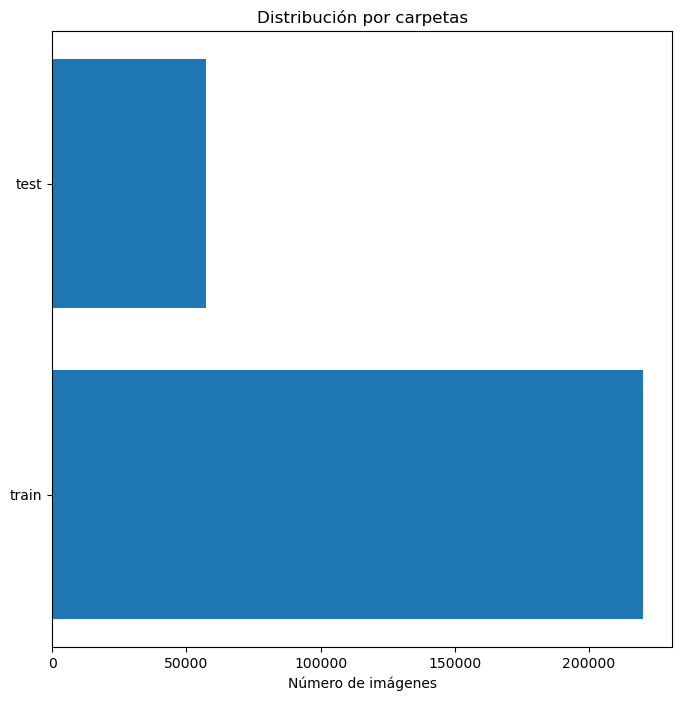

In [4]:
# Crea un Path object para el directorio de entrenamiento
paths_train_dataset = list(Path(train_data_path).rglob('*.tif'))
paths_test_dataset = list(Path(test_data_path).rglob('*.tif'))

# Combinamos ambos paths para conseguir el conteo total
paths_dataset = paths_train_dataset + paths_test_dataset

dict_dataset = defaultdict(list)

# Agrupa las imágenes por su carpeta (train o test)
for p in paths_dataset:
    dict_dataset[p.parent.name].append(str(p))

# Imprime la cantidad y la proporción de imágenes por carpeta
for k in dict_dataset.keys():
    print(f'La carpeta {k} tiene {len(dict_dataset[k])} elementos con proporción {len(dict_dataset[k])/len(paths_dataset):.2f}')

# Configura los parámetros de la figura para matplotlib
plt.rcParams["figure.figsize"] = (8, 8)

# Crea el gráfico de barras horizontal
plt.barh(y=list(dict_dataset.keys()), width=[len(dict_dataset[k]) for k in dict_dataset.keys()])
plt.title('Distribución por carpetas')
plt.xlabel('Número de imágenes')
plt.show()

La misma comprobación pero en un gráfico de sectores.

Los índices por clase son: 
{'test': 1, 'train': 0}


La distribución de los datos por clase es:
{'test': 0.20706854113585338, 'train': 0.7929314588641466}


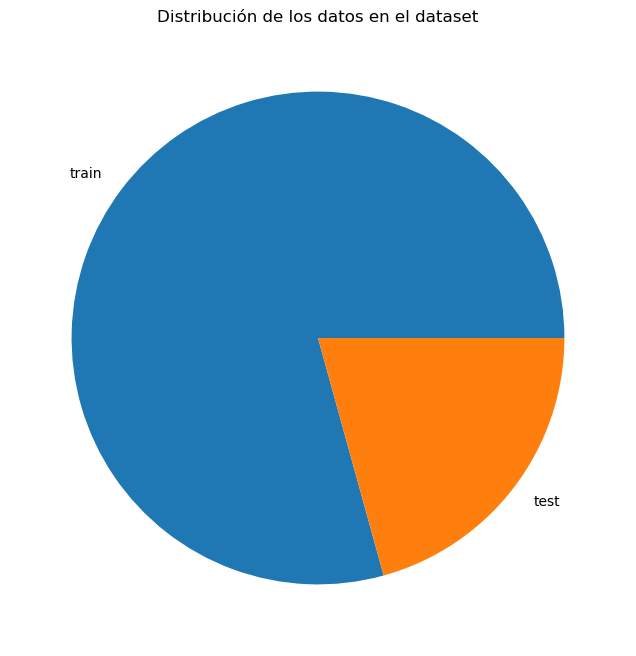

In [5]:
names_to_index = {k: i for i, k in enumerate(dict_dataset.keys())}
names_proportion = {k: len(dict_dataset[k])/len(paths_dataset) for k in dict_dataset.keys()}
print('Los índices por clase son: ')
pprint(names_to_index)
print('\n')
print('La distribución de los datos por clase es:')
pprint(names_proportion)

plt.pie(names_proportion.values(), labels=names_proportion.keys())
plt.title('Distribución de los datos en el dataset')
plt.show()

### 1.3 Visualización de los datos
Comprobamos que los datos son accesibles y que los podemos mostrar.

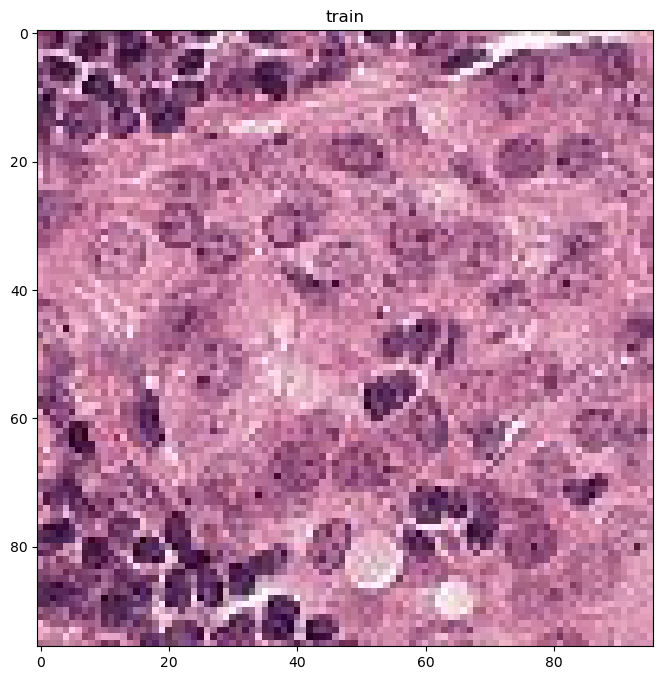

In [6]:
sample_path = random.choice(paths_dataset)

plt.imshow(cv2.imread(str(sample_path))[..., ::-1])
plt.title(sample_path.parent.name)
plt.show()

### 1.4 Formateo de las imágenes
Dado que las imágenes se encuentran en un formato .tif y para poder procesarlas necesitaremos un formato que esté aceptado por Tensorflow, las transformaremos a imágenes .png

In [7]:
# Define la ruta de origen y destino
src_path = pathlib.Path('histopathologic-cancer-detection/train')
def convert_image(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
# convert_image(src_path)

Haremos lo mismo para test.

In [8]:
# Define la ruta de origen y destino
test_path = pathlib.Path('histopathologic-cancer-detection/test')

def convert_image_test(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
# convert_image_test(test_path)

Comprobamos si existen imágenes en el nuevo directorio de train.

In [9]:
# TRAIN
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Crea un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)

print(train_dataset)

Se encontraron 220025 imágenes en histopathologic-cancer-detection\train_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


Comprobamos si existen imágenes en el nuevo directorio de test.

In [10]:
# TEST
test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(test_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {test_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {test_path}.")

# Crea un dataset a partir de los archivos de imagen
test_dataset = tf.data.Dataset.list_files(str(test_path/'*.png'), shuffle=True)

print(test_dataset)


Se encontraron 57458 imágenes en histopathologic-cancer-detection\test_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


### 1.5 Dataframe
Este proceso fue necesario llevarlo a cabo mediante etapas ya que el rendimiento del PC sobre el que se realizó el proceso no permitía cargar todos los archivos de imagen de una única vez.   
   
Creación del dataframe de train.

In [11]:
# Rutas a los directorios y archivos
train_dir = 'histopathologic-cancer-detection/train_converted'
train_labels_csv = 'histopathologic-cancer-detection/train_labels.csv'

# Cargar las etiquetas
labels_df = pd.read_csv(train_labels_csv)
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas
datagen = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes directamente del disco en lotes, por lo que no es necesario cargar todas las imágenes en la memoria a la vez
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Tipo de problema de clasificación (binary para 0 o 1)
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)

Found 220025 validated image filenames.


Respetimos el porceso para test.

In [12]:
test_path = 'histopathologic-cancer-detection/test_converted'
validation_labels = pd.read_csv('histopathologic-cancer-detection/validation_labels.csv')

# Cargar las etiquetas de validación
validation_labels['id'] = validation_labels['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas para validación
datagen_validation = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes de validación directamente del disco en lotes
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_labels,
    directory=test_path,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Uso de 'raw' para etiquetas numéricas
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)

Found 57458 validated image filenames.


A continuación visualizaremos algunos datos con la finalidad de verificar como se ven las imágenes del conjunto de datos y si las transformaciones están funcionando como se esperaba.

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


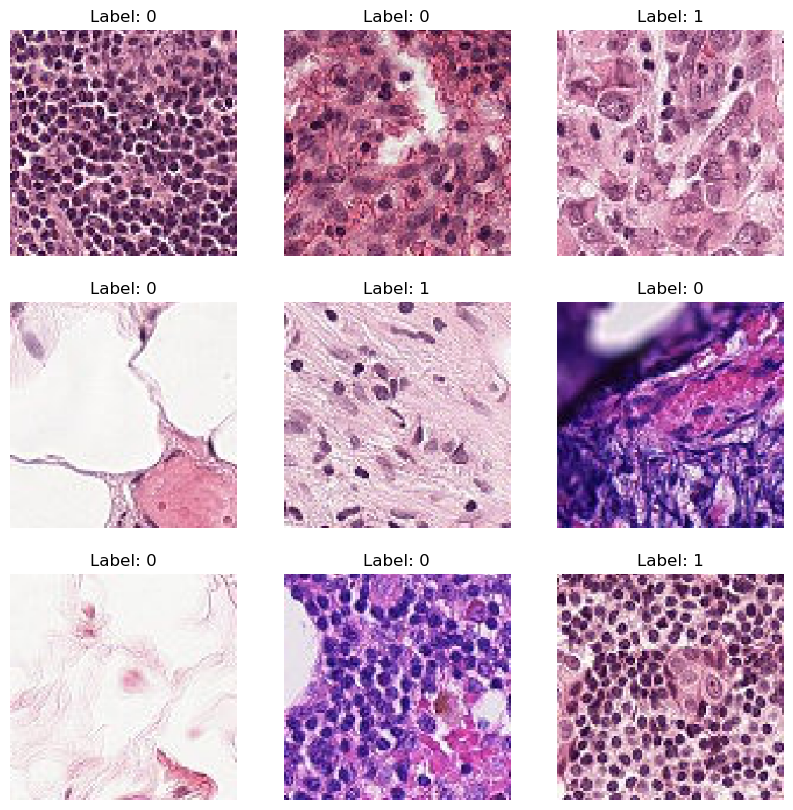

In [13]:
# Configuración ansiosa activada para depuración (si necesario)
tf.config.run_functions_eagerly(True)

# Define una figura con un tamaño específico
plt.figure(figsize=(10, 10))

# Toma un lote del dataset
images, labels = train_generator.next()  # Obtiene un lote directamente
print("Images shape:", images.shape)  # Imprime la forma del tensor de imágenes
print("Labels shape:", labels.shape)  # Imprime la forma del tensor de etiquetas

# Determina el número de imágenes a visualizar
num_images = images.shape[0]
num_subplots = min(num_images, 9)  # Limita a mostrar máximo 9 imágenes

for i in range(num_subplots):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]  # Las imágenes ya están en formato adecuado para visualización
    plt.imshow(img)
    
    # Las etiquetas ya están en formato correcto dado que class_mode='raw' las proporciona como numéricas
    label = labels[i]  # Directamente mostrar la etiqueta asociada

    plt.title(f"Label: {label}")
    plt.axis("off")

plt.show()

## 2. Modelo de Deep Vision

El siguiente paso será la creación del modelo de Deep Vision. En este proceso tendremos que establecer los parámetros con los que queremos entrenar a la red, escoger el modelo a usar y entrenarlo.   

### 2.1 Establecemos los parámetros

A continuación estableceremos los parámetros con los que queremos entrenar a la red, escoger el modelo a usar y entrenarlo. Estos parámetros serán:
- **batch_size**: Define el número de muestras que se procesan antes de que los pesos del modelo cambien.
- **monitor**: Especifica la métrica que se utilizará para monitorizar el rendimiento del modelo durante el entrenamiento.
- **learning_rate**: Define el tamaño del paso que se utiliza para actualizar los pesos del modelo en cada iteración del entrenamiento.
- **epochs**: Es el número total de veces que el conjunto de entrenamiento completo se pasa a través del modelo.
- **early_stopping_patience**: Define cuántas épocas sin mejora en la métrica monitorizada (val_loss) deben transcurrir antes de detener el entrenamiento de manera anticipada.
- **train_backbone**: Determina si las capas base del modelo preentrenado deben ser entrenables o no.
- **version**: Parámetro personalizado, utilizado para versionar modelos y resultados.
- **plateau_factor**: Factor por el cual se reducirá el learning_rate cuando se detecte un estancamiento en la mejora de la métrica monitorizada.
- **plateau_patience**: Número de épocas que deben pasar sin mejora antes de reducir el learning_rate.

Configuración del modelo:
- **input_shape**: Define las dimensiones de las imágenes de entrada al modelo. En este caso, cada imagen tiene un tamaño de 224x224 píxeles con 3 canales de color (RGB).
- **model_name**: Especifica el modelo base que se utilizará. 

In [14]:
# Params 
# Train 
batch_size = 8
monitor = 'val_loss'
learning_rate = 1e-4
epochs = 5
early_stopping_patience = 4
train_backbone = True
version = 0
plateau_factor = 0.5
plateau_patience = 2

# Model 
input_shape = (224, 224, 3)
model_name = 'NOR-RN'

#### 2.1.1 Técnica de aumento de datos
Esta técnica ayudan a mejorar la generalización del modelo al introducir variabilidad en el conjunto de datos de entrenamiento, lo que permite que el modelo aprenda a reconocer patrones importantes en condiciones variadas y evita que se ajuste demasiado a los datos específicos de entrenamiento (overfitting).
- **RandomFlip("horizontal_and_vertical")**: Esta capa aplica un volteo aleatorio a las imágenes tanto horizontal como verticalmente. Al hacer esto, el modelo puede aprender a reconocer objetos sin importar su orientación en la imagen.
- **RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest')**: Rota las imágenes un ángulo aleatorio dentro del rango especificado (en este caso, de -360 a 360 grados, ya que -1 y 1 se interpretan como fracciones de una vuelta completa en círculo). fill_mode='reflect' indica que los píxeles faltantes a causa de la rotación serán rellenados reflejando los píxeles en el borde de la imagen. interpolation='nearest' se refiere a cómo se calculan los valores de los nuevos píxeles que aparecen durante la transformación; en este caso, se asigna el valor del píxel más cercano.
- **RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest')**: Aplica un zoom aleatorio a las imágenes. Los factores de zoom para la anchura y la altura se establecen entre 0 (sin cambio) y 0.2 (un aumento de hasta el 20%). Al igual que con la rotación, interpolation='nearest' se usa para determinar cómo llenar los nuevos píxeles.

In [15]:
data_augmentation = keras.Sequential(
[
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
    keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
]
)

### 2.2 Modelo 
Crearemos un modelo que permita procesar dichas imagenes y determinar mediante una clasificación binaria (0 y 1 si el paciente está afectado por la patología).   

Este modelo estará formado por capas:
- **Primera capa**
    - *data_augmentation :* Antes de nada añadiremos el data_augmentation que anteriormente hemos declarado, se añade como la primera capa de la red. Esto significa que cada imagen que ingrese al modelo será primero procesada por la capa de aumento de datos antes de pasar a través de las capas convolucionales y densas.
- **Segunda capa**
    - *Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)):* Esta es una **capa convolucional**. 
        - Los parámetros indican que tiene **32 filtros (o kernels)**, cada uno de tamaño 3x3. 
        - La función de activación 'relu' (Rectified Linear Unit) se utiliza para añadir no linealidad al modelo, ayudando a aprender patrones más complejos en los datos.
        - input_shape=(224, 224, 3) define el tamaño de las imágenes de entrada al modelo, en este caso, imágenes de 224x224 píxeles con 3 canales de color (RGB).
    - *MaxPooling2D(2, 2):* Esta capa realiza una operación de max pooling con una ventana de 2x2. Reduce la dimensionalidad espacial (ancho y alto) de la entrada, lo que ayuda a hacer el modelo más eficiente y a reducir el overfitting. Al seleccionar el máximo valor de cada ventana 2x2, se conservan las características más destacadas.
- **Tercera capa**
    - *Conv2D(64, (3,3), activation='relu'):* Otra capa convolucional, esta vez con **64 filtros**. Aumentar el número de filtros permite al modelo capturar más detalles o características de las imágenes.
    - *MaxPooling2D(2,2):* Otro max pooling para reducir más la dimensión de las características.
- **Cuarta capa**
    - *Conv2D(128, (3,3), activation='relu'):* Aumenta aún más el **número de filtros a 128**. A medida que profundizamos en la red, es común aumentar el número de filtros para permitir que la red capture la complejidad de los datos. Se sigue utilizando la activación 'relu'.
    - *MaxPooling2D(2,2):* Última capa de max pooling, sigue reduciendo la dimensión.
- **Quinta capa**
    - *Flatten():* Esta capa **aplana los mapas de características en un vector**. Esto es necesario porque las siguientes capas (densas) esperan vectores de entrada en lugar de matrices 3D.
- **Sexta capa**
    - *Dense(512, activation='relu'):* Una capa densa (también conocida como capa completamente conectada) que tiene 512 unidades. Esta capa puede aprender combinaciones no lineales de las características extraídas por las capas convolucionales. Usa 'relu' para la activación.
- **Séptima capa**
    - *Dropout(0.5):* Esta capa descarta aleatoriamente el 50% de las características durante el entrenamiento. Esto ayuda a prevenir el overfitting al forzar a la red a aprender patrones redundantes, haciendo el modelo más robusto.
- **Octava capa**
    - *Dense(1, activation='sigmoid'):* Es la **última capa densa con una sola unidad**. Usa la **función de activación 'sigmoid'** porque estás realizando una clasificación binaria. Esta función mapea la salida de la red a un valor entre 0 y 1, interpretado como la probabilidad de que la entrada pertenezca a la clase 1.

In [16]:
model = Sequential(
    [
        data_augmentation,
        Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ]
)

#### 2.2.1 Callbacks
Las callbacks permiten realizar acciones específicas en diferentes etapas del entrenamiento del modelo. Cada callback que has mencionado tiene un propósito particular que puede ayudar a mejorar el rendimiento del modelo, ahorrar recursos, o proporcionar información adicional sobre el proceso de entrenamiento.
- **ModelCheckpoint**: Este callback guarda automáticamente el modelo o los pesos del modelo en un archivo, en ciertos intervalos, lo que te permite recuperar y usar el modelo sin tener que reentrenarlo.
    - **save_best_only=True**: Indica que el modelo se guardará solo cuando su desempeño en la métrica monitorizada sea el mejor hasta el momento.
    - **f'weights/{model_name}/version_{version}'**: La ruta especifica dónde se guardarán los archivos del modelo, incluyendo detalles como el nombre del modelo y la versión, lo que facilita la organización y el acceso a diferentes versiones o configuraciones de entrenamiento.
- **EarlyStopping**: Detiene el entrenamiento cuando una métrica monitorizada ha dejado de mejorar, lo cual ayuda a prevenir el sobreajuste y a ahorrar tiempo y recursos si el entrenamiento ya no está siendo productivo.
    - **patience=early_stopping_patience**: Configura cuántas épocas deben pasar sin mejora antes de detener definitivamente el entrenamiento. Esto proporciona un margen para confirmar que el rendimiento realmente ha dejado de mejorar y no es solo una fluctuación en los datos.
- **ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitorizada ha dejado de mejorar.
    - **factor=plateau_factor**: Especifica el factor de reducción de la tasa de aprendizaje. En este caso, se establece en 0.5, lo que significa que la tasa de aprendizaje se reducirá en un 50% cada vez que la métrica monitorizada no mejore.
    - **patience=plateau_patience**:  Especifica cuántas épocas sin mejora deben pasar antes de reducir la tasa de aprendizaje, permitiendo algunas fluctuaciones antes de hacer un ajuste.
- **TensorBoard**: Proporciona una manera de visualizar diferentes métricas de entrenamiento y validación en tiempo real, usando una interfaz gráfica en el navegador.
    - **log_dir=f'weights/{model_name}/version_{version}'**: Establece el directorio donde se guardarán los logs de TensorBoard, lo que permite un fácil seguimiento y comparación de diferentes experimentos o versiones de entrenamiento.


In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(f'weights/{model_name}/version_{version}', save_best_only=True, monitor=monitor),
    keras.callbacks.EarlyStopping(monitor=monitor, patience=early_stopping_patience, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=plateau_factor, patience=plateau_patience, mode='auto'),
    keras.callbacks.TensorBoard(log_dir=f'weights/{model_name}/version_{version}')
]

#### 2.2.2 Compilación del modelo
El siguiente paso será compilar el modelo, para ello utilizaremos el optimizador de Adam que es uno de los optimizadores más comunes y efectivos en entrenamientos de redes neuronales, especialmente conocido por manejar bien las tasas de aprendizaje adaptativas para diferentes parámetros. Y detallaremos valores como:

- **loss='binary_crossentropy'**: Esta función mide el rendimiento del modelo cuantificando la diferencia entre las etiquetas reales y las predicciones, ideal para situaciones donde las etiquetas son 0 o 1.
- **metrics**: Estas son las medidas que utilizas para juzgar el rendimiento del modelo. Incluyen:
    - **Precisión**: Proporción de identificaciones positivas que fueron realmente correctas.
    - **Recuerdo (Recall)**: Proporción de casos positivos reales que fueron identificados correctamente.
    - **Exactitud Binaria (BinaryAccuracy)**: Mide la frecuencia con la que las predicciones del modelo coinciden con las etiquetas binarias.

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.BinaryAccuracy(),
    ],
)

#### 2.2.3 Entrenamiento del modelo
A continuación habrá que entrenar el modelo, para ello será necesario establecer unos valores a dicho entrenamiento:
- **model.fit()**: Este método es donde ajustas los pesos de tu modelo utilizando tus datos de entrenamiento.
- **train_generator**: Es el generador que alimenta datos al modelo en lotes, permitiendo el uso eficiente de memoria y posiblemente incorporando más aumentos de datos en tiempo real.
- **epochs**: Número total de ciclos completos a través del conjunto de entrenamiento completo que el modelo debería ejecutar durante el entrenamiento.
- **steps_per_epoch**: Total de número de pasos antes de que se declare una época terminada y comience la siguiente época. Normalmente, es el número de muestras dividido por el tamaño del lote.
- **validation_data**: Datos contra los cuales evaluarás el modelo al final de cada época. 
- **validation_steps**: Define cuántos lotes de muestras del conjunto de validación serán evaluados.
- **verbose=1**: Controla la cantidad de salida de información que se muestra durante el entrenamiento; 1 significa que mostrará una barra de progreso.
- **callbacks**: Lista de callbacks que se aplicarán durante el entrenamiento. 

In [19]:
# Entrenamos el modelo
H = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/5


d:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



6876/6876 [==============================] - ETA: 0s - loss: 0.4265 - precision: 0.7894 - recall: 0.7185 - binary_accuracy: 0.8084INFO:tensorflow:Assets written to: weights/NOR-RN\version_0\assets


INFO:tensorflow:Assets written to: weights/NOR-RN\version_0\assets


6876/6876 [==============================] - 11255s 2s/step - loss: 0.4265 - precision: 0.7894 - recall: 0.7185 - binary_accuracy: 0.8084 - val_loss: 0.7991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.6960 - lr: 1.0000e-04
Epoch 2/5
6876/6876 [==============================] - 11439s 2s/step - loss: 0.3365 - precision: 0.8415 - recall: 0.7961 - binary_accuracy: 0.8567 - val_loss: 1.0151 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.6342 - lr: 1.0000e-04
Epoch 3/5
6876/6876 [==============================] - 11350s 2s/step - loss: 0.3027 - precision: 0.8605 - recall: 0.8209 - binary_accuracy: 0.8736 - val_loss: 1.2479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.6212 - lr: 1.0000e-04
Epoch 4/5
6876/6876 [==============================] - 11340s 2s/step - loss: 0.2687 - precision: 0.8807 - recall: 0.8441 - binary_accuracy: 0.8906 - val_loss: 1.2132 - val_precision: 0.0000e+00 - val_recall: 

#### 2.2.4 Gráfica de losses
Permite visualizar la evolución de la pérdida de entrenamiento y la pérdida de validación a lo largo de las épocas durante el entrenamiento de tu modelo.

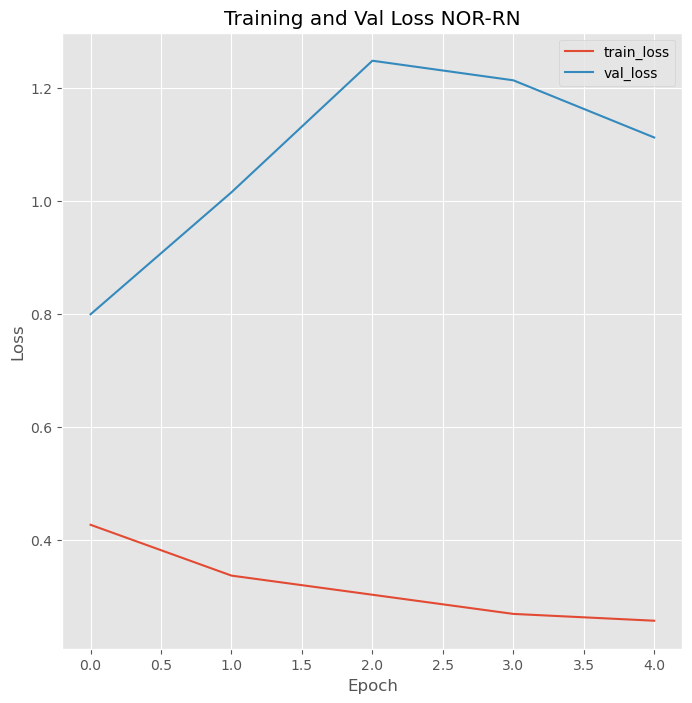

In [20]:
# Gráficas losses
epochs_trained = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs_trained), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, epochs_trained), H.history['val_loss'], label='val_loss')

plt.title(f'Training and Val Loss {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/losses.png')
plt.show()

#### 2.2.5 Inferencia y evaluación
Por último tendremos que ejecutar inferencias en un conjunto de datos de prueba y calcular métricas de clasificación para evaluar el rendimiento del modelo.

In [21]:
# Asegura modelo esté limpio antes de cargar uno nuevo
if 'model' in locals():
    del model
    tf.keras.backend.clear_session()

print('Loading model from checkpoint ...')
model_path = f'weights/{model_name}/version_{version}'
model = tf.keras.models.load_model(model_path)
print('Model loaded!')

# Preparación para la inferencia en el conjunto de prueba
preds = []
targets = []

print('Running inference on test data...')
for imgs, labels in tqdm(validation_generator):
    # Realiza la predicción para el batch actual
    batch_preds = model.predict(imgs)
    # Almacena las predicciones como clases predichas más probables
    preds.extend(tf.argmax(batch_preds, axis=1).numpy())
    # Directamente agregar las etiquetas numéricas
    targets.extend(labels)

# Generar y visualizar las métricas de clasificación
print('Calculating classification metrics...')
report = classification_report(targets, preds,  target_names=['Negativo', 'Positivo']) 

# Opcionalmente, guardar el informe de clasificación
with open(f'weights/{model_name}/version_{version}/classification_report.txt', 'w') as f:
    f.write(report)


Loading model from checkpoint ...



Model loaded!
Running inference on test data...


  0%|          | 0/1796 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 317ms/step


  0%|          | 1/1796 [00:00<12:51,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


  0%|          | 2/1796 [00:00<12:01,  2.49it/s]

1/1 [==============================] - 0s 275ms/step


  0%|          | 3/1796 [00:01<11:29,  2.60it/s]

1/1 [==============================] - 0s 310ms/step


  0%|          | 4/1796 [00:01<11:39,  2.56it/s]

1/1 [==============================] - 0s 296ms/step


  0%|          | 5/1796 [00:02<12:07,  2.46it/s]

1/1 [==============================] - 0s 333ms/step


  0%|          | 6/1796 [00:02<12:52,  2.32it/s]

1/1 [==============================] - 0s 290ms/step


  0%|          | 7/1796 [00:02<12:54,  2.31it/s]

1/1 [==============================] - 0s 288ms/step


  0%|          | 8/1796 [00:03<12:53,  2.31it/s]

1/1 [==============================] - 0s 316ms/step


  1%|          | 9/1796 [00:03<13:05,  2.27it/s]

1/1 [==============================] - 0s 298ms/step


  1%|          | 10/1796 [00:04<13:06,  2.27it/s]

1/1 [==============================] - 0s 290ms/step


  1%|          | 11/1796 [00:04<13:02,  2.28it/s]

1/1 [==============================] - 0s 279ms/step


  1%|          | 12/1796 [00:05<12:28,  2.38it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 13/1796 [00:05<12:25,  2.39it/s]

1/1 [==============================] - 0s 282ms/step


  1%|          | 14/1796 [00:05<12:00,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 15/1796 [00:06<11:32,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 16/1796 [00:06<11:11,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


  1%|          | 17/1796 [00:06<11:01,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 18/1796 [00:07<10:55,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 19/1796 [00:07<10:43,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 20/1796 [00:07<10:33,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 21/1796 [00:08<10:35,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 22/1796 [00:08<10:29,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


  1%|▏         | 23/1796 [00:09<10:37,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


  1%|▏         | 24/1796 [00:09<10:35,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


  1%|▏         | 25/1796 [00:09<10:41,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  1%|▏         | 26/1796 [00:10<10:34,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


  2%|▏         | 27/1796 [00:10<10:40,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


  2%|▏         | 28/1796 [00:10<10:38,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 29/1796 [00:11<10:35,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


  2%|▏         | 30/1796 [00:11<10:32,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 31/1796 [00:11<10:25,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 32/1796 [00:12<10:22,  2.84it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 33/1796 [00:12<10:37,  2.76it/s]

1/1 [==============================] - 0s 283ms/step


  2%|▏         | 34/1796 [00:13<10:49,  2.71it/s]

1/1 [==============================] - 0s 283ms/step


  2%|▏         | 35/1796 [00:13<10:55,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 36/1796 [00:13<10:44,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 37/1796 [00:14<10:49,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


  2%|▏         | 38/1796 [00:14<10:54,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


  2%|▏         | 39/1796 [00:14<11:20,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 40/1796 [00:15<11:03,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


  2%|▏         | 41/1796 [00:15<10:54,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 42/1796 [00:16<10:43,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


  2%|▏         | 43/1796 [00:16<10:45,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


  2%|▏         | 44/1796 [00:16<10:41,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


  3%|▎         | 45/1796 [00:17<10:47,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 46/1796 [00:17<10:39,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 47/1796 [00:17<10:38,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 48/1796 [00:18<10:34,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


  3%|▎         | 49/1796 [00:18<10:43,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 50/1796 [00:18<10:39,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


  3%|▎         | 51/1796 [00:19<10:32,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


  3%|▎         | 52/1796 [00:19<10:31,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 53/1796 [00:20<10:28,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


  3%|▎         | 54/1796 [00:20<10:23,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


  3%|▎         | 55/1796 [00:20<10:20,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


  3%|▎         | 56/1796 [00:21<10:17,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 57/1796 [00:21<10:17,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


  3%|▎         | 58/1796 [00:21<10:12,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


  3%|▎         | 59/1796 [00:22<10:12,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 60/1796 [00:22<10:15,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 61/1796 [00:22<10:25,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 62/1796 [00:23<10:20,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  4%|▎         | 63/1796 [00:23<10:22,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▎         | 64/1796 [00:23<10:35,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


  4%|▎         | 65/1796 [00:24<10:27,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


  4%|▎         | 66/1796 [00:24<10:23,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


  4%|▎         | 67/1796 [00:25<10:28,  2.75it/s]

1/1 [==============================] - 0s 284ms/step


  4%|▍         | 68/1796 [00:25<10:35,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


  4%|▍         | 69/1796 [00:25<10:31,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


  4%|▍         | 70/1796 [00:26<10:21,  2.78it/s]

1/1 [==============================] - 0s 271ms/step


  4%|▍         | 71/1796 [00:26<10:22,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


  4%|▍         | 72/1796 [00:26<10:18,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  4%|▍         | 73/1796 [00:27<10:30,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


  4%|▍         | 74/1796 [00:27<10:29,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▍         | 75/1796 [00:27<10:22,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


  4%|▍         | 76/1796 [00:28<10:15,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


  4%|▍         | 77/1796 [00:28<10:12,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


  4%|▍         | 78/1796 [00:28<10:12,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▍         | 79/1796 [00:29<10:07,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


  4%|▍         | 80/1796 [00:29<10:05,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 81/1796 [00:30<10:07,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▍         | 82/1796 [00:30<10:04,  2.84it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▍         | 83/1796 [00:30<09:58,  2.86it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 84/1796 [00:31<10:08,  2.81it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▍         | 85/1796 [00:31<10:19,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▍         | 86/1796 [00:31<10:14,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▍         | 87/1796 [00:32<10:14,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▍         | 88/1796 [00:32<10:30,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▍         | 89/1796 [00:32<10:24,  2.73it/s]

1/1 [==============================] - 0s 285ms/step


  5%|▌         | 90/1796 [00:33<10:30,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 91/1796 [00:33<10:19,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▌         | 92/1796 [00:34<10:18,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 93/1796 [00:34<10:12,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 94/1796 [00:34<10:06,  2.80it/s]

1/1 [==============================] - 0s 289ms/step


  5%|▌         | 95/1796 [00:35<10:19,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


  5%|▌         | 96/1796 [00:35<10:22,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 97/1796 [00:35<10:28,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▌         | 98/1796 [00:36<10:19,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 99/1796 [00:36<10:18,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▌         | 100/1796 [00:36<10:11,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 101/1796 [00:37<10:08,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 102/1796 [00:37<10:06,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 103/1796 [00:37<10:01,  2.82it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 104/1796 [00:38<09:59,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▌         | 105/1796 [00:38<10:02,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 106/1796 [00:39<09:59,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 107/1796 [00:39<09:58,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▌         | 108/1796 [00:39<10:01,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


  6%|▌         | 109/1796 [00:40<10:26,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


  6%|▌         | 110/1796 [00:40<10:25,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 111/1796 [00:40<10:12,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 112/1796 [00:41<10:04,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▋         | 113/1796 [00:41<10:04,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▋         | 114/1796 [00:41<10:02,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▋         | 115/1796 [00:42<09:59,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▋         | 116/1796 [00:42<09:57,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


  7%|▋         | 117/1796 [00:43<09:59,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 118/1796 [00:43<09:58,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


  7%|▋         | 119/1796 [00:43<09:58,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 120/1796 [00:44<10:01,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 121/1796 [00:44<10:16,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 122/1796 [00:44<10:11,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 123/1796 [00:45<10:11,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 124/1796 [00:45<10:09,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


  7%|▋         | 125/1796 [00:45<10:07,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 126/1796 [00:46<10:04,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 127/1796 [00:46<09:57,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  7%|▋         | 128/1796 [00:47<09:55,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 129/1796 [00:47<09:56,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


  7%|▋         | 130/1796 [00:47<09:56,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 131/1796 [00:48<10:14,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 132/1796 [00:48<10:06,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


  7%|▋         | 133/1796 [00:48<10:16,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 134/1796 [00:49<10:11,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 135/1796 [00:49<10:10,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 136/1796 [00:49<09:58,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 137/1796 [00:50<09:54,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 138/1796 [00:50<09:53,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 139/1796 [00:50<09:48,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 140/1796 [00:51<09:44,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 141/1796 [00:51<09:47,  2.82it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 142/1796 [00:52<09:44,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 143/1796 [00:52<09:42,  2.84it/s]

1/1 [==============================] - 0s 259ms/step


  8%|▊         | 144/1796 [00:52<09:44,  2.83it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 145/1796 [00:53<09:51,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 146/1796 [00:53<09:53,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 147/1796 [00:53<09:51,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 148/1796 [00:54<09:48,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 149/1796 [00:54<09:44,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 150/1796 [00:54<09:47,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 151/1796 [00:55<10:06,  2.71it/s]

1/1 [==============================] - 0s 302ms/step


  8%|▊         | 152/1796 [00:55<10:19,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▊         | 153/1796 [00:56<10:08,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▊         | 154/1796 [00:56<09:53,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▊         | 155/1796 [00:56<09:50,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


  9%|▊         | 156/1796 [00:57<09:48,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▊         | 157/1796 [00:57<10:00,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 158/1796 [00:57<10:00,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 159/1796 [00:58<09:54,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 160/1796 [00:58<09:47,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 161/1796 [00:58<09:46,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▉         | 162/1796 [00:59<09:47,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▉         | 163/1796 [00:59<09:41,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 164/1796 [00:59<09:39,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


  9%|▉         | 165/1796 [01:00<09:43,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▉         | 166/1796 [01:00<09:39,  2.81it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▉         | 167/1796 [01:01<09:38,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 168/1796 [01:01<09:39,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▉         | 169/1796 [01:01<10:05,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▉         | 170/1796 [01:02<09:59,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 10%|▉         | 171/1796 [01:02<09:52,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 10%|▉         | 172/1796 [01:02<09:43,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 10%|▉         | 173/1796 [01:03<09:38,  2.81it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 174/1796 [01:03<09:38,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 10%|▉         | 175/1796 [01:03<09:33,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 10%|▉         | 176/1796 [01:04<09:31,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 10%|▉         | 177/1796 [01:04<09:33,  2.82it/s]

1/1 [==============================] - 0s 261ms/step


 10%|▉         | 178/1796 [01:04<09:30,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 179/1796 [01:05<09:31,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 10%|█         | 180/1796 [01:05<09:39,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 10%|█         | 181/1796 [01:06<09:57,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 10%|█         | 182/1796 [01:06<09:50,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 10%|█         | 183/1796 [01:06<09:45,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 184/1796 [01:07<09:40,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


 10%|█         | 185/1796 [01:07<09:38,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 186/1796 [01:07<09:37,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 10%|█         | 187/1796 [01:08<09:52,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 10%|█         | 188/1796 [01:08<09:51,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 189/1796 [01:09<09:43,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 11%|█         | 190/1796 [01:09<09:36,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 191/1796 [01:09<09:41,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 11%|█         | 192/1796 [01:10<09:37,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 11%|█         | 193/1796 [01:10<09:41,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 194/1796 [01:10<09:38,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 195/1796 [01:11<09:37,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 196/1796 [01:11<09:29,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 197/1796 [01:11<09:25,  2.83it/s]

1/1 [==============================] - 0s 260ms/step


 11%|█         | 198/1796 [01:12<09:27,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 199/1796 [01:12<09:24,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 200/1796 [01:12<09:21,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 201/1796 [01:13<09:24,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 11%|█         | 202/1796 [01:13<09:31,  2.79it/s]

1/1 [==============================] - 0s 314ms/step


 11%|█▏        | 203/1796 [01:14<10:03,  2.64it/s]

1/1 [==============================] - 0s 293ms/step


 11%|█▏        | 204/1796 [01:14<10:35,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█▏        | 205/1796 [01:14<10:25,  2.54it/s]

1/1 [==============================] - 0s 284ms/step


 11%|█▏        | 206/1796 [01:15<10:15,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 207/1796 [01:15<09:58,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 208/1796 [01:15<09:50,  2.69it/s]

1/1 [==============================] - 0s 284ms/step


 12%|█▏        | 209/1796 [01:16<09:53,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 210/1796 [01:16<09:42,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 211/1796 [01:17<09:31,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 212/1796 [01:17<09:29,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 213/1796 [01:17<09:26,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 214/1796 [01:18<09:19,  2.83it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 215/1796 [01:18<09:15,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 216/1796 [01:18<09:19,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 217/1796 [01:19<09:28,  2.78it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 218/1796 [01:19<09:31,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 219/1796 [01:19<09:28,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 220/1796 [01:20<09:23,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 12%|█▏        | 221/1796 [01:20<09:48,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 222/1796 [01:21<09:40,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 223/1796 [01:21<09:31,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 224/1796 [01:21<09:32,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 225/1796 [01:22<09:35,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 226/1796 [01:22<09:31,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 227/1796 [01:22<09:32,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 228/1796 [01:23<09:27,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 229/1796 [01:23<09:36,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 230/1796 [01:23<09:29,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 231/1796 [01:24<09:24,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 232/1796 [01:24<09:17,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 233/1796 [01:24<09:13,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 234/1796 [01:25<09:17,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 235/1796 [01:25<09:16,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 236/1796 [01:26<09:10,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 237/1796 [01:26<09:49,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 238/1796 [01:26<09:37,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 13%|█▎        | 239/1796 [01:27<09:35,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 240/1796 [01:27<09:34,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 241/1796 [01:27<09:33,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 242/1796 [01:28<09:27,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 14%|█▎        | 243/1796 [01:28<09:25,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▎        | 244/1796 [01:29<09:22,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▎        | 245/1796 [01:29<09:19,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▎        | 246/1796 [01:29<09:19,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 247/1796 [01:30<09:14,  2.80it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 248/1796 [01:30<09:19,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 14%|█▍        | 249/1796 [01:30<09:18,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▍        | 250/1796 [01:31<09:14,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 14%|█▍        | 251/1796 [01:31<09:14,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▍        | 252/1796 [01:31<09:15,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 253/1796 [01:32<09:40,  2.66it/s]

1/1 [==============================] - 0s 302ms/step


 14%|█▍        | 254/1796 [01:32<09:46,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▍        | 255/1796 [01:33<09:30,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 256/1796 [01:33<09:20,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▍        | 257/1796 [01:33<09:21,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▍        | 258/1796 [01:34<09:14,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▍        | 259/1796 [01:34<09:11,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▍        | 260/1796 [01:34<09:08,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 15%|█▍        | 261/1796 [01:35<09:09,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▍        | 262/1796 [01:35<09:07,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 263/1796 [01:35<09:02,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 264/1796 [01:36<09:07,  2.80it/s]

1/1 [==============================] - 0s 290ms/step


 15%|█▍        | 265/1796 [01:36<09:27,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 266/1796 [01:37<09:24,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▍        | 267/1796 [01:37<09:14,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▍        | 268/1796 [01:37<09:18,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 15%|█▍        | 269/1796 [01:38<09:29,  2.68it/s]

1/1 [==============================] - 0s 282ms/step


 15%|█▌        | 270/1796 [01:38<09:28,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▌        | 271/1796 [01:38<09:19,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▌        | 272/1796 [01:39<09:17,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▌        | 273/1796 [01:39<09:11,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▌        | 274/1796 [01:39<09:04,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 275/1796 [01:40<09:02,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 276/1796 [01:40<09:07,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 15%|█▌        | 277/1796 [01:41<09:11,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▌        | 278/1796 [01:41<09:09,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 279/1796 [01:41<09:06,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 16%|█▌        | 280/1796 [01:42<09:00,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▌        | 281/1796 [01:42<09:00,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 16%|█▌        | 282/1796 [01:42<08:58,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 283/1796 [01:43<08:55,  2.83it/s]

1/1 [==============================] - 0s 268ms/step


 16%|█▌        | 284/1796 [01:43<09:12,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 285/1796 [01:43<09:09,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 286/1796 [01:44<09:04,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 287/1796 [01:44<08:57,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 288/1796 [01:44<09:01,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 289/1796 [01:45<09:08,  2.75it/s]

1/1 [==============================] - 0s 283ms/step


 16%|█▌        | 290/1796 [01:45<09:11,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 16%|█▌        | 291/1796 [01:46<09:09,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▋        | 292/1796 [01:46<09:03,  2.77it/s]

1/1 [==============================] - 0s 282ms/step


 16%|█▋        | 293/1796 [01:46<09:07,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 16%|█▋        | 294/1796 [01:47<09:08,  2.74it/s]

1/1 [==============================] - 0s 280ms/step


 16%|█▋        | 295/1796 [01:47<09:10,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▋        | 296/1796 [01:47<09:07,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 17%|█▋        | 297/1796 [01:48<09:01,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 298/1796 [01:48<08:58,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 299/1796 [01:48<09:13,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 300/1796 [01:49<09:10,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█▋        | 301/1796 [01:49<09:13,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█▋        | 302/1796 [01:50<09:08,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 303/1796 [01:50<09:00,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 304/1796 [01:50<08:53,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 305/1796 [01:51<08:52,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 306/1796 [01:51<08:55,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 307/1796 [01:51<08:51,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 308/1796 [01:52<08:50,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 309/1796 [01:52<08:53,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 310/1796 [01:52<08:49,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█▋        | 311/1796 [01:53<08:52,  2.79it/s]

1/1 [==============================] - 0s 293ms/step


 17%|█▋        | 312/1796 [01:53<09:21,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█▋        | 313/1796 [01:54<09:28,  2.61it/s]

1/1 [==============================] - 0s 288ms/step


 17%|█▋        | 314/1796 [01:54<09:43,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 315/1796 [01:54<09:29,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 18%|█▊        | 316/1796 [01:55<09:15,  2.66it/s]

1/1 [==============================] - 0s 304ms/step


 18%|█▊        | 317/1796 [01:55<09:33,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 318/1796 [01:56<09:18,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 319/1796 [01:56<09:06,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 18%|█▊        | 320/1796 [01:56<09:03,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 18%|█▊        | 321/1796 [01:57<09:03,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 322/1796 [01:57<08:59,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


 18%|█▊        | 323/1796 [01:57<09:01,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 18%|█▊        | 324/1796 [01:58<08:58,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 325/1796 [01:58<09:01,  2.71it/s]

1/1 [==============================] - 0s 274ms/step


 18%|█▊        | 326/1796 [01:58<08:59,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 327/1796 [01:59<08:53,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 328/1796 [01:59<08:55,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 18%|█▊        | 329/1796 [02:00<09:15,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 18%|█▊        | 330/1796 [02:00<09:01,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 331/1796 [02:00<08:54,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 18%|█▊        | 332/1796 [02:01<08:53,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▊        | 333/1796 [02:01<08:46,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▊        | 334/1796 [02:01<08:42,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 19%|█▊        | 335/1796 [02:02<08:43,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 19%|█▊        | 336/1796 [02:02<08:46,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 337/1796 [02:02<08:56,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 19%|█▉        | 338/1796 [02:03<08:53,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 19%|█▉        | 339/1796 [02:03<08:53,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▉        | 340/1796 [02:03<08:42,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 341/1796 [02:04<08:40,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 19%|█▉        | 342/1796 [02:04<08:45,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▉        | 343/1796 [02:05<08:41,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 344/1796 [02:05<09:03,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 19%|█▉        | 345/1796 [02:05<08:54,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 346/1796 [02:06<08:48,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 19%|█▉        | 347/1796 [02:06<08:48,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 348/1796 [02:06<08:48,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 19%|█▉        | 349/1796 [02:07<08:58,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 19%|█▉        | 350/1796 [02:07<09:01,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 20%|█▉        | 351/1796 [02:08<08:53,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 352/1796 [02:08<08:45,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 20%|█▉        | 353/1796 [02:08<08:52,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 20%|█▉        | 354/1796 [02:09<08:45,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 20%|█▉        | 355/1796 [02:09<08:47,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 20%|█▉        | 356/1796 [02:09<08:45,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 357/1796 [02:10<08:39,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 358/1796 [02:10<08:36,  2.79it/s]

1/1 [==============================] - 0s 280ms/step


 20%|█▉        | 359/1796 [02:10<08:58,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 360/1796 [02:11<08:55,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 361/1796 [02:11<08:57,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


 20%|██        | 362/1796 [02:12<08:50,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 363/1796 [02:12<08:41,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 364/1796 [02:12<08:34,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 20%|██        | 365/1796 [02:13<08:33,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 20%|██        | 366/1796 [02:13<08:36,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 367/1796 [02:13<08:31,  2.80it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 368/1796 [02:14<08:28,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██        | 369/1796 [02:14<08:31,  2.79it/s]

1/1 [==============================] - 0s 311ms/step


 21%|██        | 370/1796 [02:14<08:54,  2.67it/s]

1/1 [==============================] - 0s 292ms/step


 21%|██        | 371/1796 [02:15<09:02,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 372/1796 [02:15<08:54,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██        | 373/1796 [02:16<08:53,  2.67it/s]

1/1 [==============================] - 0s 301ms/step


 21%|██        | 374/1796 [02:16<09:20,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██        | 375/1796 [02:16<09:01,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██        | 376/1796 [02:17<08:49,  2.68it/s]

1/1 [==============================] - 0s 295ms/step


 21%|██        | 377/1796 [02:17<08:53,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 378/1796 [02:18<08:48,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 379/1796 [02:18<08:39,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 21%|██        | 380/1796 [02:18<08:42,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 21%|██        | 381/1796 [02:19<08:37,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██▏       | 382/1796 [02:19<08:39,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


 21%|██▏       | 383/1796 [02:19<08:44,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██▏       | 384/1796 [02:20<08:36,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 21%|██▏       | 385/1796 [02:20<08:43,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 21%|██▏       | 386/1796 [02:20<08:44,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 22%|██▏       | 387/1796 [02:21<08:34,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 388/1796 [02:21<08:27,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 22%|██▏       | 389/1796 [02:22<08:50,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 390/1796 [02:22<08:41,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 391/1796 [02:22<08:32,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


 22%|██▏       | 392/1796 [02:23<08:35,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 393/1796 [02:23<08:29,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 394/1796 [02:23<08:25,  2.77it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 395/1796 [02:24<08:27,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 396/1796 [02:24<08:26,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 397/1796 [02:24<08:31,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 22%|██▏       | 398/1796 [02:25<08:33,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 22%|██▏       | 399/1796 [02:25<08:31,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 400/1796 [02:26<08:26,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 401/1796 [02:26<08:24,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 402/1796 [02:26<08:22,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 22%|██▏       | 403/1796 [02:27<08:36,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 22%|██▏       | 404/1796 [02:27<08:42,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


 23%|██▎       | 405/1796 [02:27<08:40,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 406/1796 [02:28<08:34,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 23%|██▎       | 407/1796 [02:28<08:33,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 408/1796 [02:29<08:27,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 409/1796 [02:29<08:31,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 23%|██▎       | 410/1796 [02:29<08:30,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 411/1796 [02:30<08:25,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 23%|██▎       | 412/1796 [02:30<08:21,  2.76it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 413/1796 [02:30<08:22,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 23%|██▎       | 414/1796 [02:31<08:19,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 415/1796 [02:31<08:34,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 416/1796 [02:31<08:30,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 417/1796 [02:32<08:28,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 418/1796 [02:32<08:20,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 419/1796 [02:33<08:18,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 23%|██▎       | 420/1796 [02:33<08:17,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 421/1796 [02:33<08:22,  2.73it/s]

1/1 [==============================] - 0s 278ms/step


 23%|██▎       | 422/1796 [02:34<08:25,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▎       | 423/1796 [02:34<08:21,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▎       | 424/1796 [02:34<08:15,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▎       | 425/1796 [02:35<08:14,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██▎       | 426/1796 [02:35<08:14,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 427/1796 [02:35<08:28,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 24%|██▍       | 428/1796 [02:36<08:27,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██▍       | 429/1796 [02:36<08:21,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 430/1796 [02:37<08:16,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 24%|██▍       | 431/1796 [02:37<08:17,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 432/1796 [02:37<08:13,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 24%|██▍       | 433/1796 [02:38<08:22,  2.71it/s]

1/1 [==============================] - 0s 280ms/step


 24%|██▍       | 434/1796 [02:38<08:25,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 435/1796 [02:38<08:20,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 24%|██▍       | 436/1796 [02:39<08:13,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 437/1796 [02:39<08:11,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 438/1796 [02:39<08:09,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 439/1796 [02:40<08:03,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 440/1796 [02:40<08:04,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 441/1796 [02:41<08:27,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 442/1796 [02:41<08:19,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▍       | 443/1796 [02:41<08:13,  2.74it/s]

1/1 [==============================] - 0s 310ms/step


 25%|██▍       | 444/1796 [02:42<08:35,  2.62it/s]

1/1 [==============================] - 0s 297ms/step


 25%|██▍       | 445/1796 [02:42<08:53,  2.53it/s]

1/1 [==============================] - 0s 323ms/step


 25%|██▍       | 446/1796 [02:43<09:01,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 25%|██▍       | 447/1796 [02:43<08:49,  2.55it/s]

1/1 [==============================] - 0s 292ms/step


 25%|██▍       | 448/1796 [02:43<08:52,  2.53it/s]

1/1 [==============================] - 0s 309ms/step


 25%|██▌       | 449/1796 [02:44<09:03,  2.48it/s]

1/1 [==============================] - 0s 295ms/step


 25%|██▌       | 450/1796 [02:44<09:02,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 451/1796 [02:45<08:42,  2.57it/s]

1/1 [==============================] - 0s 278ms/step


 25%|██▌       | 452/1796 [02:45<08:31,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 25%|██▌       | 453/1796 [02:45<08:23,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 454/1796 [02:46<08:30,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 25%|██▌       | 455/1796 [02:46<08:28,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 456/1796 [02:46<08:19,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▌       | 457/1796 [02:47<08:20,  2.68it/s]

1/1 [==============================] - 0s 285ms/step


 26%|██▌       | 458/1796 [02:47<08:20,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 26%|██▌       | 459/1796 [02:47<08:12,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 26%|██▌       | 460/1796 [02:48<08:08,  2.74it/s]

1/1 [==============================] - 0s 285ms/step


 26%|██▌       | 461/1796 [02:48<08:14,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 462/1796 [02:49<08:07,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 463/1796 [02:49<08:03,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 26%|██▌       | 464/1796 [02:49<08:02,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 465/1796 [02:50<08:02,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 466/1796 [02:50<08:12,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 467/1796 [02:50<08:10,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 468/1796 [02:51<08:06,  2.73it/s]

1/1 [==============================] - 0s 288ms/step


 26%|██▌       | 469/1796 [02:51<08:20,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


 26%|██▌       | 470/1796 [02:52<08:17,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 471/1796 [02:52<08:08,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▋       | 472/1796 [02:52<07:58,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▋       | 473/1796 [02:53<07:56,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▋       | 474/1796 [02:53<07:53,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 26%|██▋       | 475/1796 [02:53<07:51,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 476/1796 [02:54<07:49,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 27%|██▋       | 477/1796 [02:54<07:58,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 478/1796 [02:54<07:51,  2.80it/s]

1/1 [==============================] - 0s 281ms/step


 27%|██▋       | 479/1796 [02:55<08:16,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 480/1796 [02:55<08:06,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 481/1796 [02:56<08:08,  2.69it/s]

1/1 [==============================] - 0s 278ms/step


 27%|██▋       | 482/1796 [02:56<08:08,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 483/1796 [02:56<08:04,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 484/1796 [02:57<07:54,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 27%|██▋       | 485/1796 [02:57<07:51,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 486/1796 [02:57<07:50,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 487/1796 [02:58<07:46,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 488/1796 [02:58<07:48,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 27%|██▋       | 489/1796 [02:58<07:57,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 490/1796 [02:59<07:53,  2.76it/s]

1/1 [==============================] - 0s 275ms/step


 27%|██▋       | 491/1796 [02:59<08:11,  2.65it/s]

1/1 [==============================] - 0s 293ms/step


 27%|██▋       | 492/1796 [03:00<08:21,  2.60it/s]

1/1 [==============================] - 0s 328ms/step


 27%|██▋       | 493/1796 [03:00<08:55,  2.43it/s]

1/1 [==============================] - 0s 342ms/step


 28%|██▊       | 494/1796 [03:01<09:19,  2.33it/s]

1/1 [==============================] - 0s 307ms/step


 28%|██▊       | 495/1796 [03:01<09:22,  2.31it/s]

1/1 [==============================] - 0s 320ms/step


 28%|██▊       | 496/1796 [03:01<09:21,  2.32it/s]

1/1 [==============================] - 0s 278ms/step


 28%|██▊       | 497/1796 [03:02<09:04,  2.38it/s]

1/1 [==============================] - 0s 279ms/step


 28%|██▊       | 498/1796 [03:02<08:47,  2.46it/s]

1/1 [==============================] - 0s 305ms/step


 28%|██▊       | 499/1796 [03:03<09:02,  2.39it/s]

1/1 [==============================] - 0s 281ms/step


 28%|██▊       | 500/1796 [03:03<09:02,  2.39it/s]

1/1 [==============================] - 0s 291ms/step


 28%|██▊       | 501/1796 [03:03<09:06,  2.37it/s]

1/1 [==============================] - 0s 307ms/step


 28%|██▊       | 502/1796 [03:04<09:14,  2.33it/s]

1/1 [==============================] - 0s 284ms/step


 28%|██▊       | 503/1796 [03:04<09:33,  2.25it/s]

1/1 [==============================] - 0s 302ms/step


 28%|██▊       | 504/1796 [03:05<09:32,  2.26it/s]

1/1 [==============================] - 0s 298ms/step


 28%|██▊       | 505/1796 [03:05<09:42,  2.22it/s]

1/1 [==============================] - 0s 270ms/step


 28%|██▊       | 506/1796 [03:06<09:06,  2.36it/s]

1/1 [==============================] - 0s 293ms/step


 28%|██▊       | 507/1796 [03:06<08:52,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 508/1796 [03:06<09:02,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


 28%|██▊       | 509/1796 [03:07<08:36,  2.49it/s]

1/1 [==============================] - 0s 287ms/step


 28%|██▊       | 510/1796 [03:07<08:30,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██▊       | 511/1796 [03:08<08:16,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██▊       | 512/1796 [03:08<08:01,  2.67it/s]

1/1 [==============================] - 0s 299ms/step


 29%|██▊       | 513/1796 [03:08<08:07,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▊       | 514/1796 [03:09<08:00,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▊       | 515/1796 [03:09<07:52,  2.71it/s]

1/1 [==============================] - 0s 291ms/step


 29%|██▊       | 516/1796 [03:09<08:12,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██▉       | 517/1796 [03:10<08:06,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 29%|██▉       | 518/1796 [03:10<07:57,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 29%|██▉       | 519/1796 [03:11<07:59,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▉       | 520/1796 [03:11<07:50,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 521/1796 [03:11<07:41,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


 29%|██▉       | 522/1796 [03:12<07:42,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 29%|██▉       | 523/1796 [03:12<07:40,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 524/1796 [03:12<07:33,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 29%|██▉       | 525/1796 [03:13<07:34,  2.80it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 526/1796 [03:13<07:34,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 527/1796 [03:13<07:32,  2.80it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 528/1796 [03:14<08:01,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▉       | 529/1796 [03:14<08:01,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 30%|██▉       | 530/1796 [03:15<07:48,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 30%|██▉       | 531/1796 [03:15<07:47,  2.70it/s]

1/1 [==============================] - 0s 301ms/step


 30%|██▉       | 532/1796 [03:15<07:59,  2.64it/s]

1/1 [==============================] - 0s 286ms/step


 30%|██▉       | 533/1796 [03:16<08:07,  2.59it/s]

1/1 [==============================] - 0s 293ms/step


 30%|██▉       | 534/1796 [03:16<08:12,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 30%|██▉       | 535/1796 [03:16<07:55,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 30%|██▉       | 536/1796 [03:17<07:46,  2.70it/s]

1/1 [==============================] - 0s 284ms/step


 30%|██▉       | 537/1796 [03:17<07:47,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 30%|██▉       | 538/1796 [03:18<07:38,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 30%|███       | 539/1796 [03:18<07:33,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


 30%|███       | 540/1796 [03:18<07:36,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 30%|███       | 541/1796 [03:19<08:04,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 542/1796 [03:19<07:54,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 30%|███       | 543/1796 [03:19<07:51,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 30%|███       | 544/1796 [03:20<07:41,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 545/1796 [03:20<07:38,  2.73it/s]

1/1 [==============================] - 0s 282ms/step


 30%|███       | 546/1796 [03:21<07:39,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███       | 547/1796 [03:21<07:32,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 548/1796 [03:21<07:27,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███       | 549/1796 [03:22<07:27,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███       | 550/1796 [03:22<07:29,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███       | 551/1796 [03:22<07:23,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 31%|███       | 552/1796 [03:23<07:27,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


 31%|███       | 553/1796 [03:23<07:41,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 554/1796 [03:23<07:32,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███       | 555/1796 [03:24<07:53,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 556/1796 [03:24<07:40,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███       | 557/1796 [03:25<07:31,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 31%|███       | 558/1796 [03:25<07:31,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███       | 559/1796 [03:25<07:29,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 560/1796 [03:26<07:24,  2.78it/s]

1/1 [==============================] - 0s 274ms/step


 31%|███       | 561/1796 [03:26<07:26,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███▏      | 562/1796 [03:26<07:25,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███▏      | 563/1796 [03:27<07:23,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 31%|███▏      | 564/1796 [03:27<07:24,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███▏      | 565/1796 [03:27<07:33,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 32%|███▏      | 566/1796 [03:28<07:26,  2.75it/s]

1/1 [==============================] - 0s 285ms/step


 32%|███▏      | 567/1796 [03:28<07:45,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 32%|███▏      | 568/1796 [03:29<07:34,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 32%|███▏      | 569/1796 [03:29<07:35,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 32%|███▏      | 570/1796 [03:29<07:36,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 32%|███▏      | 571/1796 [03:30<07:31,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 572/1796 [03:30<07:27,  2.74it/s]

1/1 [==============================] - 0s 292ms/step


 32%|███▏      | 573/1796 [03:30<07:34,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 32%|███▏      | 574/1796 [03:31<07:53,  2.58it/s]

1/1 [==============================] - 0s 281ms/step


 32%|███▏      | 575/1796 [03:31<08:04,  2.52it/s]

1/1 [==============================] - 0s 328ms/step


 32%|███▏      | 576/1796 [03:32<08:40,  2.35it/s]

1/1 [==============================] - 0s 284ms/step


 32%|███▏      | 577/1796 [03:32<08:50,  2.30it/s]

1/1 [==============================] - 0s 290ms/step


 32%|███▏      | 578/1796 [03:33<08:47,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 32%|███▏      | 579/1796 [03:33<08:44,  2.32it/s]

1/1 [==============================] - 0s 295ms/step


 32%|███▏      | 580/1796 [03:34<08:43,  2.32it/s]

1/1 [==============================] - 0s 289ms/step


 32%|███▏      | 581/1796 [03:34<08:23,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 32%|███▏      | 582/1796 [03:34<08:03,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 583/1796 [03:35<07:45,  2.60it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 584/1796 [03:35<07:42,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 585/1796 [03:35<07:44,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 33%|███▎      | 586/1796 [03:36<07:34,  2.66it/s]

1/1 [==============================] - 0s 283ms/step


 33%|███▎      | 587/1796 [03:36<07:32,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 588/1796 [03:36<07:24,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 589/1796 [03:37<07:27,  2.70it/s]

1/1 [==============================] - 0s 296ms/step


 33%|███▎      | 590/1796 [03:37<07:43,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 591/1796 [03:38<07:38,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 592/1796 [03:38<07:28,  2.68it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 593/1796 [03:38<07:28,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 594/1796 [03:39<07:21,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 33%|███▎      | 595/1796 [03:39<07:16,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 33%|███▎      | 596/1796 [03:39<07:27,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 33%|███▎      | 597/1796 [03:40<07:45,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 33%|███▎      | 598/1796 [03:40<07:42,  2.59it/s]

1/1 [==============================] - 0s 282ms/step


 33%|███▎      | 599/1796 [03:41<07:36,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 600/1796 [03:41<07:26,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 601/1796 [03:41<07:28,  2.67it/s]

1/1 [==============================] - 0s 283ms/step


 34%|███▎      | 602/1796 [03:42<07:27,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▎      | 603/1796 [03:42<07:19,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 34%|███▎      | 604/1796 [03:42<07:15,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


 34%|███▎      | 605/1796 [03:43<07:15,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▎      | 606/1796 [03:43<07:27,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 607/1796 [03:44<07:18,  2.71it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▍      | 608/1796 [03:44<07:20,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 609/1796 [03:44<07:16,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 34%|███▍      | 610/1796 [03:45<07:08,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 611/1796 [03:45<07:12,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 612/1796 [03:45<07:15,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▍      | 613/1796 [03:46<07:19,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 34%|███▍      | 614/1796 [03:46<07:33,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 34%|███▍      | 615/1796 [03:47<07:20,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 34%|███▍      | 616/1796 [03:47<07:12,  2.73it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 617/1796 [03:47<07:15,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 34%|███▍      | 618/1796 [03:48<07:07,  2.76it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▍      | 619/1796 [03:48<07:08,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 620/1796 [03:48<07:10,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▍      | 621/1796 [03:49<07:02,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▍      | 622/1796 [03:49<07:14,  2.70it/s]

1/1 [==============================] - 0s 299ms/step


 35%|███▍      | 623/1796 [03:49<07:23,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▍      | 624/1796 [03:50<07:18,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▍      | 625/1796 [03:50<07:21,  2.65it/s]

1/1 [==============================] - 0s 290ms/step


 35%|███▍      | 626/1796 [03:51<07:30,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▍      | 627/1796 [03:51<07:18,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▍      | 628/1796 [03:51<07:08,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 35%|███▌      | 629/1796 [03:52<07:09,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▌      | 630/1796 [03:52<07:23,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▌      | 631/1796 [03:52<07:12,  2.69it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▌      | 632/1796 [03:53<07:11,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 633/1796 [03:53<07:08,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███▌      | 634/1796 [03:54<07:01,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 635/1796 [03:54<07:03,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▌      | 636/1796 [03:54<07:00,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 35%|███▌      | 637/1796 [03:55<07:07,  2.71it/s]

1/1 [==============================] - 0s 285ms/step


 36%|███▌      | 638/1796 [03:55<07:23,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 639/1796 [03:55<07:12,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 640/1796 [03:56<07:08,  2.70it/s]

1/1 [==============================] - 0s 292ms/step


 36%|███▌      | 641/1796 [03:56<07:11,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 642/1796 [03:57<07:03,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 643/1796 [03:57<07:03,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▌      | 644/1796 [03:57<07:05,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 645/1796 [03:58<07:01,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 646/1796 [03:58<07:15,  2.64it/s]

1/1 [==============================] - 0s 288ms/step


 36%|███▌      | 647/1796 [03:58<07:13,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 648/1796 [03:59<07:04,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 649/1796 [03:59<07:06,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 650/1796 [03:59<07:07,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 36%|███▌      | 651/1796 [04:00<07:07,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███▋      | 652/1796 [04:00<06:59,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▋      | 653/1796 [04:01<07:17,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▋      | 654/1796 [04:01<07:09,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▋      | 655/1796 [04:01<06:59,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 37%|███▋      | 656/1796 [04:02<07:02,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 657/1796 [04:02<06:58,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 37%|███▋      | 658/1796 [04:02<06:53,  2.76it/s]

1/1 [==============================] - 0s 282ms/step


 37%|███▋      | 659/1796 [04:03<06:58,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 660/1796 [04:03<06:54,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 661/1796 [04:04<07:14,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 37%|███▋      | 662/1796 [04:04<07:16,  2.60it/s]

1/1 [==============================] - 0s 285ms/step


 37%|███▋      | 663/1796 [04:04<07:12,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 664/1796 [04:05<07:01,  2.68it/s]

1/1 [==============================] - 0s 284ms/step


 37%|███▋      | 665/1796 [04:05<07:03,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 666/1796 [04:05<06:53,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 667/1796 [04:06<06:50,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


 37%|███▋      | 668/1796 [04:06<06:52,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 669/1796 [04:07<07:03,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 670/1796 [04:07<06:58,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 37%|███▋      | 671/1796 [04:07<06:57,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 672/1796 [04:08<06:50,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 673/1796 [04:08<06:56,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 674/1796 [04:08<06:56,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 675/1796 [04:09<06:51,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 676/1796 [04:09<06:47,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


 38%|███▊      | 677/1796 [04:10<07:04,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 678/1796 [04:10<06:56,  2.69it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 679/1796 [04:10<06:53,  2.70it/s]

1/1 [==============================] - 0s 285ms/step


 38%|███▊      | 680/1796 [04:11<06:55,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 681/1796 [04:11<06:51,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 38%|███▊      | 682/1796 [04:11<06:44,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 683/1796 [04:12<06:47,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 684/1796 [04:12<06:47,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 38%|███▊      | 685/1796 [04:13<07:09,  2.59it/s]

1/1 [==============================] - 0s 292ms/step


 38%|███▊      | 686/1796 [04:13<07:09,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 38%|███▊      | 687/1796 [04:13<06:56,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 688/1796 [04:14<06:48,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 38%|███▊      | 689/1796 [04:14<06:54,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 690/1796 [04:14<06:46,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 38%|███▊      | 691/1796 [04:15<06:55,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


 39%|███▊      | 692/1796 [04:15<06:56,  2.65it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▊      | 693/1796 [04:15<06:46,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 39%|███▊      | 694/1796 [04:16<06:43,  2.73it/s]

1/1 [==============================] - 0s 330ms/step


 39%|███▊      | 695/1796 [04:16<07:08,  2.57it/s]

1/1 [==============================] - 0s 278ms/step


 39%|███▉      | 696/1796 [04:17<07:07,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 39%|███▉      | 697/1796 [04:17<07:09,  2.56it/s]

1/1 [==============================] - 0s 280ms/step


 39%|███▉      | 698/1796 [04:17<07:02,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 39%|███▉      | 699/1796 [04:18<07:05,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 700/1796 [04:18<06:52,  2.65it/s]

1/1 [==============================] - 0s 279ms/step


 39%|███▉      | 701/1796 [04:19<06:50,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 702/1796 [04:19<06:41,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▉      | 703/1796 [04:19<06:39,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 39%|███▉      | 704/1796 [04:20<06:42,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 39%|███▉      | 705/1796 [04:20<06:37,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


 39%|███▉      | 706/1796 [04:20<06:39,  2.73it/s]

1/1 [==============================] - 0s 295ms/step


 39%|███▉      | 707/1796 [04:21<07:00,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 708/1796 [04:21<06:51,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 39%|███▉      | 709/1796 [04:22<06:54,  2.62it/s]

1/1 [==============================] - 0s 284ms/step


 40%|███▉      | 710/1796 [04:22<06:51,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███▉      | 711/1796 [04:22<06:43,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 40%|███▉      | 712/1796 [04:23<06:37,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 40%|███▉      | 713/1796 [04:23<06:37,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 40%|███▉      | 714/1796 [04:23<06:39,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███▉      | 715/1796 [04:24<06:35,  2.74it/s]

1/1 [==============================] - 0s 285ms/step


 40%|███▉      | 716/1796 [04:24<06:40,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███▉      | 717/1796 [04:24<06:33,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 40%|███▉      | 718/1796 [04:25<06:29,  2.77it/s]

1/1 [==============================] - 0s 285ms/step


 40%|████      | 719/1796 [04:25<06:47,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 40%|████      | 720/1796 [04:26<06:39,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 40%|████      | 721/1796 [04:26<06:47,  2.64it/s]

1/1 [==============================] - 0s 282ms/step


 40%|████      | 722/1796 [04:26<06:46,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 40%|████      | 723/1796 [04:27<06:36,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 40%|████      | 724/1796 [04:27<06:31,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 40%|████      | 725/1796 [04:27<06:32,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 40%|████      | 726/1796 [04:28<06:44,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 40%|████      | 727/1796 [04:28<06:37,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


 41%|████      | 728/1796 [04:29<06:37,  2.68it/s]

1/1 [==============================] - 0s 285ms/step


 41%|████      | 729/1796 [04:29<06:38,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████      | 730/1796 [04:29<06:33,  2.71it/s]

1/1 [==============================] - 0s 283ms/step


 41%|████      | 731/1796 [04:30<06:35,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████      | 732/1796 [04:30<06:44,  2.63it/s]

1/1 [==============================] - 0s 282ms/step


 41%|████      | 733/1796 [04:30<06:50,  2.59it/s]

1/1 [==============================] - 0s 287ms/step


 41%|████      | 734/1796 [04:31<06:53,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████      | 735/1796 [04:31<06:44,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 41%|████      | 736/1796 [04:32<06:36,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 41%|████      | 737/1796 [04:32<06:36,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████      | 738/1796 [04:32<06:32,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████      | 739/1796 [04:33<06:48,  2.59it/s]

1/1 [==============================] - 0s 293ms/step


 41%|████      | 740/1796 [04:33<06:49,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████▏     | 741/1796 [04:33<06:36,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████▏     | 742/1796 [04:34<06:28,  2.71it/s]

1/1 [==============================] - 0s 282ms/step


 41%|████▏     | 743/1796 [04:34<06:30,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████▏     | 744/1796 [04:35<06:24,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████▏     | 745/1796 [04:35<06:30,  2.69it/s]

1/1 [==============================] - 0s 296ms/step


 42%|████▏     | 746/1796 [04:35<06:45,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 42%|████▏     | 747/1796 [04:36<06:35,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 42%|████▏     | 748/1796 [04:36<06:27,  2.70it/s]

1/1 [==============================] - 0s 289ms/step


 42%|████▏     | 749/1796 [04:36<06:32,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 42%|████▏     | 750/1796 [04:37<06:25,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████▏     | 751/1796 [04:37<06:25,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


 42%|████▏     | 752/1796 [04:38<06:27,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 42%|████▏     | 753/1796 [04:38<06:36,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 42%|████▏     | 754/1796 [04:38<06:27,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 42%|████▏     | 755/1796 [04:39<06:28,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████▏     | 756/1796 [04:39<06:27,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 42%|████▏     | 757/1796 [04:39<06:37,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 42%|████▏     | 758/1796 [04:40<06:35,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 42%|████▏     | 759/1796 [04:40<06:26,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 42%|████▏     | 760/1796 [04:41<06:37,  2.61it/s]

1/1 [==============================] - 0s 287ms/step


 42%|████▏     | 761/1796 [04:41<06:39,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████▏     | 762/1796 [04:41<06:29,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 763/1796 [04:42<06:29,  2.65it/s]

1/1 [==============================] - 0s 289ms/step


 43%|████▎     | 764/1796 [04:42<06:30,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 43%|████▎     | 765/1796 [04:42<06:22,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 43%|████▎     | 766/1796 [04:43<06:17,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 43%|████▎     | 767/1796 [04:43<06:30,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 43%|████▎     | 768/1796 [04:44<06:23,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 43%|████▎     | 769/1796 [04:44<06:38,  2.58it/s]

1/1 [==============================] - 0s 280ms/step


 43%|████▎     | 770/1796 [04:44<06:34,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 43%|████▎     | 771/1796 [04:45<06:25,  2.66it/s]

1/1 [==============================] - 0s 274ms/step


 43%|████▎     | 772/1796 [04:45<06:23,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 43%|████▎     | 773/1796 [04:46<06:25,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 43%|████▎     | 774/1796 [04:46<06:34,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 775/1796 [04:46<06:27,  2.64it/s]

1/1 [==============================] - 0s 281ms/step


 43%|████▎     | 776/1796 [04:47<06:24,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


 43%|████▎     | 777/1796 [04:47<06:24,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 43%|████▎     | 778/1796 [04:47<06:17,  2.70it/s]

1/1 [==============================] - 0s 285ms/step


 43%|████▎     | 779/1796 [04:48<06:19,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 43%|████▎     | 780/1796 [04:48<06:14,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 781/1796 [04:49<06:36,  2.56it/s]

1/1 [==============================] - 0s 285ms/step


 44%|████▎     | 782/1796 [04:49<06:38,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 44%|████▎     | 783/1796 [04:49<06:24,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▎     | 784/1796 [04:50<06:15,  2.69it/s]

1/1 [==============================] - 0s 290ms/step


 44%|████▎     | 785/1796 [04:50<06:20,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▍     | 786/1796 [04:50<06:11,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 787/1796 [04:51<06:07,  2.75it/s]

1/1 [==============================] - 0s 286ms/step


 44%|████▍     | 788/1796 [04:51<06:32,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 44%|████▍     | 789/1796 [04:52<06:20,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 790/1796 [04:52<06:13,  2.69it/s]

1/1 [==============================] - 0s 289ms/step


 44%|████▍     | 791/1796 [04:52<06:22,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 792/1796 [04:53<06:13,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 44%|████▍     | 793/1796 [04:53<06:16,  2.66it/s]

1/1 [==============================] - 0s 291ms/step


 44%|████▍     | 794/1796 [04:53<06:30,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 44%|████▍     | 795/1796 [04:54<06:21,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 796/1796 [04:54<06:13,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 44%|████▍     | 797/1796 [04:55<06:15,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 44%|████▍     | 798/1796 [04:55<06:09,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 799/1796 [04:55<06:04,  2.73it/s]

1/1 [==============================] - 0s 296ms/step


 45%|████▍     | 800/1796 [04:56<06:13,  2.66it/s]

1/1 [==============================] - 0s 293ms/step


 45%|████▍     | 801/1796 [04:56<06:30,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▍     | 802/1796 [04:56<06:18,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▍     | 803/1796 [04:57<06:19,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▍     | 804/1796 [04:57<06:10,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▍     | 805/1796 [04:58<06:27,  2.56it/s]

1/1 [==============================] - 0s 292ms/step


 45%|████▍     | 806/1796 [04:58<06:25,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▍     | 807/1796 [04:58<06:14,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 45%|████▍     | 808/1796 [04:59<06:08,  2.68it/s]

1/1 [==============================] - 0s 291ms/step


 45%|████▌     | 809/1796 [04:59<06:11,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 45%|████▌     | 810/1796 [04:59<06:05,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 811/1796 [05:00<05:59,  2.74it/s]

1/1 [==============================] - 0s 282ms/step


 45%|████▌     | 812/1796 [05:00<06:17,  2.61it/s]

1/1 [==============================] - 0s 274ms/step


 45%|████▌     | 813/1796 [05:01<06:15,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 45%|████▌     | 814/1796 [05:01<06:10,  2.65it/s]

1/1 [==============================] - 0s 290ms/step


 45%|████▌     | 815/1796 [05:01<06:14,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▌     | 816/1796 [05:02<06:09,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 45%|████▌     | 817/1796 [05:02<06:11,  2.64it/s]

1/1 [==============================] - 0s 282ms/step


 46%|████▌     | 818/1796 [05:03<06:23,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 46%|████▌     | 819/1796 [05:03<06:15,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 46%|████▌     | 820/1796 [05:03<06:05,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 46%|████▌     | 821/1796 [05:04<06:04,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 46%|████▌     | 822/1796 [05:04<06:00,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 46%|████▌     | 823/1796 [05:04<05:56,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▌     | 824/1796 [05:05<05:57,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 46%|████▌     | 825/1796 [05:05<05:55,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 46%|████▌     | 826/1796 [05:05<06:00,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 46%|████▌     | 827/1796 [05:06<06:04,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


 46%|████▌     | 828/1796 [05:06<06:01,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 46%|████▌     | 829/1796 [05:07<06:03,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 46%|████▌     | 830/1796 [05:07<06:14,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████▋     | 831/1796 [05:07<06:05,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▋     | 832/1796 [05:08<05:58,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 46%|████▋     | 833/1796 [05:08<06:00,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▋     | 834/1796 [05:08<05:55,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 46%|████▋     | 835/1796 [05:09<05:51,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


 47%|████▋     | 836/1796 [05:09<06:08,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 47%|████▋     | 837/1796 [05:10<06:04,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 47%|████▋     | 838/1796 [05:10<05:59,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 47%|████▋     | 839/1796 [05:10<06:02,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████▋     | 840/1796 [05:11<05:55,  2.69it/s]

1/1 [==============================] - 0s 289ms/step


 47%|████▋     | 841/1796 [05:11<06:14,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


 47%|████▋     | 842/1796 [05:12<06:36,  2.41it/s]

1/1 [==============================] - 0s 293ms/step


 47%|████▋     | 843/1796 [05:12<06:35,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 47%|████▋     | 844/1796 [05:12<06:19,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 47%|████▋     | 845/1796 [05:13<06:12,  2.55it/s]

1/1 [==============================] - 0s 267ms/step


 47%|████▋     | 846/1796 [05:13<06:03,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 847/1796 [05:14<05:55,  2.67it/s]

1/1 [==============================] - 0s 288ms/step


 47%|████▋     | 848/1796 [05:14<06:13,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████▋     | 849/1796 [05:14<06:02,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 47%|████▋     | 850/1796 [05:15<06:01,  2.62it/s]

1/1 [==============================] - 0s 280ms/step


 47%|████▋     | 851/1796 [05:15<05:59,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 852/1796 [05:15<05:51,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 47%|████▋     | 853/1796 [05:16<06:08,  2.56it/s]

1/1 [==============================] - 0s 273ms/step


 48%|████▊     | 854/1796 [05:16<06:05,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 48%|████▊     | 855/1796 [05:17<05:57,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 48%|████▊     | 856/1796 [05:17<05:51,  2.67it/s]

1/1 [==============================] - 0s 310ms/step


 48%|████▊     | 857/1796 [05:17<06:03,  2.59it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 858/1796 [05:18<06:09,  2.54it/s]

1/1 [==============================] - 0s 276ms/step


 48%|████▊     | 859/1796 [05:18<06:21,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 48%|████▊     | 860/1796 [05:19<06:08,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 48%|████▊     | 861/1796 [05:19<06:04,  2.57it/s]

1/1 [==============================] - 0s 280ms/step


 48%|████▊     | 862/1796 [05:19<06:00,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 48%|████▊     | 863/1796 [05:20<05:53,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 48%|████▊     | 864/1796 [05:20<06:01,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 48%|████▊     | 865/1796 [05:21<06:02,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


 48%|████▊     | 866/1796 [05:21<05:57,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


 48%|████▊     | 867/1796 [05:21<05:50,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 48%|████▊     | 868/1796 [05:22<05:51,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 48%|████▊     | 869/1796 [05:22<05:50,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 48%|████▊     | 870/1796 [05:22<05:55,  2.61it/s]

1/1 [==============================] - 0s 277ms/step


 48%|████▊     | 871/1796 [05:23<05:51,  2.63it/s]

1/1 [==============================] - 0s 282ms/step


 49%|████▊     | 872/1796 [05:23<05:50,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 49%|████▊     | 873/1796 [05:24<05:41,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 49%|████▊     | 874/1796 [05:24<05:40,  2.71it/s]

1/1 [==============================] - 0s 280ms/step


 49%|████▊     | 875/1796 [05:24<05:57,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 49%|████▉     | 876/1796 [05:25<05:49,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


 49%|████▉     | 877/1796 [05:25<05:58,  2.57it/s]

1/1 [==============================] - 0s 274ms/step


 49%|████▉     | 878/1796 [05:25<05:50,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 49%|████▉     | 879/1796 [05:26<05:43,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 49%|████▉     | 880/1796 [05:26<05:44,  2.66it/s]

1/1 [==============================] - 0s 280ms/step


 49%|████▉     | 881/1796 [05:27<05:45,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▉     | 882/1796 [05:27<05:50,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 49%|████▉     | 883/1796 [05:27<05:45,  2.65it/s]

1/1 [==============================] - 0s 279ms/step


 49%|████▉     | 884/1796 [05:28<05:43,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 49%|████▉     | 885/1796 [05:28<05:39,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 49%|████▉     | 886/1796 [05:28<05:34,  2.72it/s]

1/1 [==============================] - 0s 277ms/step


 49%|████▉     | 887/1796 [05:29<05:36,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 49%|████▉     | 888/1796 [05:29<05:36,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 49%|████▉     | 889/1796 [05:30<06:03,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 50%|████▉     | 890/1796 [05:30<05:53,  2.56it/s]

1/1 [==============================] - 0s 281ms/step


 50%|████▉     | 891/1796 [05:30<05:48,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 50%|████▉     | 892/1796 [05:31<05:56,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


 50%|████▉     | 893/1796 [05:31<05:47,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 50%|████▉     | 894/1796 [05:32<05:41,  2.64it/s]

1/1 [==============================] - 0s 276ms/step


 50%|████▉     | 895/1796 [05:32<05:39,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 50%|████▉     | 896/1796 [05:32<05:40,  2.65it/s]

1/1 [==============================] - 0s 275ms/step


 50%|████▉     | 897/1796 [05:33<05:39,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 898/1796 [05:33<05:34,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 50%|█████     | 899/1796 [05:33<05:43,  2.61it/s]

1/1 [==============================] - 0s 274ms/step


 50%|█████     | 900/1796 [05:34<05:39,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 50%|█████     | 901/1796 [05:34<05:44,  2.60it/s]

1/1 [==============================] - 0s 274ms/step


 50%|█████     | 902/1796 [05:35<05:45,  2.59it/s]

1/1 [==============================] - 0s 290ms/step


 50%|█████     | 903/1796 [05:35<05:45,  2.58it/s]

1/1 [==============================] - 0s 279ms/step


 50%|█████     | 904/1796 [05:35<05:43,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 50%|█████     | 905/1796 [05:36<05:38,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 50%|█████     | 906/1796 [05:36<05:48,  2.55it/s]

1/1 [==============================] - 0s 279ms/step


 51%|█████     | 907/1796 [05:37<05:44,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 51%|█████     | 908/1796 [05:37<05:45,  2.57it/s]

1/1 [==============================] - 0s 282ms/step


 51%|█████     | 909/1796 [05:37<05:43,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 51%|█████     | 910/1796 [05:38<05:39,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 51%|█████     | 911/1796 [05:38<05:33,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 912/1796 [05:38<05:40,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 51%|█████     | 913/1796 [05:39<05:44,  2.56it/s]

1/1 [==============================] - 0s 281ms/step


 51%|█████     | 914/1796 [05:39<05:41,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 51%|█████     | 915/1796 [05:40<05:31,  2.66it/s]

1/1 [==============================] - 0s 274ms/step


 51%|█████     | 916/1796 [05:40<05:30,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 51%|█████     | 917/1796 [05:40<05:29,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 918/1796 [05:41<05:24,  2.71it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████     | 919/1796 [05:41<05:28,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 51%|█████     | 920/1796 [05:41<05:32,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 51%|█████▏    | 921/1796 [05:42<05:33,  2.62it/s]

1/1 [==============================] - 0s 323ms/step


 51%|█████▏    | 922/1796 [05:42<06:08,  2.37it/s]

1/1 [==============================] - 0s 262ms/step


 51%|█████▏    | 923/1796 [05:43<05:55,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 51%|█████▏    | 924/1796 [05:43<05:45,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 52%|█████▏    | 925/1796 [05:43<05:40,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 926/1796 [05:44<05:34,  2.60it/s]

1/1 [==============================] - 0s 346ms/step


 52%|█████▏    | 927/1796 [05:44<06:08,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


 52%|█████▏    | 928/1796 [05:45<06:19,  2.29it/s]

1/1 [==============================] - 0s 313ms/step


 52%|█████▏    | 929/1796 [05:45<06:24,  2.25it/s]

1/1 [==============================] - 0s 288ms/step


 52%|█████▏    | 930/1796 [05:46<06:22,  2.27it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 931/1796 [05:46<06:33,  2.20it/s]

1/1 [==============================] - 0s 366ms/step


 52%|█████▏    | 932/1796 [05:47<06:48,  2.11it/s]

1/1 [==============================] - 0s 298ms/step


 52%|█████▏    | 933/1796 [05:47<06:42,  2.14it/s]

1/1 [==============================] - 0s 272ms/step


 52%|█████▏    | 934/1796 [05:48<06:24,  2.24it/s]

1/1 [==============================] - 0s 271ms/step


 52%|█████▏    | 935/1796 [05:48<06:03,  2.37it/s]

1/1 [==============================] - 0s 263ms/step


 52%|█████▏    | 936/1796 [05:48<05:48,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 52%|█████▏    | 937/1796 [05:49<05:44,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


 52%|█████▏    | 938/1796 [05:49<05:35,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 939/1796 [05:49<05:26,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 52%|█████▏    | 940/1796 [05:50<05:20,  2.67it/s]

1/1 [==============================] - 0s 289ms/step


 52%|█████▏    | 941/1796 [05:50<05:26,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 52%|█████▏    | 942/1796 [05:51<05:31,  2.58it/s]

1/1 [==============================] - 0s 279ms/step


 53%|█████▎    | 943/1796 [05:51<05:26,  2.61it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████▎    | 944/1796 [05:51<05:22,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 945/1796 [05:52<05:16,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 53%|█████▎    | 946/1796 [05:52<05:18,  2.67it/s]

1/1 [==============================] - 0s 281ms/step


 53%|█████▎    | 947/1796 [05:52<05:18,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 948/1796 [05:53<05:14,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 53%|█████▎    | 949/1796 [05:53<05:23,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 53%|█████▎    | 950/1796 [05:54<05:21,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 951/1796 [05:54<05:16,  2.67it/s]

1/1 [==============================] - 0s 276ms/step


 53%|█████▎    | 952/1796 [05:54<05:27,  2.57it/s]

1/1 [==============================] - 0s 274ms/step


 53%|█████▎    | 953/1796 [05:55<05:23,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 53%|█████▎    | 954/1796 [05:55<05:22,  2.61it/s]

1/1 [==============================] - 0s 280ms/step


 53%|█████▎    | 955/1796 [05:55<05:21,  2.62it/s]

1/1 [==============================] - 0s 278ms/step


 53%|█████▎    | 956/1796 [05:56<05:17,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████▎    | 957/1796 [05:56<05:12,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████▎    | 958/1796 [05:57<05:11,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 53%|█████▎    | 959/1796 [05:57<05:12,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 53%|█████▎    | 960/1796 [05:57<05:26,  2.56it/s]

1/1 [==============================] - 0s 297ms/step


 54%|█████▎    | 961/1796 [05:58<05:40,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████▎    | 962/1796 [05:58<05:35,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 54%|█████▎    | 963/1796 [05:59<05:30,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 54%|█████▎    | 964/1796 [05:59<05:28,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 54%|█████▎    | 965/1796 [05:59<05:34,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 54%|█████▍    | 966/1796 [06:00<05:26,  2.54it/s]

1/1 [==============================] - 0s 288ms/step


 54%|█████▍    | 967/1796 [06:00<05:28,  2.52it/s]

1/1 [==============================] - 0s 286ms/step


 54%|█████▍    | 968/1796 [06:01<05:30,  2.50it/s]

1/1 [==============================] - 0s 284ms/step


 54%|█████▍    | 969/1796 [06:01<05:29,  2.51it/s]

1/1 [==============================] - 0s 335ms/step


 54%|█████▍    | 970/1796 [06:01<05:47,  2.38it/s]

1/1 [==============================] - 0s 294ms/step


 54%|█████▍    | 971/1796 [06:02<05:52,  2.34it/s]

1/1 [==============================] - 0s 296ms/step


 54%|█████▍    | 972/1796 [06:02<05:58,  2.30it/s]

1/1 [==============================] - 0s 317ms/step


 54%|█████▍    | 973/1796 [06:03<06:15,  2.19it/s]

1/1 [==============================] - 0s 315ms/step


 54%|█████▍    | 974/1796 [06:03<06:15,  2.19it/s]

1/1 [==============================] - 0s 295ms/step


 54%|█████▍    | 975/1796 [06:04<06:27,  2.12it/s]

1/1 [==============================] - 0s 321ms/step


 54%|█████▍    | 976/1796 [06:04<06:25,  2.12it/s]

1/1 [==============================] - 0s 303ms/step


 54%|█████▍    | 977/1796 [06:05<06:20,  2.15it/s]

1/1 [==============================] - 0s 311ms/step


 54%|█████▍    | 978/1796 [06:05<06:18,  2.16it/s]

1/1 [==============================] - 0s 297ms/step


 55%|█████▍    | 979/1796 [06:06<06:13,  2.19it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▍    | 980/1796 [06:06<06:13,  2.19it/s]

1/1 [==============================] - 0s 305ms/step


 55%|█████▍    | 981/1796 [06:07<06:11,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


 55%|█████▍    | 982/1796 [06:07<05:59,  2.26it/s]

1/1 [==============================] - 0s 279ms/step


 55%|█████▍    | 983/1796 [06:07<05:45,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 55%|█████▍    | 984/1796 [06:08<05:50,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


 55%|█████▍    | 985/1796 [06:08<05:43,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 55%|█████▍    | 986/1796 [06:09<05:27,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 55%|█████▍    | 987/1796 [06:09<05:20,  2.53it/s]

1/1 [==============================] - 0s 287ms/step


 55%|█████▌    | 988/1796 [06:09<05:23,  2.50it/s]

1/1 [==============================] - 0s 330ms/step


 55%|█████▌    | 989/1796 [06:10<05:34,  2.41it/s]

1/1 [==============================] - 0s 301ms/step


 55%|█████▌    | 990/1796 [06:10<05:37,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 55%|█████▌    | 991/1796 [06:11<05:27,  2.46it/s]

1/1 [==============================] - 0s 290ms/step


 55%|█████▌    | 992/1796 [06:11<05:31,  2.42it/s]

1/1 [==============================] - 0s 289ms/step


 55%|█████▌    | 993/1796 [06:11<05:30,  2.43it/s]

1/1 [==============================] - 0s 311ms/step


 55%|█████▌    | 994/1796 [06:12<05:48,  2.30it/s]

1/1 [==============================] - 0s 292ms/step


 55%|█████▌    | 995/1796 [06:12<05:43,  2.33it/s]

1/1 [==============================] - 0s 281ms/step


 55%|█████▌    | 996/1796 [06:13<05:38,  2.36it/s]

1/1 [==============================] - 0s 323ms/step


 56%|█████▌    | 997/1796 [06:13<05:50,  2.28it/s]

1/1 [==============================] - 0s 302ms/step


 56%|█████▌    | 998/1796 [06:14<05:42,  2.33it/s]

1/1 [==============================] - 0s 309ms/step


 56%|█████▌    | 999/1796 [06:14<05:48,  2.29it/s]

1/1 [==============================] - 0s 320ms/step


 56%|█████▌    | 1000/1796 [06:15<05:45,  2.30it/s]

1/1 [==============================] - 0s 309ms/step


 56%|█████▌    | 1001/1796 [06:15<05:44,  2.31it/s]

1/1 [==============================] - 0s 302ms/step


 56%|█████▌    | 1002/1796 [06:15<05:39,  2.34it/s]

1/1 [==============================] - 0s 317ms/step


 56%|█████▌    | 1003/1796 [06:16<05:39,  2.34it/s]

1/1 [==============================] - 0s 331ms/step


 56%|█████▌    | 1004/1796 [06:16<06:02,  2.19it/s]

1/1 [==============================] - 0s 333ms/step


 56%|█████▌    | 1005/1796 [06:17<06:06,  2.16it/s]

1/1 [==============================] - 0s 327ms/step


 56%|█████▌    | 1006/1796 [06:17<06:09,  2.14it/s]

1/1 [==============================] - 0s 332ms/step


 56%|█████▌    | 1007/1796 [06:18<06:10,  2.13it/s]

1/1 [==============================] - 0s 336ms/step


 56%|█████▌    | 1008/1796 [06:18<06:15,  2.10it/s]

1/1 [==============================] - 0s 350ms/step


 56%|█████▌    | 1009/1796 [06:19<06:36,  1.99it/s]

1/1 [==============================] - 0s 318ms/step


 56%|█████▌    | 1010/1796 [06:19<06:33,  2.00it/s]

1/1 [==============================] - 0s 304ms/step


 56%|█████▋    | 1011/1796 [06:20<06:11,  2.12it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▋    | 1012/1796 [06:20<05:56,  2.20it/s]

1/1 [==============================] - 0s 294ms/step


 56%|█████▋    | 1013/1796 [06:21<05:42,  2.28it/s]

1/1 [==============================] - 0s 299ms/step


 56%|█████▋    | 1014/1796 [06:21<05:35,  2.33it/s]

1/1 [==============================] - 0s 308ms/step


 57%|█████▋    | 1015/1796 [06:21<05:34,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


 57%|█████▋    | 1016/1796 [06:22<05:26,  2.39it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 1017/1796 [06:22<05:32,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


 57%|█████▋    | 1018/1796 [06:23<05:49,  2.22it/s]

1/1 [==============================] - 0s 271ms/step


 57%|█████▋    | 1019/1796 [06:23<05:33,  2.33it/s]

1/1 [==============================] - 0s 283ms/step


 57%|█████▋    | 1020/1796 [06:23<05:22,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 57%|█████▋    | 1021/1796 [06:24<05:15,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 57%|█████▋    | 1022/1796 [06:24<05:06,  2.53it/s]

1/1 [==============================] - 0s 302ms/step


 57%|█████▋    | 1023/1796 [06:25<05:23,  2.39it/s]

1/1 [==============================] - 0s 379ms/step


 57%|█████▋    | 1024/1796 [06:25<05:52,  2.19it/s]

1/1 [==============================] - 0s 368ms/step


 57%|█████▋    | 1025/1796 [06:26<06:08,  2.09it/s]

1/1 [==============================] - 0s 397ms/step


 57%|█████▋    | 1026/1796 [06:26<06:24,  2.00it/s]

1/1 [==============================] - 0s 349ms/step


 57%|█████▋    | 1027/1796 [06:27<06:25,  1.99it/s]

1/1 [==============================] - 0s 346ms/step


 57%|█████▋    | 1028/1796 [06:27<06:27,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


 57%|█████▋    | 1029/1796 [06:28<06:20,  2.02it/s]

1/1 [==============================] - 0s 323ms/step


 57%|█████▋    | 1030/1796 [06:28<06:18,  2.03it/s]

1/1 [==============================] - 0s 320ms/step


 57%|█████▋    | 1031/1796 [06:29<06:13,  2.05it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 1032/1796 [06:29<06:03,  2.10it/s]

1/1 [==============================] - 0s 296ms/step


 58%|█████▊    | 1033/1796 [06:30<06:08,  2.07it/s]

1/1 [==============================] - 0s 283ms/step


 58%|█████▊    | 1034/1796 [06:30<05:43,  2.22it/s]

1/1 [==============================] - 0s 265ms/step


 58%|█████▊    | 1035/1796 [06:30<05:24,  2.34it/s]

1/1 [==============================] - 0s 263ms/step


 58%|█████▊    | 1036/1796 [06:31<05:09,  2.45it/s]

1/1 [==============================] - 0s 310ms/step


 58%|█████▊    | 1037/1796 [06:31<05:11,  2.44it/s]

1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 1038/1796 [06:32<05:19,  2.37it/s]

1/1 [==============================] - 0s 299ms/step


 58%|█████▊    | 1039/1796 [06:32<05:23,  2.34it/s]

1/1 [==============================] - 0s 302ms/step


 58%|█████▊    | 1040/1796 [06:33<05:28,  2.30it/s]

1/1 [==============================] - 0s 298ms/step


 58%|█████▊    | 1041/1796 [06:33<05:30,  2.28it/s]

1/1 [==============================] - 0s 300ms/step


 58%|█████▊    | 1042/1796 [06:33<05:31,  2.28it/s]

1/1 [==============================] - 0s 282ms/step


 58%|█████▊    | 1043/1796 [06:34<05:28,  2.29it/s]

1/1 [==============================] - 0s 264ms/step


 58%|█████▊    | 1044/1796 [06:34<05:18,  2.36it/s]

1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 1045/1796 [06:35<05:16,  2.37it/s]

1/1 [==============================] - 0s 283ms/step


 58%|█████▊    | 1046/1796 [06:35<05:06,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████▊    | 1047/1796 [06:36<05:07,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


 58%|█████▊    | 1048/1796 [06:36<05:01,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 58%|█████▊    | 1049/1796 [06:36<04:52,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 58%|█████▊    | 1050/1796 [06:37<04:52,  2.55it/s]

1/1 [==============================] - 0s 297ms/step


 59%|█████▊    | 1051/1796 [06:37<04:54,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


 59%|█████▊    | 1052/1796 [06:37<04:49,  2.57it/s]

1/1 [==============================] - 0s 280ms/step


 59%|█████▊    | 1053/1796 [06:38<04:48,  2.57it/s]

1/1 [==============================] - 0s 284ms/step


 59%|█████▊    | 1054/1796 [06:38<04:48,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 59%|█████▊    | 1055/1796 [06:39<04:45,  2.59it/s]

1/1 [==============================] - 0s 302ms/step


 59%|█████▉    | 1056/1796 [06:39<05:00,  2.46it/s]

1/1 [==============================] - 0s 303ms/step


 59%|█████▉    | 1057/1796 [06:40<05:20,  2.31it/s]

1/1 [==============================] - 0s 291ms/step


 59%|█████▉    | 1058/1796 [06:40<05:20,  2.30it/s]

1/1 [==============================] - 0s 340ms/step


 59%|█████▉    | 1059/1796 [06:40<05:30,  2.23it/s]

1/1 [==============================] - 0s 300ms/step


 59%|█████▉    | 1060/1796 [06:41<05:29,  2.23it/s]

1/1 [==============================] - 0s 309ms/step


 59%|█████▉    | 1061/1796 [06:41<05:30,  2.23it/s]

1/1 [==============================] - 0s 306ms/step


 59%|█████▉    | 1062/1796 [06:42<05:31,  2.22it/s]

1/1 [==============================] - 0s 282ms/step


 59%|█████▉    | 1063/1796 [06:42<05:17,  2.31it/s]

1/1 [==============================] - 0s 302ms/step


 59%|█████▉    | 1064/1796 [06:43<05:19,  2.29it/s]

1/1 [==============================] - 0s 294ms/step


 59%|█████▉    | 1065/1796 [06:43<05:10,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


 59%|█████▉    | 1066/1796 [06:43<04:59,  2.43it/s]

1/1 [==============================] - 0s 296ms/step


 59%|█████▉    | 1067/1796 [06:44<04:58,  2.45it/s]

1/1 [==============================] - 0s 286ms/step


 59%|█████▉    | 1068/1796 [06:44<04:56,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


 60%|█████▉    | 1069/1796 [06:45<05:01,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 60%|█████▉    | 1070/1796 [06:45<04:56,  2.45it/s]

1/1 [==============================] - 0s 293ms/step


 60%|█████▉    | 1071/1796 [06:45<04:53,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


 60%|█████▉    | 1072/1796 [06:46<04:48,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 60%|█████▉    | 1073/1796 [06:46<04:47,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 60%|█████▉    | 1074/1796 [06:47<04:42,  2.55it/s]

1/1 [==============================] - 0s 323ms/step


 60%|█████▉    | 1075/1796 [06:47<05:00,  2.40it/s]

1/1 [==============================] - 0s 290ms/step


 60%|█████▉    | 1076/1796 [06:48<05:04,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 60%|█████▉    | 1077/1796 [06:48<05:07,  2.34it/s]

1/1 [==============================] - 0s 286ms/step


 60%|██████    | 1078/1796 [06:48<05:11,  2.30it/s]

1/1 [==============================] - 0s 296ms/step


 60%|██████    | 1079/1796 [06:49<05:15,  2.28it/s]

1/1 [==============================] - 0s 294ms/step


 60%|██████    | 1080/1796 [06:49<05:18,  2.25it/s]

1/1 [==============================] - 0s 269ms/step


 60%|██████    | 1081/1796 [06:50<05:09,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 60%|██████    | 1082/1796 [06:50<05:01,  2.37it/s]

1/1 [==============================] - 0s 298ms/step


 60%|██████    | 1083/1796 [06:51<05:01,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 60%|██████    | 1084/1796 [06:51<04:52,  2.44it/s]

1/1 [==============================] - 0s 300ms/step


 60%|██████    | 1085/1796 [06:51<04:57,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 60%|██████    | 1086/1796 [06:52<05:02,  2.34it/s]

1/1 [==============================] - 0s 291ms/step


 61%|██████    | 1087/1796 [06:52<05:18,  2.22it/s]

1/1 [==============================] - 0s 292ms/step


 61%|██████    | 1088/1796 [06:53<05:18,  2.22it/s]

1/1 [==============================] - 0s 294ms/step


 61%|██████    | 1089/1796 [06:53<05:17,  2.22it/s]

1/1 [==============================] - 0s 320ms/step


 61%|██████    | 1090/1796 [06:54<05:22,  2.19it/s]

1/1 [==============================] - 0s 291ms/step


 61%|██████    | 1091/1796 [06:54<05:19,  2.21it/s]

1/1 [==============================] - 0s 295ms/step


 61%|██████    | 1092/1796 [06:55<05:18,  2.21it/s]

1/1 [==============================] - 0s 309ms/step


 61%|██████    | 1093/1796 [06:55<05:28,  2.14it/s]

1/1 [==============================] - 0s 301ms/step


 61%|██████    | 1094/1796 [06:56<05:36,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████    | 1095/1796 [06:56<05:33,  2.10it/s]

1/1 [==============================] - 0s 296ms/step


 61%|██████    | 1096/1796 [06:57<05:26,  2.14it/s]

1/1 [==============================] - 0s 336ms/step


 61%|██████    | 1097/1796 [06:57<05:30,  2.11it/s]

1/1 [==============================] - 0s 272ms/step


 61%|██████    | 1098/1796 [06:57<05:16,  2.21it/s]

1/1 [==============================] - 0s 271ms/step


 61%|██████    | 1099/1796 [06:58<05:02,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


 61%|██████    | 1100/1796 [06:58<05:05,  2.27it/s]

1/1 [==============================] - 0s 284ms/step


 61%|██████▏   | 1101/1796 [06:59<04:59,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 61%|██████▏   | 1102/1796 [06:59<04:51,  2.38it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████▏   | 1103/1796 [07:00<04:56,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


 61%|██████▏   | 1104/1796 [07:00<04:58,  2.31it/s]

1/1 [==============================] - 0s 311ms/step


 62%|██████▏   | 1105/1796 [07:00<05:10,  2.22it/s]

1/1 [==============================] - 0s 289ms/step


 62%|██████▏   | 1106/1796 [07:01<05:12,  2.21it/s]

1/1 [==============================] - 0s 310ms/step


 62%|██████▏   | 1107/1796 [07:01<05:13,  2.20it/s]

1/1 [==============================] - 0s 286ms/step


 62%|██████▏   | 1108/1796 [07:02<05:09,  2.23it/s]

1/1 [==============================] - 0s 291ms/step


 62%|██████▏   | 1109/1796 [07:02<05:07,  2.24it/s]

1/1 [==============================] - 0s 300ms/step


 62%|██████▏   | 1110/1796 [07:03<05:09,  2.22it/s]

1/1 [==============================] - 0s 290ms/step


 62%|██████▏   | 1111/1796 [07:03<05:07,  2.23it/s]

1/1 [==============================] - 0s 302ms/step


 62%|██████▏   | 1112/1796 [07:04<05:12,  2.19it/s]

1/1 [==============================] - 0s 302ms/step


 62%|██████▏   | 1113/1796 [07:04<05:11,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


 62%|██████▏   | 1114/1796 [07:05<05:08,  2.21it/s]

1/1 [==============================] - 0s 317ms/step


 62%|██████▏   | 1115/1796 [07:05<05:12,  2.18it/s]

1/1 [==============================] - 0s 289ms/step


 62%|██████▏   | 1116/1796 [07:05<05:08,  2.20it/s]

1/1 [==============================] - 0s 297ms/step


 62%|██████▏   | 1117/1796 [07:06<05:17,  2.14it/s]

1/1 [==============================] - 0s 277ms/step


 62%|██████▏   | 1118/1796 [07:06<05:04,  2.23it/s]

1/1 [==============================] - 0s 291ms/step


 62%|██████▏   | 1119/1796 [07:07<04:54,  2.30it/s]

1/1 [==============================] - 0s 286ms/step


 62%|██████▏   | 1120/1796 [07:07<04:48,  2.35it/s]

1/1 [==============================] - 0s 298ms/step


 62%|██████▏   | 1121/1796 [07:08<04:45,  2.37it/s]

1/1 [==============================] - 0s 312ms/step


 62%|██████▏   | 1122/1796 [07:08<05:02,  2.23it/s]

1/1 [==============================] - 0s 290ms/step


 63%|██████▎   | 1123/1796 [07:09<05:02,  2.22it/s]

1/1 [==============================] - 0s 291ms/step


 63%|██████▎   | 1124/1796 [07:09<05:01,  2.23it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 1125/1796 [07:09<05:06,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


 63%|██████▎   | 1126/1796 [07:10<05:03,  2.21it/s]

1/1 [==============================] - 0s 318ms/step


 63%|██████▎   | 1127/1796 [07:10<05:06,  2.18it/s]

1/1 [==============================] - 0s 293ms/step


 63%|██████▎   | 1128/1796 [07:11<05:03,  2.20it/s]

1/1 [==============================] - 0s 307ms/step


 63%|██████▎   | 1129/1796 [07:11<05:12,  2.13it/s]

1/1 [==============================] - 0s 295ms/step


 63%|██████▎   | 1130/1796 [07:12<05:14,  2.12it/s]

1/1 [==============================] - 0s 290ms/step


 63%|██████▎   | 1131/1796 [07:12<05:07,  2.16it/s]

1/1 [==============================] - 0s 302ms/step


 63%|██████▎   | 1132/1796 [07:13<05:06,  2.16it/s]

1/1 [==============================] - 0s 308ms/step


 63%|██████▎   | 1133/1796 [07:13<05:04,  2.18it/s]

1/1 [==============================] - 0s 297ms/step


 63%|██████▎   | 1134/1796 [07:14<04:51,  2.27it/s]

1/1 [==============================] - 0s 282ms/step


 63%|██████▎   | 1135/1796 [07:14<04:41,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 63%|██████▎   | 1136/1796 [07:14<04:42,  2.34it/s]

1/1 [==============================] - 0s 306ms/step


 63%|██████▎   | 1137/1796 [07:15<04:38,  2.37it/s]

1/1 [==============================] - 0s 299ms/step


 63%|██████▎   | 1138/1796 [07:15<04:35,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 63%|██████▎   | 1139/1796 [07:16<04:29,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


 63%|██████▎   | 1140/1796 [07:16<04:28,  2.44it/s]

1/1 [==============================] - 0s 291ms/step


 64%|██████▎   | 1141/1796 [07:16<04:33,  2.39it/s]

1/1 [==============================] - 0s 296ms/step


 64%|██████▎   | 1142/1796 [07:17<04:33,  2.39it/s]

1/1 [==============================] - 0s 283ms/step


 64%|██████▎   | 1143/1796 [07:17<04:33,  2.39it/s]

1/1 [==============================] - 0s 287ms/step


 64%|██████▎   | 1144/1796 [07:18<04:28,  2.43it/s]

1/1 [==============================] - 0s 301ms/step


 64%|██████▍   | 1145/1796 [07:18<04:35,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▍   | 1146/1796 [07:18<04:27,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 64%|██████▍   | 1147/1796 [07:19<04:20,  2.49it/s]

1/1 [==============================] - 0s 283ms/step


 64%|██████▍   | 1148/1796 [07:19<04:20,  2.49it/s]

1/1 [==============================] - 0s 307ms/step


 64%|██████▍   | 1149/1796 [07:20<04:23,  2.45it/s]

1/1 [==============================] - 0s 301ms/step


 64%|██████▍   | 1150/1796 [07:20<04:28,  2.40it/s]

1/1 [==============================] - 0s 303ms/step


 64%|██████▍   | 1151/1796 [07:21<04:41,  2.29it/s]

1/1 [==============================] - 0s 293ms/step


 64%|██████▍   | 1152/1796 [07:21<04:44,  2.27it/s]

1/1 [==============================] - 0s 306ms/step


 64%|██████▍   | 1153/1796 [07:22<04:53,  2.19it/s]

1/1 [==============================] - 0s 293ms/step


 64%|██████▍   | 1154/1796 [07:22<04:49,  2.21it/s]

1/1 [==============================] - 0s 306ms/step


 64%|██████▍   | 1155/1796 [07:22<04:49,  2.21it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▍   | 1156/1796 [07:23<04:56,  2.16it/s]

1/1 [==============================] - 0s 285ms/step


 64%|██████▍   | 1157/1796 [07:23<04:49,  2.20it/s]

1/1 [==============================] - 0s 301ms/step


 64%|██████▍   | 1158/1796 [07:24<04:48,  2.21it/s]

1/1 [==============================] - 0s 289ms/step


 65%|██████▍   | 1159/1796 [07:24<04:45,  2.23it/s]

1/1 [==============================] - 0s 311ms/step


 65%|██████▍   | 1160/1796 [07:25<04:48,  2.21it/s]

1/1 [==============================] - 0s 297ms/step


 65%|██████▍   | 1161/1796 [07:25<04:45,  2.22it/s]

1/1 [==============================] - 0s 297ms/step


 65%|██████▍   | 1162/1796 [07:26<04:51,  2.18it/s]

1/1 [==============================] - 0s 298ms/step


 65%|██████▍   | 1163/1796 [07:26<04:48,  2.20it/s]

1/1 [==============================] - 0s 313ms/step


 65%|██████▍   | 1164/1796 [07:27<04:51,  2.17it/s]

1/1 [==============================] - 0s 294ms/step


 65%|██████▍   | 1165/1796 [07:27<04:47,  2.19it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████▍   | 1166/1796 [07:27<04:32,  2.31it/s]

1/1 [==============================] - 0s 303ms/step


 65%|██████▍   | 1167/1796 [07:28<04:26,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 65%|██████▌   | 1168/1796 [07:28<04:22,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 65%|██████▌   | 1169/1796 [07:29<04:16,  2.44it/s]

1/1 [==============================] - 0s 313ms/step


 65%|██████▌   | 1170/1796 [07:29<04:26,  2.35it/s]

1/1 [==============================] - 0s 305ms/step


 65%|██████▌   | 1171/1796 [07:30<04:36,  2.26it/s]

1/1 [==============================] - 0s 296ms/step


 65%|██████▌   | 1172/1796 [07:30<04:39,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 65%|██████▌   | 1173/1796 [07:30<04:41,  2.22it/s]

1/1 [==============================] - 0s 296ms/step


 65%|██████▌   | 1174/1796 [07:31<04:40,  2.22it/s]

1/1 [==============================] - 0s 306ms/step


 65%|██████▌   | 1175/1796 [07:31<04:41,  2.20it/s]

1/1 [==============================] - 0s 302ms/step


 65%|██████▌   | 1176/1796 [07:32<04:44,  2.18it/s]

1/1 [==============================] - 0s 302ms/step


 66%|██████▌   | 1177/1796 [07:32<04:47,  2.15it/s]

1/1 [==============================] - 0s 303ms/step


 66%|██████▌   | 1178/1796 [07:33<04:45,  2.17it/s]

1/1 [==============================] - 0s 291ms/step


 66%|██████▌   | 1179/1796 [07:33<04:44,  2.17it/s]

1/1 [==============================] - 0s 292ms/step


 66%|██████▌   | 1180/1796 [07:34<04:41,  2.19it/s]

1/1 [==============================] - 0s 291ms/step


 66%|██████▌   | 1181/1796 [07:34<04:38,  2.21it/s]

1/1 [==============================] - 0s 308ms/step


 66%|██████▌   | 1182/1796 [07:35<04:39,  2.20it/s]

1/1 [==============================] - 0s 292ms/step


 66%|██████▌   | 1183/1796 [07:35<04:31,  2.26it/s]

1/1 [==============================] - 0s 275ms/step


 66%|██████▌   | 1184/1796 [07:35<04:18,  2.36it/s]

1/1 [==============================] - 0s 275ms/step


 66%|██████▌   | 1185/1796 [07:36<04:12,  2.42it/s]

1/1 [==============================] - 0s 282ms/step


 66%|██████▌   | 1186/1796 [07:36<04:08,  2.45it/s]

1/1 [==============================] - 0s 270ms/step


 66%|██████▌   | 1187/1796 [07:37<04:12,  2.41it/s]

1/1 [==============================] - 0s 300ms/step


 66%|██████▌   | 1188/1796 [07:37<04:18,  2.35it/s]

1/1 [==============================] - 0s 307ms/step


 66%|██████▌   | 1189/1796 [07:38<04:30,  2.24it/s]

1/1 [==============================] - 0s 312ms/step


 66%|██████▋   | 1190/1796 [07:38<04:33,  2.21it/s]

1/1 [==============================] - 0s 291ms/step


 66%|██████▋   | 1191/1796 [07:38<04:35,  2.19it/s]

1/1 [==============================] - 0s 304ms/step


 66%|██████▋   | 1192/1796 [07:39<04:34,  2.20it/s]

1/1 [==============================] - 0s 303ms/step


 66%|██████▋   | 1193/1796 [07:39<04:34,  2.20it/s]

1/1 [==============================] - 0s 287ms/step


 66%|██████▋   | 1194/1796 [07:40<04:29,  2.24it/s]

1/1 [==============================] - 0s 288ms/step


 67%|██████▋   | 1195/1796 [07:40<04:31,  2.22it/s]

1/1 [==============================] - 0s 291ms/step


 67%|██████▋   | 1196/1796 [07:41<04:27,  2.24it/s]

1/1 [==============================] - 0s 304ms/step


 67%|██████▋   | 1197/1796 [07:41<04:28,  2.23it/s]

1/1 [==============================] - 0s 300ms/step


 67%|██████▋   | 1198/1796 [07:42<04:33,  2.19it/s]

1/1 [==============================] - 0s 300ms/step


 67%|██████▋   | 1199/1796 [07:42<04:33,  2.18it/s]

1/1 [==============================] - 0s 303ms/step


 67%|██████▋   | 1200/1796 [07:43<04:32,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


 67%|██████▋   | 1201/1796 [07:43<04:35,  2.16it/s]

1/1 [==============================] - 0s 281ms/step


 67%|██████▋   | 1202/1796 [07:43<04:19,  2.29it/s]

1/1 [==============================] - 0s 281ms/step


 67%|██████▋   | 1203/1796 [07:44<04:19,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 67%|██████▋   | 1204/1796 [07:44<04:07,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 67%|██████▋   | 1205/1796 [07:45<03:59,  2.47it/s]

1/1 [==============================] - 0s 302ms/step


 67%|██████▋   | 1206/1796 [07:45<03:57,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 67%|██████▋   | 1207/1796 [07:45<03:52,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 67%|██████▋   | 1208/1796 [07:46<03:51,  2.54it/s]

1/1 [==============================] - 0s 284ms/step


 67%|██████▋   | 1209/1796 [07:46<03:50,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 1210/1796 [07:46<03:45,  2.59it/s]

1/1 [==============================] - 0s 282ms/step


 67%|██████▋   | 1211/1796 [07:47<03:56,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 67%|██████▋   | 1212/1796 [07:47<03:53,  2.50it/s]

1/1 [==============================] - 0s 276ms/step


 68%|██████▊   | 1213/1796 [07:48<03:52,  2.50it/s]

1/1 [==============================] - 0s 283ms/step


 68%|██████▊   | 1214/1796 [07:48<03:49,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 68%|██████▊   | 1215/1796 [07:48<03:44,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


 68%|██████▊   | 1216/1796 [07:49<03:42,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 68%|██████▊   | 1217/1796 [07:49<03:41,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 68%|██████▊   | 1218/1796 [07:50<03:45,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 68%|██████▊   | 1219/1796 [07:50<03:43,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 68%|██████▊   | 1220/1796 [07:50<03:40,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 1221/1796 [07:51<03:36,  2.66it/s]

1/1 [==============================] - 0s 295ms/step


 68%|██████▊   | 1222/1796 [07:51<03:38,  2.63it/s]

1/1 [==============================] - 0s 280ms/step


 68%|██████▊   | 1223/1796 [07:52<03:45,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 68%|██████▊   | 1224/1796 [07:52<03:38,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 68%|██████▊   | 1225/1796 [07:52<03:39,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 68%|██████▊   | 1226/1796 [07:53<03:36,  2.63it/s]

1/1 [==============================] - 0s 276ms/step


 68%|██████▊   | 1227/1796 [07:53<03:43,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 1228/1796 [07:53<03:37,  2.61it/s]

1/1 [==============================] - 0s 282ms/step


 68%|██████▊   | 1229/1796 [07:54<03:36,  2.62it/s]

1/1 [==============================] - 0s 286ms/step


 68%|██████▊   | 1230/1796 [07:54<03:36,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 69%|██████▊   | 1231/1796 [07:55<03:34,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 69%|██████▊   | 1232/1796 [07:55<03:41,  2.55it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▊   | 1233/1796 [07:55<03:38,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████▊   | 1234/1796 [07:56<03:33,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 69%|██████▉   | 1235/1796 [07:56<03:34,  2.62it/s]

1/1 [==============================] - 0s 286ms/step


 69%|██████▉   | 1236/1796 [07:57<03:39,  2.56it/s]

1/1 [==============================] - 0s 272ms/step


 69%|██████▉   | 1237/1796 [07:57<03:39,  2.55it/s]

1/1 [==============================] - 0s 282ms/step


 69%|██████▉   | 1238/1796 [07:57<03:38,  2.55it/s]

1/1 [==============================] - 0s 274ms/step


 69%|██████▉   | 1239/1796 [07:58<03:35,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 69%|██████▉   | 1240/1796 [07:58<03:31,  2.63it/s]

1/1 [==============================] - 0s 355ms/step


 69%|██████▉   | 1241/1796 [07:59<03:43,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▉   | 1242/1796 [07:59<03:37,  2.55it/s]

1/1 [==============================] - 0s 276ms/step


 69%|██████▉   | 1243/1796 [07:59<03:34,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 69%|██████▉   | 1244/1796 [08:00<03:29,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


 69%|██████▉   | 1245/1796 [08:00<03:28,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▉   | 1246/1796 [08:00<03:28,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 69%|██████▉   | 1247/1796 [08:01<03:25,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████▉   | 1248/1796 [08:01<03:34,  2.55it/s]

1/1 [==============================] - 0s 275ms/step


 70%|██████▉   | 1249/1796 [08:02<03:34,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████▉   | 1250/1796 [08:02<03:30,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████▉   | 1251/1796 [08:02<03:29,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████▉   | 1252/1796 [08:03<03:25,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 70%|██████▉   | 1253/1796 [08:03<03:25,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 70%|██████▉   | 1254/1796 [08:03<03:29,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████▉   | 1255/1796 [08:04<03:28,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████▉   | 1256/1796 [08:04<03:24,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████▉   | 1257/1796 [08:05<03:21,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 70%|███████   | 1258/1796 [08:05<03:20,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


 70%|███████   | 1259/1796 [08:05<03:20,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 70%|███████   | 1260/1796 [08:06<03:18,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 70%|███████   | 1261/1796 [08:06<03:24,  2.62it/s]

1/1 [==============================] - 0s 276ms/step


 70%|███████   | 1262/1796 [08:07<03:29,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 70%|███████   | 1263/1796 [08:07<03:25,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


 70%|███████   | 1264/1796 [08:07<03:22,  2.62it/s]

1/1 [==============================] - 0s 288ms/step


 70%|███████   | 1265/1796 [08:08<03:23,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 70%|███████   | 1266/1796 [08:08<03:20,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████   | 1267/1796 [08:08<03:25,  2.57it/s]

1/1 [==============================] - 0s 288ms/step


 71%|███████   | 1268/1796 [08:09<03:26,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 71%|███████   | 1269/1796 [08:09<03:21,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 71%|███████   | 1270/1796 [08:10<03:20,  2.62it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████   | 1271/1796 [08:10<03:18,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████   | 1272/1796 [08:10<03:17,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████   | 1273/1796 [08:11<03:20,  2.61it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████   | 1274/1796 [08:11<03:26,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 71%|███████   | 1275/1796 [08:12<03:20,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████   | 1276/1796 [08:12<03:16,  2.64it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████   | 1277/1796 [08:12<03:15,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████   | 1278/1796 [08:13<03:13,  2.68it/s]

1/1 [==============================] - 0s 284ms/step


 71%|███████   | 1279/1796 [08:13<03:20,  2.58it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████▏  | 1280/1796 [08:13<03:16,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████▏  | 1281/1796 [08:14<03:12,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


 71%|███████▏  | 1282/1796 [08:14<03:12,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 71%|███████▏  | 1283/1796 [08:15<03:13,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 71%|███████▏  | 1284/1796 [08:15<03:17,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 72%|███████▏  | 1285/1796 [08:15<03:17,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


 72%|███████▏  | 1286/1796 [08:16<03:14,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 72%|███████▏  | 1287/1796 [08:16<03:11,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 1288/1796 [08:16<03:13,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 72%|███████▏  | 1289/1796 [08:17<03:12,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 72%|███████▏  | 1290/1796 [08:17<03:09,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 72%|███████▏  | 1291/1796 [08:18<03:11,  2.64it/s]

1/1 [==============================] - 0s 291ms/step


 72%|███████▏  | 1292/1796 [08:18<03:13,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 72%|███████▏  | 1293/1796 [08:18<03:12,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 72%|███████▏  | 1294/1796 [08:19<03:09,  2.64it/s]

1/1 [==============================] - 0s 359ms/step


 72%|███████▏  | 1295/1796 [08:19<03:22,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 72%|███████▏  | 1296/1796 [08:20<03:16,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 72%|███████▏  | 1297/1796 [08:20<03:14,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 72%|███████▏  | 1298/1796 [08:20<03:12,  2.58it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 1299/1796 [08:21<03:16,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 72%|███████▏  | 1300/1796 [08:21<03:25,  2.41it/s]

1/1 [==============================] - 0s 289ms/step


 72%|███████▏  | 1301/1796 [08:22<03:23,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 1302/1796 [08:22<03:17,  2.50it/s]

1/1 [==============================] - 0s 276ms/step


 73%|███████▎  | 1303/1796 [08:22<03:12,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 73%|███████▎  | 1304/1796 [08:23<03:09,  2.60it/s]

1/1 [==============================] - 0s 277ms/step


 73%|███████▎  | 1305/1796 [08:23<03:08,  2.60it/s]

1/1 [==============================] - 0s 277ms/step


 73%|███████▎  | 1306/1796 [08:23<03:05,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 73%|███████▎  | 1307/1796 [08:24<03:09,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 73%|███████▎  | 1308/1796 [08:24<03:08,  2.59it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 1309/1796 [08:25<03:10,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 73%|███████▎  | 1310/1796 [08:25<03:07,  2.60it/s]

1/1 [==============================] - 0s 287ms/step


 73%|███████▎  | 1311/1796 [08:25<03:06,  2.60it/s]

1/1 [==============================] - 0s 282ms/step


 73%|███████▎  | 1312/1796 [08:26<03:12,  2.51it/s]

1/1 [==============================] - 0s 297ms/step


 73%|███████▎  | 1313/1796 [08:26<03:13,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 73%|███████▎  | 1314/1796 [08:27<03:13,  2.49it/s]

1/1 [==============================] - 0s 292ms/step


 73%|███████▎  | 1315/1796 [08:27<03:18,  2.42it/s]

1/1 [==============================] - 0s 281ms/step


 73%|███████▎  | 1316/1796 [08:27<03:17,  2.43it/s]

1/1 [==============================] - 0s 297ms/step


 73%|███████▎  | 1317/1796 [08:28<03:19,  2.41it/s]

1/1 [==============================] - 0s 295ms/step


 73%|███████▎  | 1318/1796 [08:28<03:26,  2.31it/s]

1/1 [==============================] - 0s 282ms/step


 73%|███████▎  | 1319/1796 [08:29<03:19,  2.39it/s]

1/1 [==============================] - 0s 294ms/step


 73%|███████▎  | 1320/1796 [08:29<03:17,  2.41it/s]

1/1 [==============================] - 0s 289ms/step


 74%|███████▎  | 1321/1796 [08:30<03:19,  2.38it/s]

1/1 [==============================] - 0s 283ms/step


 74%|███████▎  | 1322/1796 [08:30<03:16,  2.41it/s]

1/1 [==============================] - 0s 295ms/step


 74%|███████▎  | 1323/1796 [08:30<03:23,  2.32it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▎  | 1324/1796 [08:31<03:18,  2.37it/s]

1/1 [==============================] - 0s 299ms/step


 74%|███████▍  | 1325/1796 [08:31<03:17,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 1326/1796 [08:32<03:11,  2.46it/s]

1/1 [==============================] - 0s 281ms/step


 74%|███████▍  | 1327/1796 [08:32<03:07,  2.50it/s]

1/1 [==============================] - 0s 282ms/step


 74%|███████▍  | 1328/1796 [08:32<03:06,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


 74%|███████▍  | 1329/1796 [08:33<03:05,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 74%|███████▍  | 1330/1796 [08:33<03:00,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 74%|███████▍  | 1331/1796 [08:34<03:04,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 74%|███████▍  | 1332/1796 [08:34<02:59,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 74%|███████▍  | 1333/1796 [08:34<02:59,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 1334/1796 [08:35<02:58,  2.59it/s]

1/1 [==============================] - 0s 274ms/step


 74%|███████▍  | 1335/1796 [08:35<02:56,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 1336/1796 [08:35<02:54,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 74%|███████▍  | 1337/1796 [08:36<02:52,  2.66it/s]

1/1 [==============================] - 0s 285ms/step


 74%|███████▍  | 1338/1796 [08:36<03:00,  2.54it/s]

1/1 [==============================] - 0s 273ms/step


 75%|███████▍  | 1339/1796 [08:37<02:57,  2.57it/s]

1/1 [==============================] - 0s 300ms/step


 75%|███████▍  | 1340/1796 [08:37<02:58,  2.56it/s]

1/1 [==============================] - 0s 276ms/step


 75%|███████▍  | 1341/1796 [08:37<02:57,  2.57it/s]

1/1 [==============================] - 0s 274ms/step


 75%|███████▍  | 1342/1796 [08:38<02:54,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▍  | 1343/1796 [08:38<02:57,  2.55it/s]

1/1 [==============================] - 0s 292ms/step


 75%|███████▍  | 1344/1796 [08:39<02:56,  2.56it/s]

1/1 [==============================] - 0s 274ms/step


 75%|███████▍  | 1345/1796 [08:39<02:58,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 75%|███████▍  | 1346/1796 [08:39<02:54,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1347/1796 [08:40<02:50,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 75%|███████▌  | 1348/1796 [08:40<02:52,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1349/1796 [08:41<02:49,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1350/1796 [08:41<02:48,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 75%|███████▌  | 1351/1796 [08:41<02:53,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1352/1796 [08:42<02:49,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 75%|███████▌  | 1353/1796 [08:42<02:49,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1354/1796 [08:42<02:46,  2.65it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 1355/1796 [08:43<02:47,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 76%|███████▌  | 1356/1796 [08:43<02:50,  2.58it/s]

1/1 [==============================] - 0s 269ms/step


 76%|███████▌  | 1357/1796 [08:44<02:51,  2.55it/s]

1/1 [==============================] - 0s 278ms/step


 76%|███████▌  | 1358/1796 [08:44<02:50,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████▌  | 1359/1796 [08:44<02:46,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▌  | 1360/1796 [08:45<02:45,  2.63it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▌  | 1361/1796 [08:45<02:45,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 76%|███████▌  | 1362/1796 [08:46<02:44,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 76%|███████▌  | 1363/1796 [08:46<02:44,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 76%|███████▌  | 1364/1796 [08:46<02:50,  2.53it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████▌  | 1365/1796 [08:47<02:48,  2.55it/s]

1/1 [==============================] - 0s 307ms/step


 76%|███████▌  | 1366/1796 [08:47<02:53,  2.48it/s]

1/1 [==============================] - 0s 296ms/step


 76%|███████▌  | 1367/1796 [08:48<02:53,  2.48it/s]

1/1 [==============================] - 0s 287ms/step


 76%|███████▌  | 1368/1796 [08:48<02:51,  2.49it/s]

1/1 [==============================] - 0s 300ms/step


 76%|███████▌  | 1369/1796 [08:48<03:01,  2.35it/s]

1/1 [==============================] - 0s 290ms/step


 76%|███████▋  | 1370/1796 [08:49<03:01,  2.34it/s]

1/1 [==============================] - 0s 291ms/step


 76%|███████▋  | 1371/1796 [08:49<02:58,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████▋  | 1372/1796 [08:50<02:53,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████▋  | 1373/1796 [08:50<02:48,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 77%|███████▋  | 1374/1796 [08:50<02:50,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 77%|███████▋  | 1375/1796 [08:51<02:47,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 77%|███████▋  | 1376/1796 [08:51<02:43,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████▋  | 1377/1796 [08:52<02:40,  2.60it/s]

1/1 [==============================] - 0s 276ms/step


 77%|███████▋  | 1378/1796 [08:52<02:39,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 1379/1796 [08:52<02:38,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 77%|███████▋  | 1380/1796 [08:53<02:38,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████▋  | 1381/1796 [08:53<02:45,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 77%|███████▋  | 1382/1796 [08:54<02:43,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 77%|███████▋  | 1383/1796 [08:54<02:39,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 77%|███████▋  | 1384/1796 [08:54<02:37,  2.62it/s]

1/1 [==============================] - 0s 275ms/step


 77%|███████▋  | 1385/1796 [08:55<02:35,  2.63it/s]

1/1 [==============================] - 0s 292ms/step


 77%|███████▋  | 1386/1796 [08:55<02:42,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 77%|███████▋  | 1387/1796 [08:55<02:39,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 77%|███████▋  | 1388/1796 [08:56<02:38,  2.57it/s]

1/1 [==============================] - 0s 277ms/step


 77%|███████▋  | 1389/1796 [08:56<02:36,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████▋  | 1390/1796 [08:57<02:33,  2.64it/s]

1/1 [==============================] - 0s 280ms/step


 77%|███████▋  | 1391/1796 [08:57<02:40,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


 78%|███████▊  | 1392/1796 [08:57<02:37,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 78%|███████▊  | 1393/1796 [08:58<02:40,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 78%|███████▊  | 1394/1796 [08:58<02:38,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


 78%|███████▊  | 1395/1796 [08:59<02:35,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


 78%|███████▊  | 1396/1796 [08:59<02:33,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 1397/1796 [08:59<02:34,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 1398/1796 [09:00<02:37,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 78%|███████▊  | 1399/1796 [09:00<02:33,  2.59it/s]

1/1 [==============================] - 0s 273ms/step


 78%|███████▊  | 1400/1796 [09:00<02:32,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 78%|███████▊  | 1401/1796 [09:01<02:30,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 1402/1796 [09:01<02:34,  2.55it/s]

1/1 [==============================] - 0s 277ms/step


 78%|███████▊  | 1403/1796 [09:02<02:32,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 1404/1796 [09:02<02:31,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 1405/1796 [09:02<02:31,  2.59it/s]

1/1 [==============================] - 0s 281ms/step


 78%|███████▊  | 1406/1796 [09:03<02:36,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 1407/1796 [09:03<02:32,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 1408/1796 [09:04<02:29,  2.60it/s]

1/1 [==============================] - 0s 295ms/step


 78%|███████▊  | 1409/1796 [09:04<02:30,  2.57it/s]

1/1 [==============================] - 0s 290ms/step


 79%|███████▊  | 1410/1796 [09:04<02:33,  2.52it/s]

1/1 [==============================] - 0s 277ms/step


 79%|███████▊  | 1411/1796 [09:05<02:30,  2.56it/s]

1/1 [==============================] - 0s 303ms/step


 79%|███████▊  | 1412/1796 [09:05<02:32,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 79%|███████▊  | 1413/1796 [09:06<02:29,  2.57it/s]

1/1 [==============================] - 0s 280ms/step


 79%|███████▊  | 1414/1796 [09:06<02:27,  2.59it/s]

1/1 [==============================] - 0s 271ms/step


 79%|███████▉  | 1415/1796 [09:06<02:32,  2.50it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 1416/1796 [09:07<02:30,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


 79%|███████▉  | 1417/1796 [09:07<02:33,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 79%|███████▉  | 1418/1796 [09:08<02:29,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 79%|███████▉  | 1419/1796 [09:08<02:25,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


 79%|███████▉  | 1420/1796 [09:08<02:32,  2.47it/s]

1/1 [==============================] - 0s 295ms/step


 79%|███████▉  | 1421/1796 [09:09<02:31,  2.48it/s]

1/1 [==============================] - 0s 289ms/step


 79%|███████▉  | 1422/1796 [09:09<02:34,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


 79%|███████▉  | 1423/1796 [09:10<02:31,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 79%|███████▉  | 1424/1796 [09:10<02:27,  2.53it/s]

1/1 [==============================] - 0s 276ms/step


 79%|███████▉  | 1425/1796 [09:10<02:29,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 79%|███████▉  | 1426/1796 [09:11<02:25,  2.54it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 1427/1796 [09:11<02:23,  2.57it/s]

1/1 [==============================] - 0s 289ms/step


 80%|███████▉  | 1428/1796 [09:12<02:23,  2.57it/s]

1/1 [==============================] - 0s 284ms/step


 80%|███████▉  | 1429/1796 [09:12<02:25,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 80%|███████▉  | 1430/1796 [09:12<02:22,  2.57it/s]

1/1 [==============================] - 0s 298ms/step


 80%|███████▉  | 1431/1796 [09:13<02:27,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 80%|███████▉  | 1432/1796 [09:13<02:22,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 80%|███████▉  | 1433/1796 [09:13<02:19,  2.60it/s]

1/1 [==============================] - 0s 281ms/step


 80%|███████▉  | 1434/1796 [09:14<02:19,  2.60it/s]

1/1 [==============================] - 0s 280ms/step


 80%|███████▉  | 1435/1796 [09:14<02:21,  2.56it/s]

1/1 [==============================] - 0s 272ms/step


 80%|███████▉  | 1436/1796 [09:15<02:18,  2.59it/s]

1/1 [==============================] - 0s 287ms/step


 80%|████████  | 1437/1796 [09:15<02:18,  2.59it/s]

1/1 [==============================] - 0s 271ms/step


 80%|████████  | 1438/1796 [09:15<02:17,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 80%|████████  | 1439/1796 [09:16<02:20,  2.54it/s]

1/1 [==============================] - 0s 287ms/step


 80%|████████  | 1440/1796 [09:16<02:20,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 1441/1796 [09:17<02:18,  2.56it/s]

1/1 [==============================] - 0s 293ms/step


 80%|████████  | 1442/1796 [09:17<02:18,  2.55it/s]

1/1 [==============================] - 0s 322ms/step


 80%|████████  | 1443/1796 [09:17<02:23,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 80%|████████  | 1444/1796 [09:18<02:18,  2.54it/s]

1/1 [==============================] - 0s 276ms/step


 80%|████████  | 1445/1796 [09:18<02:16,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████  | 1446/1796 [09:19<02:14,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 81%|████████  | 1447/1796 [09:19<02:16,  2.55it/s]

1/1 [==============================] - 0s 292ms/step


 81%|████████  | 1448/1796 [09:19<02:17,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 81%|████████  | 1449/1796 [09:20<02:16,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████  | 1450/1796 [09:20<02:14,  2.56it/s]

1/1 [==============================] - 0s 285ms/step


 81%|████████  | 1451/1796 [09:21<02:13,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 81%|████████  | 1452/1796 [09:21<02:12,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████  | 1453/1796 [09:21<02:12,  2.58it/s]

1/1 [==============================] - 0s 306ms/step


 81%|████████  | 1454/1796 [09:22<02:20,  2.44it/s]

1/1 [==============================] - 0s 315ms/step


 81%|████████  | 1455/1796 [09:22<02:23,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 81%|████████  | 1456/1796 [09:23<02:19,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 81%|████████  | 1457/1796 [09:23<02:17,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 81%|████████  | 1458/1796 [09:23<02:14,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 1459/1796 [09:24<02:11,  2.57it/s]

1/1 [==============================] - 0s 331ms/step


 81%|████████▏ | 1460/1796 [09:24<02:17,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████▏ | 1461/1796 [09:25<02:12,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 81%|████████▏ | 1462/1796 [09:25<02:11,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████▏ | 1463/1796 [09:25<02:08,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 1464/1796 [09:26<02:06,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 82%|████████▏ | 1465/1796 [09:26<02:10,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 82%|████████▏ | 1466/1796 [09:27<02:12,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 1467/1796 [09:27<02:09,  2.54it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████▏ | 1468/1796 [09:27<02:09,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 1469/1796 [09:28<02:06,  2.58it/s]

1/1 [==============================] - 0s 313ms/step


 82%|████████▏ | 1470/1796 [09:28<02:09,  2.52it/s]

1/1 [==============================] - 0s 285ms/step


 82%|████████▏ | 1471/1796 [09:29<02:11,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 1472/1796 [09:29<02:07,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 1473/1796 [09:29<02:05,  2.57it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████▏ | 1474/1796 [09:30<02:08,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 82%|████████▏ | 1475/1796 [09:30<02:11,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 82%|████████▏ | 1476/1796 [09:30<02:09,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 1477/1796 [09:31<02:09,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████▏ | 1478/1796 [09:31<02:05,  2.54it/s]

1/1 [==============================] - 0s 344ms/step


 82%|████████▏ | 1479/1796 [09:32<02:10,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 82%|████████▏ | 1480/1796 [09:32<02:07,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 82%|████████▏ | 1481/1796 [09:32<02:03,  2.56it/s]

1/1 [==============================] - 0s 290ms/step


 83%|████████▎ | 1482/1796 [09:33<02:02,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 83%|████████▎ | 1483/1796 [09:33<02:00,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████▎ | 1484/1796 [09:34<01:58,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████▎ | 1485/1796 [09:34<02:02,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 1486/1796 [09:34<01:59,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 83%|████████▎ | 1487/1796 [09:35<01:58,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


 83%|████████▎ | 1488/1796 [09:35<01:59,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████▎ | 1489/1796 [09:36<02:05,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 83%|████████▎ | 1490/1796 [09:36<02:03,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 83%|████████▎ | 1491/1796 [09:36<02:01,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 1492/1796 [09:37<01:58,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████▎ | 1493/1796 [09:37<01:58,  2.56it/s]

1/1 [==============================] - 0s 314ms/step


 83%|████████▎ | 1494/1796 [09:38<02:02,  2.47it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████▎ | 1495/1796 [09:38<02:04,  2.41it/s]

1/1 [==============================] - 0s 300ms/step


 83%|████████▎ | 1496/1796 [09:38<02:07,  2.35it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████▎ | 1497/1796 [09:39<02:08,  2.33it/s]

1/1 [==============================] - 0s 304ms/step


 83%|████████▎ | 1498/1796 [09:39<02:10,  2.29it/s]

1/1 [==============================] - 0s 325ms/step


 83%|████████▎ | 1499/1796 [09:40<02:16,  2.17it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▎ | 1500/1796 [09:40<02:19,  2.13it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▎ | 1501/1796 [09:41<02:19,  2.11it/s]

1/1 [==============================] - 0s 292ms/step


 84%|████████▎ | 1502/1796 [09:41<02:16,  2.15it/s]

1/1 [==============================] - 0s 308ms/step


 84%|████████▎ | 1503/1796 [09:42<02:16,  2.15it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▎ | 1504/1796 [09:42<02:13,  2.19it/s]

1/1 [==============================] - 0s 296ms/step


 84%|████████▍ | 1505/1796 [09:43<02:12,  2.20it/s]

1/1 [==============================] - 0s 292ms/step


 84%|████████▍ | 1506/1796 [09:43<02:11,  2.21it/s]

1/1 [==============================] - 0s 293ms/step


 84%|████████▍ | 1507/1796 [09:44<02:13,  2.17it/s]

1/1 [==============================] - 0s 297ms/step


 84%|████████▍ | 1508/1796 [09:44<02:07,  2.26it/s]

1/1 [==============================] - 0s 273ms/step


 84%|████████▍ | 1509/1796 [09:44<02:01,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 84%|████████▍ | 1510/1796 [09:45<01:56,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 1511/1796 [09:45<01:55,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 84%|████████▍ | 1512/1796 [09:46<01:52,  2.52it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▍ | 1513/1796 [09:46<02:02,  2.31it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▍ | 1514/1796 [09:46<02:02,  2.30it/s]

1/1 [==============================] - 0s 308ms/step


 84%|████████▍ | 1515/1796 [09:47<02:04,  2.26it/s]

1/1 [==============================] - 0s 306ms/step


 84%|████████▍ | 1516/1796 [09:47<02:05,  2.24it/s]

1/1 [==============================] - 0s 298ms/step


 84%|████████▍ | 1517/1796 [09:48<02:06,  2.21it/s]

1/1 [==============================] - 0s 297ms/step


 85%|████████▍ | 1518/1796 [09:48<02:07,  2.18it/s]

1/1 [==============================] - 0s 293ms/step


 85%|████████▍ | 1519/1796 [09:49<02:05,  2.20it/s]

1/1 [==============================] - 0s 290ms/step


 85%|████████▍ | 1520/1796 [09:49<02:04,  2.22it/s]

1/1 [==============================] - 0s 314ms/step


 85%|████████▍ | 1521/1796 [09:50<02:05,  2.20it/s]

1/1 [==============================] - 0s 294ms/step


 85%|████████▍ | 1522/1796 [09:50<02:04,  2.21it/s]

1/1 [==============================] - 0s 326ms/step


 85%|████████▍ | 1523/1796 [09:51<02:07,  2.14it/s]

1/1 [==============================] - 0s 288ms/step


 85%|████████▍ | 1524/1796 [09:51<02:04,  2.18it/s]

1/1 [==============================] - 0s 283ms/step


 85%|████████▍ | 1525/1796 [09:52<02:08,  2.11it/s]

1/1 [==============================] - 0s 269ms/step


 85%|████████▍ | 1526/1796 [09:52<02:04,  2.17it/s]

1/1 [==============================] - 0s 275ms/step


 85%|████████▌ | 1527/1796 [09:52<01:57,  2.30it/s]

1/1 [==============================] - 0s 282ms/step


 85%|████████▌ | 1528/1796 [09:53<01:52,  2.38it/s]

1/1 [==============================] - 0s 297ms/step


 85%|████████▌ | 1529/1796 [09:53<01:51,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 85%|████████▌ | 1530/1796 [09:54<01:51,  2.38it/s]

1/1 [==============================] - 0s 313ms/step


 85%|████████▌ | 1531/1796 [09:54<01:51,  2.37it/s]

1/1 [==============================] - 0s 287ms/step


 85%|████████▌ | 1532/1796 [09:54<01:52,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


 85%|████████▌ | 1533/1796 [09:55<01:53,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 85%|████████▌ | 1534/1796 [09:55<01:54,  2.29it/s]

1/1 [==============================] - 0s 290ms/step


 85%|████████▌ | 1535/1796 [09:56<01:54,  2.27it/s]

1/1 [==============================] - 0s 371ms/step


 86%|████████▌ | 1536/1796 [09:56<02:01,  2.14it/s]

1/1 [==============================] - 0s 286ms/step


 86%|████████▌ | 1537/1796 [09:57<02:02,  2.12it/s]

1/1 [==============================] - 0s 308ms/step


 86%|████████▌ | 1538/1796 [09:57<02:00,  2.13it/s]

1/1 [==============================] - 0s 289ms/step


 86%|████████▌ | 1539/1796 [09:58<01:58,  2.17it/s]

1/1 [==============================] - 0s 286ms/step


 86%|████████▌ | 1540/1796 [09:58<01:56,  2.20it/s]

1/1 [==============================] - 0s 291ms/step


 86%|████████▌ | 1541/1796 [09:59<01:55,  2.20it/s]

1/1 [==============================] - 0s 291ms/step


 86%|████████▌ | 1542/1796 [09:59<01:57,  2.15it/s]

1/1 [==============================] - 0s 309ms/step


 86%|████████▌ | 1543/1796 [10:00<01:57,  2.16it/s]

1/1 [==============================] - 0s 278ms/step


 86%|████████▌ | 1544/1796 [10:00<01:52,  2.25it/s]

1/1 [==============================] - 0s 272ms/step


 86%|████████▌ | 1545/1796 [10:00<01:46,  2.35it/s]

1/1 [==============================] - 0s 289ms/step


 86%|████████▌ | 1546/1796 [10:01<01:46,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 86%|████████▌ | 1547/1796 [10:01<01:42,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


 86%|████████▌ | 1548/1796 [10:02<01:44,  2.37it/s]

1/1 [==============================] - 0s 291ms/step


 86%|████████▌ | 1549/1796 [10:02<01:44,  2.36it/s]

1/1 [==============================] - 0s 284ms/step


 86%|████████▋ | 1550/1796 [10:02<01:45,  2.34it/s]

1/1 [==============================] - 0s 315ms/step


 86%|████████▋ | 1551/1796 [10:03<01:47,  2.27it/s]

1/1 [==============================] - 0s 284ms/step


 86%|████████▋ | 1552/1796 [10:03<01:47,  2.27it/s]

1/1 [==============================] - 0s 303ms/step


 86%|████████▋ | 1553/1796 [10:04<01:51,  2.18it/s]

1/1 [==============================] - 0s 291ms/step


 87%|████████▋ | 1554/1796 [10:04<01:50,  2.19it/s]

1/1 [==============================] - 0s 288ms/step


 87%|████████▋ | 1555/1796 [10:05<01:48,  2.21it/s]

1/1 [==============================] - 0s 316ms/step


 87%|████████▋ | 1556/1796 [10:05<01:54,  2.10it/s]

1/1 [==============================] - 0s 289ms/step


 87%|████████▋ | 1557/1796 [10:06<01:51,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


 87%|████████▋ | 1558/1796 [10:06<01:51,  2.13it/s]

1/1 [==============================] - 0s 286ms/step


 87%|████████▋ | 1559/1796 [10:07<01:49,  2.17it/s]

1/1 [==============================] - 0s 287ms/step


 87%|████████▋ | 1560/1796 [10:07<01:47,  2.20it/s]

1/1 [==============================] - 0s 297ms/step


 87%|████████▋ | 1561/1796 [10:08<01:49,  2.14it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 1562/1796 [10:08<01:47,  2.18it/s]

1/1 [==============================] - 0s 292ms/step


 87%|████████▋ | 1563/1796 [10:08<01:42,  2.27it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 1564/1796 [10:09<01:38,  2.36it/s]

1/1 [==============================] - 0s 275ms/step


 87%|████████▋ | 1565/1796 [10:09<01:34,  2.44it/s]

1/1 [==============================] - 0s 324ms/step


 87%|████████▋ | 1566/1796 [10:10<01:37,  2.37it/s]

1/1 [==============================] - 0s 289ms/step


 87%|████████▋ | 1567/1796 [10:10<01:37,  2.34it/s]

1/1 [==============================] - 0s 290ms/step


 87%|████████▋ | 1568/1796 [10:11<01:38,  2.31it/s]

1/1 [==============================] - 0s 293ms/step


 87%|████████▋ | 1569/1796 [10:11<01:40,  2.26it/s]

1/1 [==============================] - 0s 284ms/step


 87%|████████▋ | 1570/1796 [10:11<01:39,  2.27it/s]

1/1 [==============================] - 0s 311ms/step


 87%|████████▋ | 1571/1796 [10:12<01:40,  2.23it/s]

1/1 [==============================] - 0s 286ms/step


 88%|████████▊ | 1572/1796 [10:12<01:39,  2.24it/s]

1/1 [==============================] - 0s 307ms/step


 88%|████████▊ | 1573/1796 [10:13<01:45,  2.11it/s]

1/1 [==============================] - 0s 284ms/step


 88%|████████▊ | 1574/1796 [10:13<01:42,  2.17it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████▊ | 1575/1796 [10:14<01:40,  2.19it/s]

1/1 [==============================] - 0s 296ms/step


 88%|████████▊ | 1576/1796 [10:14<01:40,  2.19it/s]

1/1 [==============================] - 0s 285ms/step


 88%|████████▊ | 1577/1796 [10:15<01:38,  2.22it/s]

1/1 [==============================] - 0s 311ms/step


 88%|████████▊ | 1578/1796 [10:15<01:39,  2.20it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████▊ | 1579/1796 [10:16<01:40,  2.17it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████▊ | 1580/1796 [10:16<01:37,  2.21it/s]

1/1 [==============================] - 0s 276ms/step


 88%|████████▊ | 1581/1796 [10:16<01:33,  2.29it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 1582/1796 [10:17<01:30,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 88%|████████▊ | 1583/1796 [10:17<01:28,  2.42it/s]

1/1 [==============================] - 0s 281ms/step


 88%|████████▊ | 1584/1796 [10:18<01:30,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


 88%|████████▊ | 1585/1796 [10:18<01:29,  2.35it/s]

1/1 [==============================] - 0s 312ms/step


 88%|████████▊ | 1586/1796 [10:19<01:31,  2.29it/s]

1/1 [==============================] - 0s 287ms/step


 88%|████████▊ | 1587/1796 [10:19<01:31,  2.28it/s]

1/1 [==============================] - 0s 303ms/step


 88%|████████▊ | 1588/1796 [10:19<01:32,  2.25it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████▊ | 1589/1796 [10:20<01:32,  2.24it/s]

1/1 [==============================] - 0s 287ms/step


 89%|████████▊ | 1590/1796 [10:20<01:31,  2.25it/s]

1/1 [==============================] - 0s 318ms/step


 89%|████████▊ | 1591/1796 [10:21<01:36,  2.13it/s]

1/1 [==============================] - 0s 285ms/step


 89%|████████▊ | 1592/1796 [10:21<01:34,  2.16it/s]

1/1 [==============================] - 0s 311ms/step


 89%|████████▊ | 1593/1796 [10:22<01:33,  2.16it/s]

1/1 [==============================] - 0s 286ms/step


 89%|████████▉ | 1594/1796 [10:22<01:32,  2.19it/s]

1/1 [==============================] - 0s 297ms/step


 89%|████████▉ | 1595/1796 [10:23<01:31,  2.19it/s]

1/1 [==============================] - 0s 333ms/step


 89%|████████▉ | 1596/1796 [10:23<01:36,  2.06it/s]

1/1 [==============================] - 0s 308ms/step


 89%|████████▉ | 1597/1796 [10:24<01:38,  2.03it/s]

1/1 [==============================] - 0s 282ms/step


 89%|████████▉ | 1598/1796 [10:24<01:34,  2.10it/s]

1/1 [==============================] - 0s 282ms/step


 89%|████████▉ | 1599/1796 [10:25<01:30,  2.17it/s]

1/1 [==============================] - 0s 290ms/step


 89%|████████▉ | 1600/1796 [10:25<01:26,  2.26it/s]

1/1 [==============================] - 0s 281ms/step


 89%|████████▉ | 1601/1796 [10:25<01:23,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 89%|████████▉ | 1602/1796 [10:26<01:21,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 89%|████████▉ | 1603/1796 [10:26<01:21,  2.38it/s]

1/1 [==============================] - 0s 291ms/step


 89%|████████▉ | 1604/1796 [10:27<01:22,  2.33it/s]

1/1 [==============================] - 0s 299ms/step


 89%|████████▉ | 1605/1796 [10:27<01:24,  2.26it/s]

1/1 [==============================] - 0s 295ms/step


 89%|████████▉ | 1606/1796 [10:28<01:26,  2.19it/s]

1/1 [==============================] - 0s 294ms/step


 89%|████████▉ | 1607/1796 [10:28<01:26,  2.19it/s]

1/1 [==============================] - 0s 291ms/step


 90%|████████▉ | 1608/1796 [10:29<01:25,  2.21it/s]

1/1 [==============================] - 0s 288ms/step


 90%|████████▉ | 1609/1796 [10:29<01:26,  2.16it/s]

1/1 [==============================] - 0s 318ms/step


 90%|████████▉ | 1610/1796 [10:30<01:26,  2.15it/s]

1/1 [==============================] - 0s 286ms/step


 90%|████████▉ | 1611/1796 [10:30<01:24,  2.18it/s]

1/1 [==============================] - 0s 288ms/step


 90%|████████▉ | 1612/1796 [10:30<01:25,  2.16it/s]

1/1 [==============================] - 0s 293ms/step


 90%|████████▉ | 1613/1796 [10:31<01:24,  2.18it/s]

1/1 [==============================] - 0s 312ms/step


 90%|████████▉ | 1614/1796 [10:31<01:24,  2.16it/s]

1/1 [==============================] - 0s 309ms/step


 90%|████████▉ | 1615/1796 [10:32<01:24,  2.15it/s]

1/1 [==============================] - 0s 288ms/step


 90%|████████▉ | 1616/1796 [10:32<01:22,  2.19it/s]

1/1 [==============================] - 0s 265ms/step


 90%|█████████ | 1617/1796 [10:33<01:17,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


 90%|█████████ | 1618/1796 [10:33<01:18,  2.27it/s]

1/1 [==============================] - 0s 274ms/step


 90%|█████████ | 1619/1796 [10:33<01:14,  2.38it/s]

1/1 [==============================] - 0s 282ms/step


 90%|█████████ | 1620/1796 [10:34<01:12,  2.43it/s]

1/1 [==============================] - 0s 286ms/step


 90%|█████████ | 1621/1796 [10:34<01:13,  2.40it/s]

1/1 [==============================] - 0s 325ms/step


 90%|█████████ | 1622/1796 [10:35<01:16,  2.28it/s]

1/1 [==============================] - 0s 310ms/step


 90%|█████████ | 1623/1796 [10:35<01:20,  2.15it/s]

1/1 [==============================] - 0s 291ms/step


 90%|█████████ | 1624/1796 [10:36<01:19,  2.17it/s]

1/1 [==============================] - 0s 331ms/step


 90%|█████████ | 1625/1796 [10:36<01:19,  2.14it/s]

1/1 [==============================] - 0s 302ms/step


 91%|█████████ | 1626/1796 [10:37<01:19,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


 91%|█████████ | 1627/1796 [10:37<01:19,  2.12it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 1628/1796 [10:38<01:19,  2.10it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 1629/1796 [10:38<01:17,  2.14it/s]

1/1 [==============================] - 0s 293ms/step


 91%|█████████ | 1630/1796 [10:39<01:17,  2.15it/s]

1/1 [==============================] - 0s 289ms/step


 91%|█████████ | 1631/1796 [10:39<01:15,  2.17it/s]

1/1 [==============================] - 0s 316ms/step


 91%|█████████ | 1632/1796 [10:40<01:16,  2.15it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 1633/1796 [10:40<01:16,  2.12it/s]

1/1 [==============================] - 0s 288ms/step


 91%|█████████ | 1634/1796 [10:40<01:16,  2.11it/s]

1/1 [==============================] - 0s 270ms/step


 91%|█████████ | 1635/1796 [10:41<01:12,  2.22it/s]

1/1 [==============================] - 0s 270ms/step


 91%|█████████ | 1636/1796 [10:41<01:08,  2.32it/s]

1/1 [==============================] - 0s 305ms/step


 91%|█████████ | 1637/1796 [10:42<01:07,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 91%|█████████ | 1638/1796 [10:42<01:05,  2.42it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████▏| 1639/1796 [10:42<01:04,  2.45it/s]

1/1 [==============================] - 0s 299ms/step


 91%|█████████▏| 1640/1796 [10:43<01:07,  2.30it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████▏| 1641/1796 [10:43<01:07,  2.29it/s]

1/1 [==============================] - 0s 304ms/step


 91%|█████████▏| 1642/1796 [10:44<01:08,  2.24it/s]

1/1 [==============================] - 0s 294ms/step


 91%|█████████▏| 1643/1796 [10:44<01:08,  2.24it/s]

1/1 [==============================] - 0s 290ms/step


 92%|█████████▏| 1644/1796 [10:45<01:10,  2.16it/s]

1/1 [==============================] - 0s 312ms/step


 92%|█████████▏| 1645/1796 [10:45<01:12,  2.09it/s]

1/1 [==============================] - 0s 295ms/step


 92%|█████████▏| 1646/1796 [10:46<01:10,  2.13it/s]

1/1 [==============================] - 0s 307ms/step


 92%|█████████▏| 1647/1796 [10:46<01:09,  2.14it/s]

1/1 [==============================] - 0s 291ms/step


 92%|█████████▏| 1648/1796 [10:47<01:08,  2.18it/s]

1/1 [==============================] - 0s 299ms/step


 92%|█████████▏| 1649/1796 [10:47<01:07,  2.19it/s]

1/1 [==============================] - 0s 286ms/step


 92%|█████████▏| 1650/1796 [10:48<01:07,  2.15it/s]

1/1 [==============================] - 0s 299ms/step


 92%|█████████▏| 1651/1796 [10:48<01:07,  2.16it/s]

1/1 [==============================] - 0s 317ms/step


 92%|█████████▏| 1652/1796 [10:49<01:06,  2.15it/s]

1/1 [==============================] - 0s 266ms/step


 92%|█████████▏| 1653/1796 [10:49<01:02,  2.27it/s]

1/1 [==============================] - 0s 278ms/step


 92%|█████████▏| 1654/1796 [10:49<01:00,  2.36it/s]

1/1 [==============================] - 0s 280ms/step


 92%|█████████▏| 1655/1796 [10:50<00:59,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 92%|█████████▏| 1656/1796 [10:50<00:59,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 92%|█████████▏| 1657/1796 [10:51<00:58,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 92%|█████████▏| 1658/1796 [10:51<00:58,  2.34it/s]

1/1 [==============================] - 0s 294ms/step


 92%|█████████▏| 1659/1796 [10:51<00:59,  2.31it/s]

1/1 [==============================] - 0s 314ms/step


 92%|█████████▏| 1660/1796 [10:52<01:01,  2.21it/s]

1/1 [==============================] - 0s 288ms/step


 92%|█████████▏| 1661/1796 [10:52<01:01,  2.21it/s]

1/1 [==============================] - 0s 304ms/step


 93%|█████████▎| 1662/1796 [10:53<01:00,  2.20it/s]

1/1 [==============================] - 0s 291ms/step


 93%|█████████▎| 1663/1796 [10:53<01:00,  2.20it/s]

1/1 [==============================] - 0s 294ms/step


 93%|█████████▎| 1664/1796 [10:54<00:59,  2.21it/s]

1/1 [==============================] - 0s 302ms/step


 93%|█████████▎| 1665/1796 [10:54<00:59,  2.19it/s]

1/1 [==============================] - 0s 293ms/step


 93%|█████████▎| 1666/1796 [10:55<01:00,  2.15it/s]

1/1 [==============================] - 0s 321ms/step


 93%|█████████▎| 1667/1796 [10:55<01:00,  2.14it/s]

1/1 [==============================] - 0s 290ms/step


 93%|█████████▎| 1668/1796 [10:56<00:59,  2.17it/s]

1/1 [==============================] - 0s 291ms/step


 93%|█████████▎| 1669/1796 [10:56<00:59,  2.14it/s]

1/1 [==============================] - 0s 281ms/step


 93%|█████████▎| 1670/1796 [10:57<00:58,  2.14it/s]

1/1 [==============================] - 0s 279ms/step


 93%|█████████▎| 1671/1796 [10:57<00:55,  2.25it/s]

1/1 [==============================] - 0s 297ms/step


 93%|█████████▎| 1672/1796 [10:57<00:53,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


 93%|█████████▎| 1673/1796 [10:58<00:51,  2.40it/s]

1/1 [==============================] - 0s 279ms/step


 93%|█████████▎| 1674/1796 [10:58<00:50,  2.44it/s]

1/1 [==============================] - 0s 296ms/step


 93%|█████████▎| 1675/1796 [10:59<00:49,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 93%|█████████▎| 1676/1796 [10:59<00:49,  2.41it/s]

1/1 [==============================] - 0s 300ms/step


 93%|█████████▎| 1677/1796 [10:59<00:50,  2.35it/s]

1/1 [==============================] - 0s 291ms/step


 93%|█████████▎| 1678/1796 [11:00<00:51,  2.31it/s]

1/1 [==============================] - 0s 291ms/step


 93%|█████████▎| 1679/1796 [11:00<00:51,  2.25it/s]

1/1 [==============================] - 0s 307ms/step


 94%|█████████▎| 1680/1796 [11:01<00:52,  2.22it/s]

1/1 [==============================] - 0s 286ms/step


 94%|█████████▎| 1681/1796 [11:01<00:52,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


 94%|█████████▎| 1682/1796 [11:02<00:52,  2.17it/s]

1/1 [==============================] - 0s 300ms/step


 94%|█████████▎| 1683/1796 [11:02<00:52,  2.17it/s]

1/1 [==============================] - 0s 291ms/step


 94%|█████████▍| 1684/1796 [11:03<00:51,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


 94%|█████████▍| 1685/1796 [11:03<00:52,  2.12it/s]

1/1 [==============================] - 0s 290ms/step


 94%|█████████▍| 1686/1796 [11:04<00:51,  2.15it/s]

1/1 [==============================] - 0s 323ms/step


 94%|█████████▍| 1687/1796 [11:04<00:51,  2.14it/s]

1/1 [==============================] - 0s 287ms/step


 94%|█████████▍| 1688/1796 [11:05<00:49,  2.17it/s]

1/1 [==============================] - 0s 283ms/step


 94%|█████████▍| 1689/1796 [11:05<00:47,  2.23it/s]

1/1 [==============================] - 0s 281ms/step


 94%|█████████▍| 1690/1796 [11:05<00:47,  2.25it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████▍| 1691/1796 [11:06<00:44,  2.35it/s]

1/1 [==============================] - 0s 299ms/step


 94%|█████████▍| 1692/1796 [11:06<00:43,  2.38it/s]

1/1 [==============================] - 0s 286ms/step


 94%|█████████▍| 1693/1796 [11:07<00:43,  2.38it/s]

1/1 [==============================] - 0s 288ms/step


 94%|█████████▍| 1694/1796 [11:07<00:43,  2.34it/s]

1/1 [==============================] - 0s 289ms/step


 94%|█████████▍| 1695/1796 [11:08<00:43,  2.30it/s]

1/1 [==============================] - 0s 297ms/step


 94%|█████████▍| 1696/1796 [11:08<00:45,  2.22it/s]

1/1 [==============================] - 0s 309ms/step


 94%|█████████▍| 1697/1796 [11:08<00:45,  2.20it/s]

1/1 [==============================] - 0s 289ms/step


 95%|█████████▍| 1698/1796 [11:09<00:44,  2.21it/s]

1/1 [==============================] - 0s 287ms/step


 95%|█████████▍| 1699/1796 [11:09<00:43,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 95%|█████████▍| 1700/1796 [11:10<00:43,  2.20it/s]

1/1 [==============================] - 0s 288ms/step


 95%|█████████▍| 1701/1796 [11:10<00:43,  2.21it/s]

1/1 [==============================] - 0s 298ms/step


 95%|█████████▍| 1702/1796 [11:11<00:43,  2.17it/s]

1/1 [==============================] - 0s 295ms/step


 95%|█████████▍| 1703/1796 [11:11<00:42,  2.19it/s]

1/1 [==============================] - 0s 311ms/step


 95%|█████████▍| 1704/1796 [11:12<00:42,  2.18it/s]

1/1 [==============================] - 0s 283ms/step


 95%|█████████▍| 1705/1796 [11:12<00:42,  2.16it/s]

1/1 [==============================] - 0s 307ms/step


 95%|█████████▍| 1706/1796 [11:13<00:41,  2.16it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████▌| 1707/1796 [11:13<00:39,  2.23it/s]

1/1 [==============================] - 0s 271ms/step


 95%|█████████▌| 1708/1796 [11:13<00:38,  2.28it/s]

1/1 [==============================] - 0s 283ms/step


 95%|█████████▌| 1709/1796 [11:14<00:36,  2.35it/s]

1/1 [==============================] - 0s 273ms/step


 95%|█████████▌| 1710/1796 [11:14<00:35,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████▌| 1711/1796 [11:15<00:36,  2.35it/s]

1/1 [==============================] - 0s 316ms/step


 95%|█████████▌| 1712/1796 [11:15<00:36,  2.28it/s]

1/1 [==============================] - 0s 293ms/step


 95%|█████████▌| 1713/1796 [11:16<00:36,  2.26it/s]

1/1 [==============================] - 0s 289ms/step


 95%|█████████▌| 1714/1796 [11:16<00:36,  2.26it/s]

1/1 [==============================] - 0s 287ms/step


 95%|█████████▌| 1715/1796 [11:16<00:35,  2.25it/s]

1/1 [==============================] - 0s 332ms/step


 96%|█████████▌| 1716/1796 [11:17<00:36,  2.18it/s]

1/1 [==============================] - 0s 287ms/step


 96%|█████████▌| 1717/1796 [11:17<00:37,  2.13it/s]

1/1 [==============================] - 0s 300ms/step


 96%|█████████▌| 1718/1796 [11:18<00:36,  2.14it/s]

1/1 [==============================] - 0s 316ms/step


 96%|█████████▌| 1719/1796 [11:18<00:36,  2.13it/s]

1/1 [==============================] - 0s 288ms/step


 96%|█████████▌| 1720/1796 [11:19<00:35,  2.17it/s]

1/1 [==============================] - 0s 284ms/step


 96%|█████████▌| 1721/1796 [11:19<00:34,  2.19it/s]

1/1 [==============================] - 0s 286ms/step


 96%|█████████▌| 1722/1796 [11:20<00:34,  2.15it/s]

1/1 [==============================] - 0s 286ms/step


 96%|█████████▌| 1723/1796 [11:20<00:33,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


 96%|█████████▌| 1724/1796 [11:21<00:33,  2.18it/s]

1/1 [==============================] - 0s 276ms/step


 96%|█████████▌| 1725/1796 [11:21<00:31,  2.24it/s]

1/1 [==============================] - 0s 272ms/step


 96%|█████████▌| 1726/1796 [11:21<00:29,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 96%|█████████▌| 1727/1796 [11:22<00:30,  2.29it/s]

1/1 [==============================] - 0s 264ms/step


 96%|█████████▌| 1728/1796 [11:22<00:28,  2.39it/s]

1/1 [==============================] - 0s 288ms/step


 96%|█████████▋| 1729/1796 [11:23<00:28,  2.37it/s]

1/1 [==============================] - 0s 300ms/step


 96%|█████████▋| 1730/1796 [11:23<00:28,  2.30it/s]

1/1 [==============================] - 0s 292ms/step


 96%|█████████▋| 1731/1796 [11:24<00:28,  2.28it/s]

1/1 [==============================] - 0s 327ms/step


 96%|█████████▋| 1732/1796 [11:24<00:29,  2.19it/s]

1/1 [==============================] - 0s 317ms/step


 96%|█████████▋| 1733/1796 [11:25<00:30,  2.09it/s]

1/1 [==============================] - 0s 316ms/step


 97%|█████████▋| 1734/1796 [11:25<00:29,  2.10it/s]

1/1 [==============================] - 0s 297ms/step


 97%|█████████▋| 1735/1796 [11:26<00:28,  2.14it/s]

1/1 [==============================] - 0s 324ms/step


 97%|█████████▋| 1736/1796 [11:26<00:28,  2.12it/s]

1/1 [==============================] - 0s 288ms/step


 97%|█████████▋| 1737/1796 [11:27<00:27,  2.16it/s]

1/1 [==============================] - 0s 288ms/step


 97%|█████████▋| 1738/1796 [11:27<00:26,  2.19it/s]

1/1 [==============================] - 0s 291ms/step


 97%|█████████▋| 1739/1796 [11:27<00:26,  2.14it/s]

1/1 [==============================] - 0s 288ms/step


 97%|█████████▋| 1740/1796 [11:28<00:25,  2.17it/s]

1/1 [==============================] - 0s 310ms/step


 97%|█████████▋| 1741/1796 [11:28<00:25,  2.12it/s]

1/1 [==============================] - 0s 287ms/step


 97%|█████████▋| 1742/1796 [11:29<00:25,  2.16it/s]

1/1 [==============================] - 0s 272ms/step


 97%|█████████▋| 1743/1796 [11:29<00:23,  2.26it/s]

1/1 [==============================] - 0s 273ms/step


 97%|█████████▋| 1744/1796 [11:30<00:22,  2.33it/s]

1/1 [==============================] - 0s 284ms/step


 97%|█████████▋| 1745/1796 [11:30<00:21,  2.33it/s]

1/1 [==============================] - 0s 287ms/step


 97%|█████████▋| 1746/1796 [11:30<00:21,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 97%|█████████▋| 1747/1796 [11:31<00:19,  2.45it/s]

1/1 [==============================] - 0s 289ms/step


 97%|█████████▋| 1748/1796 [11:31<00:19,  2.45it/s]

1/1 [==============================] - 0s 310ms/step


 97%|█████████▋| 1749/1796 [11:32<00:20,  2.34it/s]

1/1 [==============================] - 0s 304ms/step


 97%|█████████▋| 1750/1796 [11:32<00:20,  2.24it/s]

1/1 [==============================] - 0s 297ms/step


 97%|█████████▋| 1751/1796 [11:33<00:20,  2.24it/s]

1/1 [==============================] - 0s 315ms/step


 98%|█████████▊| 1752/1796 [11:33<00:20,  2.19it/s]

1/1 [==============================] - 0s 288ms/step


 98%|█████████▊| 1753/1796 [11:34<00:20,  2.15it/s]

1/1 [==============================] - 0s 296ms/step


 98%|█████████▊| 1754/1796 [11:34<00:19,  2.16it/s]

1/1 [==============================] - 0s 290ms/step


 98%|█████████▊| 1755/1796 [11:35<00:18,  2.19it/s]

1/1 [==============================] - 0s 318ms/step


 98%|█████████▊| 1756/1796 [11:35<00:18,  2.13it/s]

1/1 [==============================] - 0s 293ms/step


 98%|█████████▊| 1757/1796 [11:35<00:18,  2.16it/s]

1/1 [==============================] - 0s 287ms/step


 98%|█████████▊| 1758/1796 [11:36<00:17,  2.18it/s]

1/1 [==============================] - 0s 290ms/step


 98%|█████████▊| 1759/1796 [11:36<00:16,  2.19it/s]

1/1 [==============================] - 0s 294ms/step


 98%|█████████▊| 1760/1796 [11:37<00:16,  2.20it/s]

1/1 [==============================] - 0s 305ms/step


 98%|█████████▊| 1761/1796 [11:37<00:15,  2.19it/s]

1/1 [==============================] - 0s 271ms/step


 98%|█████████▊| 1762/1796 [11:38<00:15,  2.23it/s]

1/1 [==============================] - 0s 276ms/step


 98%|█████████▊| 1763/1796 [11:38<00:14,  2.34it/s]

1/1 [==============================] - 0s 272ms/step


 98%|█████████▊| 1764/1796 [11:38<00:13,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 98%|█████████▊| 1765/1796 [11:39<00:13,  2.37it/s]

1/1 [==============================] - 0s 309ms/step


 98%|█████████▊| 1766/1796 [11:39<00:12,  2.37it/s]

1/1 [==============================] - 0s 292ms/step


 98%|█████████▊| 1767/1796 [11:40<00:12,  2.32it/s]

1/1 [==============================] - 0s 290ms/step


 98%|█████████▊| 1768/1796 [11:40<00:12,  2.24it/s]

1/1 [==============================] - 0s 292ms/step


 98%|█████████▊| 1769/1796 [11:41<00:12,  2.23it/s]

1/1 [==============================] - 0s 298ms/step


 99%|█████████▊| 1770/1796 [11:41<00:11,  2.23it/s]

1/1 [==============================] - 0s 317ms/step


 99%|█████████▊| 1771/1796 [11:42<00:11,  2.19it/s]

1/1 [==============================] - 0s 307ms/step


 99%|█████████▊| 1772/1796 [11:42<00:11,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


 99%|█████████▊| 1773/1796 [11:43<00:10,  2.10it/s]

1/1 [==============================] - 0s 313ms/step


 99%|█████████▉| 1774/1796 [11:43<00:10,  2.12it/s]

1/1 [==============================] - 0s 302ms/step


 99%|█████████▉| 1775/1796 [11:44<00:09,  2.13it/s]

1/1 [==============================] - 0s 294ms/step


 99%|█████████▉| 1776/1796 [11:44<00:09,  2.15it/s]

1/1 [==============================] - 0s 282ms/step


 99%|█████████▉| 1777/1796 [11:44<00:08,  2.14it/s]

1/1 [==============================] - 0s 314ms/step


 99%|█████████▉| 1778/1796 [11:45<00:08,  2.09it/s]

1/1 [==============================] - 0s 287ms/step


 99%|█████████▉| 1779/1796 [11:45<00:07,  2.14it/s]

1/1 [==============================] - 0s 275ms/step


 99%|█████████▉| 1780/1796 [11:46<00:07,  2.26it/s]

1/1 [==============================] - 0s 282ms/step


 99%|█████████▉| 1781/1796 [11:46<00:06,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 99%|█████████▉| 1782/1796 [11:47<00:05,  2.40it/s]

1/1 [==============================] - 0s 324ms/step


 99%|█████████▉| 1783/1796 [11:47<00:05,  2.33it/s]

1/1 [==============================] - 0s 285ms/step


 99%|█████████▉| 1784/1796 [11:47<00:05,  2.39it/s]

1/1 [==============================] - 0s 290ms/step


 99%|█████████▉| 1785/1796 [11:48<00:04,  2.34it/s]

1/1 [==============================] - 0s 298ms/step


 99%|█████████▉| 1786/1796 [11:48<00:04,  2.29it/s]

1/1 [==============================] - 0s 287ms/step


 99%|█████████▉| 1787/1796 [11:49<00:03,  2.29it/s]

1/1 [==============================] - 0s 380ms/step


100%|█████████▉| 1788/1796 [11:49<00:03,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


100%|█████████▉| 1789/1796 [11:50<00:03,  2.08it/s]

1/1 [==============================] - 0s 316ms/step


100%|█████████▉| 1790/1796 [11:50<00:02,  2.09it/s]

1/1 [==============================] - 0s 297ms/step


100%|█████████▉| 1791/1796 [11:51<00:02,  2.12it/s]

1/1 [==============================] - 0s 293ms/step


100%|█████████▉| 1792/1796 [11:51<00:01,  2.15it/s]

1/1 [==============================] - 0s 345ms/step


100%|█████████▉| 1793/1796 [11:52<00:01,  2.11it/s]

1/1 [==============================] - 0s 323ms/step


100%|█████████▉| 1794/1796 [11:52<00:00,  2.04it/s]

1/1 [==============================] - 0s 342ms/step


100%|█████████▉| 1795/1796 [11:53<00:00,  2.02it/s]

1/1 [==============================] - 0s 204ms/step


100%|██████████| 1796/1796 [11:53<00:00,  2.25it/s]

1/1 [==============================] - 0s 300ms/step


1797it [11:54,  2.25it/s]                          

1/1 [==============================] - 0s 302ms/step


1798it [11:54,  2.28it/s]

1/1 [==============================] - 0s 278ms/step


1799it [11:54,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


1800it [11:55,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


1801it [11:55,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


1802it [11:56,  2.43it/s]

1/1 [==============================] - 0s 302ms/step


1803it [11:56,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


1804it [11:56,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


1805it [11:57,  2.47it/s]

1/1 [==============================] - 0s 293ms/step


1806it [11:57,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


1807it [11:58,  2.54it/s]

1/1 [==============================] - 0s 281ms/step


1808it [11:58,  2.57it/s]

1/1 [==============================] - 0s 331ms/step


1809it [11:58,  2.44it/s]

1/1 [==============================] - 0s 280ms/step


1810it [11:59,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


1811it [11:59,  2.53it/s]

1/1 [==============================] - 0s 282ms/step


1812it [12:00,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


1813it [12:00,  2.47it/s]

1/1 [==============================] - 0s 287ms/step


1814it [12:00,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


1815it [12:01,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


1816it [12:01,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


1817it [12:02,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


1818it [12:02,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


1819it [12:02,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


1820it [12:03,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


1821it [12:03,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


1822it [12:04,  2.59it/s]

1/1 [==============================] - 0s 299ms/step


1823it [12:04,  2.57it/s]

1/1 [==============================] - 0s 324ms/step


1824it [12:04,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


1825it [12:05,  2.49it/s]

1/1 [==============================] - 0s 275ms/step


1826it [12:05,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


1827it [12:05,  2.57it/s]

1/1 [==============================] - 0s 295ms/step


1828it [12:06,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


1829it [12:06,  2.53it/s]

1/1 [==============================] - 0s 285ms/step


1830it [12:07,  2.56it/s]

1/1 [==============================] - 0s 309ms/step


1831it [12:07,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


1832it [12:07,  2.56it/s]

1/1 [==============================] - 0s 274ms/step


1833it [12:08,  2.59it/s]

1/1 [==============================] - 0s 294ms/step


1834it [12:08,  2.47it/s]

1/1 [==============================] - 0s 280ms/step


1835it [12:09,  2.50it/s]

1/1 [==============================] - 0s 276ms/step


1836it [12:09,  2.53it/s]

1/1 [==============================] - 0s 277ms/step


1837it [12:09,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


1838it [12:10,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


1839it [12:10,  2.60it/s]

1/1 [==============================] - 0s 274ms/step


1840it [12:11,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


1841it [12:11,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


1842it [12:11,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


1843it [12:12,  2.59it/s]

1/1 [==============================] - 0s 269ms/step


1844it [12:12,  2.53it/s]

1/1 [==============================] - 0s 293ms/step


1845it [12:13,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


1846it [12:13,  2.53it/s]

1/1 [==============================] - 0s 280ms/step


1847it [12:13,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


1848it [12:14,  2.47it/s]

1/1 [==============================] - 0s 298ms/step


1849it [12:14,  2.34it/s]

1/1 [==============================] - 0s 315ms/step


1850it [12:15,  2.32it/s]

1/1 [==============================] - 0s 297ms/step


1851it [12:15,  2.26it/s]

1/1 [==============================] - 0s 292ms/step


1852it [12:16,  2.25it/s]

1/1 [==============================] - 0s 306ms/step


1853it [12:16,  2.22it/s]

1/1 [==============================] - 0s 330ms/step


1854it [12:17,  2.11it/s]

1/1 [==============================] - 0s 319ms/step


1855it [12:17,  2.10it/s]

1/1 [==============================] - 0s 294ms/step


1856it [12:18,  2.14it/s]

1/1 [==============================] - 0s 296ms/step


1857it [12:18,  2.16it/s]

1/1 [==============================] - 0s 311ms/step


1858it [12:19,  2.13it/s]

1/1 [==============================] - 0s 287ms/step


1859it [12:19,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


1860it [12:19,  2.16it/s]

1/1 [==============================] - 0s 289ms/step


1861it [12:20,  2.14it/s]

1/1 [==============================] - 0s 298ms/step


1862it [12:20,  2.17it/s]

1/1 [==============================] - 0s 299ms/step


1863it [12:21,  2.18it/s]

1/1 [==============================] - 0s 288ms/step


1864it [12:21,  2.21it/s]

1/1 [==============================] - 0s 310ms/step


1865it [12:22,  2.19it/s]

1/1 [==============================] - 0s 285ms/step


1866it [12:22,  2.21it/s]

1/1 [==============================] - 0s 277ms/step


1867it [12:23,  2.33it/s]

1/1 [==============================] - 0s 302ms/step


1868it [12:23,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


1869it [12:23,  2.38it/s]

1/1 [==============================] - 0s 288ms/step


1870it [12:24,  2.41it/s]

1/1 [==============================] - 0s 286ms/step


1871it [12:24,  2.43it/s]

1/1 [==============================] - 0s 291ms/step


1872it [12:25,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


1873it [12:25,  2.44it/s]

1/1 [==============================] - 0s 319ms/step


1874it [12:25,  2.41it/s]

1/1 [==============================] - 0s 301ms/step


1875it [12:26,  2.31it/s]

1/1 [==============================] - 0s 290ms/step


1876it [12:26,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


1877it [12:27,  2.45it/s]

1/1 [==============================] - 0s 286ms/step


1878it [12:27,  2.47it/s]

1/1 [==============================] - 0s 316ms/step


1879it [12:27,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


1880it [12:28,  2.52it/s]

1/1 [==============================] - 0s 290ms/step


1881it [12:28,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


1882it [12:29,  2.53it/s]

1/1 [==============================] - 0s 272ms/step


1883it [12:29,  2.48it/s]

1/1 [==============================] - 0s 281ms/step


1884it [12:29,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


1885it [12:30,  2.49it/s]

1/1 [==============================] - 0s 286ms/step


1886it [12:30,  2.50it/s]

1/1 [==============================] - 0s 285ms/step


1887it [12:31,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


1888it [12:31,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


1889it [12:31,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


1890it [12:32,  2.46it/s]

1/1 [==============================] - 0s 300ms/step


1891it [12:32,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


1892it [12:33,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


1893it [12:33,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


1894it [12:33,  2.57it/s]

1/1 [==============================] - 0s 285ms/step


1895it [12:34,  2.47it/s]

1/1 [==============================] - 0s 290ms/step


1896it [12:34,  2.50it/s]

1/1 [==============================] - 0s 276ms/step


1897it [12:35,  2.47it/s]

1/1 [==============================] - 0s 284ms/step


1898it [12:35,  2.48it/s]

1/1 [==============================] - 0s 283ms/step


1899it [12:35,  2.45it/s]

1/1 [==============================] - 0s 291ms/step


1900it [12:36,  2.48it/s]

1/1 [==============================] - 0s 293ms/step


1901it [12:36,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


1902it [12:37,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


1903it [12:37,  2.52it/s]

1/1 [==============================] - 0s 276ms/step


1904it [12:37,  2.49it/s]

1/1 [==============================] - 0s 294ms/step


1905it [12:38,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


1906it [12:38,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


1907it [12:39,  2.53it/s]

1/1 [==============================] - 0s 288ms/step


1908it [12:39,  2.54it/s]

1/1 [==============================] - 0s 275ms/step


1909it [12:39,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


1910it [12:40,  2.55it/s]

1/1 [==============================] - 0s 282ms/step


1911it [12:40,  2.46it/s]

1/1 [==============================] - 0s 285ms/step


1912it [12:41,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


1913it [12:41,  2.52it/s]

1/1 [==============================] - 0s 284ms/step


1914it [12:41,  2.54it/s]

1/1 [==============================] - 0s 285ms/step


1915it [12:42,  2.55it/s]

1/1 [==============================] - 0s 278ms/step


1916it [12:42,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


1917it [12:43,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


1918it [12:43,  2.49it/s]

1/1 [==============================] - 0s 277ms/step


1919it [12:43,  2.48it/s]

1/1 [==============================] - 0s 281ms/step


1920it [12:44,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


1921it [12:44,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


1922it [12:45,  2.41it/s]

1/1 [==============================] - 0s 312ms/step


1923it [12:45,  2.41it/s]

1/1 [==============================] - 0s 284ms/step


1924it [12:45,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


1925it [12:46,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


1926it [12:46,  2.31it/s]

1/1 [==============================] - 0s 300ms/step


1927it [12:47,  2.29it/s]

1/1 [==============================] - 0s 328ms/step


1928it [12:47,  2.20it/s]

1/1 [==============================] - 0s 292ms/step


1929it [12:48,  2.22it/s]

1/1 [==============================] - 0s 304ms/step


1930it [12:48,  2.20it/s]

1/1 [==============================] - 0s 332ms/step


1931it [12:49,  2.15it/s]

1/1 [==============================] - 0s 287ms/step


1932it [12:49,  2.16it/s]

1/1 [==============================] - 0s 269ms/step


1933it [12:50,  2.23it/s]

1/1 [==============================] - 0s 268ms/step


1934it [12:50,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


1935it [12:50,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


1936it [12:51,  2.46it/s]

1/1 [==============================] - 0s 327ms/step


1937it [12:51,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


1938it [12:52,  2.27it/s]

1/1 [==============================] - 0s 295ms/step


1939it [12:52,  2.27it/s]

1/1 [==============================] - 0s 297ms/step


1940it [12:53,  2.25it/s]

1/1 [==============================] - 0s 295ms/step


1941it [12:53,  2.25it/s]

1/1 [==============================] - 0s 314ms/step


1942it [12:53,  2.21it/s]

1/1 [==============================] - 0s 296ms/step


1943it [12:54,  2.22it/s]

1/1 [==============================] - 0s 300ms/step


1944it [12:54,  2.19it/s]

1/1 [==============================] - 0s 306ms/step


1945it [12:55,  2.13it/s]

1/1 [==============================] - 0s 304ms/step


1946it [12:55,  2.15it/s]

1/1 [==============================] - 0s 297ms/step


1947it [12:56,  2.15it/s]

1/1 [==============================] - 0s 295ms/step


1948it [12:56,  2.17it/s]

1/1 [==============================] - 0s 310ms/step


1949it [12:57,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


1950it [12:57,  2.13it/s]

1/1 [==============================] - 0s 266ms/step


1951it [12:58,  2.25it/s]

1/1 [==============================] - 0s 278ms/step


1952it [12:58,  2.35it/s]

1/1 [==============================] - 0s 273ms/step


1953it [12:58,  2.33it/s]

1/1 [==============================] - 0s 316ms/step


1954it [12:59,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


1955it [12:59,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


1956it [13:00,  2.48it/s]

1/1 [==============================] - 0s 279ms/step


1957it [13:00,  2.45it/s]

1/1 [==============================] - 0s 288ms/step


1958it [13:00,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


1959it [13:01,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


1960it [13:01,  2.48it/s]

1/1 [==============================] - 0s 289ms/step


1961it [13:02,  2.51it/s]

1/1 [==============================] - 0s 303ms/step


1962it [13:02,  2.46it/s]

1/1 [==============================] - 0s 278ms/step


1963it [13:02,  2.49it/s]

1/1 [==============================] - 0s 275ms/step


1964it [13:03,  2.52it/s]

1/1 [==============================] - 0s 298ms/step


1965it [13:03,  2.50it/s]

1/1 [==============================] - 0s 287ms/step


1966it [13:04,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


1967it [13:04,  2.46it/s]

1/1 [==============================] - 0s 287ms/step


1968it [13:04,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


1969it [13:05,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


1970it [13:05,  2.50it/s]

1/1 [==============================] - 0s 294ms/step


1971it [13:06,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


1972it [13:06,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


1973it [13:06,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


1974it [13:07,  2.52it/s]

1/1 [==============================] - 0s 285ms/step


1975it [13:07,  2.53it/s]

1/1 [==============================] - 0s 315ms/step


1976it [13:08,  2.46it/s]

1/1 [==============================] - 0s 312ms/step


1977it [13:08,  2.31it/s]

1/1 [==============================] - 0s 303ms/step


1978it [13:09,  2.28it/s]

1/1 [==============================] - 0s 308ms/step


1979it [13:09,  2.24it/s]

1/1 [==============================] - 0s 289ms/step


1980it [13:10,  2.24it/s]

1/1 [==============================] - 0s 301ms/step


1981it [13:10,  2.17it/s]

1/1 [==============================] - 0s 296ms/step


1982it [13:11,  2.10it/s]

1/1 [==============================] - 0s 291ms/step


1983it [13:11,  2.21it/s]

1/1 [==============================] - 0s 280ms/step


1984it [13:11,  2.32it/s]

1/1 [==============================] - 0s 302ms/step


1985it [13:12,  2.35it/s]

1/1 [==============================] - 0s 317ms/step


1986it [13:12,  2.32it/s]

1/1 [==============================] - 0s 342ms/step


1987it [13:13,  2.29it/s]

1/1 [==============================] - 0s 309ms/step


1988it [13:13,  2.25it/s]

1/1 [==============================] - 0s 296ms/step


1989it [13:14,  2.24it/s]

1/1 [==============================] - 0s 302ms/step


1990it [13:14,  2.23it/s]

1/1 [==============================] - 0s 297ms/step


1991it [13:15,  2.17it/s]

1/1 [==============================] - 0s 294ms/step


1992it [13:15,  2.19it/s]

1/1 [==============================] - 0s 311ms/step


1993it [13:15,  2.13it/s]

1/1 [==============================] - 0s 291ms/step


1994it [13:16,  2.18it/s]

1/1 [==============================] - 0s 305ms/step


1995it [13:16,  2.20it/s]

1/1 [==============================] - 0s 293ms/step


1996it [13:17,  2.25it/s]

1/1 [==============================] - 0s 306ms/step


1997it [13:17,  2.22it/s]

1/1 [==============================] - 0s 301ms/step


1998it [13:18,  2.21it/s]

1/1 [==============================] - 0s 319ms/step


1999it [13:18,  2.18it/s]

1/1 [==============================] - 0s 319ms/step


2000it [13:19,  2.11it/s]

1/1 [==============================] - 0s 313ms/step


2001it [13:19,  2.11it/s]

1/1 [==============================] - 0s 313ms/step


2002it [13:20,  2.11it/s]

1/1 [==============================] - 0s 307ms/step


2003it [13:20,  2.11it/s]

1/1 [==============================] - 0s 268ms/step


2004it [13:21,  2.16it/s]

1/1 [==============================] - 0s 287ms/step


2005it [13:21,  2.21it/s]

1/1 [==============================] - 0s 288ms/step


2006it [13:21,  2.28it/s]

1/1 [==============================] - 0s 285ms/step


2007it [13:22,  2.36it/s]

1/1 [==============================] - 0s 342ms/step


2008it [13:22,  2.29it/s]

1/1 [==============================] - 0s 295ms/step


2009it [13:23,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


2010it [13:23,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


2011it [13:23,  2.33it/s]

1/1 [==============================] - 0s 299ms/step


2012it [13:24,  2.29it/s]

1/1 [==============================] - 0s 291ms/step


2013it [13:24,  2.21it/s]

1/1 [==============================] - 0s 307ms/step


2014it [13:25,  2.19it/s]

1/1 [==============================] - 0s 309ms/step


2015it [13:25,  2.19it/s]

1/1 [==============================] - 0s 360ms/step


2016it [13:26,  2.11it/s]

1/1 [==============================] - 0s 317ms/step


2017it [13:26,  2.06it/s]

1/1 [==============================] - 0s 345ms/step


2018it [13:27,  2.02it/s]

1/1 [==============================] - 0s 310ms/step


2019it [13:27,  2.04it/s]

1/1 [==============================] - 0s 301ms/step


2020it [13:28,  2.07it/s]

1/1 [==============================] - 0s 337ms/step


2021it [13:28,  2.00it/s]

1/1 [==============================] - 0s 313ms/step


2022it [13:29,  2.10it/s]

1/1 [==============================] - 0s 293ms/step


2023it [13:29,  2.20it/s]

1/1 [==============================] - 0s 271ms/step


2024it [13:30,  2.30it/s]

1/1 [==============================] - 0s 314ms/step


2025it [13:30,  2.28it/s]

1/1 [==============================] - 0s 290ms/step


2026it [13:30,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


2027it [13:31,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


2028it [13:31,  2.46it/s]

1/1 [==============================] - 0s 283ms/step


2029it [13:32,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


2030it [13:32,  2.40it/s]

1/1 [==============================] - 0s 283ms/step


2031it [13:32,  2.44it/s]

1/1 [==============================] - 0s 294ms/step


2032it [13:33,  2.36it/s]

1/1 [==============================] - 0s 297ms/step


2033it [13:33,  2.31it/s]

1/1 [==============================] - 0s 293ms/step


2034it [13:34,  2.22it/s]

1/1 [==============================] - 0s 308ms/step


2035it [13:34,  2.20it/s]

1/1 [==============================] - 0s 312ms/step


2036it [13:35,  2.18it/s]

1/1 [==============================] - 0s 296ms/step


2037it [13:35,  2.18it/s]

1/1 [==============================] - 0s 299ms/step


2038it [13:36,  2.18it/s]

1/1 [==============================] - 0s 297ms/step


2039it [13:36,  2.17it/s]

1/1 [==============================] - 0s 299ms/step


2040it [13:37,  2.23it/s]

1/1 [==============================] - 0s 304ms/step


2041it [13:37,  2.17it/s]

1/1 [==============================] - 0s 306ms/step


2042it [13:38,  2.17it/s]

1/1 [==============================] - 0s 345ms/step


2043it [13:38,  2.12it/s]

1/1 [==============================] - 0s 291ms/step


2044it [13:38,  2.16it/s]

1/1 [==============================] - 0s 294ms/step


2045it [13:39,  2.18it/s]

1/1 [==============================] - 0s 304ms/step


2046it [13:39,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


2047it [13:40,  2.18it/s]

1/1 [==============================] - 0s 304ms/step


2048it [13:40,  2.13it/s]

1/1 [==============================] - 0s 301ms/step


2049it [13:41,  2.15it/s]

1/1 [==============================] - 0s 283ms/step


2050it [13:41,  2.26it/s]

1/1 [==============================] - 0s 295ms/step


2051it [13:42,  2.33it/s]

1/1 [==============================] - 0s 295ms/step


2052it [13:42,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


2053it [13:42,  2.32it/s]

1/1 [==============================] - 0s 286ms/step


2054it [13:43,  2.37it/s]

1/1 [==============================] - 0s 305ms/step


2055it [13:43,  2.30it/s]

1/1 [==============================] - 0s 307ms/step


2056it [13:44,  2.25it/s]

1/1 [==============================] - 0s 318ms/step


2057it [13:44,  2.21it/s]

1/1 [==============================] - 0s 288ms/step


2058it [13:45,  2.17it/s]

1/1 [==============================] - 0s 315ms/step


2059it [13:45,  2.16it/s]

1/1 [==============================] - 0s 291ms/step


2060it [13:46,  2.19it/s]

1/1 [==============================] - 0s 315ms/step


2061it [13:46,  2.18it/s]

1/1 [==============================] - 0s 292ms/step


2062it [13:47,  2.12it/s]

1/1 [==============================] - 0s 347ms/step


2063it [13:47,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


2064it [13:48,  2.11it/s]

1/1 [==============================] - 0s 285ms/step


2065it [13:48,  2.11it/s]

1/1 [==============================] - 0s 301ms/step


2066it [13:48,  2.14it/s]

1/1 [==============================] - 0s 301ms/step


2067it [13:49,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


2068it [13:49,  2.14it/s]

1/1 [==============================] - 0s 313ms/step


2069it [13:50,  2.15it/s]

1/1 [==============================] - 0s 267ms/step


2070it [13:50,  2.27it/s]

1/1 [==============================] - 0s 304ms/step


2071it [13:51,  2.27it/s]

1/1 [==============================] - 0s 289ms/step


2072it [13:51,  2.34it/s]

1/1 [==============================] - 0s 283ms/step


2073it [13:51,  2.41it/s]

1/1 [==============================] - 0s 292ms/step


2074it [13:52,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


2075it [13:52,  2.39it/s]

1/1 [==============================] - 0s 297ms/step


2076it [13:53,  2.40it/s]

1/1 [==============================] - 0s 274ms/step


2077it [13:53,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


2078it [13:54,  2.46it/s]

1/1 [==============================] - 0s 282ms/step


2079it [13:54,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


2080it [13:54,  2.36it/s]

1/1 [==============================] - 0s 313ms/step


2081it [13:55,  2.29it/s]

1/1 [==============================] - 0s 309ms/step


2082it [13:55,  2.24it/s]

1/1 [==============================] - 0s 294ms/step


2083it [13:56,  2.24it/s]

1/1 [==============================] - 0s 315ms/step


2084it [13:56,  2.20it/s]

1/1 [==============================] - 0s 292ms/step


2085it [13:57,  2.16it/s]

1/1 [==============================] - 0s 323ms/step


2086it [13:57,  2.14it/s]

1/1 [==============================] - 0s 296ms/step


2087it [13:58,  2.16it/s]

1/1 [==============================] - 0s 300ms/step


2088it [13:58,  2.17it/s]

1/1 [==============================] - 0s 301ms/step


2089it [13:59,  2.13it/s]

1/1 [==============================] - 0s 291ms/step


2090it [13:59,  2.08it/s]

1/1 [==============================] - 0s 296ms/step


2091it [14:00,  2.11it/s]

1/1 [==============================] - 0s 297ms/step


2092it [14:00,  2.13it/s]

1/1 [==============================] - 0s 314ms/step


2093it [14:00,  2.14it/s]

1/1 [==============================] - 0s 313ms/step


2094it [14:01,  2.11it/s]

1/1 [==============================] - 0s 285ms/step


2095it [14:01,  2.17it/s]

1/1 [==============================] - 0s 273ms/step


2096it [14:02,  2.28it/s]

1/1 [==============================] - 0s 303ms/step


2097it [14:02,  2.31it/s]

1/1 [==============================] - 0s 290ms/step


2098it [14:03,  2.37it/s]

1/1 [==============================] - 0s 288ms/step


2099it [14:03,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


2100it [14:03,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


2101it [14:04,  2.38it/s]

1/1 [==============================] - 0s 313ms/step


2102it [14:04,  2.39it/s]

1/1 [==============================] - 0s 295ms/step


2103it [14:05,  2.33it/s]

1/1 [==============================] - 0s 309ms/step


2104it [14:05,  2.28it/s]

1/1 [==============================] - 0s 295ms/step


2105it [14:06,  2.20it/s]

1/1 [==============================] - 0s 312ms/step


2106it [14:06,  2.17it/s]

1/1 [==============================] - 0s 296ms/step


2107it [14:07,  2.19it/s]

1/1 [==============================] - 0s 327ms/step


2108it [14:07,  2.16it/s]

1/1 [==============================] - 0s 363ms/step


2109it [14:08,  2.04it/s]

1/1 [==============================] - 0s 318ms/step


2110it [14:08,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2111it [14:09,  2.11it/s]

1/1 [==============================] - 0s 311ms/step


2112it [14:09,  2.12it/s]

1/1 [==============================] - 0s 289ms/step


2113it [14:09,  2.11it/s]

1/1 [==============================] - 0s 301ms/step


2114it [14:10,  2.07it/s]

1/1 [==============================] - 0s 286ms/step


2115it [14:10,  2.20it/s]

1/1 [==============================] - 0s 290ms/step


2116it [14:11,  2.29it/s]

1/1 [==============================] - 0s 288ms/step


2117it [14:11,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


2118it [14:12,  2.32it/s]

1/1 [==============================] - 0s 299ms/step


2119it [14:12,  2.37it/s]

1/1 [==============================] - 0s 307ms/step


2120it [14:12,  2.31it/s]

1/1 [==============================] - 0s 303ms/step


2121it [14:13,  2.27it/s]

1/1 [==============================] - 0s 298ms/step


2122it [14:13,  2.26it/s]

1/1 [==============================] - 0s 300ms/step


2123it [14:14,  2.20it/s]

1/1 [==============================] - 0s 305ms/step


2124it [14:14,  2.19it/s]

1/1 [==============================] - 0s 321ms/step


2125it [14:15,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


2126it [14:15,  2.13it/s]

1/1 [==============================] - 0s 303ms/step


2127it [14:16,  2.09it/s]

1/1 [==============================] - 0s 304ms/step


2128it [14:16,  2.12it/s]

1/1 [==============================] - 0s 315ms/step


2129it [14:17,  2.10it/s]

1/1 [==============================] - 0s 298ms/step


2130it [14:17,  2.13it/s]

1/1 [==============================] - 0s 298ms/step


2131it [14:18,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


2132it [14:18,  2.08it/s]

1/1 [==============================] - 0s 314ms/step


2133it [14:19,  2.11it/s]

1/1 [==============================] - 0s 323ms/step


2134it [14:19,  2.11it/s]

1/1 [==============================] - 0s 279ms/step


2135it [14:19,  2.24it/s]

1/1 [==============================] - 0s 272ms/step


2136it [14:20,  2.33it/s]

1/1 [==============================] - 0s 285ms/step


2137it [14:20,  2.24it/s]

1/1 [==============================] - 0s 296ms/step


2138it [14:21,  2.30it/s]

1/1 [==============================] - 0s 282ms/step


2139it [14:21,  2.38it/s]

1/1 [==============================] - 0s 299ms/step


2140it [14:22,  2.33it/s]

1/1 [==============================] - 0s 307ms/step


2141it [14:22,  2.27it/s]

1/1 [==============================] - 0s 305ms/step


2142it [14:23,  2.18it/s]

1/1 [==============================] - 0s 308ms/step


2143it [14:23,  2.18it/s]

1/1 [==============================] - 0s 299ms/step


2144it [14:23,  2.20it/s]

1/1 [==============================] - 0s 293ms/step


2145it [14:24,  2.21it/s]

1/1 [==============================] - 0s 294ms/step


2146it [14:24,  2.13it/s]

1/1 [==============================] - 0s 314ms/step


2147it [14:25,  2.14it/s]

1/1 [==============================] - 0s 304ms/step


2148it [14:25,  2.14it/s]

1/1 [==============================] - 0s 320ms/step


2149it [14:26,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


2150it [14:26,  2.11it/s]

1/1 [==============================] - 0s 297ms/step


2151it [14:27,  2.09it/s]

1/1 [==============================] - 0s 306ms/step


2152it [14:27,  2.12it/s]

1/1 [==============================] - 0s 309ms/step


2153it [14:28,  2.18it/s]

1/1 [==============================] - 0s 340ms/step


2154it [14:28,  2.19it/s]

1/1 [==============================] - 0s 297ms/step


2155it [14:29,  2.24it/s]

1/1 [==============================] - 0s 294ms/step


2156it [14:29,  2.25it/s]

1/1 [==============================] - 0s 283ms/step


2157it [14:29,  2.33it/s]

1/1 [==============================] - 0s 291ms/step


2158it [14:30,  2.38it/s]

1/1 [==============================] - 0s 305ms/step


2159it [14:30,  2.36it/s]

1/1 [==============================] - 0s 319ms/step


2160it [14:31,  2.35it/s]

1/1 [==============================] - 0s 292ms/step


2161it [14:31,  2.23it/s]

1/1 [==============================] - 0s 300ms/step


2162it [14:32,  2.20it/s]

1/1 [==============================] - 0s 302ms/step


2163it [14:32,  2.20it/s]

1/1 [==============================] - 0s 313ms/step


2164it [14:33,  2.19it/s]

1/1 [==============================] - 0s 331ms/step


2165it [14:33,  2.15it/s]

1/1 [==============================] - 0s 305ms/step


2166it [14:34,  2.12it/s]

1/1 [==============================] - 0s 312ms/step


2167it [14:34,  2.13it/s]

1/1 [==============================] - 0s 302ms/step


2168it [14:34,  2.16it/s]

1/1 [==============================] - 0s 292ms/step


2169it [14:35,  2.17it/s]

1/1 [==============================] - 0s 312ms/step


2170it [14:35,  2.16it/s]

1/1 [==============================] - 0s 296ms/step


2171it [14:36,  2.16it/s]

1/1 [==============================] - 0s 295ms/step


2172it [14:36,  2.25it/s]

1/1 [==============================] - 0s 298ms/step


2173it [14:37,  2.25it/s]

1/1 [==============================] - 0s 303ms/step


2174it [14:37,  2.14it/s]

1/1 [==============================] - 0s 296ms/step


2175it [14:38,  2.16it/s]

1/1 [==============================] - 0s 316ms/step


2176it [14:38,  2.16it/s]

1/1 [==============================] - 0s 325ms/step


2177it [14:39,  2.14it/s]

1/1 [==============================] - 0s 282ms/step


2178it [14:39,  2.26it/s]

1/1 [==============================] - 0s 268ms/step


2179it [14:39,  2.25it/s]

1/1 [==============================] - 0s 280ms/step


2180it [14:40,  2.35it/s]

1/1 [==============================] - 0s 300ms/step


2181it [14:40,  2.39it/s]

1/1 [==============================] - 0s 306ms/step


2182it [14:41,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


2183it [14:41,  2.28it/s]

1/1 [==============================] - 0s 300ms/step


2184it [14:42,  2.25it/s]

1/1 [==============================] - 0s 285ms/step


2185it [14:42,  2.20it/s]

1/1 [==============================] - 0s 361ms/step


2186it [14:43,  2.12it/s]

1/1 [==============================] - 0s 304ms/step


2187it [14:43,  2.14it/s]

1/1 [==============================] - 0s 297ms/step


2188it [14:43,  2.17it/s]

1/1 [==============================] - 0s 300ms/step


2189it [14:44,  2.18it/s]

1/1 [==============================] - 0s 276ms/step


2190it [14:44,  2.29it/s]

1/1 [==============================] - 0s 293ms/step


2191it [14:45,  2.25it/s]

1/1 [==============================] - 0s 325ms/step


2192it [14:45,  2.20it/s]

1/1 [==============================] - 0s 298ms/step


2193it [14:46,  2.21it/s]

1/1 [==============================] - 0s 311ms/step


2194it [14:46,  2.20it/s]

1/1 [==============================] - 0s 296ms/step


2195it [14:47,  2.21it/s]

1/1 [==============================] - 0s 314ms/step


2196it [14:47,  2.14it/s]

1/1 [==============================] - 0s 290ms/step


2197it [14:48,  2.12it/s]

1/1 [==============================] - 0s 349ms/step


2198it [14:48,  2.09it/s]

1/1 [==============================] - 0s 298ms/step


2199it [14:49,  2.08it/s]

1/1 [==============================] - 0s 318ms/step


2200it [14:49,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


2201it [14:50,  2.07it/s]

1/1 [==============================] - 0s 303ms/step


2202it [14:50,  2.11it/s]

1/1 [==============================] - 0s 284ms/step


2203it [14:50,  2.21it/s]

1/1 [==============================] - 0s 285ms/step


2204it [14:51,  2.21it/s]

1/1 [==============================] - 0s 299ms/step


2205it [14:51,  2.29it/s]

1/1 [==============================] - 0s 275ms/step


2206it [14:52,  2.37it/s]

1/1 [==============================] - 0s 295ms/step


2207it [14:52,  2.41it/s]

1/1 [==============================] - 0s 302ms/step


2208it [14:52,  2.43it/s]

1/1 [==============================] - 0s 314ms/step


2209it [14:53,  2.23it/s]

1/1 [==============================] - 0s 342ms/step


2210it [14:53,  2.14it/s]

1/1 [==============================] - 0s 336ms/step


2211it [14:54,  2.11it/s]

1/1 [==============================] - 0s 302ms/step


2212it [14:54,  2.14it/s]

1/1 [==============================] - 0s 315ms/step


2213it [14:55,  2.09it/s]

1/1 [==============================] - 0s 323ms/step


2214it [14:55,  2.00it/s]

1/1 [==============================] - 0s 305ms/step


2215it [14:56,  2.05it/s]

1/1 [==============================] - 0s 307ms/step


2216it [14:56,  2.09it/s]

1/1 [==============================] - 0s 388ms/step


2217it [14:57,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


2218it [14:57,  2.05it/s]

1/1 [==============================] - 0s 307ms/step


2219it [14:58,  2.08it/s]

1/1 [==============================] - 0s 337ms/step


2220it [14:58,  2.02it/s]

1/1 [==============================] - 0s 280ms/step


2221it [14:59,  2.06it/s]

1/1 [==============================] - 0s 291ms/step


2222it [14:59,  2.15it/s]

1/1 [==============================] - 0s 299ms/step


2223it [15:00,  2.25it/s]

1/1 [==============================] - 0s 300ms/step


2224it [15:00,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


2225it [15:01,  2.31it/s]

1/1 [==============================] - 0s 311ms/step


2226it [15:01,  2.30it/s]

1/1 [==============================] - 0s 310ms/step


2227it [15:01,  2.26it/s]

1/1 [==============================] - 0s 314ms/step


2228it [15:02,  2.22it/s]

1/1 [==============================] - 0s 319ms/step


2229it [15:02,  2.18it/s]

1/1 [==============================] - 0s 308ms/step


2230it [15:03,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


2231it [15:03,  2.13it/s]

1/1 [==============================] - 0s 307ms/step


2232it [15:04,  2.14it/s]

1/1 [==============================] - 0s 292ms/step


2233it [15:04,  2.11it/s]

1/1 [==============================] - 0s 315ms/step


2234it [15:05,  2.12it/s]

1/1 [==============================] - 0s 312ms/step


2235it [15:05,  2.10it/s]

1/1 [==============================] - 0s 327ms/step


2236it [15:06,  2.10it/s]

1/1 [==============================] - 0s 312ms/step


2237it [15:06,  2.12it/s]

1/1 [==============================] - 0s 316ms/step


2238it [15:07,  2.12it/s]

1/1 [==============================] - 0s 288ms/step


2239it [15:07,  2.17it/s]

1/1 [==============================] - 0s 282ms/step


2240it [15:08,  2.19it/s]

1/1 [==============================] - 0s 285ms/step


2241it [15:08,  2.28it/s]

1/1 [==============================] - 0s 289ms/step


2242it [15:08,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


2243it [15:09,  2.41it/s]

1/1 [==============================] - 0s 330ms/step


2244it [15:09,  2.33it/s]

1/1 [==============================] - 0s 289ms/step


2245it [15:10,  2.17it/s]

1/1 [==============================] - 0s 326ms/step


2246it [15:10,  2.15it/s]

1/1 [==============================] - 0s 317ms/step


2247it [15:11,  2.14it/s]

1/1 [==============================] - 0s 315ms/step


2248it [15:11,  2.13it/s]

1/1 [==============================] - 0s 318ms/step


2249it [15:12,  2.13it/s]

1/1 [==============================] - 0s 310ms/step


2250it [15:12,  2.09it/s]

1/1 [==============================] - 0s 301ms/step


2251it [15:13,  2.12it/s]

1/1 [==============================] - 0s 307ms/step


2252it [15:13,  2.14it/s]

1/1 [==============================] - 0s 311ms/step


2253it [15:13,  2.13it/s]

1/1 [==============================] - 0s 331ms/step


2254it [15:14,  2.12it/s]

1/1 [==============================] - 0s 300ms/step


2255it [15:14,  2.08it/s]

1/1 [==============================] - 0s 316ms/step


2256it [15:15,  2.10it/s]

1/1 [==============================] - 0s 268ms/step


2257it [15:15,  2.15it/s]

1/1 [==============================] - 0s 294ms/step


2258it [15:16,  2.24it/s]

1/1 [==============================] - 0s 294ms/step


2259it [15:16,  2.32it/s]

1/1 [==============================] - 0s 276ms/step


2260it [15:17,  2.32it/s]

1/1 [==============================] - 0s 287ms/step


2261it [15:17,  2.38it/s]

1/1 [==============================] - 0s 306ms/step


2262it [15:17,  2.36it/s]

1/1 [==============================] - 0s 309ms/step


2263it [15:18,  2.31it/s]

1/1 [==============================] - 0s 372ms/step


2264it [15:18,  2.17it/s]

1/1 [==============================] - 0s 291ms/step


2265it [15:19,  2.20it/s]

1/1 [==============================] - 0s 317ms/step


2266it [15:19,  2.17it/s]

1/1 [==============================] - 0s 310ms/step


2267it [15:20,  2.15it/s]

1/1 [==============================] - 0s 317ms/step


2268it [15:20,  2.14it/s]

1/1 [==============================] - 0s 295ms/step


2269it [15:21,  2.06it/s]

1/1 [==============================] - 0s 316ms/step


2270it [15:21,  2.08it/s]

1/1 [==============================] - 0s 303ms/step


2271it [15:22,  2.10it/s]

1/1 [==============================] - 0s 313ms/step


2272it [15:22,  2.11it/s]

1/1 [==============================] - 0s 326ms/step


2273it [15:23,  2.08it/s]

1/1 [==============================] - 0s 300ms/step


2274it [15:23,  2.12it/s]

1/1 [==============================] - 0s 293ms/step


2275it [15:24,  2.17it/s]

1/1 [==============================] - 0s 301ms/step


2276it [15:24,  2.25it/s]

1/1 [==============================] - 0s 278ms/step


2277it [15:24,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


2278it [15:25,  2.31it/s]

1/1 [==============================] - 0s 319ms/step


2279it [15:25,  2.23it/s]

1/1 [==============================] - 0s 314ms/step


2280it [15:26,  2.21it/s]

1/1 [==============================] - 0s 290ms/step


2281it [15:26,  2.15it/s]

1/1 [==============================] - 0s 295ms/step


2282it [15:27,  2.10it/s]

1/1 [==============================] - 0s 308ms/step


2283it [15:27,  2.12it/s]

1/1 [==============================] - 0s 322ms/step


2284it [15:28,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


2285it [15:28,  2.01it/s]

1/1 [==============================] - 0s 333ms/step


2286it [15:29,  2.03it/s]

1/1 [==============================] - 0s 372ms/step


2287it [15:29,  1.97it/s]

1/1 [==============================] - 0s 328ms/step


2288it [15:30,  1.93it/s]

1/1 [==============================] - 0s 331ms/step


2289it [15:30,  1.97it/s]

1/1 [==============================] - 0s 305ms/step


2290it [15:31,  2.03it/s]

1/1 [==============================] - 0s 311ms/step


2291it [15:31,  2.07it/s]

1/1 [==============================] - 0s 297ms/step


2292it [15:32,  2.12it/s]

1/1 [==============================] - 0s 270ms/step


2293it [15:32,  2.15it/s]

1/1 [==============================] - 0s 334ms/step


2294it [15:33,  2.19it/s]

1/1 [==============================] - 0s 273ms/step


2295it [15:33,  2.28it/s]

1/1 [==============================] - 0s 278ms/step


2296it [15:33,  2.37it/s]

1/1 [==============================] - 0s 322ms/step


2297it [15:34,  2.30it/s]

1/1 [==============================] - 0s 301ms/step


2298it [15:34,  2.22it/s]

1/1 [==============================] - 0s 312ms/step


2299it [15:35,  2.19it/s]

1/1 [==============================] - 0s 312ms/step


2300it [15:35,  2.18it/s]

1/1 [==============================] - 0s 305ms/step


2301it [15:36,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


2302it [15:36,  2.12it/s]

1/1 [==============================] - 0s 298ms/step


2303it [15:37,  2.15it/s]

1/1 [==============================] - 0s 362ms/step


2304it [15:37,  2.08it/s]

1/1 [==============================] - 0s 295ms/step


2305it [15:38,  2.08it/s]

1/1 [==============================] - 0s 337ms/step


2306it [15:38,  2.03it/s]

1/1 [==============================] - 0s 310ms/step


2307it [15:39,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2308it [15:39,  2.11it/s]

1/1 [==============================] - 0s 279ms/step


2309it [15:39,  2.21it/s]

1/1 [==============================] - 0s 280ms/step


2310it [15:40,  2.31it/s]

1/1 [==============================] - 0s 296ms/step


2311it [15:40,  2.23it/s]

1/1 [==============================] - 0s 290ms/step


2312it [15:41,  2.32it/s]

1/1 [==============================] - 0s 286ms/step


2313it [15:41,  2.38it/s]

1/1 [==============================] - 0s 336ms/step


2314it [15:42,  2.27it/s]

1/1 [==============================] - 0s 305ms/step


2315it [15:42,  2.24it/s]

1/1 [==============================] - 0s 319ms/step


2316it [15:43,  2.14it/s]

1/1 [==============================] - 0s 302ms/step


2317it [15:43,  2.10it/s]

1/1 [==============================] - 0s 302ms/step


2318it [15:44,  2.14it/s]

1/1 [==============================] - 0s 299ms/step


2319it [15:44,  2.15it/s]

1/1 [==============================] - 0s 311ms/step


2320it [15:44,  2.15it/s]

1/1 [==============================] - 0s 312ms/step


2321it [15:45,  2.13it/s]

1/1 [==============================] - 0s 305ms/step


2322it [15:45,  2.14it/s]

1/1 [==============================] - 0s 316ms/step


2323it [15:46,  2.13it/s]

1/1 [==============================] - 0s 302ms/step


2324it [15:46,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


2325it [15:47,  2.10it/s]

1/1 [==============================] - 0s 318ms/step


2326it [15:47,  2.08it/s]

1/1 [==============================] - 0s 294ms/step


2327it [15:48,  2.16it/s]

1/1 [==============================] - 0s 298ms/step


2328it [15:48,  2.13it/s]

1/1 [==============================] - 0s 288ms/step


2329it [15:49,  2.18it/s]

1/1 [==============================] - 0s 293ms/step


2330it [15:49,  2.27it/s]

1/1 [==============================] - 0s 312ms/step


2331it [15:49,  2.30it/s]

1/1 [==============================] - 0s 328ms/step


2332it [15:50,  2.21it/s]

1/1 [==============================] - 0s 342ms/step


2333it [15:50,  2.15it/s]

1/1 [==============================] - 0s 316ms/step


2334it [15:51,  2.14it/s]

1/1 [==============================] - 0s 314ms/step


2335it [15:51,  2.15it/s]

1/1 [==============================] - 0s 296ms/step


2336it [15:52,  2.16it/s]

1/1 [==============================] - 0s 293ms/step


2337it [15:52,  2.12it/s]

1/1 [==============================] - 0s 302ms/step


2338it [15:53,  2.13it/s]

1/1 [==============================] - 0s 294ms/step


2339it [15:53,  2.16it/s]

1/1 [==============================] - 0s 333ms/step


2340it [15:54,  2.13it/s]

1/1 [==============================] - 0s 290ms/step


2341it [15:54,  2.12it/s]

1/1 [==============================] - 0s 334ms/step


2342it [15:55,  2.05it/s]

1/1 [==============================] - 0s 304ms/step


2343it [15:55,  2.09it/s]

1/1 [==============================] - 0s 296ms/step


2344it [15:56,  2.13it/s]

1/1 [==============================] - 0s 284ms/step


2345it [15:56,  2.23it/s]

1/1 [==============================] - 0s 290ms/step


2346it [15:56,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


2347it [15:57,  2.30it/s]

1/1 [==============================] - 0s 291ms/step


2348it [15:57,  2.33it/s]

1/1 [==============================] - 0s 289ms/step


2349it [15:58,  2.39it/s]

1/1 [==============================] - 0s 330ms/step


2350it [15:58,  2.25it/s]

1/1 [==============================] - 0s 308ms/step


2351it [15:59,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


2352it [15:59,  2.14it/s]

1/1 [==============================] - 0s 286ms/step


2353it [16:00,  2.11it/s]

1/1 [==============================] - 0s 292ms/step


2354it [16:00,  2.16it/s]

1/1 [==============================] - 0s 314ms/step


2355it [16:01,  2.13it/s]

1/1 [==============================] - 0s 297ms/step


2356it [16:01,  2.10it/s]

1/1 [==============================] - 0s 321ms/step


2357it [16:02,  2.09it/s]

1/1 [==============================] - 0s 313ms/step


2358it [16:02,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


2359it [16:03,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


2360it [16:03,  2.10it/s]

1/1 [==============================] - 0s 304ms/step


2361it [16:04,  2.06it/s]

1/1 [==============================] - 0s 276ms/step


2362it [16:04,  2.12it/s]

1/1 [==============================] - 0s 288ms/step


2363it [16:04,  2.23it/s]

1/1 [==============================] - 0s 298ms/step


2364it [16:05,  2.23it/s]

1/1 [==============================] - 0s 270ms/step


2365it [16:05,  2.27it/s]

1/1 [==============================] - 0s 277ms/step


2366it [16:06,  2.36it/s]

1/1 [==============================] - 0s 337ms/step


2367it [16:06,  2.30it/s]

1/1 [==============================] - 0s 309ms/step


2368it [16:07,  2.26it/s]

1/1 [==============================] - 0s 317ms/step


2369it [16:07,  2.15it/s]

1/1 [==============================] - 0s 302ms/step


2370it [16:07,  2.16it/s]

1/1 [==============================] - 0s 305ms/step


2371it [16:08,  2.16it/s]

1/1 [==============================] - 0s 295ms/step


2372it [16:08,  2.17it/s]

1/1 [==============================] - 0s 309ms/step


2373it [16:09,  2.18it/s]

1/1 [==============================] - 0s 307ms/step


2374it [16:09,  2.11it/s]

1/1 [==============================] - 0s 306ms/step


2375it [16:10,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


2376it [16:10,  2.11it/s]

1/1 [==============================] - 0s 298ms/step


2377it [16:11,  2.09it/s]

1/1 [==============================] - 0s 309ms/step


2378it [16:11,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


2379it [16:12,  2.02it/s]

1/1 [==============================] - 0s 295ms/step


2380it [16:12,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


2381it [16:13,  2.20it/s]

1/1 [==============================] - 0s 292ms/step


2382it [16:13,  2.28it/s]

1/1 [==============================] - 0s 286ms/step


2383it [16:13,  2.36it/s]

1/1 [==============================] - 0s 295ms/step


2384it [16:14,  2.33it/s]

1/1 [==============================] - 0s 311ms/step


2385it [16:14,  2.27it/s]

1/1 [==============================] - 0s 317ms/step


2386it [16:15,  2.20it/s]

1/1 [==============================] - 0s 312ms/step


2387it [16:15,  2.19it/s]

1/1 [==============================] - 0s 299ms/step


2388it [16:16,  2.19it/s]

1/1 [==============================] - 0s 287ms/step


2389it [16:16,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


2390it [16:17,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


2391it [16:17,  2.11it/s]

1/1 [==============================] - 0s 319ms/step


2392it [16:18,  2.11it/s]

1/1 [==============================] - 0s 328ms/step


2393it [16:18,  2.10it/s]

1/1 [==============================] - 0s 299ms/step


2394it [16:19,  2.08it/s]

1/1 [==============================] - 0s 331ms/step


2395it [16:19,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


2396it [16:20,  2.10it/s]

1/1 [==============================] - 0s 293ms/step


2397it [16:20,  2.20it/s]

1/1 [==============================] - 0s 290ms/step


2398it [16:20,  2.20it/s]

1/1 [==============================] - 0s 291ms/step


2399it [16:21,  2.28it/s]

1/1 [==============================] - 0s 313ms/step


2400it [16:21,  2.31it/s]

1/1 [==============================] - 0s 284ms/step


2401it [16:22,  2.29it/s]

1/1 [==============================] - 0s 303ms/step


2402it [16:22,  2.26it/s]

1/1 [==============================] - 0s 315ms/step


2403it [16:23,  2.14it/s]

1/1 [==============================] - 0s 309ms/step


2404it [16:23,  2.15it/s]

1/1 [==============================] - 0s 332ms/step


2405it [16:24,  2.13it/s]

1/1 [==============================] - 0s 308ms/step


2406it [16:24,  2.14it/s]

1/1 [==============================] - 0s 321ms/step


2407it [16:25,  2.08it/s]

1/1 [==============================] - 0s 301ms/step


2408it [16:25,  2.10it/s]

1/1 [==============================] - 0s 315ms/step


2409it [16:26,  2.11it/s]

1/1 [==============================] - 0s 339ms/step


2410it [16:26,  2.06it/s]

1/1 [==============================] - 0s 289ms/step


2411it [16:27,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


2412it [16:27,  2.05it/s]

1/1 [==============================] - 0s 296ms/step


2413it [16:28,  2.05it/s]

1/1 [==============================] - 0s 286ms/step


2414it [16:28,  2.11it/s]

1/1 [==============================] - 0s 286ms/step


2415it [16:28,  2.22it/s]

1/1 [==============================] - 0s 288ms/step


2416it [16:29,  2.23it/s]

1/1 [==============================] - 0s 313ms/step


2417it [16:29,  2.27it/s]

1/1 [==============================] - 0s 276ms/step


2418it [16:30,  2.35it/s]

1/1 [==============================] - 0s 345ms/step


2419it [16:30,  2.28it/s]

1/1 [==============================] - 0s 324ms/step


2420it [16:31,  2.19it/s]

1/1 [==============================] - 0s 308ms/step


2421it [16:31,  2.11it/s]

1/1 [==============================] - 0s 311ms/step


2422it [16:32,  2.10it/s]

1/1 [==============================] - 0s 310ms/step


2423it [16:32,  2.11it/s]

1/1 [==============================] - 0s 323ms/step


2424it [16:33,  2.10it/s]

1/1 [==============================] - 0s 285ms/step


2425it [16:33,  2.04it/s]

1/1 [==============================] - 0s 336ms/step


2426it [16:34,  2.04it/s]

1/1 [==============================] - 0s 314ms/step


2427it [16:34,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2428it [16:35,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2429it [16:35,  2.10it/s]

1/1 [==============================] - 0s 341ms/step


2430it [16:35,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


2431it [16:36,  2.03it/s]

1/1 [==============================] - 0s 298ms/step


2432it [16:36,  2.15it/s]

1/1 [==============================] - 0s 282ms/step


2433it [16:37,  2.27it/s]

1/1 [==============================] - 0s 302ms/step


2434it [16:37,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


2435it [16:38,  2.37it/s]

1/1 [==============================] - 0s 331ms/step


2436it [16:38,  2.26it/s]

1/1 [==============================] - 0s 289ms/step


2437it [16:39,  2.20it/s]

1/1 [==============================] - 0s 332ms/step


2438it [16:39,  2.16it/s]

1/1 [==============================] - 0s 301ms/step


2439it [16:40,  2.17it/s]

1/1 [==============================] - 0s 323ms/step


2440it [16:40,  2.14it/s]

1/1 [==============================] - 0s 294ms/step


2441it [16:40,  2.10it/s]

1/1 [==============================] - 0s 304ms/step


2442it [16:41,  2.12it/s]

1/1 [==============================] - 0s 317ms/step


2443it [16:41,  2.12it/s]

1/1 [==============================] - 0s 332ms/step


2444it [16:42,  2.06it/s]

1/1 [==============================] - 0s 324ms/step


2445it [16:42,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2446it [16:43,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


2447it [16:43,  2.08it/s]

1/1 [==============================] - 0s 311ms/step


2448it [16:44,  2.08it/s]

1/1 [==============================] - 0s 275ms/step


2449it [16:44,  2.09it/s]

1/1 [==============================] - 0s 294ms/step


2450it [16:45,  2.13it/s]

1/1 [==============================] - 0s 290ms/step


2451it [16:45,  2.23it/s]

1/1 [==============================] - 0s 283ms/step


2452it [16:46,  2.30it/s]

1/1 [==============================] - 0s 289ms/step


2453it [16:46,  2.34it/s]

1/1 [==============================] - 0s 296ms/step


2454it [16:46,  2.27it/s]

1/1 [==============================] - 0s 339ms/step


2455it [16:47,  2.19it/s]

1/1 [==============================] - 0s 312ms/step


2456it [16:47,  2.18it/s]

1/1 [==============================] - 0s 314ms/step


2457it [16:48,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


2458it [16:48,  2.10it/s]

1/1 [==============================] - 0s 308ms/step


2459it [16:49,  2.12it/s]

1/1 [==============================] - 0s 297ms/step


2460it [16:49,  2.13it/s]

1/1 [==============================] - 0s 312ms/step


2461it [16:50,  2.04it/s]

1/1 [==============================] - 0s 315ms/step


2462it [16:50,  2.06it/s]

1/1 [==============================] - 0s 306ms/step


2463it [16:51,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


2464it [16:51,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


2465it [16:52,  2.11it/s]

1/1 [==============================] - 0s 315ms/step


2466it [16:52,  2.05it/s]

1/1 [==============================] - 0s 280ms/step


2467it [16:53,  2.12it/s]

1/1 [==============================] - 0s 281ms/step


2468it [16:53,  2.25it/s]

1/1 [==============================] - 0s 312ms/step


2469it [16:54,  2.19it/s]

1/1 [==============================] - 0s 304ms/step


2470it [16:54,  2.24it/s]

1/1 [==============================] - 0s 290ms/step


2471it [16:54,  2.29it/s]

1/1 [==============================] - 0s 304ms/step


2472it [16:55,  2.24it/s]

1/1 [==============================] - 0s 292ms/step


2473it [16:55,  2.17it/s]

1/1 [==============================] - 0s 315ms/step


2474it [16:56,  2.12it/s]

1/1 [==============================] - 0s 301ms/step


2475it [16:56,  2.14it/s]

1/1 [==============================] - 0s 330ms/step


2476it [16:57,  2.11it/s]

1/1 [==============================] - 0s 301ms/step


2477it [16:57,  2.13it/s]

1/1 [==============================] - 0s 312ms/step


2478it [16:58,  2.08it/s]

1/1 [==============================] - 0s 309ms/step


2479it [16:58,  2.09it/s]

1/1 [==============================] - 0s 302ms/step


2480it [16:59,  2.12it/s]

1/1 [==============================] - 0s 332ms/step


2481it [16:59,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


2482it [17:00,  2.07it/s]

1/1 [==============================] - 0s 343ms/step


2483it [17:00,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


2484it [17:01,  2.07it/s]

1/1 [==============================] - 0s 286ms/step


2485it [17:01,  2.10it/s]

1/1 [==============================] - 0s 286ms/step


2486it [17:02,  2.21it/s]

1/1 [==============================] - 0s 280ms/step


2487it [17:02,  2.30it/s]

1/1 [==============================] - 0s 307ms/step


2488it [17:02,  2.25it/s]

1/1 [==============================] - 0s 310ms/step


2489it [17:03,  2.26it/s]

1/1 [==============================] - 0s 301ms/step


2490it [17:03,  2.23it/s]

1/1 [==============================] - 0s 308ms/step


2491it [17:04,  2.21it/s]

1/1 [==============================] - 0s 302ms/step


2492it [17:04,  2.14it/s]

1/1 [==============================] - 0s 315ms/step


2493it [17:05,  2.13it/s]

1/1 [==============================] - 0s 304ms/step


2494it [17:05,  2.14it/s]

1/1 [==============================] - 0s 330ms/step


2495it [17:06,  2.11it/s]

1/1 [==============================] - 0s 311ms/step


2496it [17:06,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


2497it [17:07,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


2498it [17:07,  2.07it/s]

1/1 [==============================] - 0s 366ms/step


2499it [17:08,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


2500it [17:08,  2.04it/s]

1/1 [==============================] - 0s 305ms/step


2501it [17:09,  2.07it/s]

1/1 [==============================] - 0s 298ms/step


2502it [17:09,  2.14it/s]

1/1 [==============================] - 0s 282ms/step


2503it [17:09,  2.18it/s]

1/1 [==============================] - 0s 286ms/step


2504it [17:10,  2.27it/s]

1/1 [==============================] - 0s 309ms/step


2505it [17:10,  2.31it/s]

1/1 [==============================] - 0s 310ms/step


2506it [17:11,  2.26it/s]

1/1 [==============================] - 0s 315ms/step


2507it [17:11,  2.16it/s]

1/1 [==============================] - 0s 301ms/step


2508it [17:12,  2.17it/s]

1/1 [==============================] - 0s 313ms/step


2509it [17:12,  2.11it/s]

1/1 [==============================] - 0s 312ms/step


2510it [17:13,  2.12it/s]

1/1 [==============================] - 0s 308ms/step


2511it [17:13,  2.03it/s]

1/1 [==============================] - 0s 322ms/step


2512it [17:14,  2.05it/s]

1/1 [==============================] - 0s 302ms/step


2513it [17:14,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


2514it [17:15,  2.10it/s]

1/1 [==============================] - 0s 309ms/step


2515it [17:15,  2.08it/s]

1/1 [==============================] - 0s 316ms/step


2516it [17:16,  2.09it/s]

1/1 [==============================] - 0s 304ms/step


2517it [17:16,  2.11it/s]

1/1 [==============================] - 0s 336ms/step


2518it [17:17,  2.09it/s]

1/1 [==============================] - 0s 286ms/step


2519it [17:17,  2.12it/s]

1/1 [==============================] - 0s 279ms/step


2520it [17:17,  2.25it/s]

1/1 [==============================] - 0s 290ms/step


2521it [17:18,  2.26it/s]

1/1 [==============================] - 0s 280ms/step


2522it [17:18,  2.35it/s]

1/1 [==============================] - 0s 315ms/step


2523it [17:19,  2.28it/s]

1/1 [==============================] - 0s 315ms/step


2524it [17:19,  2.22it/s]

1/1 [==============================] - 0s 304ms/step


2525it [17:20,  2.21it/s]

1/1 [==============================] - 0s 312ms/step


2526it [17:20,  2.16it/s]

1/1 [==============================] - 0s 300ms/step


2527it [17:21,  2.09it/s]

1/1 [==============================] - 0s 321ms/step


2528it [17:21,  2.09it/s]

1/1 [==============================] - 0s 304ms/step


2529it [17:22,  2.09it/s]

1/1 [==============================] - 0s 324ms/step


2530it [17:22,  2.08it/s]

1/1 [==============================] - 0s 289ms/step


2531it [17:23,  2.06it/s]

1/1 [==============================] - 0s 336ms/step


2532it [17:23,  2.04it/s]

1/1 [==============================] - 0s 290ms/step


2533it [17:24,  1.97it/s]

1/1 [==============================] - 0s 304ms/step


2534it [17:24,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


2535it [17:25,  1.97it/s]

1/1 [==============================] - 0s 292ms/step


2536it [17:25,  2.08it/s]

1/1 [==============================] - 0s 298ms/step


2537it [17:25,  2.18it/s]

1/1 [==============================] - 0s 291ms/step


2538it [17:26,  2.27it/s]

1/1 [==============================] - 0s 296ms/step


2539it [17:26,  2.33it/s]

1/1 [==============================] - 0s 285ms/step


2540it [17:27,  2.27it/s]

1/1 [==============================] - 0s 306ms/step


2541it [17:27,  2.23it/s]

1/1 [==============================] - 0s 322ms/step


2542it [17:28,  2.19it/s]

1/1 [==============================] - 0s 313ms/step


2543it [17:28,  2.16it/s]

1/1 [==============================] - 0s 315ms/step


2544it [17:29,  2.09it/s]

1/1 [==============================] - 0s 303ms/step


2545it [17:29,  2.05it/s]

1/1 [==============================] - 0s 311ms/step


2546it [17:30,  2.08it/s]

1/1 [==============================] - 0s 317ms/step


2547it [17:30,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


2548it [17:31,  2.04it/s]

1/1 [==============================] - 0s 348ms/step


2549it [17:31,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


2550it [17:32,  2.00it/s]

1/1 [==============================] - 0s 324ms/step


2551it [17:32,  1.98it/s]

1/1 [==============================] - 0s 313ms/step


2552it [17:33,  2.00it/s]

1/1 [==============================] - 0s 308ms/step


2553it [17:33,  2.03it/s]

1/1 [==============================] - 0s 310ms/step


2554it [17:34,  2.10it/s]

1/1 [==============================] - 0s 283ms/step


2555it [17:34,  2.22it/s]

1/1 [==============================] - 0s 301ms/step


2556it [17:34,  2.21it/s]

1/1 [==============================] - 0s 286ms/step


2557it [17:35,  2.24it/s]

1/1 [==============================] - 0s 315ms/step


2558it [17:35,  2.19it/s]

1/1 [==============================] - 0s 314ms/step


2559it [17:36,  2.15it/s]

1/1 [==============================] - 0s 313ms/step


2560it [17:36,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


2561it [17:37,  2.10it/s]

1/1 [==============================] - 0s 312ms/step


2562it [17:37,  2.11it/s]

1/1 [==============================] - 0s 341ms/step


2563it [17:38,  2.06it/s]

1/1 [==============================] - 0s 308ms/step


2564it [17:38,  2.09it/s]

1/1 [==============================] - 0s 322ms/step


2565it [17:39,  2.09it/s]

1/1 [==============================] - 0s 314ms/step


2566it [17:39,  2.09it/s]

1/1 [==============================] - 0s 316ms/step


2567it [17:40,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


2568it [17:40,  2.06it/s]

1/1 [==============================] - 0s 298ms/step


2569it [17:41,  2.05it/s]

1/1 [==============================] - 0s 324ms/step


2570it [17:41,  2.02it/s]

1/1 [==============================] - 0s 287ms/step


2571it [17:42,  2.15it/s]

1/1 [==============================] - 0s 291ms/step


2572it [17:42,  2.22it/s]

1/1 [==============================] - 0s 294ms/step


2573it [17:42,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


2574it [17:43,  2.28it/s]

1/1 [==============================] - 0s 316ms/step


2575it [17:43,  2.30it/s]

1/1 [==============================] - 0s 320ms/step


2576it [17:44,  2.24it/s]

1/1 [==============================] - 0s 322ms/step


2577it [17:44,  2.18it/s]

1/1 [==============================] - 0s 302ms/step


2578it [17:45,  2.09it/s]

1/1 [==============================] - 0s 319ms/step


2579it [17:45,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


2580it [17:46,  2.11it/s]

1/1 [==============================] - 0s 299ms/step


2581it [17:46,  2.05it/s]

1/1 [==============================] - 0s 324ms/step


2582it [17:47,  2.05it/s]

1/1 [==============================] - 0s 307ms/step


2583it [17:47,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


2584it [17:48,  2.08it/s]

1/1 [==============================] - 0s 319ms/step


2585it [17:48,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


2586it [17:49,  2.08it/s]

1/1 [==============================] - 0s 329ms/step


2587it [17:49,  2.06it/s]

1/1 [==============================] - 0s 288ms/step


2588it [17:50,  2.14it/s]

1/1 [==============================] - 0s 287ms/step


2589it [17:50,  2.16it/s]

1/1 [==============================] - 0s 287ms/step


2590it [17:50,  2.26it/s]

1/1 [==============================] - 0s 340ms/step


2591it [17:51,  2.24it/s]

1/1 [==============================] - 0s 313ms/step


2592it [17:51,  2.27it/s]

1/1 [==============================] - 0s 289ms/step


2593it [17:52,  2.21it/s]

1/1 [==============================] - 0s 307ms/step


2594it [17:52,  2.18it/s]

1/1 [==============================] - 0s 304ms/step


2595it [17:53,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


2596it [17:53,  2.12it/s]

1/1 [==============================] - 0s 299ms/step


2597it [17:54,  2.14it/s]

1/1 [==============================] - 0s 333ms/step


2598it [17:54,  2.11it/s]

1/1 [==============================] - 0s 309ms/step


2599it [17:55,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


2600it [17:55,  2.06it/s]

1/1 [==============================] - 0s 317ms/step


2601it [17:56,  2.08it/s]

1/1 [==============================] - 0s 323ms/step


2602it [17:56,  2.04it/s]

1/1 [==============================] - 0s 343ms/step


2603it [17:57,  1.96it/s]

1/1 [==============================] - 0s 328ms/step


2604it [17:57,  1.98it/s]

1/1 [==============================] - 0s 320ms/step


2605it [17:58,  1.94it/s]

1/1 [==============================] - 0s 313ms/step


2606it [17:58,  2.02it/s]

1/1 [==============================] - 0s 290ms/step


2607it [17:59,  2.05it/s]

1/1 [==============================] - 0s 281ms/step


2608it [17:59,  2.16it/s]

1/1 [==============================] - 0s 297ms/step


2609it [17:59,  2.23it/s]

1/1 [==============================] - 0s 371ms/step


2610it [18:00,  2.11it/s]

1/1 [==============================] - 0s 307ms/step


2611it [18:00,  2.12it/s]

1/1 [==============================] - 0s 317ms/step


2612it [18:01,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


2613it [18:01,  2.11it/s]

1/1 [==============================] - 0s 314ms/step


2614it [18:02,  2.05it/s]

1/1 [==============================] - 0s 314ms/step


2615it [18:02,  2.06it/s]

1/1 [==============================] - 0s 371ms/step


2616it [18:03,  2.00it/s]

1/1 [==============================] - 0s 295ms/step


2617it [18:03,  2.00it/s]

1/1 [==============================] - 0s 309ms/step


2618it [18:04,  2.04it/s]

1/1 [==============================] - 0s 337ms/step


2619it [18:04,  2.03it/s]

1/1 [==============================] - 0s 302ms/step


2620it [18:05,  2.01it/s]

1/1 [==============================] - 0s 328ms/step


2621it [18:05,  2.06it/s]

1/1 [==============================] - 0s 281ms/step


2622it [18:06,  2.19it/s]

1/1 [==============================] - 0s 357ms/step


2623it [18:06,  2.18it/s]

1/1 [==============================] - 0s 311ms/step


2624it [18:07,  2.24it/s]

1/1 [==============================] - 0s 287ms/step


2625it [18:07,  2.31it/s]

1/1 [==============================] - 0s 336ms/step


2626it [18:08,  2.22it/s]

1/1 [==============================] - 0s 312ms/step


2627it [18:08,  2.12it/s]

1/1 [==============================] - 0s 313ms/step


2628it [18:09,  2.12it/s]

1/1 [==============================] - 0s 295ms/step


2629it [18:09,  2.09it/s]

1/1 [==============================] - 0s 309ms/step


2630it [18:09,  2.10it/s]

1/1 [==============================] - 0s 308ms/step


2631it [18:10,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


2632it [18:10,  2.06it/s]

1/1 [==============================] - 0s 326ms/step


2633it [18:11,  2.06it/s]

1/1 [==============================] - 0s 303ms/step


2634it [18:11,  2.08it/s]

1/1 [==============================] - 0s 319ms/step


2635it [18:12,  2.05it/s]

1/1 [==============================] - 0s 309ms/step


2636it [18:12,  2.07it/s]

1/1 [==============================] - 0s 326ms/step


2637it [18:13,  2.07it/s]

1/1 [==============================] - 0s 308ms/step


2638it [18:13,  2.08it/s]

1/1 [==============================] - 0s 278ms/step


2639it [18:14,  2.12it/s]

1/1 [==============================] - 0s 297ms/step


2640it [18:14,  2.20it/s]

1/1 [==============================] - 0s 290ms/step


2641it [18:15,  2.23it/s]

1/1 [==============================] - 0s 302ms/step


2642it [18:15,  2.20it/s]

1/1 [==============================] - 0s 314ms/step


2643it [18:16,  2.17it/s]

1/1 [==============================] - 0s 323ms/step


2644it [18:16,  2.14it/s]

1/1 [==============================] - 0s 331ms/step


2645it [18:17,  2.11it/s]

1/1 [==============================] - 0s 302ms/step


2646it [18:17,  2.07it/s]

1/1 [==============================] - 0s 320ms/step


2647it [18:18,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


2648it [18:18,  2.09it/s]

1/1 [==============================] - 0s 314ms/step


2649it [18:19,  2.09it/s]

1/1 [==============================] - 0s 308ms/step


2650it [18:19,  2.05it/s]

1/1 [==============================] - 0s 329ms/step


2651it [18:20,  2.06it/s]

1/1 [==============================] - 0s 336ms/step


2652it [18:20,  2.05it/s]

1/1 [==============================] - 0s 299ms/step


2653it [18:20,  2.05it/s]

1/1 [==============================] - 0s 319ms/step


2654it [18:21,  2.01it/s]

1/1 [==============================] - 0s 299ms/step


2655it [18:21,  2.07it/s]

1/1 [==============================] - 0s 306ms/step


2656it [18:22,  2.16it/s]

1/1 [==============================] - 0s 356ms/step


2657it [18:22,  2.17it/s]

1/1 [==============================] - 0s 298ms/step


2658it [18:23,  2.26it/s]

1/1 [==============================] - 0s 304ms/step


2659it [18:23,  2.30it/s]

1/1 [==============================] - 0s 291ms/step


2660it [18:24,  2.35it/s]

1/1 [==============================] - 0s 334ms/step


2661it [18:24,  2.20it/s]

1/1 [==============================] - 0s 305ms/step


2662it [18:25,  2.19it/s]

1/1 [==============================] - 0s 315ms/step


2663it [18:25,  2.16it/s]

1/1 [==============================] - 0s 328ms/step


2664it [18:25,  2.13it/s]

1/1 [==============================] - 0s 290ms/step


2665it [18:26,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


2666it [18:27,  2.07it/s]

1/1 [==============================] - 0s 319ms/step


2667it [18:27,  2.09it/s]

1/1 [==============================] - 0s 311ms/step


2668it [18:27,  2.10it/s]

1/1 [==============================] - 0s 298ms/step


2669it [18:28,  2.05it/s]

1/1 [==============================] - 0s 316ms/step


2670it [18:28,  2.07it/s]

1/1 [==============================] - 0s 333ms/step


2671it [18:29,  2.06it/s]

1/1 [==============================] - 0s 311ms/step


2672it [18:29,  2.08it/s]

1/1 [==============================] - 0s 294ms/step


2673it [18:30,  2.05it/s]

1/1 [==============================] - 0s 287ms/step


2674it [18:30,  2.16it/s]

1/1 [==============================] - 0s 297ms/step


2675it [18:31,  2.24it/s]

1/1 [==============================] - 0s 295ms/step


2676it [18:31,  2.23it/s]

1/1 [==============================] - 0s 283ms/step


2677it [18:32,  2.26it/s]

1/1 [==============================] - 0s 335ms/step


2678it [18:32,  2.18it/s]

1/1 [==============================] - 0s 319ms/step


2679it [18:33,  2.12it/s]

1/1 [==============================] - 0s 338ms/step


2680it [18:33,  2.01it/s]

1/1 [==============================] - 0s 315ms/step


2681it [18:34,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


2682it [18:34,  2.05it/s]

1/1 [==============================] - 0s 314ms/step


2683it [18:35,  2.06it/s]

1/1 [==============================] - 0s 322ms/step


2684it [18:35,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


2685it [18:36,  2.03it/s]

1/1 [==============================] - 0s 334ms/step


2686it [18:36,  2.00it/s]

1/1 [==============================] - 0s 325ms/step


2687it [18:37,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


2688it [18:37,  2.02it/s]

1/1 [==============================] - 0s 311ms/step


2689it [18:38,  1.99it/s]

1/1 [==============================] - 0s 286ms/step


2690it [18:38,  1.99it/s]

1/1 [==============================] - 0s 307ms/step


2691it [18:39,  2.10it/s]

1/1 [==============================] - 0s 345ms/step


2692it [18:39,  2.13it/s]

1/1 [==============================] - 0s 296ms/step


2693it [18:39,  2.21it/s]

1/1 [==============================] - 0s 315ms/step


2694it [18:40,  2.23it/s]

1/1 [==============================] - 0s 314ms/step


2695it [18:40,  2.19it/s]

1/1 [==============================] - 0s 299ms/step


2696it [18:41,  2.10it/s]

1/1 [==============================] - 0s 311ms/step


2697it [18:41,  2.11it/s]

1/1 [==============================] - 0s 312ms/step


2698it [18:42,  2.12it/s]

1/1 [==============================] - 0s 315ms/step


2699it [18:42,  2.03it/s]

1/1 [==============================] - 0s 316ms/step


2700it [18:43,  2.05it/s]

1/1 [==============================] - 0s 306ms/step


2701it [18:43,  2.04it/s]

1/1 [==============================] - 0s 307ms/step


2702it [18:44,  2.08it/s]

1/1 [==============================] - 0s 308ms/step


2703it [18:44,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


2704it [18:45,  2.08it/s]

1/1 [==============================] - 0s 322ms/step


2705it [18:45,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


2706it [18:46,  2.03it/s]

1/1 [==============================] - 0s 324ms/step


2707it [18:46,  2.04it/s]

1/1 [==============================] - 0s 295ms/step


2708it [18:47,  2.16it/s]

1/1 [==============================] - 0s 310ms/step


2709it [18:47,  2.22it/s]

1/1 [==============================] - 0s 293ms/step


2710it [18:47,  2.21it/s]

1/1 [==============================] - 0s 301ms/step


2711it [18:48,  2.27it/s]

1/1 [==============================] - 0s 309ms/step


2712it [18:48,  2.24it/s]

1/1 [==============================] - 0s 309ms/step


2713it [18:49,  2.15it/s]

1/1 [==============================] - 0s 298ms/step


2714it [18:49,  2.09it/s]

1/1 [==============================] - 0s 316ms/step


2715it [18:50,  2.10it/s]

1/1 [==============================] - 0s 309ms/step


2716it [18:50,  2.11it/s]

1/1 [==============================] - 0s 309ms/step


2717it [18:51,  2.11it/s]

1/1 [==============================] - 0s 303ms/step


2718it [18:51,  2.03it/s]

1/1 [==============================] - 0s 313ms/step


2719it [18:52,  2.07it/s]

1/1 [==============================] - 0s 329ms/step


2720it [18:52,  2.07it/s]

1/1 [==============================] - 0s 312ms/step


2721it [18:53,  2.09it/s]

1/1 [==============================] - 0s 313ms/step


2722it [18:53,  2.04it/s]

1/1 [==============================] - 0s 304ms/step


2723it [18:54,  2.07it/s]

1/1 [==============================] - 0s 306ms/step


2724it [18:54,  2.15it/s]

1/1 [==============================] - 0s 273ms/step


2725it [18:55,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


2726it [18:55,  2.14it/s]

1/1 [==============================] - 0s 312ms/step


2727it [18:55,  2.20it/s]

1/1 [==============================] - 0s 323ms/step


2728it [18:56,  2.20it/s]

1/1 [==============================] - 0s 310ms/step


2729it [18:56,  2.16it/s]

1/1 [==============================] - 0s 316ms/step


2730it [18:57,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


2731it [18:57,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


2732it [18:58,  2.09it/s]

1/1 [==============================] - 0s 325ms/step


2733it [18:58,  2.10it/s]

1/1 [==============================] - 0s 307ms/step


2734it [18:59,  2.06it/s]

1/1 [==============================] - 0s 331ms/step


2735it [18:59,  2.05it/s]

1/1 [==============================] - 0s 312ms/step


2736it [19:00,  2.08it/s]

1/1 [==============================] - 0s 303ms/step


2737it [19:00,  2.05it/s]

1/1 [==============================] - 0s 305ms/step


2738it [19:01,  2.04it/s]

1/1 [==============================] - 0s 312ms/step


2739it [19:01,  2.07it/s]

1/1 [==============================] - 0s 314ms/step


2740it [19:02,  2.07it/s]

1/1 [==============================] - 0s 314ms/step


2741it [19:02,  2.08it/s]

1/1 [==============================] - 0s 299ms/step


2742it [19:03,  2.17it/s]

1/1 [==============================] - 0s 310ms/step


2743it [19:03,  2.24it/s]

1/1 [==============================] - 0s 292ms/step


2744it [19:03,  2.29it/s]

1/1 [==============================] - 0s 330ms/step


2745it [19:04,  2.17it/s]

1/1 [==============================] - 0s 314ms/step


2746it [19:04,  2.15it/s]

1/1 [==============================] - 0s 316ms/step


2747it [19:05,  2.13it/s]

1/1 [==============================] - 0s 305ms/step


2748it [19:05,  2.08it/s]

1/1 [==============================] - 0s 313ms/step


2749it [19:06,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


2750it [19:06,  2.04it/s]

1/1 [==============================] - 0s 313ms/step


2751it [19:07,  2.01it/s]

1/1 [==============================] - 0s 316ms/step


2752it [19:07,  2.04it/s]

1/1 [==============================] - 0s 325ms/step


2753it [19:08,  2.04it/s]

1/1 [==============================] - 0s 300ms/step


2754it [19:08,  2.08it/s]

1/1 [==============================] - 0s 308ms/step


2755it [19:09,  2.04it/s]

1/1 [==============================] - 0s 316ms/step


2756it [19:09,  2.07it/s]

1/1 [==============================] - 0s 322ms/step


2757it [19:10,  2.08it/s]

1/1 [==============================] - 0s 296ms/step


2758it [19:10,  2.13it/s]

1/1 [==============================] - 0s 295ms/step


2759it [19:11,  2.16it/s]

1/1 [==============================] - 0s 309ms/step


2760it [19:11,  2.21it/s]

1/1 [==============================] - 0s 291ms/step


2761it [19:12,  2.24it/s]

1/1 [==============================] - 0s 309ms/step


2762it [19:12,  2.27it/s]

1/1 [==============================] - 0s 303ms/step


2763it [19:13,  2.18it/s]

1/1 [==============================] - 0s 320ms/step


2764it [19:13,  2.15it/s]

1/1 [==============================] - 0s 326ms/step


2765it [19:13,  2.13it/s]

1/1 [==============================] - 0s 308ms/step


2766it [19:14,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


2767it [19:14,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


2768it [19:15,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


2769it [19:15,  2.08it/s]

1/1 [==============================] - 0s 314ms/step


2770it [19:16,  2.10it/s]

1/1 [==============================] - 0s 332ms/step


2771it [19:16,  2.04it/s]

1/1 [==============================] - 0s 303ms/step


2772it [19:17,  2.07it/s]

1/1 [==============================] - 0s 307ms/step


2773it [19:17,  2.04it/s]

1/1 [==============================] - 0s 321ms/step


2774it [19:18,  2.05it/s]

1/1 [==============================] - 0s 291ms/step


2775it [19:18,  2.02it/s]

1/1 [==============================] - 0s 293ms/step


2776it [19:19,  2.13it/s]

1/1 [==============================] - 0s 307ms/step


2777it [19:19,  2.20it/s]

1/1 [==============================] - 0s 313ms/step


2778it [19:20,  2.22it/s]

1/1 [==============================] - 0s 309ms/step


2779it [19:20,  2.27it/s]

1/1 [==============================] - 0s 338ms/step


2780it [19:21,  2.23it/s]

1/1 [==============================] - 0s 320ms/step


2781it [19:21,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


2782it [19:22,  2.11it/s]

1/1 [==============================] - 0s 346ms/step


2783it [19:22,  2.08it/s]

1/1 [==============================] - 0s 318ms/step


2784it [19:23,  2.09it/s]

1/1 [==============================] - 0s 316ms/step


2785it [19:23,  2.05it/s]

1/1 [==============================] - 0s 302ms/step


2786it [19:24,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


2787it [19:24,  2.05it/s]

1/1 [==============================] - 0s 319ms/step


2788it [19:24,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


2789it [19:25,  2.00it/s]

1/1 [==============================] - 0s 313ms/step


2790it [19:25,  2.03it/s]

1/1 [==============================] - 0s 389ms/step


2791it [19:26,  1.97it/s]

1/1 [==============================] - 0s 310ms/step


2792it [19:27,  1.98it/s]

1/1 [==============================] - 0s 320ms/step


2793it [19:27,  2.06it/s]

1/1 [==============================] - 0s 304ms/step


2794it [19:27,  2.16it/s]

1/1 [==============================] - 0s 277ms/step


2795it [19:28,  2.17it/s]

1/1 [==============================] - 0s 300ms/step


2796it [19:28,  2.25it/s]

1/1 [==============================] - 0s 299ms/step


2797it [19:29,  2.23it/s]

1/1 [==============================] - 0s 331ms/step


2798it [19:29,  2.18it/s]

1/1 [==============================] - 0s 311ms/step


2799it [19:30,  2.11it/s]

1/1 [==============================] - 0s 330ms/step


2800it [19:30,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


2801it [19:31,  2.07it/s]

1/1 [==============================] - 0s 308ms/step


2802it [19:31,  2.08it/s]

1/1 [==============================] - 0s 309ms/step


2803it [19:32,  2.02it/s]

1/1 [==============================] - 0s 314ms/step


2804it [19:32,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


2805it [19:33,  2.06it/s]

1/1 [==============================] - 0s 360ms/step


2806it [19:33,  2.02it/s]

1/1 [==============================] - 0s 369ms/step


2807it [19:34,  1.97it/s]

1/1 [==============================] - 0s 353ms/step


2808it [19:34,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


2809it [19:35,  1.96it/s]

1/1 [==============================] - 0s 303ms/step


2810it [19:35,  2.02it/s]

1/1 [==============================] - 0s 293ms/step


2811it [19:36,  2.15it/s]

1/1 [==============================] - 0s 296ms/step


2812it [19:36,  2.24it/s]

1/1 [==============================] - 0s 300ms/step


2813it [19:36,  2.30it/s]

1/1 [==============================] - 0s 307ms/step


2814it [19:37,  2.25it/s]

1/1 [==============================] - 0s 308ms/step


2815it [19:37,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


2816it [19:38,  2.15it/s]

1/1 [==============================] - 0s 320ms/step


2817it [19:38,  2.14it/s]

1/1 [==============================] - 0s 306ms/step


2818it [19:39,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


2819it [19:39,  2.07it/s]

1/1 [==============================] - 0s 323ms/step


2820it [19:40,  2.07it/s]

1/1 [==============================] - 0s 314ms/step


2821it [19:40,  1.98it/s]

1/1 [==============================] - 0s 326ms/step


2822it [19:41,  2.01it/s]

1/1 [==============================] - 0s 314ms/step


2823it [19:41,  2.05it/s]

1/1 [==============================] - 0s 312ms/step


2824it [19:42,  2.07it/s]

1/1 [==============================] - 0s 322ms/step


2825it [19:42,  2.01it/s]

1/1 [==============================] - 0s 301ms/step


2826it [19:43,  2.12it/s]

1/1 [==============================] - 0s 306ms/step


2827it [19:43,  2.20it/s]

1/1 [==============================] - 0s 296ms/step


2828it [19:44,  2.28it/s]

1/1 [==============================] - 0s 283ms/step


2829it [19:44,  2.24it/s]

1/1 [==============================] - 0s 331ms/step


2830it [19:44,  2.23it/s]

1/1 [==============================] - 0s 305ms/step


2831it [19:45,  2.21it/s]

1/1 [==============================] - 0s 323ms/step


2832it [19:45,  2.16it/s]

1/1 [==============================] - 0s 316ms/step


2833it [19:46,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


2834it [19:46,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


2835it [19:47,  2.04it/s]

1/1 [==============================] - 0s 332ms/step


2836it [19:47,  1.99it/s]

1/1 [==============================] - 0s 305ms/step


2837it [19:48,  2.04it/s]

1/1 [==============================] - 0s 314ms/step


2838it [19:48,  2.06it/s]

1/1 [==============================] - 0s 309ms/step


2839it [19:49,  2.08it/s]

1/1 [==============================] - 0s 308ms/step


2840it [19:49,  2.04it/s]

1/1 [==============================] - 0s 320ms/step


2841it [19:50,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


2842it [19:50,  2.06it/s]

1/1 [==============================] - 0s 314ms/step


2843it [19:51,  2.08it/s]

1/1 [==============================] - 0s 284ms/step


2844it [19:51,  2.10it/s]

1/1 [==============================] - 0s 280ms/step


2845it [19:52,  2.15it/s]

1/1 [==============================] - 0s 302ms/step


2846it [19:52,  2.23it/s]

1/1 [==============================] - 0s 301ms/step


2847it [19:53,  2.29it/s]

1/1 [==============================] - 0s 328ms/step


2848it [19:53,  2.16it/s]

1/1 [==============================] - 0s 312ms/step


2849it [19:54,  2.16it/s]

1/1 [==============================] - 0s 310ms/step


2850it [19:54,  2.15it/s]

1/1 [==============================] - 0s 323ms/step


2851it [19:54,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


2852it [19:55,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


2853it [19:55,  2.09it/s]

1/1 [==============================] - 0s 332ms/step


2854it [19:56,  2.08it/s]

1/1 [==============================] - 0s 331ms/step


2855it [19:56,  2.07it/s]

1/1 [==============================] - 0s 321ms/step


2856it [19:57,  2.03it/s]

1/1 [==============================] - 0s 321ms/step


2857it [19:57,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


2858it [19:58,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


2859it [19:58,  1.95it/s]

1/1 [==============================] - 0s 308ms/step


2860it [19:59,  2.02it/s]

1/1 [==============================] - 0s 313ms/step


2861it [19:59,  2.11it/s]

1/1 [==============================] - 0s 304ms/step


2862it [20:00,  2.19it/s]

1/1 [==============================] - 0s 303ms/step


2863it [20:00,  2.18it/s]

1/1 [==============================] - 0s 303ms/step


2864it [20:01,  2.25it/s]

1/1 [==============================] - 0s 315ms/step


2865it [20:01,  2.22it/s]

1/1 [==============================] - 0s 357ms/step


2866it [20:02,  2.12it/s]

1/1 [==============================] - 0s 329ms/step


2867it [20:02,  2.09it/s]

1/1 [==============================] - 0s 318ms/step


2868it [20:03,  2.09it/s]

1/1 [==============================] - 0s 314ms/step


2869it [20:03,  2.06it/s]

1/1 [==============================] - 0s 312ms/step


2870it [20:04,  2.02it/s]

1/1 [==============================] - 0s 327ms/step


2871it [20:04,  2.03it/s]

1/1 [==============================] - 0s 314ms/step


2872it [20:05,  2.06it/s]

1/1 [==============================] - 0s 334ms/step


2873it [20:05,  2.05it/s]

1/1 [==============================] - 0s 320ms/step


2874it [20:06,  2.01it/s]

1/1 [==============================] - 0s 316ms/step


2875it [20:06,  2.04it/s]

1/1 [==============================] - 0s 320ms/step


2876it [20:07,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


2877it [20:07,  2.06it/s]

1/1 [==============================] - 0s 290ms/step


2878it [20:07,  2.10it/s]

1/1 [==============================] - 0s 323ms/step


2879it [20:08,  2.15it/s]

1/1 [==============================] - 0s 315ms/step


2880it [20:08,  2.20it/s]

1/1 [==============================] - 0s 280ms/step


2881it [20:09,  2.24it/s]

1/1 [==============================] - 0s 339ms/step


2882it [20:09,  2.18it/s]

1/1 [==============================] - 0s 319ms/step


2883it [20:10,  2.15it/s]

1/1 [==============================] - 0s 327ms/step


2884it [20:10,  2.13it/s]

1/1 [==============================] - 0s 339ms/step


2885it [20:11,  2.08it/s]

1/1 [==============================] - 0s 312ms/step


2886it [20:11,  2.01it/s]

1/1 [==============================] - 0s 324ms/step


2887it [20:12,  2.03it/s]

1/1 [==============================] - 0s 369ms/step


2888it [20:12,  1.99it/s]

1/1 [==============================] - 0s 327ms/step


2889it [20:13,  2.02it/s]

1/1 [==============================] - 0s 313ms/step


2890it [20:13,  2.06it/s]

1/1 [==============================] - 0s 326ms/step


2891it [20:14,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


2892it [20:14,  2.02it/s]

1/1 [==============================] - 0s 318ms/step


2893it [20:15,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


2894it [20:15,  2.02it/s]

1/1 [==============================] - 0s 290ms/step


2895it [20:16,  2.14it/s]

1/1 [==============================] - 0s 298ms/step


2896it [20:16,  2.13it/s]

1/1 [==============================] - 0s 300ms/step


2897it [20:17,  2.21it/s]

1/1 [==============================] - 0s 310ms/step


2898it [20:17,  2.25it/s]

1/1 [==============================] - 0s 381ms/step


2899it [20:17,  2.16it/s]

1/1 [==============================] - 0s 322ms/step


2900it [20:18,  2.14it/s]

1/1 [==============================] - 0s 337ms/step


2901it [20:18,  2.09it/s]

1/1 [==============================] - 0s 317ms/step


2902it [20:19,  2.10it/s]

1/1 [==============================] - 0s 334ms/step


2903it [20:19,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


2904it [20:20,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


2905it [20:20,  2.01it/s]

1/1 [==============================] - 0s 387ms/step


2906it [20:21,  1.95it/s]

1/1 [==============================] - 0s 342ms/step


2907it [20:21,  1.97it/s]

1/1 [==============================] - 0s 318ms/step


2908it [20:22,  2.01it/s]

1/1 [==============================] - 0s 309ms/step


2909it [20:22,  1.99it/s]

1/1 [==============================] - 0s 311ms/step


2910it [20:23,  2.01it/s]

1/1 [==============================] - 0s 331ms/step


2911it [20:23,  1.99it/s]

1/1 [==============================] - 0s 309ms/step


2912it [20:24,  2.09it/s]

1/1 [==============================] - 0s 300ms/step


2913it [20:24,  2.09it/s]

1/1 [==============================] - 0s 309ms/step


2914it [20:25,  2.17it/s]

1/1 [==============================] - 0s 310ms/step


2915it [20:25,  2.23it/s]

1/1 [==============================] - 0s 331ms/step


2916it [20:26,  2.17it/s]

1/1 [==============================] - 0s 305ms/step


2917it [20:26,  2.06it/s]

1/1 [==============================] - 0s 320ms/step


2918it [20:27,  2.08it/s]

1/1 [==============================] - 0s 340ms/step


2919it [20:27,  2.06it/s]

1/1 [==============================] - 0s 329ms/step


2920it [20:28,  2.06it/s]

1/1 [==============================] - 0s 353ms/step


2921it [20:28,  1.98it/s]

1/1 [==============================] - 0s 321ms/step


2922it [20:29,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


2923it [20:29,  2.02it/s]

1/1 [==============================] - 0s 321ms/step


2924it [20:30,  2.04it/s]

1/1 [==============================] - 0s 326ms/step


2925it [20:30,  2.00it/s]

1/1 [==============================] - 0s 324ms/step


2926it [20:31,  2.03it/s]

1/1 [==============================] - 0s 322ms/step


2927it [20:31,  2.04it/s]

1/1 [==============================] - 0s 336ms/step


2928it [20:32,  2.03it/s]

1/1 [==============================] - 0s 273ms/step


2929it [20:32,  2.07it/s]

1/1 [==============================] - 0s 319ms/step


2930it [20:33,  2.14it/s]

1/1 [==============================] - 0s 302ms/step


2931it [20:33,  2.21it/s]

1/1 [==============================] - 0s 363ms/step


2932it [20:33,  2.19it/s]

1/1 [==============================] - 0s 333ms/step


2933it [20:34,  2.13it/s]

1/1 [==============================] - 0s 328ms/step


2934it [20:34,  2.11it/s]

1/1 [==============================] - 0s 354ms/step


2935it [20:35,  1.99it/s]

1/1 [==============================] - 0s 345ms/step


2936it [20:36,  1.97it/s]

1/1 [==============================] - 0s 384ms/step


2937it [20:36,  1.93it/s]

1/1 [==============================] - 0s 318ms/step


2938it [20:37,  1.98it/s]

1/1 [==============================] - 0s 367ms/step


2939it [20:37,  1.95it/s]

1/1 [==============================] - 0s 327ms/step


2940it [20:38,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


2941it [20:38,  1.99it/s]

1/1 [==============================] - 0s 334ms/step


2942it [20:39,  2.00it/s]

1/1 [==============================] - 0s 336ms/step


2943it [20:39,  1.97it/s]

1/1 [==============================] - 0s 332ms/step


2944it [20:40,  1.99it/s]

1/1 [==============================] - 0s 297ms/step


2945it [20:40,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


2946it [20:40,  2.17it/s]

1/1 [==============================] - 0s 312ms/step


2947it [20:41,  2.18it/s]

1/1 [==============================] - 0s 330ms/step


2948it [20:41,  2.21it/s]

1/1 [==============================] - 0s 317ms/step


2949it [20:42,  2.16it/s]

1/1 [==============================] - 0s 323ms/step


2950it [20:42,  2.14it/s]

1/1 [==============================] - 0s 299ms/step


2951it [20:43,  2.08it/s]

1/1 [==============================] - 0s 330ms/step


2952it [20:43,  2.08it/s]

1/1 [==============================] - 0s 323ms/step


2953it [20:44,  2.03it/s]

1/1 [==============================] - 0s 380ms/step


2954it [20:44,  1.98it/s]

1/1 [==============================] - 0s 332ms/step


2955it [20:45,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


2956it [20:45,  2.04it/s]

1/1 [==============================] - 0s 335ms/step


2957it [20:46,  2.04it/s]

1/1 [==============================] - 0s 334ms/step


2958it [20:46,  2.00it/s]

1/1 [==============================] - 0s 326ms/step


2959it [20:47,  2.02it/s]

1/1 [==============================] - 0s 343ms/step


2960it [20:47,  2.00it/s]

1/1 [==============================] - 0s 389ms/step


2961it [20:48,  1.98it/s]

1/1 [==============================] - 0s 314ms/step


2962it [20:48,  2.07it/s]

1/1 [==============================] - 0s 293ms/step


2963it [20:49,  2.17it/s]

1/1 [==============================] - 0s 342ms/step


2964it [20:49,  2.18it/s]

1/1 [==============================] - 0s 289ms/step


2965it [20:50,  2.13it/s]

1/1 [==============================] - 0s 348ms/step


2966it [20:50,  2.09it/s]

1/1 [==============================] - 0s 319ms/step


2967it [20:51,  2.09it/s]

1/1 [==============================] - 0s 377ms/step


2968it [20:51,  2.02it/s]

1/1 [==============================] - 0s 330ms/step


2969it [20:52,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


2970it [20:52,  2.06it/s]

1/1 [==============================] - 0s 338ms/step


2971it [20:53,  2.04it/s]

1/1 [==============================] - 0s 321ms/step


2972it [20:53,  2.02it/s]

1/1 [==============================] - 0s 327ms/step


2973it [20:54,  2.04it/s]

1/1 [==============================] - 0s 322ms/step


2974it [20:54,  2.06it/s]

1/1 [==============================] - 0s 322ms/step


2975it [20:54,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


2976it [20:55,  2.02it/s]

1/1 [==============================] - 0s 307ms/step


2977it [20:55,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


2978it [20:56,  2.07it/s]

1/1 [==============================] - 0s 293ms/step


2979it [20:56,  2.16it/s]

1/1 [==============================] - 0s 307ms/step


2980it [20:57,  2.16it/s]

1/1 [==============================] - 0s 308ms/step


2981it [20:57,  2.22it/s]

1/1 [==============================] - 0s 302ms/step


2982it [20:58,  2.27it/s]

1/1 [==============================] - 0s 339ms/step


2983it [20:58,  2.18it/s]

1/1 [==============================] - 0s 340ms/step


2984it [20:59,  2.06it/s]

1/1 [==============================] - 0s 353ms/step


2985it [20:59,  1.99it/s]

1/1 [==============================] - 0s 352ms/step


2986it [21:00,  1.95it/s]

1/1 [==============================] - 0s 340ms/step


2987it [21:00,  1.93it/s]

1/1 [==============================] - 0s 337ms/step


2988it [21:01,  1.94it/s]

1/1 [==============================] - 0s 337ms/step


2989it [21:01,  1.89it/s]

1/1 [==============================] - 0s 329ms/step


2990it [21:02,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


2991it [21:02,  1.95it/s]

1/1 [==============================] - 0s 317ms/step


2992it [21:03,  1.99it/s]

1/1 [==============================] - 0s 318ms/step


2993it [21:03,  2.02it/s]

1/1 [==============================] - 0s 307ms/step


2994it [21:04,  1.99it/s]

1/1 [==============================] - 0s 325ms/step


2995it [21:04,  2.07it/s]

1/1 [==============================] - 0s 302ms/step


2996it [21:05,  2.15it/s]

1/1 [==============================] - 0s 320ms/step


2997it [21:05,  2.21it/s]

1/1 [==============================] - 0s 358ms/step


2998it [21:06,  2.19it/s]

1/1 [==============================] - 0s 307ms/step


2999it [21:06,  2.24it/s]

1/1 [==============================] - 0s 324ms/step


3000it [21:07,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


3001it [21:07,  2.07it/s]

1/1 [==============================] - 0s 358ms/step


3002it [21:08,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


3003it [21:08,  2.02it/s]

1/1 [==============================] - 0s 327ms/step


3004it [21:09,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


3005it [21:09,  2.04it/s]

1/1 [==============================] - 0s 389ms/step


3006it [21:10,  1.98it/s]

1/1 [==============================] - 0s 325ms/step


3007it [21:10,  2.00it/s]

1/1 [==============================] - 0s 332ms/step


3008it [21:11,  2.02it/s]

1/1 [==============================] - 0s 342ms/step


3009it [21:11,  1.98it/s]

1/1 [==============================] - 0s 331ms/step


3010it [21:12,  1.98it/s]

1/1 [==============================] - 0s 350ms/step


3011it [21:12,  1.95it/s]

1/1 [==============================] - 0s 325ms/step


3012it [21:13,  2.03it/s]

1/1 [==============================] - 0s 307ms/step


3013it [21:13,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


3014it [21:14,  2.10it/s]

1/1 [==============================] - 0s 318ms/step


3015it [21:14,  2.17it/s]

1/1 [==============================] - 0s 360ms/step


3016it [21:14,  2.10it/s]

1/1 [==============================] - 0s 370ms/step


3017it [21:15,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


3018it [21:15,  2.04it/s]

1/1 [==============================] - 0s 333ms/step


3019it [21:16,  2.05it/s]

1/1 [==============================] - 0s 333ms/step


3020it [21:16,  2.05it/s]

1/1 [==============================] - 0s 375ms/step


3021it [21:17,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


3022it [21:17,  2.00it/s]

1/1 [==============================] - 0s 330ms/step


3023it [21:18,  2.02it/s]

1/1 [==============================] - 0s 327ms/step


3024it [21:18,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


3025it [21:19,  1.94it/s]

1/1 [==============================] - 0s 319ms/step


3026it [21:19,  1.99it/s]

1/1 [==============================] - 0s 343ms/step


3027it [21:20,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


3028it [21:20,  2.08it/s]

1/1 [==============================] - 0s 360ms/step


3029it [21:21,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


3030it [21:21,  2.15it/s]

1/1 [==============================] - 0s 299ms/step


3031it [21:22,  2.24it/s]

1/1 [==============================] - 0s 333ms/step


3032it [21:22,  2.23it/s]

1/1 [==============================] - 0s 373ms/step


3033it [21:23,  2.11it/s]

1/1 [==============================] - 0s 335ms/step


3034it [21:23,  2.09it/s]

1/1 [==============================] - 0s 321ms/step


3035it [21:24,  2.09it/s]

1/1 [==============================] - 0s 351ms/step


3036it [21:24,  2.03it/s]

1/1 [==============================] - 0s 329ms/step


3037it [21:25,  1.98it/s]

1/1 [==============================] - 0s 373ms/step


3038it [21:25,  1.95it/s]

1/1 [==============================] - 0s 349ms/step


3039it [21:26,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


3040it [21:26,  2.00it/s]

1/1 [==============================] - 0s 330ms/step


3041it [21:27,  1.96it/s]

1/1 [==============================] - 0s 338ms/step


3042it [21:27,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


3043it [21:28,  2.01it/s]

1/1 [==============================] - 0s 333ms/step


3044it [21:28,  1.99it/s]

1/1 [==============================] - 0s 320ms/step


3045it [21:29,  2.08it/s]

1/1 [==============================] - 0s 306ms/step


3046it [21:29,  2.17it/s]

1/1 [==============================] - 0s 300ms/step


3047it [21:30,  2.17it/s]

1/1 [==============================] - 0s 330ms/step


3048it [21:30,  2.21it/s]

1/1 [==============================] - 0s 307ms/step


3049it [21:31,  2.12it/s]

1/1 [==============================] - 0s 333ms/step


3050it [21:31,  2.10it/s]

1/1 [==============================] - 0s 324ms/step


3051it [21:31,  2.09it/s]

1/1 [==============================] - 0s 383ms/step


3052it [21:32,  2.00it/s]

1/1 [==============================] - 0s 328ms/step


3053it [21:33,  2.01it/s]

1/1 [==============================] - 0s 312ms/step


3054it [21:33,  2.05it/s]

1/1 [==============================] - 0s 323ms/step


3055it [21:33,  2.05it/s]

1/1 [==============================] - 0s 397ms/step


3056it [21:34,  1.98it/s]

1/1 [==============================] - 0s 337ms/step


3057it [21:35,  1.99it/s]

1/1 [==============================] - 0s 336ms/step


3058it [21:35,  2.01it/s]

1/1 [==============================] - 0s 341ms/step


3059it [21:35,  2.01it/s]

1/1 [==============================] - 0s 437ms/step


3060it [21:36,  1.89it/s]

1/1 [==============================] - 0s 340ms/step


3061it [21:37,  1.90it/s]

1/1 [==============================] - 0s 301ms/step


3062it [21:37,  2.02it/s]

1/1 [==============================] - 0s 308ms/step


3063it [21:37,  2.13it/s]

1/1 [==============================] - 0s 331ms/step


3064it [21:38,  2.12it/s]

1/1 [==============================] - 0s 300ms/step


3065it [21:38,  2.19it/s]

1/1 [==============================] - 0s 345ms/step


3066it [21:39,  2.14it/s]

1/1 [==============================] - 0s 321ms/step


3067it [21:39,  2.12it/s]

1/1 [==============================] - 0s 380ms/step


3068it [21:40,  2.04it/s]

1/1 [==============================] - 0s 333ms/step


3069it [21:40,  2.03it/s]

1/1 [==============================] - 0s 340ms/step


3070it [21:41,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


3071it [21:41,  2.03it/s]

1/1 [==============================] - 0s 370ms/step


3072it [21:42,  1.98it/s]

1/1 [==============================] - 0s 310ms/step


3073it [21:42,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


3074it [21:43,  2.01it/s]

1/1 [==============================] - 0s 336ms/step


3075it [21:43,  2.00it/s]

1/1 [==============================] - 0s 369ms/step


3076it [21:44,  1.97it/s]

1/1 [==============================] - 0s 352ms/step


3077it [21:44,  1.97it/s]

1/1 [==============================] - 0s 313ms/step


3078it [21:45,  2.08it/s]

1/1 [==============================] - 0s 299ms/step


3079it [21:45,  2.17it/s]

1/1 [==============================] - 0s 372ms/step


3080it [21:46,  2.14it/s]

1/1 [==============================] - 0s 318ms/step


3081it [21:46,  2.21it/s]

1/1 [==============================] - 0s 333ms/step


3082it [21:47,  2.23it/s]

1/1 [==============================] - 0s 346ms/step


3083it [21:47,  2.15it/s]

1/1 [==============================] - 0s 374ms/step


3084it [21:48,  2.02it/s]

1/1 [==============================] - 0s 319ms/step


3085it [21:48,  1.99it/s]

1/1 [==============================] - 0s 342ms/step


3086it [21:49,  2.00it/s]

1/1 [==============================] - 0s 316ms/step


3087it [21:49,  1.96it/s]

1/1 [==============================] - 0s 330ms/step


3088it [21:50,  1.99it/s]

1/1 [==============================] - 0s 353ms/step


3089it [21:50,  1.98it/s]

1/1 [==============================] - 0s 346ms/step


3090it [21:51,  1.95it/s]

1/1 [==============================] - 0s 339ms/step


3091it [21:51,  1.94it/s]

1/1 [==============================] - 0s 324ms/step


3092it [21:52,  1.98it/s]

1/1 [==============================] - 0s 338ms/step


3093it [21:52,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


3094it [21:53,  1.99it/s]

1/1 [==============================] - 0s 333ms/step


3095it [21:53,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


3096it [21:54,  2.14it/s]

1/1 [==============================] - 0s 288ms/step


3097it [21:54,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


3098it [21:54,  2.20it/s]

1/1 [==============================] - 0s 325ms/step


3099it [21:55,  2.22it/s]

1/1 [==============================] - 0s 319ms/step


3100it [21:55,  2.11it/s]

1/1 [==============================] - 0s 317ms/step


3101it [21:56,  2.11it/s]

1/1 [==============================] - 0s 332ms/step


3102it [21:56,  2.09it/s]

1/1 [==============================] - 0s 339ms/step


3103it [21:57,  2.07it/s]

1/1 [==============================] - 0s 391ms/step


3104it [21:57,  1.99it/s]

1/1 [==============================] - 0s 336ms/step


3105it [21:58,  2.01it/s]

1/1 [==============================] - 0s 333ms/step


3106it [21:58,  2.02it/s]

1/1 [==============================] - 0s 335ms/step


3107it [21:59,  2.03it/s]

1/1 [==============================] - 0s 420ms/step


3108it [22:00,  1.92it/s]

1/1 [==============================] - 0s 353ms/step


3109it [22:00,  1.88it/s]

1/1 [==============================] - 0s 322ms/step


3110it [22:01,  1.94it/s]

1/1 [==============================] - 0s 320ms/step


3111it [22:01,  2.03it/s]

1/1 [==============================] - 0s 397ms/step


3112it [22:01,  2.01it/s]

1/1 [==============================] - 0s 313ms/step


3113it [22:02,  2.10it/s]

1/1 [==============================] - 0s 321ms/step


3114it [22:02,  2.16it/s]

1/1 [==============================] - 0s 322ms/step


3115it [22:03,  2.19it/s]

1/1 [==============================] - 0s 376ms/step


3116it [22:03,  2.07it/s]

1/1 [==============================] - 0s 339ms/step


3117it [22:04,  2.05it/s]

1/1 [==============================] - 0s 341ms/step


3118it [22:04,  2.03it/s]

1/1 [==============================] - 0s 339ms/step


3119it [22:05,  2.02it/s]

1/1 [==============================] - 0s 388ms/step


3120it [22:05,  1.96it/s]

1/1 [==============================] - 0s 320ms/step


3121it [22:06,  1.96it/s]

1/1 [==============================] - 0s 335ms/step


3122it [22:06,  1.98it/s]

1/1 [==============================] - 0s 335ms/step


3123it [22:07,  1.96it/s]

1/1 [==============================] - 0s 394ms/step


3124it [22:07,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


3125it [22:08,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


3126it [22:08,  1.97it/s]

1/1 [==============================] - 0s 307ms/step


3127it [22:09,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


3128it [22:09,  2.06it/s]

1/1 [==============================] - 0s 331ms/step


3129it [22:10,  2.12it/s]

1/1 [==============================] - 0s 316ms/step


3130it [22:10,  2.19it/s]

1/1 [==============================] - 0s 317ms/step


3131it [22:11,  2.24it/s]

1/1 [==============================] - 0s 424ms/step


3132it [22:11,  2.03it/s]

1/1 [==============================] - 0s 325ms/step


3133it [22:12,  2.00it/s]

1/1 [==============================] - 0s 335ms/step


3134it [22:12,  2.01it/s]

1/1 [==============================] - 0s 325ms/step


3135it [22:13,  2.03it/s]

1/1 [==============================] - 0s 394ms/step


3136it [22:13,  1.96it/s]

1/1 [==============================] - 0s 329ms/step


3137it [22:14,  1.99it/s]

1/1 [==============================] - 0s 324ms/step


3138it [22:14,  2.01it/s]

1/1 [==============================] - 0s 339ms/step


3139it [22:15,  2.01it/s]

1/1 [==============================] - 0s 400ms/step


3140it [22:15,  1.94it/s]

1/1 [==============================] - 0s 331ms/step


3141it [22:16,  1.97it/s]

1/1 [==============================] - 0s 340ms/step


3142it [22:16,  1.99it/s]

1/1 [==============================] - 0s 351ms/step


3143it [22:17,  1.99it/s]

1/1 [==============================] - 0s 384ms/step


3144it [22:17,  2.00it/s]

1/1 [==============================] - 0s 310ms/step


3145it [22:18,  2.07it/s]

1/1 [==============================] - 0s 311ms/step


3146it [22:18,  2.14it/s]

1/1 [==============================] - 0s 315ms/step


3147it [22:19,  2.11it/s]

1/1 [==============================] - 0s 338ms/step


3148it [22:19,  2.15it/s]

1/1 [==============================] - 0s 330ms/step


3149it [22:20,  2.13it/s]

1/1 [==============================] - 0s 339ms/step


3150it [22:20,  2.01it/s]

1/1 [==============================] - 0s 335ms/step


3151it [22:21,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


3152it [22:21,  2.02it/s]

1/1 [==============================] - 0s 421ms/step


3153it [22:22,  1.92it/s]

1/1 [==============================] - 0s 336ms/step


3154it [22:22,  1.94it/s]

1/1 [==============================] - 0s 318ms/step


3155it [22:23,  1.98it/s]

1/1 [==============================] - 0s 356ms/step


3156it [22:23,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


3157it [22:24,  1.91it/s]

1/1 [==============================] - 0s 332ms/step


3158it [22:24,  1.95it/s]

1/1 [==============================] - 0s 313ms/step


3159it [22:25,  2.00it/s]

1/1 [==============================] - 0s 334ms/step


3160it [22:25,  1.97it/s]

1/1 [==============================] - 0s 316ms/step


3161it [22:26,  2.08it/s]

1/1 [==============================] - 0s 322ms/step


3162it [22:26,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


3163it [22:27,  2.13it/s]

1/1 [==============================] - 0s 321ms/step


3164it [22:27,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


3165it [22:27,  2.16it/s]

1/1 [==============================] - 0s 337ms/step


3166it [22:28,  2.07it/s]

1/1 [==============================] - 0s 326ms/step


3167it [22:29,  2.07it/s]

1/1 [==============================] - 0s 340ms/step


3168it [22:29,  2.06it/s]

1/1 [==============================] - 0s 381ms/step


3169it [22:30,  1.96it/s]

1/1 [==============================] - 0s 328ms/step


3170it [22:30,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


3171it [22:31,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


3172it [22:31,  2.04it/s]

1/1 [==============================] - 0s 321ms/step


3173it [22:31,  2.05it/s]

1/1 [==============================] - 0s 410ms/step


3174it [22:32,  1.96it/s]

1/1 [==============================] - 0s 328ms/step


3175it [22:33,  1.98it/s]

1/1 [==============================] - 0s 354ms/step


3176it [22:33,  1.97it/s]

1/1 [==============================] - 0s 313ms/step


3177it [22:33,  2.06it/s]

1/1 [==============================] - 0s 377ms/step


3178it [22:34,  2.05it/s]

1/1 [==============================] - 0s 327ms/step


3179it [22:34,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


3180it [22:35,  2.16it/s]

1/1 [==============================] - 0s 315ms/step


3181it [22:35,  2.08it/s]

1/1 [==============================] - 0s 323ms/step


3182it [22:36,  2.09it/s]

1/1 [==============================] - 0s 343ms/step


3183it [22:36,  2.07it/s]

1/1 [==============================] - 0s 337ms/step


3184it [22:37,  2.02it/s]

1/1 [==============================] - 0s 414ms/step


3185it [22:37,  1.91it/s]

1/1 [==============================] - 0s 335ms/step


3186it [22:38,  1.92it/s]

1/1 [==============================] - 0s 343ms/step


3187it [22:38,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


3188it [22:39,  1.98it/s]

1/1 [==============================] - 0s 347ms/step


3189it [22:39,  1.94it/s]

1/1 [==============================] - 0s 380ms/step


3190it [22:40,  1.91it/s]

1/1 [==============================] - 0s 332ms/step


3191it [22:41,  1.96it/s]

1/1 [==============================] - 0s 352ms/step


3192it [22:41,  1.96it/s]

1/1 [==============================] - 0s 342ms/step


3193it [22:42,  1.94it/s]

1/1 [==============================] - 0s 385ms/step


3194it [22:42,  1.96it/s]

1/1 [==============================] - 0s 317ms/step


3195it [22:42,  2.04it/s]

1/1 [==============================] - 0s 318ms/step


3196it [22:43,  2.12it/s]

1/1 [==============================] - 0s 325ms/step


3197it [22:43,  2.18it/s]

1/1 [==============================] - 0s 395ms/step


3198it [22:44,  2.13it/s]

1/1 [==============================] - 0s 337ms/step


3199it [22:44,  2.09it/s]

1/1 [==============================] - 0s 323ms/step


3200it [22:45,  2.09it/s]

1/1 [==============================] - 0s 324ms/step


3201it [22:45,  2.09it/s]

1/1 [==============================] - 0s 338ms/step


3202it [22:46,  2.02it/s]

1/1 [==============================] - 0s 333ms/step


3203it [22:46,  1.99it/s]

1/1 [==============================] - 0s 337ms/step


3204it [22:47,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


3205it [22:47,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


3206it [22:48,  1.97it/s]

1/1 [==============================] - 0s 338ms/step


3207it [22:48,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


3208it [22:49,  1.97it/s]

1/1 [==============================] - 0s 327ms/step


3209it [22:49,  1.97it/s]

1/1 [==============================] - 0s 330ms/step


3210it [22:50,  2.06it/s]

1/1 [==============================] - 0s 329ms/step


3211it [22:50,  2.13it/s]

1/1 [==============================] - 0s 372ms/step


3212it [22:51,  2.11it/s]

1/1 [==============================] - 0s 339ms/step


3213it [22:51,  2.14it/s]

1/1 [==============================] - 0s 313ms/step


3214it [22:52,  2.21it/s]

1/1 [==============================] - 0s 334ms/step


3215it [22:52,  2.16it/s]

1/1 [==============================] - 0s 328ms/step


3216it [22:53,  2.13it/s]

1/1 [==============================] - 0s 347ms/step


3217it [22:53,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


3218it [22:54,  2.03it/s]

1/1 [==============================] - 0s 327ms/step


3219it [22:54,  2.04it/s]

1/1 [==============================] - 0s 370ms/step


3220it [22:55,  2.00it/s]

1/1 [==============================] - 0s 346ms/step


3221it [22:55,  2.01it/s]

1/1 [==============================] - 0s 356ms/step


3222it [22:56,  1.99it/s]

1/1 [==============================] - 0s 356ms/step


3223it [22:56,  1.95it/s]

1/1 [==============================] - 0s 389ms/step


3224it [22:57,  1.91it/s]

1/1 [==============================] - 0s 341ms/step


3225it [22:57,  1.94it/s]

1/1 [==============================] - 0s 340ms/step


3226it [22:58,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


3227it [22:58,  2.10it/s]

1/1 [==============================] - 0s 345ms/step


3228it [22:59,  2.08it/s]

1/1 [==============================] - 0s 296ms/step


3229it [22:59,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


3230it [23:00,  2.18it/s]

1/1 [==============================] - 0s 345ms/step


3231it [23:00,  2.05it/s]

1/1 [==============================] - 0s 323ms/step


3232it [23:01,  2.06it/s]

1/1 [==============================] - 0s 352ms/step


3233it [23:01,  2.03it/s]

1/1 [==============================] - 0s 349ms/step


3234it [23:02,  2.00it/s]

1/1 [==============================] - 0s 350ms/step


3235it [23:02,  1.98it/s]

1/1 [==============================] - 0s 329ms/step


3236it [23:03,  2.00it/s]

1/1 [==============================] - 0s 364ms/step


3237it [23:03,  1.97it/s]

1/1 [==============================] - 0s 379ms/step


3238it [23:04,  1.94it/s]

1/1 [==============================] - 0s 336ms/step


3239it [23:04,  1.97it/s]

1/1 [==============================] - 0s 348ms/step


3240it [23:05,  1.98it/s]

1/1 [==============================] - 0s 347ms/step


3241it [23:05,  1.90it/s]

1/1 [==============================] - 0s 345ms/step


3242it [23:06,  1.93it/s]

1/1 [==============================] - 0s 311ms/step


3243it [23:06,  2.00it/s]

1/1 [==============================] - 0s 323ms/step


3244it [23:07,  2.09it/s]

1/1 [==============================] - 0s 314ms/step


3245it [23:07,  2.17it/s]

1/1 [==============================] - 0s 319ms/step


3246it [23:07,  2.22it/s]

1/1 [==============================] - 0s 393ms/step


3247it [23:08,  2.11it/s]

1/1 [==============================] - 0s 333ms/step


3248it [23:08,  2.07it/s]

1/1 [==============================] - 0s 350ms/step


3249it [23:09,  2.03it/s]

1/1 [==============================] - 0s 338ms/step


3250it [23:09,  2.03it/s]

1/1 [==============================] - 0s 379ms/step


3251it [23:10,  1.98it/s]

1/1 [==============================] - 0s 338ms/step


3252it [23:10,  2.00it/s]

1/1 [==============================] - 0s 333ms/step


3253it [23:11,  1.97it/s]

1/1 [==============================] - 0s 340ms/step


3254it [23:12,  1.95it/s]

1/1 [==============================] - 0s 350ms/step


3255it [23:12,  1.96it/s]

1/1 [==============================] - 0s 340ms/step


3256it [23:13,  1.96it/s]

1/1 [==============================] - 0s 355ms/step


3257it [23:13,  1.96it/s]

1/1 [==============================] - 0s 406ms/step


3258it [23:14,  1.91it/s]

1/1 [==============================] - 0s 337ms/step


3259it [23:14,  1.95it/s]

1/1 [==============================] - 0s 322ms/step


3260it [23:15,  2.05it/s]

1/1 [==============================] - 0s 341ms/step


3261it [23:15,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


3262it [23:15,  2.11it/s]

1/1 [==============================] - 0s 315ms/step


3263it [23:16,  2.19it/s]

1/1 [==============================] - 0s 336ms/step


3264it [23:16,  2.13it/s]

1/1 [==============================] - 0s 324ms/step


3265it [23:17,  2.07it/s]

1/1 [==============================] - 0s 372ms/step


3266it [23:17,  2.02it/s]

1/1 [==============================] - 0s 348ms/step


3267it [23:18,  2.01it/s]

1/1 [==============================] - 0s 346ms/step


3268it [23:18,  2.01it/s]

1/1 [==============================] - 0s 345ms/step


3269it [23:19,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


3270it [23:19,  1.94it/s]

1/1 [==============================] - 0s 345ms/step


3271it [23:20,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


3272it [23:20,  1.96it/s]

1/1 [==============================] - 0s 349ms/step


3273it [23:21,  1.97it/s]

1/1 [==============================] - 0s 403ms/step


3274it [23:22,  1.92it/s]

1/1 [==============================] - 0s 362ms/step


3275it [23:22,  1.92it/s]

1/1 [==============================] - 0s 328ms/step


3276it [23:22,  2.03it/s]

1/1 [==============================] - 0s 338ms/step


3277it [23:23,  2.05it/s]

1/1 [==============================] - 0s 363ms/step


3278it [23:25,  1.20it/s]

1/1 [==============================] - 0s 341ms/step


3279it [23:25,  1.36it/s]

1/1 [==============================] - 0s 376ms/step


3280it [23:26,  1.48it/s]

1/1 [==============================] - 0s 363ms/step


3281it [23:26,  1.58it/s]

1/1 [==============================] - 0s 330ms/step


3282it [23:27,  1.69it/s]

1/1 [==============================] - 0s 345ms/step


3283it [23:27,  1.77it/s]

1/1 [==============================] - 0s 339ms/step


3284it [23:28,  1.84it/s]

1/1 [==============================] - 0s 389ms/step


3285it [23:28,  1.83it/s]

1/1 [==============================] - 0s 324ms/step


3286it [23:29,  1.89it/s]

1/1 [==============================] - 0s 333ms/step


3287it [23:29,  1.93it/s]

1/1 [==============================] - 0s 325ms/step


3288it [23:30,  1.96it/s]

1/1 [==============================] - 0s 304ms/step


3289it [23:30,  1.91it/s]

1/1 [==============================] - 0s 349ms/step


3290it [23:31,  1.93it/s]

1/1 [==============================] - 0s 326ms/step


3291it [23:31,  2.02it/s]

1/1 [==============================] - 0s 339ms/step


3292it [23:32,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


3293it [23:32,  2.07it/s]

1/1 [==============================] - 0s 313ms/step


3294it [23:33,  2.15it/s]

1/1 [==============================] - 0s 334ms/step


3295it [23:33,  2.10it/s]

1/1 [==============================] - 0s 338ms/step


3296it [23:34,  2.07it/s]

1/1 [==============================] - 0s 350ms/step


3297it [23:34,  2.02it/s]

1/1 [==============================] - 0s 329ms/step


3298it [23:35,  2.02it/s]

1/1 [==============================] - 0s 352ms/step


3299it [23:35,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


3300it [23:36,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


3301it [23:36,  1.91it/s]

1/1 [==============================] - 0s 332ms/step


3302it [23:37,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


3303it [23:37,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


3304it [23:38,  1.95it/s]

1/1 [==============================] - 0s 355ms/step


3305it [23:38,  1.93it/s]

1/1 [==============================] - 0s 349ms/step


3306it [23:39,  1.90it/s]

1/1 [==============================] - 0s 329ms/step


3307it [23:39,  1.89it/s]

1/1 [==============================] - 0s 306ms/step


3308it [23:40,  2.02it/s]

1/1 [==============================] - 0s 308ms/step


3309it [23:40,  2.11it/s]

1/1 [==============================] - 0s 375ms/step


3310it [23:41,  2.09it/s]

1/1 [==============================] - 0s 326ms/step


3311it [23:41,  2.11it/s]

1/1 [==============================] - 0s 334ms/step


3312it [23:42,  2.09it/s]

1/1 [==============================] - 0s 368ms/step


3313it [23:42,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


3314it [23:43,  2.00it/s]

1/1 [==============================] - 0s 336ms/step


3315it [23:43,  2.00it/s]

1/1 [==============================] - 0s 338ms/step


3316it [23:44,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


3317it [23:44,  1.91it/s]

1/1 [==============================] - 0s 340ms/step


3318it [23:45,  1.91it/s]

1/1 [==============================] - 0s 326ms/step


3319it [23:45,  1.95it/s]

1/1 [==============================] - 0s 384ms/step


3320it [23:46,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


3321it [23:46,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


3322it [23:47,  1.96it/s]

1/1 [==============================] - 0s 381ms/step


3323it [23:47,  1.91it/s]

1/1 [==============================] - 0s 318ms/step


3324it [23:48,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


3325it [23:48,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


3326it [23:49,  2.10it/s]

1/1 [==============================] - 0s 328ms/step


3327it [23:49,  2.15it/s]

1/1 [==============================] - 0s 336ms/step


3328it [23:50,  2.12it/s]

1/1 [==============================] - 0s 393ms/step


3329it [23:50,  2.01it/s]

1/1 [==============================] - 0s 337ms/step


3330it [23:51,  2.01it/s]

1/1 [==============================] - 0s 334ms/step


3331it [23:51,  2.01it/s]

1/1 [==============================] - 0s 348ms/step


3332it [23:52,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


3333it [23:52,  1.97it/s]

1/1 [==============================] - 0s 330ms/step


3334it [23:53,  1.94it/s]

1/1 [==============================] - 0s 389ms/step


3335it [23:53,  1.90it/s]

1/1 [==============================] - 0s 342ms/step


3336it [23:54,  1.93it/s]

1/1 [==============================] - 0s 334ms/step


3337it [23:54,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


3338it [23:55,  1.94it/s]

1/1 [==============================] - 0s 358ms/step


3339it [23:55,  1.91it/s]

1/1 [==============================] - 0s 324ms/step


3340it [23:56,  1.99it/s]

1/1 [==============================] - 0s 316ms/step


3341it [23:56,  2.08it/s]

1/1 [==============================] - 0s 303ms/step


3342it [23:57,  2.17it/s]

1/1 [==============================] - 0s 341ms/step


3343it [23:57,  2.13it/s]

1/1 [==============================] - 0s 325ms/step


3344it [23:58,  2.18it/s]

1/1 [==============================] - 0s 336ms/step


3345it [23:58,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


3346it [23:59,  2.07it/s]

1/1 [==============================] - 0s 344ms/step


3347it [23:59,  2.01it/s]

1/1 [==============================] - 0s 348ms/step


3348it [24:00,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


3349it [24:00,  2.02it/s]

1/1 [==============================] - 0s 346ms/step


3350it [24:01,  1.96it/s]

1/1 [==============================] - 0s 331ms/step


3351it [24:01,  1.98it/s]

1/1 [==============================] - 0s 339ms/step


3352it [24:02,  1.93it/s]

1/1 [==============================] - 0s 355ms/step


3353it [24:02,  1.92it/s]

1/1 [==============================] - 0s 354ms/step


3354it [24:03,  1.90it/s]

1/1 [==============================] - 0s 388ms/step


3355it [24:03,  1.85it/s]

1/1 [==============================] - 0s 365ms/step


3356it [24:04,  1.83it/s]

1/1 [==============================] - 0s 326ms/step


3357it [24:04,  1.92it/s]

1/1 [==============================] - 0s 318ms/step


3358it [24:05,  1.87it/s]

1/1 [==============================] - 0s 301ms/step


3359it [24:05,  1.99it/s]

1/1 [==============================] - 0s 351ms/step


3360it [24:06,  2.03it/s]

1/1 [==============================] - 0s 345ms/step


3361it [24:06,  2.00it/s]

1/1 [==============================] - 0s 366ms/step


3362it [24:07,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


3363it [24:07,  1.96it/s]

1/1 [==============================] - 0s 338ms/step


3364it [24:08,  1.98it/s]

1/1 [==============================] - 0s 395ms/step


3365it [24:08,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


3366it [24:09,  1.94it/s]

1/1 [==============================] - 0s 341ms/step


3367it [24:09,  1.96it/s]

1/1 [==============================] - 0s 379ms/step


3368it [24:10,  1.93it/s]

1/1 [==============================] - 0s 358ms/step


3369it [24:11,  1.93it/s]

1/1 [==============================] - 0s 352ms/step


3370it [24:11,  1.90it/s]

1/1 [==============================] - 0s 337ms/step


3371it [24:12,  1.93it/s]

1/1 [==============================] - 0s 347ms/step


3372it [24:12,  1.96it/s]

1/1 [==============================] - 0s 334ms/step


3373it [24:12,  2.05it/s]

1/1 [==============================] - 0s 328ms/step


3374it [24:13,  2.12it/s]

1/1 [==============================] - 0s 305ms/step


3375it [24:13,  2.20it/s]

1/1 [==============================] - 0s 343ms/step


3376it [24:14,  2.12it/s]

1/1 [==============================] - 0s 336ms/step


3377it [24:14,  2.09it/s]

1/1 [==============================] - 0s 355ms/step


3378it [24:15,  2.05it/s]

1/1 [==============================] - 0s 434ms/step


3379it [24:15,  1.93it/s]

1/1 [==============================] - 0s 338ms/step


3380it [24:16,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


3381it [24:16,  1.96it/s]

1/1 [==============================] - 0s 456ms/step


3382it [24:17,  1.81it/s]

1/1 [==============================] - 0s 340ms/step


3383it [24:18,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


3384it [24:18,  1.91it/s]

1/1 [==============================] - 0s 403ms/step


3385it [24:19,  1.87it/s]

1/1 [==============================] - 0s 354ms/step


3386it [24:19,  1.89it/s]

1/1 [==============================] - 0s 338ms/step


3387it [24:20,  1.93it/s]

1/1 [==============================] - 0s 395ms/step


3388it [24:20,  1.95it/s]

1/1 [==============================] - 0s 324ms/step


3389it [24:21,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


3390it [24:21,  2.11it/s]

1/1 [==============================] - 0s 344ms/step


3391it [24:22,  2.07it/s]

1/1 [==============================] - 0s 328ms/step


3392it [24:22,  2.14it/s]

1/1 [==============================] - 0s 338ms/step


3393it [24:22,  2.10it/s]

1/1 [==============================] - 0s 366ms/step


3394it [24:23,  1.98it/s]

1/1 [==============================] - 0s 341ms/step


3395it [24:24,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


3396it [24:24,  2.02it/s]

1/1 [==============================] - 0s 351ms/step


3397it [24:25,  1.96it/s]

1/1 [==============================] - 0s 327ms/step


3398it [24:25,  1.97it/s]

1/1 [==============================] - 0s 339ms/step


3399it [24:26,  1.98it/s]

1/1 [==============================] - 0s 317ms/step


3400it [24:26,  1.93it/s]

1/1 [==============================] - 0s 325ms/step


3401it [24:27,  1.97it/s]

1/1 [==============================] - 0s 369ms/step


3402it [24:27,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


3403it [24:28,  1.93it/s]

1/1 [==============================] - 0s 343ms/step


3404it [24:28,  1.94it/s]

1/1 [==============================] - 0s 328ms/step


3405it [24:29,  2.03it/s]

1/1 [==============================] - 0s 316ms/step


3406it [24:29,  2.00it/s]

1/1 [==============================] - 0s 313ms/step


3407it [24:30,  2.10it/s]

1/1 [==============================] - 0s 311ms/step


3408it [24:30,  2.18it/s]

1/1 [==============================] - 0s 349ms/step


3409it [24:31,  2.03it/s]

1/1 [==============================] - 0s 329ms/step


3410it [24:31,  2.04it/s]

1/1 [==============================] - 0s 350ms/step


3411it [24:32,  2.02it/s]

1/1 [==============================] - 0s 349ms/step


3412it [24:32,  1.96it/s]

1/1 [==============================] - 0s 344ms/step


3413it [24:33,  1.96it/s]

1/1 [==============================] - 0s 348ms/step


3414it [24:33,  1.97it/s]

1/1 [==============================] - 0s 360ms/step


3415it [24:34,  1.91it/s]

1/1 [==============================] - 0s 334ms/step


3416it [24:34,  1.95it/s]

1/1 [==============================] - 0s 332ms/step


3417it [24:35,  1.98it/s]

1/1 [==============================] - 0s 344ms/step


3418it [24:35,  1.89it/s]

1/1 [==============================] - 0s 340ms/step


3419it [24:36,  1.92it/s]

1/1 [==============================] - 0s 334ms/step


3420it [24:36,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


3421it [24:37,  1.97it/s]

1/1 [==============================] - 0s 317ms/step


3422it [24:37,  2.05it/s]

1/1 [==============================] - 0s 320ms/step


3423it [24:38,  2.13it/s]

1/1 [==============================] - 0s 344ms/step


3424it [24:38,  2.06it/s]

1/1 [==============================] - 0s 337ms/step


3425it [24:39,  2.05it/s]

1/1 [==============================] - 0s 379ms/step


3426it [24:39,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


3427it [24:40,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


3428it [24:40,  1.90it/s]

1/1 [==============================] - 0s 339ms/step


3429it [24:41,  1.93it/s]

1/1 [==============================] - 0s 361ms/step


3430it [24:41,  1.85it/s]

1/1 [==============================] - 0s 351ms/step


3431it [24:42,  1.89it/s]

1/1 [==============================] - 0s 368ms/step


3432it [24:42,  1.89it/s]

1/1 [==============================] - 0s 408ms/step


3433it [24:43,  1.86it/s]

1/1 [==============================] - 0s 361ms/step


3434it [24:43,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


3435it [24:44,  1.92it/s]

1/1 [==============================] - 0s 374ms/step


3436it [24:44,  1.95it/s]

1/1 [==============================] - 0s 339ms/step


3437it [24:45,  2.01it/s]

1/1 [==============================] - 0s 332ms/step


3438it [24:45,  2.08it/s]

1/1 [==============================] - 0s 356ms/step


3439it [24:46,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


3440it [24:46,  2.10it/s]

1/1 [==============================] - 0s 351ms/step


3441it [24:47,  2.05it/s]

1/1 [==============================] - 0s 323ms/step


3442it [24:47,  1.94it/s]

1/1 [==============================] - 0s 335ms/step


3443it [24:48,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


3444it [24:48,  1.98it/s]

1/1 [==============================] - 0s 380ms/step


3445it [24:49,  1.95it/s]

1/1 [==============================] - 0s 344ms/step


3446it [24:49,  1.96it/s]

1/1 [==============================] - 0s 339ms/step


3447it [24:50,  1.99it/s]

1/1 [==============================] - 0s 387ms/step


3448it [24:50,  1.89it/s]

1/1 [==============================] - 0s 395ms/step


3449it [24:51,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


3450it [24:51,  1.90it/s]

1/1 [==============================] - 0s 343ms/step


3451it [24:52,  1.93it/s]

1/1 [==============================] - 0s 401ms/step


3452it [24:53,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


3453it [24:53,  2.02it/s]

1/1 [==============================] - 0s 348ms/step


3454it [24:53,  2.04it/s]

1/1 [==============================] - 0s 376ms/step


3455it [24:54,  2.04it/s]

1/1 [==============================] - 0s 337ms/step


3456it [24:54,  2.08it/s]

1/1 [==============================] - 0s 325ms/step


3457it [24:55,  2.07it/s]

1/1 [==============================] - 0s 341ms/step


3458it [24:55,  2.00it/s]

1/1 [==============================] - 0s 335ms/step


3459it [24:56,  2.01it/s]

1/1 [==============================] - 0s 342ms/step


3460it [24:56,  1.97it/s]

1/1 [==============================] - 0s 429ms/step


3461it [24:57,  1.88it/s]

1/1 [==============================] - 0s 354ms/step


3462it [24:58,  1.91it/s]

1/1 [==============================] - 0s 363ms/step


3463it [24:58,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


3464it [24:59,  1.93it/s]

1/1 [==============================] - 0s 348ms/step


3465it [24:59,  1.95it/s]

1/1 [==============================] - 0s 401ms/step


3466it [25:00,  1.86it/s]

1/1 [==============================] - 0s 339ms/step


3467it [25:00,  1.91it/s]

1/1 [==============================] - 0s 315ms/step


3468it [25:01,  2.00it/s]

1/1 [==============================] - 0s 376ms/step


3469it [25:01,  2.02it/s]

1/1 [==============================] - 0s 373ms/step


3470it [25:02,  2.04it/s]

1/1 [==============================] - 0s 333ms/step


3471it [25:02,  2.10it/s]

1/1 [==============================] - 0s 427ms/step


3472it [25:03,  2.02it/s]

1/1 [==============================] - 0s 351ms/step


3473it [25:03,  2.02it/s]

1/1 [==============================] - 0s 353ms/step


3474it [25:04,  2.00it/s]

1/1 [==============================] - 0s 402ms/step


3475it [25:04,  1.93it/s]

1/1 [==============================] - 0s 359ms/step


3476it [25:05,  1.94it/s]

1/1 [==============================] - 0s 401ms/step


3477it [25:05,  1.89it/s]

1/1 [==============================] - 0s 358ms/step


3478it [25:06,  1.88it/s]

1/1 [==============================] - 0s 357ms/step


3479it [25:06,  1.90it/s]

1/1 [==============================] - 0s 363ms/step


3480it [25:07,  1.87it/s]

1/1 [==============================] - 0s 348ms/step


3481it [25:07,  1.90it/s]

1/1 [==============================] - 0s 395ms/step


3482it [25:08,  1.88it/s]

1/1 [==============================] - 0s 345ms/step


3483it [25:08,  1.91it/s]

1/1 [==============================] - 0s 316ms/step


3484it [25:09,  2.02it/s]

1/1 [==============================] - 0s 417ms/step


3485it [25:09,  1.99it/s]

1/1 [==============================] - 0s 330ms/step


3486it [25:10,  2.07it/s]

1/1 [==============================] - 0s 328ms/step


3487it [25:10,  2.14it/s]

1/1 [==============================] - 0s 375ms/step


3488it [25:11,  2.10it/s]

1/1 [==============================] - 0s 342ms/step


3489it [25:11,  2.08it/s]

1/1 [==============================] - 0s 345ms/step


3490it [25:12,  2.01it/s]

1/1 [==============================] - 0s 400ms/step


3491it [25:12,  1.95it/s]

1/1 [==============================] - 0s 373ms/step


3492it [25:13,  1.92it/s]

1/1 [==============================] - 0s 366ms/step


3493it [25:13,  1.92it/s]

1/1 [==============================] - 0s 402ms/step


3494it [25:14,  1.88it/s]

1/1 [==============================] - 0s 348ms/step


3495it [25:14,  1.91it/s]

1/1 [==============================] - 0s 347ms/step


3496it [25:15,  1.94it/s]

1/1 [==============================] - 0s 406ms/step


3497it [25:15,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


3498it [25:16,  1.91it/s]

1/1 [==============================] - 0s 341ms/step


3499it [25:16,  1.94it/s]

1/1 [==============================] - 0s 411ms/step


3500it [25:17,  1.88it/s]

1/1 [==============================] - 0s 341ms/step


3501it [25:17,  1.96it/s]

1/1 [==============================] - 0s 331ms/step


3502it [25:18,  2.01it/s]

1/1 [==============================] - 0s 321ms/step


3503it [25:18,  2.02it/s]

1/1 [==============================] - 0s 325ms/step


3504it [25:19,  2.09it/s]

1/1 [==============================] - 0s 331ms/step


3505it [25:19,  2.08it/s]

1/1 [==============================] - 0s 349ms/step


3506it [25:20,  1.99it/s]

1/1 [==============================] - 0s 365ms/step


3507it [25:20,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


3508it [25:21,  2.00it/s]

1/1 [==============================] - 0s 417ms/step


3509it [25:21,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


3510it [25:22,  1.94it/s]

1/1 [==============================] - 0s 357ms/step


3511it [25:22,  1.94it/s]

1/1 [==============================] - 0s 351ms/step


3512it [25:23,  1.93it/s]

1/1 [==============================] - 0s 376ms/step


3513it [25:24,  1.92it/s]

1/1 [==============================] - 0s 405ms/step


3514it [25:24,  1.84it/s]

1/1 [==============================] - 0s 344ms/step


3515it [25:25,  1.88it/s]

1/1 [==============================] - 0s 332ms/step


3516it [25:25,  1.93it/s]

1/1 [==============================] - 0s 346ms/step


3517it [25:26,  1.98it/s]

1/1 [==============================] - 0s 336ms/step


3518it [25:26,  2.04it/s]

1/1 [==============================] - 0s 377ms/step


3519it [25:27,  2.04it/s]

1/1 [==============================] - 0s 347ms/step


3520it [25:27,  2.09it/s]

1/1 [==============================] - 0s 357ms/step


3521it [25:27,  2.05it/s]

1/1 [==============================] - 0s 434ms/step


3522it [25:28,  1.93it/s]

1/1 [==============================] - 0s 350ms/step


3523it [25:29,  1.94it/s]

1/1 [==============================] - 0s 352ms/step


3524it [25:29,  1.96it/s]

1/1 [==============================] - 0s 413ms/step


3525it [25:30,  1.89it/s]

1/1 [==============================] - 0s 365ms/step


3526it [25:30,  1.85it/s]

1/1 [==============================] - 0s 341ms/step


3527it [25:31,  1.90it/s]

1/1 [==============================] - 0s 405ms/step


3528it [25:31,  1.86it/s]

1/1 [==============================] - 0s 338ms/step


3529it [25:32,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


3530it [25:32,  1.93it/s]

1/1 [==============================] - 0s 413ms/step


3531it [25:33,  1.87it/s]

1/1 [==============================] - 0s 325ms/step


3532it [25:33,  1.99it/s]

1/1 [==============================] - 0s 357ms/step


3533it [25:34,  2.03it/s]

1/1 [==============================] - 0s 379ms/step


3534it [25:34,  1.96it/s]

1/1 [==============================] - 0s 371ms/step


3535it [25:35,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


3536it [25:35,  1.96it/s]

1/1 [==============================] - 0s 433ms/step


3537it [25:36,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


3538it [25:36,  1.87it/s]

1/1 [==============================] - 0s 367ms/step


3539it [25:37,  1.88it/s]

1/1 [==============================] - 0s 410ms/step


3540it [25:38,  1.84it/s]

1/1 [==============================] - 0s 350ms/step


3541it [25:38,  1.88it/s]

1/1 [==============================] - 0s 342ms/step


3542it [25:39,  1.91it/s]

1/1 [==============================] - 0s 429ms/step


3543it [25:39,  1.85it/s]

1/1 [==============================] - 0s 352ms/step


3544it [25:40,  1.88it/s]

1/1 [==============================] - 0s 339ms/step


3545it [25:40,  1.92it/s]

1/1 [==============================] - 0s 392ms/step


3546it [25:41,  1.88it/s]

1/1 [==============================] - 0s 363ms/step


3547it [25:41,  1.89it/s]

1/1 [==============================] - 0s 302ms/step


3548it [25:42,  1.94it/s]

1/1 [==============================] - 0s 323ms/step


3549it [25:42,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


3550it [25:43,  2.01it/s]

1/1 [==============================] - 0s 347ms/step


3551it [25:43,  2.06it/s]

1/1 [==============================] - 0s 346ms/step


3552it [25:44,  2.00it/s]

1/1 [==============================] - 0s 352ms/step


3553it [25:44,  1.99it/s]

1/1 [==============================] - 0s 373ms/step


3554it [25:45,  1.96it/s]

1/1 [==============================] - 0s 434ms/step


3555it [25:45,  1.87it/s]

1/1 [==============================] - 0s 352ms/step


3556it [25:46,  1.90it/s]

1/1 [==============================] - 0s 354ms/step


3557it [25:46,  1.92it/s]

1/1 [==============================] - 0s 360ms/step


3558it [25:47,  1.90it/s]

1/1 [==============================] - 0s 342ms/step


3559it [25:47,  1.92it/s]

1/1 [==============================] - 0s 413ms/step


3560it [25:48,  1.87it/s]

1/1 [==============================] - 0s 345ms/step


3561it [25:48,  1.89it/s]

1/1 [==============================] - 0s 368ms/step


3562it [25:49,  1.86it/s]

1/1 [==============================] - 0s 377ms/step


3563it [25:49,  1.90it/s]

1/1 [==============================] - 0s 314ms/step


3564it [25:50,  2.02it/s]

1/1 [==============================] - 0s 347ms/step


3565it [25:50,  2.06it/s]

1/1 [==============================] - 0s 395ms/step


3566it [25:51,  2.03it/s]

1/1 [==============================] - 0s 346ms/step


3567it [25:51,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


3568it [25:52,  2.06it/s]

1/1 [==============================] - 0s 401ms/step


3569it [25:52,  1.98it/s]

1/1 [==============================] - 0s 343ms/step


3570it [25:53,  1.98it/s]

1/1 [==============================] - 0s 356ms/step


3571it [25:53,  1.97it/s]

1/1 [==============================] - 0s 338ms/step


3572it [25:54,  1.93it/s]

1/1 [==============================] - 0s 352ms/step


3573it [25:54,  1.95it/s]

1/1 [==============================] - 0s 358ms/step


3574it [25:55,  1.89it/s]

1/1 [==============================] - 0s 345ms/step


3575it [25:55,  1.92it/s]

1/1 [==============================] - 0s 380ms/step


3576it [25:56,  1.91it/s]

1/1 [==============================] - 0s 403ms/step


3577it [25:57,  1.87it/s]

1/1 [==============================] - 0s 363ms/step


3578it [25:57,  1.89it/s]

1/1 [==============================] - 0s 336ms/step


3579it [25:58,  1.96it/s]

1/1 [==============================] - 0s 345ms/step


3580it [25:58,  1.99it/s]

1/1 [==============================] - 0s 327ms/step


3581it [25:59,  2.03it/s]

1/1 [==============================] - 0s 333ms/step


3582it [25:59,  2.10it/s]

1/1 [==============================] - 0s 367ms/step


3583it [25:59,  2.04it/s]

1/1 [==============================] - 0s 321ms/step


3584it [26:00,  2.05it/s]

1/1 [==============================] - 0s 364ms/step


3585it [26:00,  2.01it/s]

1/1 [==============================] - 0s 399ms/step


3586it [26:01,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


3587it [26:02,  1.92it/s]

1/1 [==============================] - 0s 329ms/step


3588it [26:02,  1.96it/s]

1/1 [==============================] - 0s 333ms/step


3589it [26:03,  1.95it/s]

1/1 [==============================] - 0s 350ms/step


3590it [26:03,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


3591it [26:04,  1.93it/s]

1/1 [==============================] - 0s 230ms/step


3592it [26:04,  2.12it/s]

1/1 [==============================] - 0s 342ms/step


3593it [26:04,  2.09it/s]

1/1 [==============================] - 0s 427ms/step


3594it [26:05,  1.97it/s]

1/1 [==============================] - 0s 358ms/step


3595it [26:06,  1.97it/s]

1/1 [==============================] - 0s 327ms/step


3596it [26:06,  2.06it/s]

1/1 [==============================] - 0s 423ms/step


3597it [26:07,  2.00it/s]

1/1 [==============================] - 0s 337ms/step


3598it [26:07,  2.04it/s]

1/1 [==============================] - 0s 310ms/step


3599it [26:07,  2.12it/s]

1/1 [==============================] - 0s 380ms/step


3600it [26:08,  2.09it/s]

1/1 [==============================] - 0s 347ms/step


3601it [26:08,  2.12it/s]

1/1 [==============================] - 0s 317ms/step


3602it [26:09,  2.18it/s]

1/1 [==============================] - 0s 346ms/step


3603it [26:09,  2.14it/s]

1/1 [==============================] - 0s 321ms/step


3604it [26:10,  2.19it/s]

1/1 [==============================] - 0s 327ms/step


3605it [26:10,  2.23it/s]

1/1 [==============================] - 0s 344ms/step


3606it [26:11,  2.18it/s]

1/1 [==============================] - 0s 343ms/step


3607it [26:11,  2.13it/s]

1/1 [==============================] - 0s 359ms/step


3608it [26:12,  2.08it/s]

1/1 [==============================] - 0s 389ms/step


3609it [26:12,  2.01it/s]

1/1 [==============================] - 0s 354ms/step


3610it [26:13,  1.96it/s]

1/1 [==============================] - 0s 335ms/step


3611it [26:13,  1.98it/s]

1/1 [==============================] - 0s 415ms/step


3612it [26:14,  1.91it/s]

1/1 [==============================] - 0s 340ms/step


3613it [26:14,  1.94it/s]

1/1 [==============================] - 0s 337ms/step


3614it [26:15,  1.97it/s]

1/1 [==============================] - 0s 426ms/step


3615it [26:15,  1.88it/s]

1/1 [==============================] - 0s 345ms/step


3616it [26:16,  1.92it/s]

1/1 [==============================] - 0s 370ms/step


3617it [26:16,  1.97it/s]

1/1 [==============================] - 0s 365ms/step


3618it [26:17,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


3619it [26:17,  2.00it/s]

1/1 [==============================] - 0s 404ms/step


3620it [26:18,  1.95it/s]

1/1 [==============================] - 0s 365ms/step


3621it [26:18,  1.95it/s]

1/1 [==============================] - 0s 406ms/step


3622it [26:19,  1.86it/s]

1/1 [==============================] - 0s 373ms/step


3623it [26:19,  1.87it/s]

1/1 [==============================] - 0s 333ms/step


3624it [26:20,  1.97it/s]

1/1 [==============================] - 0s 393ms/step


3625it [26:20,  1.98it/s]

1/1 [==============================] - 0s 317ms/step


3626it [26:21,  2.07it/s]

1/1 [==============================] - 0s 340ms/step


3627it [26:21,  2.13it/s]

1/1 [==============================] - 0s 416ms/step


3628it [26:22,  2.06it/s]

1/1 [==============================] - 0s 339ms/step


3629it [26:22,  2.05it/s]

1/1 [==============================] - 0s 365ms/step


3630it [26:23,  2.01it/s]

1/1 [==============================] - 0s 416ms/step


3631it [26:23,  1.93it/s]

1/1 [==============================] - 0s 364ms/step


3632it [26:24,  1.94it/s]

1/1 [==============================] - 0s 347ms/step


3633it [26:24,  1.96it/s]

1/1 [==============================] - 0s 358ms/step


3634it [26:25,  1.89it/s]

1/1 [==============================] - 0s 336ms/step


3635it [26:25,  1.94it/s]

1/1 [==============================] - 0s 410ms/step


3636it [26:26,  1.89it/s]

1/1 [==============================] - 0s 332ms/step


3637it [26:27,  1.94it/s]

1/1 [==============================] - 0s 328ms/step


3638it [26:27,  2.01it/s]

1/1 [==============================] - 0s 442ms/step


3639it [26:28,  1.94it/s]

1/1 [==============================] - 0s 318ms/step


3640it [26:28,  2.05it/s]

1/1 [==============================] - 0s 333ms/step


3641it [26:28,  2.11it/s]

1/1 [==============================] - 0s 399ms/step


3642it [26:29,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


3643it [26:29,  2.04it/s]

1/1 [==============================] - 0s 344ms/step


3644it [26:30,  2.02it/s]

1/1 [==============================] - 0s 383ms/step


3645it [26:30,  1.97it/s]

1/1 [==============================] - 0s 347ms/step


3646it [26:31,  1.94it/s]

1/1 [==============================] - 0s 398ms/step


3647it [26:32,  1.91it/s]

1/1 [==============================] - 0s 329ms/step


3648it [26:32,  1.95it/s]

1/1 [==============================] - 0s 327ms/step


3649it [26:32,  2.04it/s]

1/1 [==============================] - 0s 399ms/step


3650it [26:33,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


3651it [26:33,  2.10it/s]

1/1 [==============================] - 0s 327ms/step


3652it [26:34,  2.16it/s]

1/1 [==============================] - 0s 388ms/step


3653it [26:34,  2.11it/s]

1/1 [==============================] - 0s 318ms/step


3654it [26:35,  2.19it/s]

1/1 [==============================] - 0s 354ms/step


3655it [26:35,  2.18it/s]

1/1 [==============================] - 0s 385ms/step


3656it [26:36,  2.14it/s]

1/1 [==============================] - 0s 346ms/step


3657it [26:36,  2.17it/s]

1/1 [==============================] - 0s 333ms/step


3658it [26:37,  2.15it/s]

1/1 [==============================] - 0s 406ms/step


3659it [26:37,  2.10it/s]

1/1 [==============================] - 0s 381ms/step


3660it [26:38,  2.02it/s]

1/1 [==============================] - 0s 350ms/step


3661it [26:38,  2.01it/s]

1/1 [==============================] - 0s 388ms/step


3662it [26:39,  1.94it/s]

1/1 [==============================] - 0s 351ms/step


3663it [26:39,  1.95it/s]

1/1 [==============================] - 0s 412ms/step


3664it [26:40,  1.89it/s]

1/1 [==============================] - 0s 346ms/step


3665it [26:40,  1.93it/s]

1/1 [==============================] - 0s 339ms/step


3666it [26:41,  2.01it/s]

1/1 [==============================] - 0s 386ms/step


3667it [26:41,  2.01it/s]

1/1 [==============================] - 0s 370ms/step


3668it [26:42,  1.99it/s]

1/1 [==============================] - 0s 366ms/step


3669it [26:42,  1.95it/s]

1/1 [==============================] - 0s 435ms/step


3670it [26:43,  1.82it/s]

1/1 [==============================] - 0s 349ms/step


3671it [26:43,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


3672it [26:44,  1.90it/s]

1/1 [==============================] - 0s 371ms/step


3673it [26:44,  1.90it/s]

1/1 [==============================] - 0s 336ms/step


3674it [26:45,  1.95it/s]

1/1 [==============================] - 0s 391ms/step


3675it [26:45,  1.90it/s]

1/1 [==============================] - 0s 324ms/step


3676it [26:46,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


3677it [26:46,  2.06it/s]

1/1 [==============================] - 0s 357ms/step


3678it [26:47,  2.03it/s]

1/1 [==============================] - 0s 349ms/step


3679it [26:47,  2.06it/s]

1/1 [==============================] - 0s 332ms/step


3680it [26:48,  2.12it/s]

1/1 [==============================] - 0s 419ms/step


3681it [26:48,  2.05it/s]

1/1 [==============================] - 0s 335ms/step


3682it [26:49,  2.01it/s]

1/1 [==============================] - 0s 335ms/step


3683it [26:49,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


3684it [26:50,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


3685it [26:50,  1.99it/s]

1/1 [==============================] - 0s 388ms/step


3686it [26:51,  1.94it/s]

1/1 [==============================] - 0s 355ms/step


3687it [26:51,  1.94it/s]

1/1 [==============================] - 0s 402ms/step


3688it [26:52,  1.89it/s]

1/1 [==============================] - 0s 335ms/step


3689it [26:52,  1.94it/s]

1/1 [==============================] - 0s 361ms/step


3690it [26:53,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


3691it [26:54,  1.90it/s]

1/1 [==============================] - 0s 361ms/step


3692it [26:54,  1.92it/s]

1/1 [==============================] - 0s 323ms/step


3693it [26:55,  1.97it/s]

1/1 [==============================] - 0s 403ms/step


3694it [26:55,  1.87it/s]

1/1 [==============================] - 0s 314ms/step


3695it [26:56,  1.97it/s]

1/1 [==============================] - 0s 381ms/step


3696it [26:56,  1.97it/s]

1/1 [==============================] - 0s 333ms/step


3697it [26:57,  2.05it/s]

1/1 [==============================] - 0s 332ms/step


3698it [26:57,  2.12it/s]

1/1 [==============================] - 0s 415ms/step


3699it [26:57,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


3700it [26:58,  2.05it/s]

1/1 [==============================] - 0s 383ms/step


3701it [26:58,  2.00it/s]

1/1 [==============================] - 0s 398ms/step


3702it [26:59,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


3703it [27:00,  1.98it/s]

1/1 [==============================] - 0s 329ms/step


3704it [27:00,  1.98it/s]

1/1 [==============================] - 0s 325ms/step


3705it [27:01,  2.00it/s]

1/1 [==============================] - 0s 337ms/step


3706it [27:01,  1.93it/s]

1/1 [==============================] - 0s 322ms/step


3707it [27:02,  1.98it/s]

1/1 [==============================] - 0s 363ms/step


3708it [27:02,  1.94it/s]

1/1 [==============================] - 0s 320ms/step


3709it [27:03,  1.98it/s]

1/1 [==============================] - 0s 353ms/step


3710it [27:03,  2.02it/s]

1/1 [==============================] - 0s 382ms/step


3711it [27:04,  2.01it/s]

1/1 [==============================] - 0s 318ms/step


3712it [27:04,  2.10it/s]

1/1 [==============================] - 0s 331ms/step


3713it [27:04,  2.13it/s]

1/1 [==============================] - 0s 425ms/step


3714it [27:05,  2.00it/s]

1/1 [==============================] - 0s 365ms/step


3715it [27:06,  1.95it/s]

1/1 [==============================] - 0s 355ms/step


3716it [27:06,  1.95it/s]

1/1 [==============================] - 0s 409ms/step


3717it [27:07,  1.89it/s]

1/1 [==============================] - 0s 351ms/step


3718it [27:07,  1.90it/s]

1/1 [==============================] - 0s 380ms/step


3719it [27:08,  1.94it/s]

1/1 [==============================] - 0s 409ms/step


3720it [27:08,  1.93it/s]

1/1 [==============================] - 0s 366ms/step


3721it [27:09,  1.98it/s]

1/1 [==============================] - 0s 332ms/step


3722it [27:09,  2.06it/s]

1/1 [==============================] - 0s 360ms/step


3723it [27:10,  2.06it/s]

1/1 [==============================] - 0s 350ms/step


3724it [27:10,  2.08it/s]

1/1 [==============================] - 0s 376ms/step


3725it [27:11,  2.08it/s]

1/1 [==============================] - 0s 361ms/step


3726it [27:11,  2.03it/s]

1/1 [==============================] - 0s 362ms/step


3727it [27:12,  2.00it/s]

1/1 [==============================] - 0s 410ms/step


3728it [27:12,  1.93it/s]

1/1 [==============================] - 0s 351ms/step


3729it [27:13,  1.95it/s]

1/1 [==============================] - 0s 369ms/step


3730it [27:13,  1.90it/s]

1/1 [==============================] - 0s 362ms/step


3731it [27:14,  1.90it/s]

1/1 [==============================] - 0s 358ms/step


3732it [27:14,  1.92it/s]

1/1 [==============================] - 0s 395ms/step


3733it [27:15,  1.89it/s]

1/1 [==============================] - 0s 357ms/step


3734it [27:15,  1.91it/s]

1/1 [==============================] - 0s 354ms/step


3735it [27:16,  1.92it/s]

1/1 [==============================] - 0s 394ms/step


3736it [27:16,  1.89it/s]

1/1 [==============================] - 0s 337ms/step


3737it [27:17,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


3738it [27:17,  1.98it/s]

1/1 [==============================] - 0s 397ms/step


3739it [27:18,  1.91it/s]

1/1 [==============================] - 0s 329ms/step


3740it [27:18,  2.00it/s]

1/1 [==============================] - 0s 380ms/step


3741it [27:19,  2.02it/s]

1/1 [==============================] - 0s 398ms/step


3742it [27:19,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


3743it [27:20,  2.02it/s]

1/1 [==============================] - 0s 356ms/step


3744it [27:20,  2.00it/s]

1/1 [==============================] - 0s 404ms/step


3745it [27:21,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


3746it [27:21,  1.97it/s]

1/1 [==============================] - 0s 314ms/step


3747it [27:22,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


3748it [27:22,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


3749it [27:23,  1.95it/s]

1/1 [==============================] - 0s 337ms/step


3750it [27:23,  1.96it/s]

1/1 [==============================] - 0s 367ms/step


3751it [27:24,  1.94it/s]

1/1 [==============================] - 0s 331ms/step


3752it [27:24,  1.95it/s]

1/1 [==============================] - 0s 322ms/step


3753it [27:25,  1.98it/s]

1/1 [==============================] - 0s 353ms/step


3754it [27:25,  1.90it/s]

1/1 [==============================] - 0s 311ms/step


3755it [27:26,  1.99it/s]

1/1 [==============================] - 0s 314ms/step


3756it [27:26,  2.06it/s]

1/1 [==============================] - 0s 374ms/step


3757it [27:27,  2.05it/s]

1/1 [==============================] - 0s 326ms/step


3758it [27:27,  2.11it/s]

1/1 [==============================] - 0s 346ms/step


3759it [27:28,  2.14it/s]

1/1 [==============================] - 0s 424ms/step


3760it [27:28,  2.00it/s]

1/1 [==============================] - 0s 386ms/step


3761it [27:29,  1.95it/s]

1/1 [==============================] - 0s 324ms/step


3762it [27:29,  2.00it/s]

1/1 [==============================] - 0s 380ms/step


3763it [27:30,  1.95it/s]

1/1 [==============================] - 0s 320ms/step


3764it [27:30,  1.99it/s]

1/1 [==============================] - 0s 307ms/step


3765it [27:31,  2.02it/s]

1/1 [==============================] - 0s 380ms/step


3766it [27:31,  1.97it/s]

1/1 [==============================] - 0s 339ms/step


3767it [27:32,  2.04it/s]

1/1 [==============================] - 0s 355ms/step


3768it [27:32,  2.02it/s]

1/1 [==============================] - 0s 395ms/step


3769it [27:33,  1.96it/s]

1/1 [==============================] - 0s 384ms/step


3770it [27:33,  1.94it/s]

1/1 [==============================] - 0s 336ms/step


3771it [27:34,  1.97it/s]

1/1 [==============================] - 0s 409ms/step


3772it [27:34,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


3773it [27:35,  1.95it/s]

1/1 [==============================] - 0s 372ms/step


3774it [27:35,  1.92it/s]

1/1 [==============================] - 0s 397ms/step


3775it [27:36,  1.88it/s]

1/1 [==============================] - 0s 319ms/step


3776it [27:36,  1.95it/s]

1/1 [==============================] - 0s 306ms/step


3777it [27:37,  2.01it/s]

1/1 [==============================] - 0s 322ms/step


3778it [27:37,  1.98it/s]

1/1 [==============================] - 0s 334ms/step


3779it [27:38,  2.05it/s]

1/1 [==============================] - 0s 382ms/step


3780it [27:38,  2.04it/s]

1/1 [==============================] - 0s 361ms/step


3781it [27:39,  2.06it/s]

1/1 [==============================] - 0s 310ms/step


3782it [27:39,  2.12it/s]

1/1 [==============================] - 0s 378ms/step


3783it [27:40,  2.08it/s]

1/1 [==============================] - 0s 332ms/step


3784it [27:40,  2.12it/s]

1/1 [==============================] - 0s 343ms/step


3785it [27:41,  2.15it/s]

1/1 [==============================] - 0s 425ms/step


3786it [27:41,  2.00it/s]

1/1 [==============================] - 0s 338ms/step


3787it [27:42,  2.01it/s]

1/1 [==============================] - 0s 358ms/step


3788it [27:42,  1.99it/s]

1/1 [==============================] - 0s 411ms/step


3789it [27:43,  1.92it/s]

1/1 [==============================] - 0s 379ms/step


3790it [27:43,  1.85it/s]

1/1 [==============================] - 0s 359ms/step


3791it [27:44,  1.87it/s]

1/1 [==============================] - 0s 406ms/step


3792it [27:45,  1.85it/s]

1/1 [==============================] - 0s 325ms/step


3793it [27:45,  1.92it/s]

1/1 [==============================] - 0s 328ms/step


3794it [27:46,  1.95it/s]

1/1 [==============================] - 0s 316ms/step


3795it [27:46,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


3796it [27:47,  1.96it/s]

1/1 [==============================] - 0s 351ms/step


3797it [27:47,  1.95it/s]

1/1 [==============================] - 0s 347ms/step


3798it [27:48,  1.95it/s]

1/1 [==============================] - 0s 332ms/step


3799it [27:48,  1.96it/s]

1/1 [==============================] - 0s 325ms/step


3800it [27:49,  1.99it/s]

1/1 [==============================] - 0s 335ms/step


3801it [27:49,  2.00it/s]

1/1 [==============================] - 0s 362ms/step


3802it [27:50,  1.84it/s]

1/1 [==============================] - 0s 375ms/step


3803it [27:50,  1.86it/s]

1/1 [==============================] - 0s 386ms/step


3804it [27:51,  1.89it/s]

1/1 [==============================] - 0s 333ms/step


3805it [27:51,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


3806it [27:52,  2.07it/s]

1/1 [==============================] - 0s 347ms/step


3807it [27:52,  2.07it/s]

1/1 [==============================] - 0s 361ms/step


3808it [27:53,  2.07it/s]

1/1 [==============================] - 0s 336ms/step


3809it [27:53,  2.13it/s]

1/1 [==============================] - 0s 408ms/step


3810it [27:54,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


3811it [27:54,  2.14it/s]

1/1 [==============================] - 0s 342ms/step


3812it [27:54,  2.16it/s]

1/1 [==============================] - 0s 403ms/step


3813it [27:55,  2.03it/s]

1/1 [==============================] - 0s 344ms/step


3814it [27:55,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


3815it [27:56,  1.97it/s]

1/1 [==============================] - 0s 402ms/step


3816it [27:57,  1.92it/s]

1/1 [==============================] - 0s 364ms/step


3817it [27:57,  1.92it/s]

1/1 [==============================] - 0s 330ms/step


3818it [27:58,  1.96it/s]

1/1 [==============================] - 0s 398ms/step


3819it [27:58,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


3820it [27:59,  1.96it/s]

1/1 [==============================] - 0s 351ms/step


3821it [27:59,  1.90it/s]

1/1 [==============================] - 0s 321ms/step


3822it [28:00,  1.92it/s]

1/1 [==============================] - 0s 364ms/step


3823it [28:00,  1.93it/s]

1/1 [==============================] - 0s 306ms/step


3824it [28:01,  1.99it/s]

1/1 [==============================] - 0s 319ms/step


3825it [28:01,  1.99it/s]

1/1 [==============================] - 0s 351ms/step


3826it [28:02,  1.94it/s]

1/1 [==============================] - 0s 343ms/step


3827it [28:02,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


3828it [28:03,  2.05it/s]

1/1 [==============================] - 0s 386ms/step


3829it [28:03,  2.03it/s]

1/1 [==============================] - 0s 338ms/step


3830it [28:04,  2.10it/s]

1/1 [==============================] - 0s 335ms/step


3831it [28:04,  2.13it/s]

1/1 [==============================] - 0s 392ms/step


3832it [28:05,  2.04it/s]

1/1 [==============================] - 0s 353ms/step


3833it [28:05,  2.02it/s]

1/1 [==============================] - 0s 332ms/step


3834it [28:06,  2.03it/s]

1/1 [==============================] - 0s 376ms/step


3835it [28:06,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


3836it [28:07,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


3837it [28:07,  1.98it/s]

1/1 [==============================] - 0s 372ms/step


3838it [28:08,  1.92it/s]

1/1 [==============================] - 0s 331ms/step


3839it [28:08,  1.96it/s]

1/1 [==============================] - 0s 421ms/step


3840it [28:09,  1.89it/s]

1/1 [==============================] - 0s 312ms/step


3841it [28:09,  1.96it/s]

1/1 [==============================] - 0s 387ms/step


3842it [28:10,  1.93it/s]

1/1 [==============================] - 0s 343ms/step


3843it [28:10,  1.96it/s]

1/1 [==============================] - 0s 392ms/step


3844it [28:11,  1.96it/s]

1/1 [==============================] - 0s 305ms/step


3845it [28:11,  2.06it/s]

1/1 [==============================] - 0s 433ms/step


3846it [28:12,  2.00it/s]

1/1 [==============================] - 0s 302ms/step


3847it [28:12,  2.08it/s]

1/1 [==============================] - 0s 360ms/step


3848it [28:13,  2.10it/s]

1/1 [==============================] - 0s 313ms/step


3849it [28:13,  2.11it/s]

1/1 [==============================] - 0s 373ms/step


3850it [28:14,  1.94it/s]

1/1 [==============================] - 0s 311ms/step


3851it [28:14,  2.00it/s]

1/1 [==============================] - 0s 332ms/step


3852it [28:15,  2.01it/s]

1/1 [==============================] - 0s 378ms/step


3853it [28:15,  1.89it/s]

1/1 [==============================] - 0s 330ms/step


3854it [28:16,  1.94it/s]

1/1 [==============================] - 0s 324ms/step


3855it [28:16,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


3856it [28:17,  1.99it/s]

1/1 [==============================] - 0s 385ms/step


3857it [28:17,  1.88it/s]

1/1 [==============================] - 0s 292ms/step


3858it [28:18,  1.99it/s]

1/1 [==============================] - 0s 326ms/step


3859it [28:18,  2.07it/s]

1/1 [==============================] - 0s 299ms/step


3860it [28:19,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


3861it [28:19,  2.06it/s]

1/1 [==============================] - 0s 345ms/step


3862it [28:20,  1.98it/s]

1/1 [==============================] - 0s 309ms/step


3863it [28:20,  2.02it/s]

1/1 [==============================] - 0s 354ms/step


3864it [28:21,  1.99it/s]

1/1 [==============================] - 0s 308ms/step


3865it [28:21,  2.04it/s]

1/1 [==============================] - 0s 435ms/step


3866it [28:22,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


3867it [28:22,  1.99it/s]

1/1 [==============================] - 0s 329ms/step


3868it [28:23,  2.04it/s]

1/1 [==============================] - 0s 409ms/step


3869it [28:23,  1.99it/s]

1/1 [==============================] - 0s 349ms/step


3870it [28:24,  2.05it/s]

1/1 [==============================] - 0s 331ms/step


3871it [28:24,  2.12it/s]

1/1 [==============================] - 0s 392ms/step


3872it [28:25,  2.08it/s]

1/1 [==============================] - 0s 364ms/step


3873it [28:25,  2.05it/s]

1/1 [==============================] - 0s 352ms/step


3874it [28:26,  1.98it/s]

1/1 [==============================] - 0s 402ms/step


3875it [28:26,  1.92it/s]

1/1 [==============================] - 0s 337ms/step


3876it [28:27,  1.95it/s]

1/1 [==============================] - 0s 337ms/step


3877it [28:27,  1.97it/s]

1/1 [==============================] - 0s 352ms/step


3878it [28:28,  1.95it/s]

1/1 [==============================] - 0s 346ms/step


3879it [28:28,  1.94it/s]

1/1 [==============================] - 0s 393ms/step


3880it [28:29,  1.90it/s]

1/1 [==============================] - 0s 368ms/step


3881it [28:29,  1.88it/s]

1/1 [==============================] - 0s 381ms/step


3882it [28:30,  1.87it/s]

1/1 [==============================] - 0s 341ms/step


3883it [28:30,  1.89it/s]

1/1 [==============================] - 0s 354ms/step


3884it [28:31,  1.90it/s]

1/1 [==============================] - 0s 421ms/step


3885it [28:31,  1.84it/s]

1/1 [==============================] - 0s 316ms/step


3886it [28:32,  1.88it/s]

1/1 [==============================] - 0s 366ms/step


3887it [28:32,  1.94it/s]

1/1 [==============================] - 0s 301ms/step


3888it [28:33,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


3889it [28:33,  2.07it/s]

1/1 [==============================] - 0s 414ms/step


3890it [28:34,  2.01it/s]

1/1 [==============================] - 0s 300ms/step


3891it [28:34,  2.09it/s]

1/1 [==============================] - 0s 322ms/step


3892it [28:35,  2.13it/s]

1/1 [==============================] - 0s 327ms/step


3893it [28:35,  2.10it/s]

1/1 [==============================] - 0s 355ms/step


3894it [28:36,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


3895it [28:36,  2.02it/s]

1/1 [==============================] - 0s 334ms/step


3896it [28:37,  2.03it/s]

1/1 [==============================] - 0s 398ms/step


3897it [28:37,  1.89it/s]

1/1 [==============================] - 0s 343ms/step


3898it [28:38,  1.89it/s]

1/1 [==============================] - 0s 340ms/step


3899it [28:38,  1.93it/s]

1/1 [==============================] - 0s 352ms/step


3900it [28:39,  1.87it/s]

1/1 [==============================] - 0s 373ms/step


3901it [28:40,  1.88it/s]

1/1 [==============================] - 0s 336ms/step


3902it [28:40,  1.92it/s]

1/1 [==============================] - 0s 340ms/step


3903it [28:41,  1.90it/s]

1/1 [==============================] - 0s 296ms/step


3904it [28:41,  2.01it/s]

1/1 [==============================] - 0s 319ms/step


3905it [28:41,  2.07it/s]

1/1 [==============================] - 0s 306ms/step


3906it [28:42,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


3907it [28:42,  2.15it/s]

1/1 [==============================] - 0s 348ms/step


3908it [28:43,  2.14it/s]

1/1 [==============================] - 0s 356ms/step


3909it [28:43,  2.03it/s]

1/1 [==============================] - 0s 346ms/step


3910it [28:44,  1.97it/s]

1/1 [==============================] - 0s 404ms/step


3911it [28:44,  1.91it/s]

1/1 [==============================] - 0s 356ms/step


3912it [28:45,  1.89it/s]

1/1 [==============================] - 0s 321ms/step


3913it [28:45,  1.94it/s]

1/1 [==============================] - 0s 429ms/step


3914it [28:46,  1.86it/s]

1/1 [==============================] - 0s 307ms/step


3915it [28:46,  1.98it/s]

1/1 [==============================] - 0s 338ms/step


3916it [28:47,  1.99it/s]

1/1 [==============================] - 0s 342ms/step


3917it [28:47,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


3918it [28:48,  2.07it/s]

1/1 [==============================] - 0s 413ms/step


3919it [28:48,  1.97it/s]

1/1 [==============================] - 0s 323ms/step


3920it [28:49,  2.01it/s]

1/1 [==============================] - 0s 372ms/step


3921it [28:49,  1.98it/s]

1/1 [==============================] - 0s 317ms/step


3922it [28:50,  1.98it/s]

1/1 [==============================] - 0s 382ms/step


3923it [28:51,  1.88it/s]

1/1 [==============================] - 0s 320ms/step


3924it [28:51,  1.94it/s]

1/1 [==============================] - 0s 400ms/step


3925it [28:52,  1.95it/s]

1/1 [==============================] - 0s 295ms/step


3926it [28:52,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


3927it [28:53,  2.03it/s]

1/1 [==============================] - 0s 333ms/step


3928it [28:53,  2.05it/s]

1/1 [==============================] - 0s 398ms/step


3929it [28:54,  1.90it/s]

1/1 [==============================] - 0s 327ms/step


3930it [28:54,  1.96it/s]

1/1 [==============================] - 0s 350ms/step


3931it [28:55,  2.03it/s]

1/1 [==============================] - 0s 295ms/step


3932it [28:55,  2.12it/s]

1/1 [==============================] - 0s 388ms/step


3933it [28:55,  2.08it/s]

1/1 [==============================] - 0s 339ms/step


3934it [28:56,  2.02it/s]

1/1 [==============================] - 0s 331ms/step


3935it [28:56,  2.06it/s]

1/1 [==============================] - 0s 334ms/step


3936it [28:57,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


3937it [28:57,  2.03it/s]

1/1 [==============================] - 0s 364ms/step


3938it [28:58,  1.98it/s]

1/1 [==============================] - 0s 326ms/step


3939it [28:58,  2.01it/s]

1/1 [==============================] - 0s 327ms/step


3940it [28:59,  1.96it/s]

1/1 [==============================] - 0s 327ms/step


3941it [28:59,  1.99it/s]

1/1 [==============================] - 0s 380ms/step


3942it [29:00,  1.95it/s]

1/1 [==============================] - 0s 360ms/step


3943it [29:01,  1.94it/s]

1/1 [==============================] - 0s 331ms/step


3944it [29:01,  1.94it/s]

1/1 [==============================] - 0s 319ms/step


3945it [29:02,  1.97it/s]

1/1 [==============================] - 0s 333ms/step


3946it [29:02,  1.94it/s]

1/1 [==============================] - 0s 487ms/step


3947it [29:03,  1.76it/s]

1/1 [==============================] - 0s 342ms/step


3948it [29:03,  1.81it/s]

1/1 [==============================] - 0s 371ms/step


3949it [29:04,  1.81it/s]

1/1 [==============================] - 0s 365ms/step


3950it [29:04,  1.86it/s]

1/1 [==============================] - 0s 312ms/step


3951it [29:05,  1.91it/s]

1/1 [==============================] - 0s 373ms/step


3952it [29:05,  1.93it/s]

1/1 [==============================] - 0s 330ms/step


3953it [29:06,  1.91it/s]

1/1 [==============================] - 0s 342ms/step


3954it [29:06,  1.88it/s]

1/1 [==============================] - 0s 358ms/step


3955it [29:07,  1.87it/s]

1/1 [==============================] - 0s 373ms/step


3956it [29:08,  1.85it/s]

1/1 [==============================] - 0s 338ms/step


3957it [29:08,  1.85it/s]

1/1 [==============================] - 0s 334ms/step


3958it [29:09,  1.84it/s]

1/1 [==============================] - 0s 347ms/step


3959it [29:09,  1.86it/s]

1/1 [==============================] - 0s 376ms/step


3960it [29:10,  1.80it/s]

1/1 [==============================] - 0s 319ms/step


3961it [29:10,  1.88it/s]

1/1 [==============================] - 0s 409ms/step


3962it [29:11,  1.83it/s]

1/1 [==============================] - 0s 329ms/step


3963it [29:11,  1.89it/s]

1/1 [==============================] - 0s 362ms/step


3964it [29:12,  1.90it/s]

1/1 [==============================] - 0s 341ms/step


3965it [29:12,  1.93it/s]

1/1 [==============================] - 0s 313ms/step


3966it [29:13,  1.95it/s]

1/1 [==============================] - 0s 398ms/step


3967it [29:13,  1.93it/s]

1/1 [==============================] - 0s 357ms/step


3968it [29:14,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


3969it [29:14,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


3970it [29:15,  1.96it/s]

1/1 [==============================] - 0s 318ms/step


3971it [29:15,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


3972it [29:16,  1.91it/s]

1/1 [==============================] - 0s 330ms/step


3973it [29:16,  1.96it/s]

1/1 [==============================] - 0s 336ms/step


3974it [29:17,  1.98it/s]

1/1 [==============================] - 0s 382ms/step


3975it [29:17,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


3976it [29:18,  1.97it/s]

1/1 [==============================] - 0s 446ms/step


3977it [29:18,  1.87it/s]

1/1 [==============================] - 0s 330ms/step


3978it [29:19,  1.92it/s]

1/1 [==============================] - 0s 361ms/step


3979it [29:19,  1.92it/s]

1/1 [==============================] - 0s 318ms/step


3980it [29:20,  1.98it/s]

1/1 [==============================] - 0s 365ms/step


3981it [29:21,  1.90it/s]

1/1 [==============================] - 0s 297ms/step


3982it [29:21,  1.98it/s]

1/1 [==============================] - 0s 301ms/step


3983it [29:21,  2.08it/s]

1/1 [==============================] - 0s 401ms/step


3984it [29:22,  2.02it/s]

1/1 [==============================] - 0s 323ms/step


3985it [29:22,  2.10it/s]

1/1 [==============================] - 0s 319ms/step


3986it [29:23,  2.10it/s]

1/1 [==============================] - 0s 344ms/step


3987it [29:23,  1.96it/s]

1/1 [==============================] - 0s 366ms/step


3988it [29:24,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


3989it [29:24,  1.99it/s]

1/1 [==============================] - 0s 348ms/step


3990it [29:25,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


3991it [29:25,  2.01it/s]

1/1 [==============================] - 0s 340ms/step


3992it [29:26,  2.05it/s]

1/1 [==============================] - 0s 312ms/step


3993it [29:26,  2.10it/s]

1/1 [==============================] - 0s 428ms/step


3994it [29:27,  1.97it/s]

1/1 [==============================] - 0s 358ms/step


3995it [29:27,  1.96it/s]

1/1 [==============================] - 0s 329ms/step


3996it [29:28,  1.99it/s]

1/1 [==============================] - 0s 419ms/step


3997it [29:29,  1.90it/s]

1/1 [==============================] - 0s 330ms/step


3998it [29:29,  1.95it/s]

1/1 [==============================] - 0s 355ms/step


3999it [29:30,  1.95it/s]

1/1 [==============================] - 0s 322ms/step


4000it [29:30,  1.94it/s]

1/1 [==============================] - 0s 356ms/step


4001it [29:31,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


4002it [29:31,  1.99it/s]

1/1 [==============================] - 0s 426ms/step


4003it [29:32,  1.90it/s]

1/1 [==============================] - 0s 308ms/step


4004it [29:32,  2.00it/s]

1/1 [==============================] - 0s 364ms/step


4005it [29:33,  2.01it/s]

1/1 [==============================] - 0s 331ms/step


4006it [29:33,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


4007it [29:33,  2.06it/s]

1/1 [==============================] - 0s 297ms/step


4008it [29:34,  2.15it/s]

1/1 [==============================] - 0s 413ms/step


4009it [29:34,  2.06it/s]

1/1 [==============================] - 0s 320ms/step


4010it [29:35,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


4011it [29:35,  2.04it/s]

1/1 [==============================] - 0s 335ms/step


4012it [29:36,  2.05it/s]

1/1 [==============================] - 0s 329ms/step


4013it [29:36,  2.00it/s]

1/1 [==============================] - 0s 360ms/step


4014it [29:37,  1.97it/s]

1/1 [==============================] - 0s 316ms/step


4015it [29:37,  2.02it/s]

1/1 [==============================] - 0s 447ms/step


4016it [29:38,  1.89it/s]

1/1 [==============================] - 0s 340ms/step


4017it [29:39,  1.93it/s]

1/1 [==============================] - 0s 366ms/step


4018it [29:39,  1.90it/s]

1/1 [==============================] - 0s 314ms/step


4019it [29:40,  1.92it/s]

1/1 [==============================] - 0s 364ms/step


4020it [29:40,  1.92it/s]

1/1 [==============================] - 0s 318ms/step


4021it [29:41,  1.97it/s]

1/1 [==============================] - 0s 409ms/step


4022it [29:41,  1.91it/s]

1/1 [==============================] - 0s 306ms/step


4023it [29:42,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


4024it [29:42,  2.06it/s]

1/1 [==============================] - 0s 334ms/step


4025it [29:42,  2.07it/s]

1/1 [==============================] - 0s 431ms/step


4026it [29:43,  1.98it/s]

1/1 [==============================] - 0s 336ms/step


4027it [29:44,  1.99it/s]

1/1 [==============================] - 0s 365ms/step


4028it [29:44,  1.98it/s]

1/1 [==============================] - 0s 330ms/step


4029it [29:45,  1.96it/s]

1/1 [==============================] - 0s 368ms/step


4030it [29:45,  1.91it/s]

1/1 [==============================] - 0s 325ms/step


4031it [29:46,  1.96it/s]

1/1 [==============================] - 0s 424ms/step


4032it [29:46,  1.86it/s]

1/1 [==============================] - 0s 338ms/step


4033it [29:47,  1.88it/s]

1/1 [==============================] - 0s 396ms/step


4034it [29:47,  1.86it/s]

1/1 [==============================] - 0s 311ms/step


4035it [29:48,  1.91it/s]

1/1 [==============================] - 0s 375ms/step


4036it [29:48,  1.91it/s]

1/1 [==============================] - 0s 341ms/step


4037it [29:49,  1.93it/s]

1/1 [==============================] - 0s 408ms/step


4038it [29:49,  1.93it/s]

1/1 [==============================] - 0s 326ms/step


4039it [29:50,  2.01it/s]

1/1 [==============================] - 0s 363ms/step


4040it [29:50,  2.05it/s]

1/1 [==============================] - 0s 304ms/step


4041it [29:51,  2.13it/s]

1/1 [==============================] - 0s 422ms/step


4042it [29:51,  2.01it/s]

1/1 [==============================] - 0s 316ms/step


4043it [29:52,  2.04it/s]

1/1 [==============================] - 0s 391ms/step


4044it [29:52,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


4045it [29:53,  2.00it/s]

1/1 [==============================] - 0s 403ms/step


4046it [29:53,  1.92it/s]

1/1 [==============================] - 0s 314ms/step


4047it [29:54,  1.97it/s]

1/1 [==============================] - 0s 362ms/step


4048it [29:54,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


4049it [29:55,  1.95it/s]

1/1 [==============================] - 0s 430ms/step


4050it [29:55,  1.87it/s]

1/1 [==============================] - 0s 320ms/step


4051it [29:56,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


4052it [29:56,  1.93it/s]

1/1 [==============================] - 0s 324ms/step


4053it [29:57,  1.97it/s]

1/1 [==============================] - 0s 401ms/step


4054it [29:57,  1.90it/s]

1/1 [==============================] - 0s 322ms/step


4055it [29:58,  1.97it/s]

1/1 [==============================] - 0s 339ms/step


4056it [29:58,  2.04it/s]

1/1 [==============================] - 0s 307ms/step


4057it [29:59,  2.06it/s]

1/1 [==============================] - 0s 360ms/step


4058it [29:59,  2.08it/s]

1/1 [==============================] - 0s 322ms/step


4059it [30:00,  2.08it/s]

1/1 [==============================] - 0s 436ms/step


4060it [30:00,  1.95it/s]

1/1 [==============================] - 0s 322ms/step


4061it [30:01,  1.99it/s]

1/1 [==============================] - 0s 370ms/step


4062it [30:01,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


4063it [30:02,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


4064it [30:02,  1.93it/s]

1/1 [==============================] - 0s 344ms/step


4065it [30:03,  1.93it/s]

1/1 [==============================] - 0s 353ms/step


4066it [30:03,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


4067it [30:04,  1.94it/s]

1/1 [==============================] - 0s 397ms/step


4068it [30:05,  1.90it/s]

1/1 [==============================] - 0s 338ms/step


4069it [30:05,  1.92it/s]

1/1 [==============================] - 0s 348ms/step


4070it [30:06,  1.94it/s]

1/1 [==============================] - 0s 333ms/step


4071it [30:06,  1.89it/s]

1/1 [==============================] - 0s 350ms/step


4072it [30:07,  1.96it/s]

1/1 [==============================] - 0s 318ms/step


4073it [30:07,  2.03it/s]

1/1 [==============================] - 0s 404ms/step


4074it [30:08,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


4075it [30:08,  2.08it/s]

1/1 [==============================] - 0s 358ms/step


4076it [30:08,  2.10it/s]

1/1 [==============================] - 0s 360ms/step


4077it [30:09,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


4078it [30:10,  1.87it/s]

1/1 [==============================] - 0s 347ms/step


4079it [30:10,  1.89it/s]

1/1 [==============================] - 0s 427ms/step


4080it [30:11,  1.84it/s]

1/1 [==============================] - 0s 363ms/step


4081it [30:11,  1.83it/s]

1/1 [==============================] - 0s 403ms/step


4082it [30:12,  1.83it/s]

1/1 [==============================] - 0s 320ms/step


4083it [30:12,  1.94it/s]

1/1 [==============================] - 0s 387ms/step


4084it [30:13,  1.90it/s]

1/1 [==============================] - 0s 339ms/step


4085it [30:13,  1.92it/s]

1/1 [==============================] - 0s 355ms/step


4086it [30:14,  1.94it/s]

1/1 [==============================] - 0s 341ms/step


4087it [30:14,  1.95it/s]

1/1 [==============================] - 0s 339ms/step


4088it [30:15,  1.98it/s]

1/1 [==============================] - 0s 342ms/step


4089it [30:15,  1.93it/s]

1/1 [==============================] - 0s 336ms/step


4090it [30:16,  1.92it/s]

1/1 [==============================] - 0s 386ms/step


4091it [30:16,  1.89it/s]

1/1 [==============================] - 0s 355ms/step


4092it [30:17,  1.96it/s]

1/1 [==============================] - 0s 352ms/step


4093it [30:17,  1.93it/s]

1/1 [==============================] - 0s 331ms/step


4094it [30:18,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


4095it [30:18,  2.09it/s]

1/1 [==============================] - 0s 411ms/step


4096it [30:19,  2.05it/s]

1/1 [==============================] - 0s 343ms/step


4097it [30:19,  2.01it/s]

1/1 [==============================] - 0s 335ms/step


4098it [30:20,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


4099it [30:20,  2.04it/s]

1/1 [==============================] - 0s 423ms/step


4100it [30:21,  1.92it/s]

1/1 [==============================] - 0s 376ms/step


4101it [30:21,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


4102it [30:22,  1.89it/s]

1/1 [==============================] - 0s 404ms/step


4103it [30:23,  1.87it/s]

1/1 [==============================] - 0s 341ms/step


4104it [30:23,  1.89it/s]

1/1 [==============================] - 0s 349ms/step


4105it [30:24,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


4106it [30:24,  1.94it/s]

1/1 [==============================] - 0s 324ms/step


4107it [30:25,  1.99it/s]

1/1 [==============================] - 0s 367ms/step


4108it [30:25,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


4109it [30:26,  1.96it/s]

1/1 [==============================] - 0s 401ms/step


4110it [30:26,  1.90it/s]

1/1 [==============================] - 0s 328ms/step


4111it [30:27,  2.00it/s]

1/1 [==============================] - 0s 338ms/step


4112it [30:27,  2.04it/s]

1/1 [==============================] - 0s 400ms/step


4113it [30:28,  1.97it/s]

1/1 [==============================] - 0s 337ms/step


4114it [30:28,  1.90it/s]

1/1 [==============================] - 0s 389ms/step


4115it [30:29,  1.89it/s]

1/1 [==============================] - 0s 334ms/step


4116it [30:29,  1.93it/s]

1/1 [==============================] - 0s 422ms/step


4117it [30:30,  1.87it/s]

1/1 [==============================] - 0s 344ms/step


4118it [30:30,  1.91it/s]

1/1 [==============================] - 0s 389ms/step


4119it [30:31,  1.89it/s]

1/1 [==============================] - 0s 334ms/step


4120it [30:31,  1.95it/s]

1/1 [==============================] - 0s 392ms/step


4121it [30:32,  1.94it/s]

1/1 [==============================] - 0s 315ms/step


4122it [30:32,  2.00it/s]

1/1 [==============================] - 0s 360ms/step


4123it [30:33,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


4124it [30:33,  2.07it/s]

1/1 [==============================] - 0s 418ms/step


4125it [30:34,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


4126it [30:34,  1.94it/s]

1/1 [==============================] - 0s 374ms/step


4127it [30:35,  1.93it/s]

1/1 [==============================] - 0s 321ms/step


4128it [30:35,  1.97it/s]

1/1 [==============================] - 0s 426ms/step


4129it [30:36,  1.90it/s]

1/1 [==============================] - 0s 335ms/step


4130it [30:36,  1.91it/s]

1/1 [==============================] - 0s 350ms/step


4131it [30:37,  1.94it/s]

1/1 [==============================] - 0s 326ms/step


4132it [30:37,  2.01it/s]

1/1 [==============================] - 0s 393ms/step


4133it [30:38,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


4134it [30:38,  2.06it/s]

1/1 [==============================] - 0s 355ms/step


4135it [30:39,  2.10it/s]

1/1 [==============================] - 0s 296ms/step


4136it [30:39,  2.17it/s]

1/1 [==============================] - 0s 433ms/step


4137it [30:40,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


4138it [30:40,  2.06it/s]

1/1 [==============================] - 0s 365ms/step


4139it [30:41,  2.02it/s]

1/1 [==============================] - 0s 342ms/step


4140it [30:41,  1.98it/s]

1/1 [==============================] - 0s 345ms/step


4141it [30:42,  1.99it/s]

1/1 [==============================] - 0s 342ms/step


4142it [30:42,  1.99it/s]

1/1 [==============================] - 0s 411ms/step


4143it [30:43,  1.92it/s]

1/1 [==============================] - 0s 341ms/step


4144it [30:43,  1.94it/s]

1/1 [==============================] - 0s 355ms/step


4145it [30:44,  1.96it/s]

1/1 [==============================] - 0s 407ms/step


4146it [30:44,  1.89it/s]

1/1 [==============================] - 0s 331ms/step


4147it [30:45,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


4148it [30:45,  2.01it/s]

1/1 [==============================] - 0s 395ms/step


4149it [30:46,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


4150it [30:46,  1.92it/s]

1/1 [==============================] - 0s 379ms/step


4151it [30:47,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


4152it [30:47,  1.90it/s]

1/1 [==============================] - 0s 419ms/step


4153it [30:48,  1.85it/s]

1/1 [==============================] - 0s 338ms/step


4154it [30:49,  1.87it/s]

1/1 [==============================] - 0s 386ms/step


4155it [30:49,  1.89it/s]

1/1 [==============================] - 0s 303ms/step


4156it [30:50,  1.98it/s]

1/1 [==============================] - 0s 391ms/step


4157it [30:50,  1.99it/s]

1/1 [==============================] - 0s 325ms/step


4158it [30:50,  2.03it/s]

1/1 [==============================] - 0s 370ms/step


4159it [30:51,  2.06it/s]

1/1 [==============================] - 0s 338ms/step


4160it [30:51,  2.04it/s]

1/1 [==============================] - 0s 420ms/step


4161it [30:52,  1.94it/s]

1/1 [==============================] - 0s 328ms/step


4162it [30:53,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


4163it [30:53,  1.93it/s]

1/1 [==============================] - 0s 338ms/step


4164it [30:54,  1.95it/s]

1/1 [==============================] - 0s 393ms/step


4165it [30:54,  1.92it/s]

1/1 [==============================] - 0s 332ms/step


4166it [30:55,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


4167it [30:55,  1.92it/s]

1/1 [==============================] - 0s 330ms/step


4168it [30:56,  1.95it/s]

1/1 [==============================] - 0s 404ms/step


4169it [30:56,  1.90it/s]

1/1 [==============================] - 0s 345ms/step


4170it [30:57,  1.89it/s]

1/1 [==============================] - 0s 359ms/step


4171it [30:57,  1.91it/s]

1/1 [==============================] - 0s 410ms/step


4172it [30:58,  1.85it/s]

1/1 [==============================] - 0s 378ms/step


4173it [30:58,  1.85it/s]

1/1 [==============================] - 0s 337ms/step


4174it [30:59,  1.84it/s]

1/1 [==============================] - 0s 399ms/step


4175it [30:59,  1.86it/s]

1/1 [==============================] - 0s 317ms/step


4176it [31:00,  1.93it/s]

1/1 [==============================] - 0s 371ms/step


4177it [31:00,  1.96it/s]

1/1 [==============================] - 0s 334ms/step


4178it [31:01,  2.00it/s]

1/1 [==============================] - 0s 452ms/step


4179it [31:01,  1.90it/s]

1/1 [==============================] - 0s 359ms/step


4180it [31:02,  1.90it/s]

1/1 [==============================] - 0s 383ms/step


4181it [31:03,  1.88it/s]

1/1 [==============================] - 0s 347ms/step


4182it [31:03,  1.89it/s]

1/1 [==============================] - 0s 420ms/step


4183it [31:04,  1.85it/s]

1/1 [==============================] - 0s 354ms/step


4184it [31:04,  1.87it/s]

1/1 [==============================] - 0s 366ms/step


4185it [31:05,  1.89it/s]

1/1 [==============================] - 0s 343ms/step


4186it [31:05,  1.83it/s]

1/1 [==============================] - 0s 371ms/step


4187it [31:06,  1.86it/s]

1/1 [==============================] - 0s 331ms/step


4188it [31:06,  1.89it/s]

1/1 [==============================] - 0s 344ms/step


4189it [31:07,  1.92it/s]

1/1 [==============================] - 0s 380ms/step


4190it [31:07,  1.86it/s]

1/1 [==============================] - 0s 354ms/step


4191it [31:08,  1.92it/s]

1/1 [==============================] - 0s 360ms/step


4192it [31:08,  1.91it/s]

1/1 [==============================] - 0s 411ms/step


4193it [31:09,  1.90it/s]

1/1 [==============================] - 0s 392ms/step


4194it [31:09,  1.89it/s]

1/1 [==============================] - 0s 366ms/step


4195it [31:10,  1.89it/s]

1/1 [==============================] - 0s 424ms/step


4196it [31:11,  1.83it/s]

1/1 [==============================] - 0s 316ms/step


4197it [31:11,  1.90it/s]

1/1 [==============================] - 0s 334ms/step


4198it [31:12,  1.91it/s]

1/1 [==============================] - 0s 404ms/step


4199it [31:12,  1.85it/s]

1/1 [==============================] - 0s 343ms/step


4200it [31:13,  1.89it/s]

1/1 [==============================] - 0s 371ms/step


4201it [31:13,  1.84it/s]

1/1 [==============================] - 0s 316ms/step


4202it [31:14,  1.92it/s]

1/1 [==============================] - 0s 386ms/step


4203it [31:14,  1.89it/s]

1/1 [==============================] - 0s 354ms/step


4204it [31:15,  1.88it/s]

1/1 [==============================] - 0s 350ms/step


4205it [31:15,  1.91it/s]

1/1 [==============================] - 0s 387ms/step


4206it [31:16,  1.88it/s]

1/1 [==============================] - 0s 411ms/step


4207it [31:16,  1.85it/s]

1/1 [==============================] - 0s 377ms/step


4208it [31:17,  1.90it/s]

1/1 [==============================] - 0s 394ms/step


4209it [31:17,  1.86it/s]

1/1 [==============================] - 0s 341ms/step


4210it [31:18,  1.87it/s]

1/1 [==============================] - 0s 384ms/step


4211it [31:19,  1.79it/s]

1/1 [==============================] - 0s 334ms/step


4212it [31:19,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


4213it [31:20,  1.78it/s]

1/1 [==============================] - 0s 352ms/step


4214it [31:20,  1.83it/s]

1/1 [==============================] - 0s 365ms/step


4215it [31:21,  1.86it/s]

1/1 [==============================] - 0s 413ms/step


4216it [31:21,  1.80it/s]

1/1 [==============================] - 0s 336ms/step


4217it [31:22,  1.87it/s]

1/1 [==============================] - 0s 360ms/step


4218it [31:22,  1.88it/s]

1/1 [==============================] - 0s 332ms/step


4219it [31:23,  1.93it/s]

1/1 [==============================] - 0s 454ms/step


4220it [31:23,  1.83it/s]

1/1 [==============================] - 0s 340ms/step


4221it [31:24,  1.91it/s]

1/1 [==============================] - 0s 390ms/step


4222it [31:24,  1.89it/s]

1/1 [==============================] - 0s 405ms/step


4223it [31:25,  1.88it/s]

1/1 [==============================] - 0s 359ms/step


4224it [31:25,  1.93it/s]

1/1 [==============================] - 0s 340ms/step


4225it [31:26,  1.95it/s]

1/1 [==============================] - 0s 362ms/step


4226it [31:26,  1.95it/s]

1/1 [==============================] - 0s 361ms/step


4227it [31:27,  1.89it/s]

1/1 [==============================] - 0s 332ms/step


4228it [31:28,  1.94it/s]

1/1 [==============================] - 0s 403ms/step


4229it [31:28,  1.86it/s]

1/1 [==============================] - 0s 385ms/step


4230it [31:29,  1.78it/s]

1/1 [==============================] - 0s 320ms/step


4231it [31:29,  1.87it/s]

1/1 [==============================] - 0s 394ms/step


4232it [31:30,  1.85it/s]

1/1 [==============================] - 0s 403ms/step


4233it [31:30,  1.83it/s]

1/1 [==============================] - 0s 334ms/step


4234it [31:31,  1.84it/s]

1/1 [==============================] - 0s 427ms/step


4235it [31:31,  1.81it/s]

1/1 [==============================] - 0s 408ms/step


4236it [31:32,  1.81it/s]

1/1 [==============================] - 0s 316ms/step


4237it [31:32,  1.93it/s]

1/1 [==============================] - 0s 485ms/step


4238it [31:33,  1.85it/s]

1/1 [==============================] - 0s 421ms/step


4239it [31:34,  1.78it/s]

1/1 [==============================] - 0s 358ms/step


4240it [31:34,  1.82it/s]

1/1 [==============================] - 0s 377ms/step


4241it [31:35,  1.83it/s]

1/1 [==============================] - 1s 521ms/step


4242it [31:35,  1.65it/s]

1/1 [==============================] - 0s 406ms/step


4243it [31:36,  1.67it/s]

1/1 [==============================] - 0s 365ms/step


4244it [31:37,  1.70it/s]

1/1 [==============================] - 0s 492ms/step


4245it [31:37,  1.64it/s]

1/1 [==============================] - 0s 410ms/step


4246it [31:38,  1.58it/s]

1/1 [==============================] - 0s 354ms/step


4247it [31:38,  1.67it/s]

1/1 [==============================] - 0s 360ms/step


4248it [31:39,  1.74it/s]

1/1 [==============================] - 0s 390ms/step


4249it [31:39,  1.77it/s]

1/1 [==============================] - 0s 438ms/step


4250it [31:40,  1.71it/s]

1/1 [==============================] - 0s 311ms/step


4251it [31:41,  1.85it/s]

1/1 [==============================] - 0s 301ms/step


4252it [31:41,  1.98it/s]

1/1 [==============================] - 0s 451ms/step


4253it [31:42,  1.90it/s]

1/1 [==============================] - 0s 408ms/step


4254it [31:42,  1.88it/s]

1/1 [==============================] - 0s 325ms/step


4255it [31:43,  1.94it/s]

1/1 [==============================] - 0s 417ms/step


4256it [31:43,  1.88it/s]

1/1 [==============================] - 0s 406ms/step


4257it [31:44,  1.83it/s]

1/1 [==============================] - 0s 374ms/step


4258it [31:44,  1.77it/s]

1/1 [==============================] - 0s 335ms/step


4259it [31:45,  1.85it/s]

1/1 [==============================] - 0s 360ms/step


4260it [31:45,  1.83it/s]

1/1 [==============================] - 0s 387ms/step


4261it [31:46,  1.82it/s]

1/1 [==============================] - 0s 347ms/step


4262it [31:46,  1.83it/s]

1/1 [==============================] - 0s 362ms/step


4263it [31:47,  1.86it/s]

1/1 [==============================] - 0s 355ms/step


4264it [31:47,  1.88it/s]

1/1 [==============================] - 0s 376ms/step


4265it [31:48,  1.86it/s]

1/1 [==============================] - 0s 381ms/step


4266it [31:49,  1.80it/s]

1/1 [==============================] - 0s 388ms/step


4267it [31:49,  1.84it/s]

1/1 [==============================] - 0s 422ms/step


4268it [31:50,  1.81it/s]

1/1 [==============================] - 0s 375ms/step


4269it [31:50,  1.86it/s]

1/1 [==============================] - 0s 373ms/step


4270it [31:51,  1.83it/s]

1/1 [==============================] - 0s 344ms/step


4271it [31:51,  1.86it/s]

1/1 [==============================] - 0s 360ms/step


4272it [31:52,  1.84it/s]

1/1 [==============================] - 0s 358ms/step


4273it [31:52,  1.86it/s]

1/1 [==============================] - 0s 347ms/step


4274it [31:53,  1.88it/s]

1/1 [==============================] - 0s 369ms/step


4275it [31:53,  1.85it/s]

1/1 [==============================] - 0s 337ms/step


4276it [31:54,  1.87it/s]

1/1 [==============================] - 0s 359ms/step


4277it [31:55,  1.88it/s]

1/1 [==============================] - 0s 360ms/step


4278it [31:55,  1.86it/s]

1/1 [==============================] - 0s 341ms/step


4279it [31:56,  1.89it/s]

1/1 [==============================] - 0s 369ms/step


4280it [31:56,  1.88it/s]

1/1 [==============================] - 0s 338ms/step


4281it [31:57,  1.90it/s]

1/1 [==============================] - 0s 348ms/step


4282it [31:57,  1.91it/s]

1/1 [==============================] - 0s 422ms/step


4283it [31:58,  1.87it/s]

1/1 [==============================] - 0s 351ms/step


4284it [31:58,  1.91it/s]

1/1 [==============================] - 0s 371ms/step


4285it [31:59,  1.90it/s]

1/1 [==============================] - 0s 460ms/step


4286it [31:59,  1.79it/s]

1/1 [==============================] - 0s 356ms/step


4287it [32:00,  1.83it/s]

1/1 [==============================] - 0s 364ms/step


4288it [32:00,  1.85it/s]

1/1 [==============================] - 0s 343ms/step


4289it [32:01,  1.90it/s]

1/1 [==============================] - 0s 375ms/step


4290it [32:02,  1.80it/s]

1/1 [==============================] - 0s 312ms/step


4291it [32:02,  1.89it/s]

1/1 [==============================] - 0s 366ms/step


4292it [32:03,  1.89it/s]

1/1 [==============================] - 0s 354ms/step


4293it [32:03,  1.83it/s]

1/1 [==============================] - 0s 353ms/step


4294it [32:04,  1.83it/s]

1/1 [==============================] - 0s 375ms/step


4295it [32:04,  1.82it/s]

1/1 [==============================] - 0s 312ms/step


4296it [32:05,  1.95it/s]

1/1 [==============================] - 0s 377ms/step


4297it [32:05,  1.90it/s]

1/1 [==============================] - 0s 288ms/step


4298it [32:06,  2.01it/s]

1/1 [==============================] - 0s 461ms/step


4299it [32:06,  1.90it/s]

1/1 [==============================] - 0s 337ms/step


4300it [32:07,  1.92it/s]

1/1 [==============================] - 0s 340ms/step


4301it [32:07,  1.95it/s]

1/1 [==============================] - 0s 415ms/step


4302it [32:08,  1.87it/s]

1/1 [==============================] - 0s 391ms/step


4303it [32:08,  1.86it/s]

1/1 [==============================] - 0s 347ms/step


4304it [32:09,  1.90it/s]

1/1 [==============================] - 0s 418ms/step


4305it [32:09,  1.83it/s]

1/1 [==============================] - 0s 332ms/step


4306it [32:10,  1.85it/s]

1/1 [==============================] - 0s 345ms/step


4307it [32:10,  1.90it/s]

1/1 [==============================] - 0s 346ms/step


4308it [32:11,  1.84it/s]

1/1 [==============================] - 0s 420ms/step


4309it [32:12,  1.79it/s]

1/1 [==============================] - 0s 345ms/step


4310it [32:12,  1.84it/s]

1/1 [==============================] - 0s 404ms/step


4311it [32:13,  1.87it/s]

1/1 [==============================] - 0s 342ms/step


4312it [32:13,  1.94it/s]

1/1 [==============================] - 0s 351ms/step


4313it [32:14,  1.94it/s]

1/1 [==============================] - 0s 332ms/step


4314it [32:14,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


4315it [32:15,  1.96it/s]

1/1 [==============================] - 0s 366ms/step


4316it [32:15,  1.93it/s]

1/1 [==============================] - 0s 409ms/step


4317it [32:16,  1.87it/s]

1/1 [==============================] - 0s 421ms/step


4318it [32:16,  1.78it/s]

1/1 [==============================] - 0s 334ms/step


4319it [32:17,  1.85it/s]

1/1 [==============================] - 0s 359ms/step


4320it [32:17,  1.87it/s]

1/1 [==============================] - 0s 391ms/step


4321it [32:18,  1.86it/s]

1/1 [==============================] - 0s 406ms/step


4322it [32:19,  1.82it/s]

1/1 [==============================] - 0s 313ms/step


4323it [32:19,  1.90it/s]

1/1 [==============================] - 0s 357ms/step


4324it [32:20,  1.91it/s]

1/1 [==============================] - 0s 406ms/step


4325it [32:20,  1.85it/s]

1/1 [==============================] - 0s 325ms/step


4326it [32:21,  1.91it/s]

1/1 [==============================] - 0s 385ms/step


4327it [32:21,  1.87it/s]

1/1 [==============================] - 0s 302ms/step


4328it [32:22,  2.00it/s]

1/1 [==============================] - 0s 361ms/step


4329it [32:22,  2.02it/s]

1/1 [==============================] - 0s 448ms/step


4330it [32:23,  1.88it/s]

1/1 [==============================] - 0s 359ms/step


4331it [32:23,  1.88it/s]

1/1 [==============================] - 0s 316ms/step


4332it [32:24,  1.95it/s]

1/1 [==============================] - 0s 353ms/step


4333it [32:24,  1.96it/s]

1/1 [==============================] - 0s 390ms/step


4334it [32:25,  1.85it/s]

1/1 [==============================] - 0s 372ms/step


4335it [32:25,  1.82it/s]

1/1 [==============================] - 0s 321ms/step


4336it [32:26,  1.89it/s]

1/1 [==============================] - 0s 328ms/step


4337it [32:26,  1.94it/s]

1/1 [==============================] - 0s 439ms/step


4338it [32:27,  1.84it/s]

1/1 [==============================] - 0s 415ms/step


4339it [32:28,  1.81it/s]

1/1 [==============================] - 0s 337ms/step


4340it [32:28,  1.87it/s]

1/1 [==============================] - 0s 323ms/step


4341it [32:28,  1.93it/s]

1/1 [==============================] - 0s 378ms/step


4342it [32:29,  1.85it/s]

1/1 [==============================] - 0s 348ms/step


4343it [32:30,  1.88it/s]

1/1 [==============================] - 0s 303ms/step


4344it [32:30,  1.93it/s]

1/1 [==============================] - 0s 314ms/step


4345it [32:31,  2.03it/s]

1/1 [==============================] - 0s 384ms/step


4346it [32:31,  1.97it/s]

1/1 [==============================] - 0s 419ms/step


4347it [32:32,  1.91it/s]

1/1 [==============================] - 0s 318ms/step


4348it [32:32,  2.02it/s]

1/1 [==============================] - 0s 331ms/step


4349it [32:32,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


4350it [32:33,  2.14it/s]

1/1 [==============================] - 0s 395ms/step


4351it [32:33,  2.03it/s]

1/1 [==============================] - 0s 337ms/step


4352it [32:34,  2.02it/s]

1/1 [==============================] - 0s 332ms/step


4353it [32:34,  2.04it/s]

1/1 [==============================] - 0s 360ms/step


4354it [32:35,  1.97it/s]

1/1 [==============================] - 0s 362ms/step


4355it [32:36,  1.93it/s]

1/1 [==============================] - 0s 324ms/step


4356it [32:36,  1.97it/s]

1/1 [==============================] - 0s 375ms/step


4357it [32:37,  1.95it/s]

1/1 [==============================] - 0s 401ms/step


4358it [32:37,  1.90it/s]

1/1 [==============================] - 0s 327ms/step


4359it [32:38,  1.95it/s]

1/1 [==============================] - 0s 391ms/step


4360it [32:38,  1.92it/s]

1/1 [==============================] - 0s 383ms/step


4361it [32:39,  1.89it/s]

1/1 [==============================] - 0s 341ms/step


4362it [32:39,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


4363it [32:40,  1.96it/s]

1/1 [==============================] - 0s 366ms/step


4364it [32:40,  1.92it/s]

1/1 [==============================] - 0s 337ms/step


4365it [32:41,  1.88it/s]

1/1 [==============================] - 0s 331ms/step


4366it [32:41,  1.87it/s]

1/1 [==============================] - 0s 375ms/step


4367it [32:42,  1.87it/s]

1/1 [==============================] - 0s 348ms/step


4368it [32:42,  1.83it/s]

1/1 [==============================] - 0s 328ms/step


4369it [32:43,  1.90it/s]

1/1 [==============================] - 0s 430ms/step


4370it [32:43,  1.85it/s]

1/1 [==============================] - 0s 404ms/step


4371it [32:44,  1.83it/s]

1/1 [==============================] - 0s 355ms/step


4372it [32:45,  1.87it/s]

1/1 [==============================] - 0s 336ms/step


4373it [32:45,  1.93it/s]

1/1 [==============================] - 0s 400ms/step


4374it [32:46,  1.84it/s]

1/1 [==============================] - 0s 371ms/step


4375it [32:46,  1.84it/s]

1/1 [==============================] - 0s 325ms/step


4376it [32:47,  1.91it/s]

1/1 [==============================] - 0s 338ms/step


4377it [32:47,  2.01it/s]

1/1 [==============================] - 0s 339ms/step


4378it [32:48,  1.95it/s]

1/1 [==============================] - 0s 362ms/step


4379it [32:48,  1.89it/s]

1/1 [==============================] - 0s 306ms/step


4380it [32:49,  2.01it/s]

1/1 [==============================] - 0s 368ms/step


4381it [32:49,  2.02it/s]

1/1 [==============================] - 0s 325ms/step


4382it [32:50,  2.05it/s]

1/1 [==============================] - 0s 342ms/step


4383it [32:50,  2.07it/s]

1/1 [==============================] - 0s 431ms/step


4384it [32:51,  1.95it/s]

1/1 [==============================] - 0s 339ms/step


4385it [32:51,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


4386it [32:52,  2.00it/s]

1/1 [==============================] - 0s 361ms/step


4387it [32:52,  1.98it/s]

1/1 [==============================] - 0s 313ms/step


4388it [32:53,  2.02it/s]

1/1 [==============================] - 0s 455ms/step


4389it [32:53,  1.90it/s]

1/1 [==============================] - 0s 321ms/step


4390it [32:54,  1.87it/s]

1/1 [==============================] - 0s 322ms/step


4391it [32:54,  1.95it/s]

1/1 [==============================] - 0s 376ms/step


4392it [32:55,  1.92it/s]

1/1 [==============================] - 0s 433ms/step


4393it [32:55,  1.85it/s]

1/1 [==============================] - 0s 374ms/step


4394it [32:56,  1.87it/s]

1/1 [==============================] - 0s 324ms/step


4395it [32:56,  1.95it/s]

1/1 [==============================] - 0s 336ms/step


4396it [32:57,  2.02it/s]

1/1 [==============================] - 0s 397ms/step


4397it [32:57,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


4398it [32:58,  1.97it/s]

1/1 [==============================] - 0s 340ms/step


4399it [32:58,  1.98it/s]

1/1 [==============================] - 0s 345ms/step


4400it [32:59,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


4401it [32:59,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


4402it [33:00,  1.98it/s]

1/1 [==============================] - 0s 347ms/step


4403it [33:00,  2.03it/s]

1/1 [==============================] - 0s 332ms/step


4404it [33:01,  2.07it/s]

1/1 [==============================] - 0s 370ms/step


4405it [33:01,  1.98it/s]

1/1 [==============================] - 0s 371ms/step


4406it [33:02,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


4407it [33:02,  1.95it/s]

1/1 [==============================] - 0s 331ms/step


4408it [33:03,  1.95it/s]

1/1 [==============================] - 0s 368ms/step


4409it [33:03,  1.94it/s]

1/1 [==============================] - 0s 365ms/step


4410it [33:04,  1.93it/s]

1/1 [==============================] - 0s 363ms/step


4411it [33:04,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


4412it [33:05,  1.90it/s]

1/1 [==============================] - 0s 353ms/step


4413it [33:06,  1.92it/s]

1/1 [==============================] - 0s 348ms/step


4414it [33:06,  1.85it/s]

1/1 [==============================] - 0s 345ms/step


4415it [33:07,  1.89it/s]

1/1 [==============================] - 0s 343ms/step


4416it [33:07,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


4417it [33:08,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


4418it [33:08,  1.92it/s]

1/1 [==============================] - 0s 333ms/step


4419it [33:09,  1.98it/s]

1/1 [==============================] - 0s 367ms/step


4420it [33:09,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


4421it [33:10,  2.04it/s]

1/1 [==============================] - 0s 394ms/step


4422it [33:10,  2.01it/s]

1/1 [==============================] - 0s 351ms/step


4423it [33:11,  1.99it/s]

1/1 [==============================] - 0s 360ms/step


4424it [33:11,  1.98it/s]

1/1 [==============================] - 0s 415ms/step


4425it [33:12,  1.90it/s]

1/1 [==============================] - 0s 342ms/step


4426it [33:12,  1.89it/s]

1/1 [==============================] - 0s 345ms/step


4427it [33:13,  1.92it/s]

1/1 [==============================] - 0s 409ms/step


4428it [33:13,  1.87it/s]

1/1 [==============================] - 0s 355ms/step


4429it [33:14,  1.89it/s]

1/1 [==============================] - 0s 368ms/step


4430it [33:14,  1.88it/s]

1/1 [==============================] - 0s 425ms/step


4431it [33:15,  1.82it/s]

1/1 [==============================] - 0s 359ms/step


4432it [33:15,  1.84it/s]

1/1 [==============================] - 0s 348ms/step


4433it [33:16,  1.84it/s]

1/1 [==============================] - 0s 338ms/step


4434it [33:16,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


4435it [33:17,  1.92it/s]

1/1 [==============================] - 0s 320ms/step


4436it [33:17,  2.00it/s]

1/1 [==============================] - 0s 384ms/step


4437it [33:18,  2.00it/s]

1/1 [==============================] - 0s 350ms/step


4438it [33:18,  1.95it/s]

1/1 [==============================] - 0s 362ms/step


4439it [33:19,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


4440it [33:20,  1.95it/s]

1/1 [==============================] - 0s 347ms/step


4441it [33:20,  1.92it/s]

1/1 [==============================] - 0s 343ms/step


4442it [33:21,  1.94it/s]

1/1 [==============================] - 0s 443ms/step


4443it [33:21,  1.84it/s]

1/1 [==============================] - 0s 339ms/step


4444it [33:22,  1.88it/s]

1/1 [==============================] - 0s 355ms/step


4445it [33:22,  1.89it/s]

1/1 [==============================] - 0s 335ms/step


4446it [33:23,  1.93it/s]

1/1 [==============================] - 0s 350ms/step


4447it [33:23,  1.95it/s]

1/1 [==============================] - 0s 394ms/step


4448it [33:24,  1.91it/s]

1/1 [==============================] - 0s 359ms/step


4449it [33:24,  1.93it/s]

1/1 [==============================] - 0s 406ms/step


4450it [33:25,  1.90it/s]

1/1 [==============================] - 0s 328ms/step


4451it [33:25,  1.99it/s]

1/1 [==============================] - 0s 298ms/step


4452it [33:26,  2.12it/s]

1/1 [==============================] - 0s 449ms/step


4453it [33:26,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


4454it [33:27,  2.10it/s]

1/1 [==============================] - 0s 308ms/step


4455it [33:27,  2.19it/s]

1/1 [==============================] - 0s 424ms/step


4456it [33:28,  2.04it/s]

1/1 [==============================] - 0s 363ms/step


4457it [33:28,  2.08it/s]

1/1 [==============================] - 0s 405ms/step


4458it [33:29,  1.97it/s]

1/1 [==============================] - 0s 328ms/step


4459it [33:29,  2.01it/s]

1/1 [==============================] - 0s 368ms/step


4460it [33:30,  1.97it/s]

1/1 [==============================] - 0s 353ms/step


4461it [33:30,  1.92it/s]

1/1 [==============================] - 0s 317ms/step


4462it [33:31,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


4463it [33:31,  1.93it/s]

1/1 [==============================] - 0s 404ms/step


4464it [33:32,  1.87it/s]

1/1 [==============================] - 0s 325ms/step


4465it [33:32,  1.93it/s]

1/1 [==============================] - 0s 401ms/step


4466it [33:33,  1.90it/s]

1/1 [==============================] - 0s 409ms/step


4467it [33:33,  1.85it/s]

1/1 [==============================] - 0s 404ms/step


4468it [33:34,  1.83it/s]

1/1 [==============================] - 0s 329ms/step


4469it [33:34,  1.91it/s]

1/1 [==============================] - 0s 395ms/step


4470it [33:35,  1.87it/s]

1/1 [==============================] - 0s 366ms/step


4471it [33:36,  1.83it/s]

1/1 [==============================] - 0s 318ms/step


4472it [33:36,  1.92it/s]

1/1 [==============================] - 0s 446ms/step


4473it [33:37,  1.88it/s]

1/1 [==============================] - 0s 448ms/step


4474it [33:37,  1.81it/s]

1/1 [==============================] - 0s 301ms/step


4475it [33:38,  1.92it/s]

1/1 [==============================] - 0s 365ms/step


4476it [33:38,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


4477it [33:39,  1.94it/s]

1/1 [==============================] - 0s 384ms/step


4478it [33:39,  1.92it/s]

1/1 [==============================] - 0s 370ms/step


4479it [33:40,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


4480it [33:40,  1.92it/s]

1/1 [==============================] - 0s 429ms/step


4481it [33:41,  1.84it/s]

1/1 [==============================] - 0s 346ms/step


4482it [33:41,  1.89it/s]

1/1 [==============================] - 0s 403ms/step


4483it [33:42,  1.85it/s]

1/1 [==============================] - 0s 329ms/step


4484it [33:42,  1.91it/s]

1/1 [==============================] - 0s 327ms/step


4485it [33:43,  1.96it/s]

1/1 [==============================] - 0s 428ms/step


4486it [33:43,  1.84it/s]

1/1 [==============================] - 0s 335ms/step


4487it [33:44,  1.94it/s]

1/1 [==============================] - 0s 369ms/step


4488it [33:44,  1.97it/s]

1/1 [==============================] - 0s 321ms/step


4489it [33:45,  2.06it/s]

1/1 [==============================] - 0s 411ms/step


4490it [33:45,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


4491it [33:46,  2.07it/s]

1/1 [==============================] - 0s 341ms/step


4492it [33:46,  2.06it/s]

1/1 [==============================] - 0s 417ms/step


4493it [33:47,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


4494it [33:47,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


4495it [33:48,  1.93it/s]

1/1 [==============================] - 0s 303ms/step


4496it [33:48,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


4497it [33:49,  2.00it/s]

1/1 [==============================] - 0s 350ms/step


4498it [33:49,  1.93it/s]

1/1 [==============================] - 0s 387ms/step


4499it [33:50,  1.90it/s]

1/1 [==============================] - 0s 313ms/step


4500it [33:50,  1.98it/s]

1/1 [==============================] - 0s 358ms/step


4501it [33:51,  1.97it/s]

1/1 [==============================] - 0s 425ms/step


4502it [33:52,  1.86it/s]

1/1 [==============================] - 0s 333ms/step


4503it [33:52,  1.91it/s]

1/1 [==============================] - 0s 298ms/step


4504it [33:52,  2.04it/s]

1/1 [==============================] - 0s 423ms/step


4505it [33:53,  1.98it/s]

1/1 [==============================] - 0s 407ms/step


4506it [33:54,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


4507it [33:54,  2.02it/s]

1/1 [==============================] - 0s 314ms/step


4508it [33:54,  2.05it/s]

1/1 [==============================] - 0s 373ms/step


4509it [33:55,  2.02it/s]

1/1 [==============================] - 0s 366ms/step


4510it [33:56,  1.93it/s]

1/1 [==============================] - 0s 324ms/step


4511it [33:56,  1.96it/s]

1/1 [==============================] - 0s 313ms/step


4512it [33:57,  2.02it/s]

1/1 [==============================] - 0s 424ms/step


4513it [33:57,  1.93it/s]

1/1 [==============================] - 0s 367ms/step


4514it [33:58,  1.92it/s]

1/1 [==============================] - 0s 346ms/step


4515it [33:58,  1.94it/s]

1/1 [==============================] - 0s 330ms/step


4516it [33:59,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


4517it [33:59,  1.96it/s]

1/1 [==============================] - 0s 396ms/step


4518it [34:00,  1.89it/s]

1/1 [==============================] - 0s 335ms/step


4519it [34:00,  1.91it/s]

1/1 [==============================] - 0s 317ms/step


4520it [34:01,  1.98it/s]

1/1 [==============================] - 0s 406ms/step


4521it [34:01,  1.94it/s]

1/1 [==============================] - 0s 347ms/step


4522it [34:02,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


4523it [34:02,  1.97it/s]

1/1 [==============================] - 0s 299ms/step


4524it [34:03,  2.07it/s]

1/1 [==============================] - 0s 416ms/step


4525it [34:03,  2.02it/s]

1/1 [==============================] - 0s 356ms/step


4526it [34:04,  1.96it/s]

1/1 [==============================] - 0s 356ms/step


4527it [34:04,  1.96it/s]

1/1 [==============================] - 0s 320ms/step


4528it [34:05,  2.01it/s]

1/1 [==============================] - 0s 374ms/step


4529it [34:05,  1.97it/s]

1/1 [==============================] - 0s 353ms/step


4530it [34:06,  1.96it/s]

1/1 [==============================] - 0s 339ms/step


4531it [34:06,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


4532it [34:07,  2.03it/s]

1/1 [==============================] - 0s 414ms/step


4533it [34:07,  1.95it/s]

1/1 [==============================] - 0s 400ms/step


4534it [34:08,  1.85it/s]

1/1 [==============================] - 0s 329ms/step


4535it [34:08,  1.91it/s]

1/1 [==============================] - 0s 327ms/step


4536it [34:09,  1.95it/s]

1/1 [==============================] - 0s 427ms/step


4537it [34:09,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


4538it [34:10,  1.90it/s]

1/1 [==============================] - 0s 312ms/step


4539it [34:10,  1.92it/s]

1/1 [==============================] - 0s 316ms/step


4540it [34:11,  2.03it/s]

1/1 [==============================] - 0s 379ms/step


4541it [34:11,  2.04it/s]

1/1 [==============================] - 0s 342ms/step


4542it [34:12,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


4543it [34:12,  2.09it/s]

1/1 [==============================] - 0s 300ms/step


4544it [34:13,  2.18it/s]

1/1 [==============================] - 0s 354ms/step


4545it [34:13,  2.17it/s]

1/1 [==============================] - 0s 332ms/step


4546it [34:14,  2.15it/s]

1/1 [==============================] - 0s 354ms/step


4547it [34:14,  2.11it/s]

1/1 [==============================] - 0s 321ms/step


4548it [34:15,  2.14it/s]

1/1 [==============================] - 0s 353ms/step


4549it [34:15,  2.11it/s]

1/1 [==============================] - 0s 347ms/step


4550it [34:16,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


4551it [34:16,  2.09it/s]

1/1 [==============================] - 0s 446ms/step


4552it [34:17,  1.94it/s]

1/1 [==============================] - 0s 374ms/step


4553it [34:17,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


4554it [34:18,  1.94it/s]

1/1 [==============================] - 0s 368ms/step


4555it [34:18,  1.94it/s]

1/1 [==============================] - 0s 445ms/step


4556it [34:19,  1.85it/s]

1/1 [==============================] - 0s 327ms/step


4557it [34:19,  1.92it/s]

1/1 [==============================] - 0s 310ms/step


4558it [34:20,  1.96it/s]

1/1 [==============================] - 0s 436ms/step


4559it [34:20,  1.87it/s]

1/1 [==============================] - 0s 407ms/step


4560it [34:21,  1.84it/s]

1/1 [==============================] - 0s 325ms/step


4561it [34:21,  1.91it/s]

1/1 [==============================] - 0s 290ms/step


4562it [34:22,  2.01it/s]

1/1 [==============================] - 0s 389ms/step


4563it [34:22,  2.00it/s]

1/1 [==============================] - 0s 350ms/step


4564it [34:23,  2.04it/s]

1/1 [==============================] - 0s 338ms/step


4565it [34:23,  2.02it/s]

1/1 [==============================] - 0s 317ms/step


4566it [34:24,  2.10it/s]

1/1 [==============================] - 0s 361ms/step


4567it [34:24,  2.06it/s]

1/1 [==============================] - 0s 418ms/step


4568it [34:25,  1.94it/s]

1/1 [==============================] - 0s 334ms/step


4569it [34:25,  1.96it/s]

1/1 [==============================] - 0s 387ms/step


4570it [34:26,  1.89it/s]

1/1 [==============================] - 0s 346ms/step


4571it [34:26,  1.92it/s]

1/1 [==============================] - 0s 337ms/step


4572it [34:27,  1.94it/s]

1/1 [==============================] - 0s 351ms/step


4573it [34:27,  1.92it/s]

1/1 [==============================] - 0s 313ms/step


4574it [34:28,  1.98it/s]

1/1 [==============================] - 0s 422ms/step


4575it [34:28,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


4576it [34:29,  1.93it/s]

1/1 [==============================] - 0s 374ms/step


4577it [34:30,  1.88it/s]

1/1 [==============================] - 0s 383ms/step


4578it [34:30,  1.92it/s]

1/1 [==============================] - 0s 294ms/step


4579it [34:30,  2.07it/s]

1/1 [==============================] - 0s 331ms/step


4580it [34:31,  2.11it/s]

1/1 [==============================] - 0s 345ms/step


4581it [34:31,  2.13it/s]

1/1 [==============================] - 0s 353ms/step


4582it [34:32,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


4583it [34:32,  2.00it/s]

1/1 [==============================] - 0s 320ms/step


4584it [34:33,  2.04it/s]

1/1 [==============================] - 0s 374ms/step


4585it [34:33,  1.99it/s]

1/1 [==============================] - 0s 339ms/step


4586it [34:34,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


4587it [34:34,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


4588it [34:35,  1.92it/s]

1/1 [==============================] - 0s 333ms/step


4589it [34:35,  1.96it/s]

1/1 [==============================] - 0s 365ms/step


4590it [34:36,  1.95it/s]

1/1 [==============================] - 0s 344ms/step


4591it [34:36,  1.96it/s]

1/1 [==============================] - 0s 369ms/step


4592it [34:37,  1.88it/s]

1/1 [==============================] - 0s 365ms/step


4593it [34:38,  1.93it/s]

1/1 [==============================] - 0s 304ms/step


4594it [34:38,  2.01it/s]

1/1 [==============================] - 0s 325ms/step


4595it [34:38,  2.08it/s]

1/1 [==============================] - 0s 352ms/step


4596it [34:39,  2.06it/s]

1/1 [==============================] - 0s 336ms/step


4597it [34:39,  2.10it/s]

1/1 [==============================] - 0s 365ms/step


4598it [34:40,  2.05it/s]

1/1 [==============================] - 0s 389ms/step


4599it [34:40,  1.98it/s]

1/1 [==============================] - 0s 359ms/step


4600it [34:41,  1.95it/s]

1/1 [==============================] - 0s 312ms/step


4601it [34:41,  1.98it/s]

1/1 [==============================] - 0s 354ms/step


4602it [34:42,  1.98it/s]

1/1 [==============================] - 0s 447ms/step


4603it [34:43,  1.86it/s]

1/1 [==============================] - 0s 359ms/step


4604it [34:43,  1.89it/s]

1/1 [==============================] - 0s 328ms/step


4605it [34:44,  1.93it/s]

1/1 [==============================] - 0s 407ms/step


4606it [34:44,  1.84it/s]

1/1 [==============================] - 0s 400ms/step


4607it [34:45,  1.85it/s]

1/1 [==============================] - 0s 324ms/step


4608it [34:45,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


4609it [34:46,  2.00it/s]

1/1 [==============================] - 0s 349ms/step


4610it [34:46,  1.99it/s]

1/1 [==============================] - 0s 369ms/step


4611it [34:47,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


4612it [34:47,  1.96it/s]

1/1 [==============================] - 0s 406ms/step


4613it [34:48,  1.93it/s]

1/1 [==============================] - 0s 345ms/step


4614it [34:48,  1.99it/s]

1/1 [==============================] - 0s 293ms/step


4615it [34:49,  2.11it/s]

1/1 [==============================] - 0s 428ms/step


4616it [34:49,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


4617it [34:50,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


4618it [34:50,  2.01it/s]

1/1 [==============================] - 0s 360ms/step


4619it [34:51,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


4620it [34:51,  1.97it/s]

1/1 [==============================] - 0s 334ms/step


4621it [34:52,  1.99it/s]

1/1 [==============================] - 0s 349ms/step


4622it [34:52,  1.96it/s]

1/1 [==============================] - 0s 368ms/step


4623it [34:53,  1.90it/s]

1/1 [==============================] - 0s 347ms/step


4624it [34:53,  1.87it/s]

1/1 [==============================] - 0s 372ms/step


4625it [34:54,  1.87it/s]

1/1 [==============================] - 0s 318ms/step


4626it [34:54,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


4627it [34:55,  1.96it/s]

1/1 [==============================] - 0s 341ms/step


4628it [34:55,  2.01it/s]

1/1 [==============================] - 0s 423ms/step


4629it [34:56,  1.96it/s]

1/1 [==============================] - 0s 312ms/step


4630it [34:56,  1.98it/s]

1/1 [==============================] - 0s 395ms/step


4631it [34:57,  1.93it/s]

1/1 [==============================] - 0s 416ms/step


4632it [34:57,  1.87it/s]

1/1 [==============================] - 0s 341ms/step


4633it [34:58,  1.95it/s]

1/1 [==============================] - 0s 296ms/step


4634it [34:58,  2.06it/s]

1/1 [==============================] - 0s 380ms/step


4635it [34:59,  2.04it/s]

1/1 [==============================] - 0s 420ms/step


4636it [34:59,  1.96it/s]

1/1 [==============================] - 0s 366ms/step


4637it [35:00,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


4638it [35:00,  1.98it/s]

1/1 [==============================] - 0s 337ms/step


4639it [35:01,  2.00it/s]

1/1 [==============================] - 0s 435ms/step


4640it [35:01,  1.90it/s]

1/1 [==============================] - 0s 445ms/step


4641it [35:02,  1.81it/s]

1/1 [==============================] - 0s 324ms/step


4642it [35:03,  1.85it/s]

1/1 [==============================] - 0s 353ms/step


4643it [35:03,  1.89it/s]

1/1 [==============================] - 0s 363ms/step


4644it [35:04,  1.91it/s]

1/1 [==============================] - 0s 349ms/step


4645it [35:04,  1.93it/s]

1/1 [==============================] - 0s 337ms/step


4646it [35:05,  1.95it/s]

1/1 [==============================] - 0s 363ms/step


4647it [35:05,  1.94it/s]

1/1 [==============================] - 0s 375ms/step


4648it [35:06,  1.93it/s]

1/1 [==============================] - 0s 360ms/step


4649it [35:06,  1.93it/s]

1/1 [==============================] - 0s 311ms/step


4650it [35:07,  1.99it/s]

1/1 [==============================] - 0s 353ms/step


4651it [35:07,  2.03it/s]

1/1 [==============================] - 0s 321ms/step


4652it [35:08,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


4653it [35:08,  2.11it/s]

1/1 [==============================] - 0s 404ms/step


4654it [35:09,  2.02it/s]

1/1 [==============================] - 0s 368ms/step


4655it [35:09,  2.05it/s]

1/1 [==============================] - 0s 305ms/step


4656it [35:09,  2.07it/s]

1/1 [==============================] - 0s 387ms/step


4657it [35:10,  2.00it/s]

1/1 [==============================] - 0s 339ms/step


4658it [35:11,  2.00it/s]

1/1 [==============================] - 0s 413ms/step


4659it [35:11,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


4660it [35:12,  1.93it/s]

1/1 [==============================] - 0s 358ms/step


4661it [35:12,  1.95it/s]

1/1 [==============================] - 0s 351ms/step


4662it [35:13,  1.96it/s]

1/1 [==============================] - 0s 339ms/step


4663it [35:13,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


4664it [35:14,  1.92it/s]

1/1 [==============================] - 0s 330ms/step


4665it [35:14,  1.96it/s]

1/1 [==============================] - 0s 385ms/step


4666it [35:15,  1.85it/s]

1/1 [==============================] - 0s 343ms/step


4667it [35:15,  1.91it/s]

1/1 [==============================] - 0s 366ms/step


4668it [35:16,  1.94it/s]

1/1 [==============================] - 0s 325ms/step


4669it [35:16,  2.01it/s]

1/1 [==============================] - 0s 341ms/step


4670it [35:17,  2.06it/s]

1/1 [==============================] - 0s 406ms/step


4671it [35:17,  2.01it/s]

1/1 [==============================] - 0s 364ms/step


4672it [35:18,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


4673it [35:18,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


4674it [35:19,  2.08it/s]

1/1 [==============================] - 0s 341ms/step


4675it [35:19,  2.11it/s]

1/1 [==============================] - 0s 344ms/step


4676it [35:20,  2.06it/s]

1/1 [==============================] - 0s 359ms/step


4677it [35:20,  2.02it/s]

1/1 [==============================] - 0s 341ms/step


4678it [35:21,  1.93it/s]

1/1 [==============================] - 0s 338ms/step


4679it [35:21,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


4680it [35:22,  1.98it/s]

1/1 [==============================] - 0s 338ms/step


4681it [35:22,  1.96it/s]

1/1 [==============================] - 0s 356ms/step


4682it [35:23,  1.96it/s]

1/1 [==============================] - 0s 420ms/step


4683it [35:23,  1.89it/s]

1/1 [==============================] - 0s 374ms/step


4684it [35:24,  1.89it/s]

1/1 [==============================] - 0s 325ms/step


4685it [35:24,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


4686it [35:25,  1.98it/s]

1/1 [==============================] - 0s 400ms/step


4687it [35:25,  1.90it/s]

1/1 [==============================] - 0s 342ms/step


4688it [35:26,  1.93it/s]

1/1 [==============================] - 0s 421ms/step


4689it [35:26,  1.85it/s]

1/1 [==============================] - 0s 300ms/step


4690it [35:27,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


4691it [35:27,  2.03it/s]

1/1 [==============================] - 0s 313ms/step


4692it [35:28,  2.12it/s]

1/1 [==============================] - 0s 417ms/step


4693it [35:28,  2.03it/s]

1/1 [==============================] - 0s 366ms/step


4694it [35:29,  1.99it/s]

1/1 [==============================] - 0s 463ms/step


4695it [35:29,  1.85it/s]

1/1 [==============================] - 0s 357ms/step


4696it [35:30,  1.88it/s]

1/1 [==============================] - 0s 342ms/step


4697it [35:30,  1.92it/s]

1/1 [==============================] - 0s 347ms/step


4698it [35:31,  1.93it/s]

1/1 [==============================] - 0s 383ms/step


4699it [35:31,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


4700it [35:32,  1.93it/s]

1/1 [==============================] - 0s 336ms/step


4701it [35:32,  1.95it/s]

1/1 [==============================] - 0s 398ms/step


4702it [35:33,  1.86it/s]

1/1 [==============================] - 0s 363ms/step


4703it [35:34,  1.89it/s]

1/1 [==============================] - 0s 339ms/step


4704it [35:34,  1.91it/s]

1/1 [==============================] - 0s 383ms/step


4705it [35:35,  1.89it/s]

1/1 [==============================] - 0s 363ms/step


4706it [35:35,  1.89it/s]

1/1 [==============================] - 0s 310ms/step


4707it [35:36,  1.99it/s]

1/1 [==============================] - 0s 479ms/step


4708it [35:36,  1.88it/s]

1/1 [==============================] - 0s 324ms/step


4709it [35:37,  1.85it/s]

1/1 [==============================] - 0s 325ms/step


4710it [35:37,  1.92it/s]

1/1 [==============================] - 0s 358ms/step


4711it [35:38,  1.93it/s]

1/1 [==============================] - 0s 358ms/step


4712it [35:38,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


4713it [35:39,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


4714it [35:39,  1.93it/s]

1/1 [==============================] - 0s 386ms/step


4715it [35:40,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


4716it [35:40,  1.94it/s]

1/1 [==============================] - 0s 365ms/step


4717it [35:41,  1.93it/s]

1/1 [==============================] - 0s 307ms/step


4718it [35:41,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


4719it [35:42,  2.00it/s]

1/1 [==============================] - 0s 352ms/step


4720it [35:42,  1.98it/s]

1/1 [==============================] - 0s 355ms/step


4721it [35:43,  1.95it/s]

1/1 [==============================] - 0s 415ms/step


4722it [35:43,  1.89it/s]

1/1 [==============================] - 0s 315ms/step


4723it [35:44,  2.01it/s]

1/1 [==============================] - 0s 392ms/step


4724it [35:44,  1.97it/s]

1/1 [==============================] - 0s 387ms/step


4725it [35:45,  1.97it/s]

1/1 [==============================] - 0s 340ms/step


4726it [35:45,  1.98it/s]

1/1 [==============================] - 0s 318ms/step


4727it [35:46,  2.02it/s]

1/1 [==============================] - 0s 352ms/step


4728it [35:46,  2.00it/s]

1/1 [==============================] - 0s 364ms/step


4729it [35:47,  1.96it/s]

1/1 [==============================] - 0s 384ms/step


4730it [35:47,  1.91it/s]

1/1 [==============================] - 0s 309ms/step


4731it [35:48,  1.98it/s]

1/1 [==============================] - 0s 334ms/step


4732it [35:48,  2.02it/s]

1/1 [==============================] - 0s 379ms/step


4733it [35:49,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


4734it [35:49,  1.91it/s]

1/1 [==============================] - 0s 319ms/step


4735it [35:50,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


4736it [35:50,  1.96it/s]

1/1 [==============================] - 0s 324ms/step


4737it [35:51,  2.03it/s]

1/1 [==============================] - 0s 378ms/step


4738it [35:51,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


4739it [35:52,  1.93it/s]

1/1 [==============================] - 0s 311ms/step


4740it [35:53,  1.92it/s]

1/1 [==============================] - 0s 321ms/step


4741it [35:53,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


4742it [35:54,  1.95it/s]

1/1 [==============================] - 0s 413ms/step


4743it [35:54,  1.91it/s]

1/1 [==============================] - 0s 348ms/step


4744it [35:55,  1.93it/s]

1/1 [==============================] - 0s 337ms/step


4745it [35:55,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


4746it [35:56,  2.01it/s]

1/1 [==============================] - 0s 382ms/step


4747it [35:56,  1.96it/s]

1/1 [==============================] - 0s 338ms/step


4748it [35:57,  1.99it/s]

1/1 [==============================] - 0s 403ms/step


4749it [35:57,  1.87it/s]

1/1 [==============================] - 0s 373ms/step


4750it [35:58,  1.84it/s]

1/1 [==============================] - 0s 318ms/step


4751it [35:58,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


4752it [35:59,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


4753it [35:59,  2.09it/s]

1/1 [==============================] - 0s 443ms/step


4754it [36:00,  1.92it/s]

1/1 [==============================] - 0s 407ms/step


4755it [36:00,  1.88it/s]

1/1 [==============================] - 0s 332ms/step


4756it [36:01,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


4757it [36:01,  1.96it/s]

1/1 [==============================] - 0s 363ms/step


4758it [36:02,  1.95it/s]

1/1 [==============================] - 0s 347ms/step


4759it [36:02,  1.93it/s]

1/1 [==============================] - 0s 382ms/step


4760it [36:03,  1.91it/s]

1/1 [==============================] - 0s 325ms/step


4761it [36:03,  1.96it/s]

1/1 [==============================] - 0s 355ms/step


4762it [36:04,  1.98it/s]

1/1 [==============================] - 0s 330ms/step


4763it [36:04,  2.05it/s]

1/1 [==============================] - 0s 331ms/step


4764it [36:05,  2.02it/s]

1/1 [==============================] - 0s 385ms/step


4765it [36:05,  1.99it/s]

1/1 [==============================] - 0s 309ms/step


4766it [36:06,  2.11it/s]

1/1 [==============================] - 0s 381ms/step


4767it [36:06,  2.03it/s]

1/1 [==============================] - 0s 339ms/step


4768it [36:07,  2.03it/s]

1/1 [==============================] - 0s 347ms/step


4769it [36:07,  2.03it/s]

1/1 [==============================] - 0s 416ms/step


4770it [36:08,  1.91it/s]

1/1 [==============================] - 0s 316ms/step


4771it [36:08,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


4772it [36:09,  2.00it/s]

1/1 [==============================] - 0s 339ms/step


4773it [36:09,  1.99it/s]

1/1 [==============================] - 0s 403ms/step


4774it [36:10,  1.88it/s]

1/1 [==============================] - 0s 399ms/step


4775it [36:10,  1.84it/s]

1/1 [==============================] - 0s 326ms/step


4776it [36:11,  1.90it/s]

1/1 [==============================] - 0s 327ms/step


4777it [36:11,  1.96it/s]

1/1 [==============================] - 0s 414ms/step


4778it [36:12,  1.91it/s]

1/1 [==============================] - 0s 375ms/step


4779it [36:12,  1.94it/s]

1/1 [==============================] - 0s 349ms/step


4780it [36:13,  2.01it/s]

1/1 [==============================] - 0s 322ms/step


4781it [36:13,  2.04it/s]

1/1 [==============================] - 0s 348ms/step


4782it [36:14,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


4783it [36:14,  2.04it/s]

1/1 [==============================] - 0s 363ms/step


4784it [36:15,  1.94it/s]

1/1 [==============================] - 0s 325ms/step


4785it [36:15,  1.96it/s]

1/1 [==============================] - 0s 344ms/step


4786it [36:16,  1.95it/s]

1/1 [==============================] - 0s 333ms/step


4787it [36:16,  1.96it/s]

1/1 [==============================] - 0s 359ms/step


4788it [36:17,  1.89it/s]

1/1 [==============================] - 0s 372ms/step


4789it [36:18,  1.88it/s]

1/1 [==============================] - 0s 344ms/step


4790it [36:18,  1.92it/s]

1/1 [==============================] - 0s 387ms/step


4791it [36:19,  1.90it/s]

1/1 [==============================] - 0s 347ms/step


4792it [36:19,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


4793it [36:20,  1.93it/s]

1/1 [==============================] - 0s 339ms/step


4794it [36:20,  1.96it/s]

1/1 [==============================] - 0s 389ms/step


4795it [36:21,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


4796it [36:21,  1.99it/s]

1/1 [==============================] - 0s 296ms/step


4797it [36:22,  2.10it/s]

1/1 [==============================] - 0s 347ms/step


4798it [36:22,  2.07it/s]

1/1 [==============================] - 0s 422ms/step


4799it [36:23,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


4800it [36:23,  1.92it/s]

1/1 [==============================] - 0s 353ms/step


4801it [36:24,  1.94it/s]

1/1 [==============================] - 0s 477ms/step


4802it [36:24,  1.79it/s]

1/1 [==============================] - 0s 405ms/step


4803it [36:25,  1.76it/s]

1/1 [==============================] - 0s 388ms/step


4804it [36:25,  1.77it/s]

1/1 [==============================] - 0s 341ms/step


4805it [36:26,  1.84it/s]

1/1 [==============================] - 0s 350ms/step


4806it [36:26,  1.88it/s]

1/1 [==============================] - 0s 356ms/step


4807it [36:27,  1.88it/s]

1/1 [==============================] - 0s 396ms/step


4808it [36:28,  1.83it/s]

1/1 [==============================] - 0s 323ms/step


4809it [36:28,  1.90it/s]

1/1 [==============================] - 0s 329ms/step


4810it [36:29,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


4811it [36:29,  2.00it/s]

1/1 [==============================] - 0s 346ms/step


4812it [36:29,  2.03it/s]

1/1 [==============================] - 0s 304ms/step


4813it [36:30,  2.06it/s]

1/1 [==============================] - 0s 348ms/step


4814it [36:30,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


4815it [36:31,  2.11it/s]

1/1 [==============================] - 0s 408ms/step


4816it [36:31,  1.99it/s]

1/1 [==============================] - 0s 348ms/step


4817it [36:32,  1.98it/s]

1/1 [==============================] - 0s 349ms/step


4818it [36:32,  1.98it/s]

1/1 [==============================] - 0s 369ms/step


4819it [36:33,  1.96it/s]

1/1 [==============================] - 0s 334ms/step


4820it [36:33,  1.97it/s]

1/1 [==============================] - 0s 330ms/step


4821it [36:34,  2.06it/s]

1/1 [==============================] - 0s 323ms/step


4822it [36:34,  2.03it/s]

1/1 [==============================] - 0s 305ms/step


4823it [36:35,  2.12it/s]

1/1 [==============================] - 0s 318ms/step


4824it [36:35,  2.18it/s]

1/1 [==============================] - 0s 423ms/step


4825it [36:36,  2.06it/s]

1/1 [==============================] - 0s 333ms/step


4826it [36:36,  2.08it/s]

1/1 [==============================] - 0s 336ms/step


4827it [36:37,  2.07it/s]

1/1 [==============================] - 0s 341ms/step


4828it [36:37,  2.06it/s]

1/1 [==============================] - 0s 416ms/step


4829it [36:38,  1.96it/s]

1/1 [==============================] - 0s 386ms/step


4830it [36:38,  1.93it/s]

1/1 [==============================] - 0s 362ms/step


4831it [36:39,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


4832it [36:39,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


4833it [36:40,  1.98it/s]

1/1 [==============================] - 0s 383ms/step


4834it [36:40,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


4835it [36:41,  1.97it/s]

1/1 [==============================] - 0s 309ms/step


4836it [36:41,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


4837it [36:42,  2.12it/s]

1/1 [==============================] - 0s 399ms/step


4838it [36:42,  2.06it/s]

1/1 [==============================] - 0s 340ms/step


4839it [36:43,  2.05it/s]

1/1 [==============================] - 0s 346ms/step


4840it [36:43,  2.03it/s]

1/1 [==============================] - 0s 399ms/step


4841it [36:44,  1.97it/s]

1/1 [==============================] - 0s 351ms/step


4842it [36:44,  1.97it/s]

1/1 [==============================] - 0s 313ms/step


4843it [36:45,  2.02it/s]

1/1 [==============================] - 0s 372ms/step


4844it [36:45,  1.98it/s]

1/1 [==============================] - 0s 404ms/step


4845it [36:46,  1.91it/s]

1/1 [==============================] - 0s 351ms/step


4846it [36:46,  1.89it/s]

1/1 [==============================] - 0s 334ms/step


4847it [36:47,  1.94it/s]

1/1 [==============================] - 0s 346ms/step


4848it [36:47,  1.94it/s]

1/1 [==============================] - 0s 412ms/step


4849it [36:48,  1.88it/s]

1/1 [==============================] - 0s 407ms/step


4850it [36:49,  1.84it/s]

1/1 [==============================] - 0s 363ms/step


4851it [36:49,  1.86it/s]

1/1 [==============================] - 0s 348ms/step


4852it [36:50,  1.95it/s]

1/1 [==============================] - 0s 312ms/step


4853it [36:50,  2.04it/s]

1/1 [==============================] - 0s 391ms/step


4854it [36:51,  2.01it/s]

1/1 [==============================] - 0s 327ms/step


4855it [36:51,  2.09it/s]

1/1 [==============================] - 0s 393ms/step


4856it [36:51,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


4857it [36:52,  2.06it/s]

1/1 [==============================] - 0s 350ms/step


4858it [36:53,  1.98it/s]

1/1 [==============================] - 0s 391ms/step


4859it [36:53,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


4860it [36:54,  1.94it/s]

1/1 [==============================] - 0s 342ms/step


4861it [36:54,  1.95it/s]

1/1 [==============================] - 0s 408ms/step


4862it [36:55,  1.89it/s]

1/1 [==============================] - 0s 373ms/step


4863it [36:55,  1.88it/s]

1/1 [==============================] - 0s 350ms/step


4864it [36:56,  1.89it/s]

1/1 [==============================] - 0s 346ms/step


4865it [36:56,  1.92it/s]

1/1 [==============================] - 0s 343ms/step


4866it [36:57,  1.88it/s]

1/1 [==============================] - 0s 369ms/step


4867it [36:57,  1.88it/s]

1/1 [==============================] - 0s 428ms/step


4868it [36:58,  1.86it/s]

1/1 [==============================] - 0s 358ms/step


4869it [36:58,  1.93it/s]

1/1 [==============================] - 0s 319ms/step


4870it [36:59,  1.97it/s]

1/1 [==============================] - 0s 357ms/step


4871it [36:59,  1.96it/s]

1/1 [==============================] - 0s 334ms/step


4872it [37:00,  2.04it/s]

1/1 [==============================] - 0s 405ms/step


4873it [37:00,  1.99it/s]

1/1 [==============================] - 0s 338ms/step


4874it [37:01,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


4875it [37:01,  2.01it/s]

1/1 [==============================] - 0s 335ms/step


4876it [37:02,  2.00it/s]

1/1 [==============================] - 0s 421ms/step


4877it [37:02,  1.92it/s]

1/1 [==============================] - 0s 354ms/step


4878it [37:03,  1.92it/s]

1/1 [==============================] - 0s 369ms/step


4879it [37:03,  1.92it/s]

1/1 [==============================] - 0s 316ms/step


4880it [37:04,  1.98it/s]

1/1 [==============================] - 0s 406ms/step


4881it [37:04,  1.91it/s]

1/1 [==============================] - 0s 412ms/step


4882it [37:05,  1.83it/s]

1/1 [==============================] - 0s 357ms/step


4883it [37:06,  1.86it/s]

1/1 [==============================] - 0s 338ms/step


4884it [37:06,  1.91it/s]

1/1 [==============================] - 0s 347ms/step


4885it [37:07,  1.91it/s]

1/1 [==============================] - 0s 358ms/step


4886it [37:07,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


4887it [37:08,  2.00it/s]

1/1 [==============================] - 0s 395ms/step


4888it [37:08,  1.96it/s]

1/1 [==============================] - 0s 397ms/step


4889it [37:09,  1.96it/s]

1/1 [==============================] - 0s 354ms/step


4890it [37:09,  1.95it/s]

1/1 [==============================] - 0s 308ms/step


4891it [37:10,  2.01it/s]

1/1 [==============================] - 0s 365ms/step


4892it [37:10,  1.99it/s]

1/1 [==============================] - 0s 395ms/step


4893it [37:11,  1.89it/s]

1/1 [==============================] - 0s 364ms/step


4894it [37:11,  1.86it/s]

1/1 [==============================] - 0s 325ms/step


4895it [37:12,  1.93it/s]

1/1 [==============================] - 0s 349ms/step


4896it [37:12,  1.95it/s]

1/1 [==============================] - 0s 384ms/step


4897it [37:13,  1.91it/s]

1/1 [==============================] - 0s 353ms/step


4898it [37:13,  1.93it/s]

1/1 [==============================] - 0s 315ms/step


4899it [37:14,  1.99it/s]

1/1 [==============================] - 0s 348ms/step


4900it [37:14,  1.99it/s]

1/1 [==============================] - 0s 361ms/step


4901it [37:15,  1.98it/s]

1/1 [==============================] - 0s 378ms/step


4902it [37:15,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


4903it [37:16,  1.97it/s]

1/1 [==============================] - 0s 372ms/step


4904it [37:16,  2.00it/s]

1/1 [==============================] - 0s 329ms/step


4905it [37:17,  2.05it/s]

1/1 [==============================] - 0s 349ms/step


4906it [37:17,  2.02it/s]

1/1 [==============================] - 0s 328ms/step


4907it [37:18,  2.02it/s]

1/1 [==============================] - 0s 350ms/step


4908it [37:18,  2.01it/s]

1/1 [==============================] - 0s 336ms/step


4909it [37:19,  2.01it/s]

1/1 [==============================] - 0s 393ms/step


4910it [37:19,  1.95it/s]

1/1 [==============================] - 0s 328ms/step


4911it [37:20,  1.98it/s]

1/1 [==============================] - 0s 429ms/step


4912it [37:20,  1.89it/s]

1/1 [==============================] - 0s 379ms/step


4913it [37:21,  1.87it/s]

1/1 [==============================] - 0s 371ms/step


4914it [37:21,  1.87it/s]

1/1 [==============================] - 0s 311ms/step


4915it [37:22,  1.95it/s]

1/1 [==============================] - 0s 410ms/step


4916it [37:22,  1.90it/s]

1/1 [==============================] - 0s 343ms/step


4917it [37:23,  1.94it/s]

1/1 [==============================] - 0s 410ms/step


4918it [37:23,  1.85it/s]

1/1 [==============================] - 0s 313ms/step


4919it [37:24,  1.92it/s]

1/1 [==============================] - 0s 356ms/step


4920it [37:24,  1.94it/s]

1/1 [==============================] - 0s 374ms/step


4921it [37:25,  1.89it/s]

1/1 [==============================] - 0s 350ms/step


4922it [37:26,  1.94it/s]

1/1 [==============================] - 0s 305ms/step


4923it [37:26,  2.05it/s]

1/1 [==============================] - 0s 328ms/step


4924it [37:26,  2.10it/s]

1/1 [==============================] - 0s 329ms/step


4925it [37:27,  2.10it/s]

1/1 [==============================] - 0s 412ms/step


4926it [37:27,  2.04it/s]

1/1 [==============================] - 0s 307ms/step


4927it [37:28,  2.12it/s]

1/1 [==============================] - 0s 369ms/step


4928it [37:28,  2.10it/s]

1/1 [==============================] - 0s 393ms/step


4929it [37:29,  1.98it/s]

1/1 [==============================] - 0s 350ms/step


4930it [37:29,  1.98it/s]

1/1 [==============================] - 0s 321ms/step


4931it [37:30,  2.08it/s]

1/1 [==============================] - 0s 328ms/step


4932it [37:30,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


4933it [37:31,  2.09it/s]

1/1 [==============================] - 0s 328ms/step


4934it [37:31,  2.13it/s]

1/1 [==============================] - 0s 323ms/step


4935it [37:32,  2.14it/s]

1/1 [==============================] - 0s 337ms/step


4936it [37:32,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


4937it [37:33,  2.03it/s]

1/1 [==============================] - 0s 401ms/step


4938it [37:33,  1.93it/s]

1/1 [==============================] - 0s 353ms/step


4939it [37:34,  1.94it/s]

1/1 [==============================] - 0s 357ms/step


4940it [37:34,  1.94it/s]

1/1 [==============================] - 0s 354ms/step


4941it [37:35,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


4942it [37:35,  1.87it/s]

1/1 [==============================] - 0s 313ms/step


4943it [37:36,  1.95it/s]

1/1 [==============================] - 0s 346ms/step


4944it [37:36,  1.95it/s]

1/1 [==============================] - 0s 355ms/step


4945it [37:37,  1.91it/s]

1/1 [==============================] - 0s 416ms/step


4946it [37:38,  1.84it/s]

1/1 [==============================] - 0s 331ms/step


4947it [37:38,  1.90it/s]

1/1 [==============================] - 0s 349ms/step


4948it [37:39,  1.92it/s]

1/1 [==============================] - 0s 334ms/step


4949it [37:39,  2.00it/s]

1/1 [==============================] - 0s 340ms/step


4950it [37:39,  2.04it/s]

1/1 [==============================] - 0s 328ms/step


4951it [37:40,  2.08it/s]

1/1 [==============================] - 0s 336ms/step


4952it [37:40,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


4953it [37:41,  2.12it/s]

1/1 [==============================] - 0s 335ms/step


4954it [37:41,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


4955it [37:42,  2.03it/s]

1/1 [==============================] - 0s 329ms/step


4956it [37:42,  2.04it/s]

1/1 [==============================] - 0s 427ms/step


4957it [37:43,  1.92it/s]

1/1 [==============================] - 0s 352ms/step


4958it [37:43,  1.94it/s]

1/1 [==============================] - 0s 374ms/step


4959it [37:44,  1.92it/s]

1/1 [==============================] - 0s 311ms/step


4960it [37:44,  1.94it/s]

1/1 [==============================] - 0s 366ms/step


4961it [37:45,  1.94it/s]

1/1 [==============================] - 0s 413ms/step


4962it [37:46,  1.88it/s]

1/1 [==============================] - 0s 401ms/step


4963it [37:46,  1.85it/s]

1/1 [==============================] - 0s 280ms/step


4964it [37:47,  1.98it/s]

1/1 [==============================] - 0s 350ms/step


4965it [37:47,  2.04it/s]

1/1 [==============================] - 0s 406ms/step


4966it [37:48,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


4967it [37:48,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


4968it [37:48,  2.15it/s]

1/1 [==============================] - 0s 376ms/step


4969it [37:49,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


4970it [37:49,  2.12it/s]

1/1 [==============================] - 0s 341ms/step


4971it [37:50,  2.08it/s]

1/1 [==============================] - 0s 346ms/step


4972it [37:50,  2.05it/s]

1/1 [==============================] - 0s 419ms/step


4973it [37:51,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


4974it [37:51,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


4975it [37:52,  2.03it/s]

1/1 [==============================] - 0s 347ms/step


4976it [37:52,  2.09it/s]

1/1 [==============================] - 0s 335ms/step


4977it [37:53,  2.14it/s]

1/1 [==============================] - 0s 341ms/step


4978it [37:53,  2.02it/s]

1/1 [==============================] - 0s 297ms/step


4979it [37:54,  2.13it/s]

1/1 [==============================] - 0s 365ms/step


4980it [37:54,  2.13it/s]

1/1 [==============================] - 0s 371ms/step


4981it [37:55,  2.10it/s]

1/1 [==============================] - 0s 349ms/step


4982it [37:55,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


4983it [37:56,  2.14it/s]

1/1 [==============================] - 0s 354ms/step


4984it [37:56,  2.09it/s]

1/1 [==============================] - 0s 381ms/step


4985it [37:57,  2.00it/s]

1/1 [==============================] - 0s 395ms/step


4986it [37:57,  1.93it/s]

1/1 [==============================] - 0s 437ms/step


4987it [37:58,  1.83it/s]

1/1 [==============================] - 0s 313ms/step


4988it [37:58,  1.92it/s]

1/1 [==============================] - 0s 340ms/step


4989it [37:59,  1.94it/s]

1/1 [==============================] - 0s 371ms/step


4990it [37:59,  1.88it/s]

1/1 [==============================] - 0s 368ms/step


4991it [38:00,  1.87it/s]

1/1 [==============================] - 0s 322ms/step


4992it [38:00,  1.93it/s]

1/1 [==============================] - 0s 341ms/step


4993it [38:01,  2.02it/s]

1/1 [==============================] - 0s 408ms/step


4994it [38:01,  1.99it/s]

1/1 [==============================] - 0s 369ms/step


4995it [38:02,  1.94it/s]

1/1 [==============================] - 0s 319ms/step


4996it [38:02,  1.99it/s]

1/1 [==============================] - 0s 359ms/step


4997it [38:03,  1.98it/s]

1/1 [==============================] - 0s 346ms/step


4998it [38:03,  1.98it/s]

1/1 [==============================] - 0s 344ms/step


4999it [38:04,  1.97it/s]

1/1 [==============================] - 0s 334ms/step


5000it [38:04,  1.98it/s]

1/1 [==============================] - 0s 316ms/step


5001it [38:05,  2.08it/s]

1/1 [==============================] - 0s 353ms/step


5002it [38:05,  1.99it/s]

1/1 [==============================] - 0s 336ms/step


5003it [38:06,  2.05it/s]

1/1 [==============================] - 0s 323ms/step


5004it [38:06,  2.09it/s]

1/1 [==============================] - 0s 372ms/step


5005it [38:07,  2.09it/s]

1/1 [==============================] - 0s 346ms/step


5006it [38:07,  2.12it/s]

1/1 [==============================] - 0s 417ms/step


5007it [38:08,  2.00it/s]

1/1 [==============================] - 0s 357ms/step


5008it [38:08,  1.99it/s]

1/1 [==============================] - 0s 331ms/step


5009it [38:09,  1.98it/s]

1/1 [==============================] - 0s 342ms/step


5010it [38:09,  1.99it/s]

1/1 [==============================] - 0s 428ms/step


5011it [38:10,  1.86it/s]

1/1 [==============================] - 0s 361ms/step


5012it [38:10,  1.88it/s]

1/1 [==============================] - 0s 333ms/step


5013it [38:11,  1.93it/s]

1/1 [==============================] - 0s 385ms/step


5014it [38:12,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


5015it [38:12,  1.90it/s]

1/1 [==============================] - 0s 418ms/step


5016it [38:13,  1.85it/s]

1/1 [==============================] - 0s 357ms/step


5017it [38:13,  1.88it/s]

1/1 [==============================] - 0s 349ms/step


5018it [38:14,  1.91it/s]

1/1 [==============================] - 0s 368ms/step


5019it [38:14,  1.88it/s]

1/1 [==============================] - 0s 359ms/step


5020it [38:15,  1.91it/s]

1/1 [==============================] - 0s 428ms/step


5021it [38:15,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


5022it [38:16,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


5023it [38:16,  2.05it/s]

1/1 [==============================] - 0s 356ms/step


5024it [38:17,  2.03it/s]

1/1 [==============================] - 0s 334ms/step


5025it [38:17,  2.09it/s]

1/1 [==============================] - 0s 364ms/step


5026it [38:18,  1.99it/s]

1/1 [==============================] - 0s 359ms/step


5027it [38:18,  1.93it/s]

1/1 [==============================] - 0s 373ms/step


5028it [38:19,  1.93it/s]

1/1 [==============================] - 0s 357ms/step


5029it [38:19,  1.95it/s]

1/1 [==============================] - 0s 373ms/step


5030it [38:20,  1.92it/s]

1/1 [==============================] - 0s 361ms/step


5031it [38:20,  1.91it/s]

1/1 [==============================] - 0s 338ms/step


5032it [38:21,  1.95it/s]

1/1 [==============================] - 0s 356ms/step


5033it [38:21,  1.94it/s]

1/1 [==============================] - 0s 388ms/step


5034it [38:22,  1.92it/s]

1/1 [==============================] - 0s 359ms/step


5035it [38:22,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


5036it [38:23,  1.95it/s]

1/1 [==============================] - 0s 353ms/step


5037it [38:23,  1.97it/s]

1/1 [==============================] - 0s 330ms/step


5038it [38:24,  2.00it/s]

1/1 [==============================] - 0s 372ms/step


5039it [38:24,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


5040it [38:25,  2.09it/s]

1/1 [==============================] - 0s 352ms/step


5041it [38:25,  2.04it/s]

1/1 [==============================] - 0s 358ms/step


5042it [38:26,  2.00it/s]

1/1 [==============================] - 0s 335ms/step


5043it [38:26,  2.00it/s]

1/1 [==============================] - 0s 354ms/step


5044it [38:27,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


5045it [38:27,  1.99it/s]

1/1 [==============================] - 0s 346ms/step


5046it [38:28,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


5047it [38:28,  1.96it/s]

1/1 [==============================] - 0s 337ms/step


5048it [38:29,  2.05it/s]

1/1 [==============================] - 0s 331ms/step


5049it [38:29,  2.11it/s]

1/1 [==============================] - 0s 400ms/step


5050it [38:30,  1.93it/s]

1/1 [==============================] - 0s 314ms/step


5051it [38:30,  2.01it/s]

1/1 [==============================] - 0s 339ms/step


5052it [38:31,  2.00it/s]

1/1 [==============================] - 0s 411ms/step


5053it [38:31,  1.92it/s]

1/1 [==============================] - 0s 348ms/step


5054it [38:32,  1.94it/s]

1/1 [==============================] - 0s 392ms/step


5055it [38:32,  1.88it/s]

1/1 [==============================] - 0s 331ms/step


5056it [38:33,  1.93it/s]

1/1 [==============================] - 0s 422ms/step


5057it [38:34,  1.84it/s]

1/1 [==============================] - 0s 352ms/step


5058it [38:34,  1.88it/s]

1/1 [==============================] - 0s 353ms/step


5059it [38:35,  1.86it/s]

1/1 [==============================] - 0s 435ms/step


5060it [38:35,  1.80it/s]

1/1 [==============================] - 0s 326ms/step


5061it [38:36,  1.90it/s]

1/1 [==============================] - 0s 332ms/step


5062it [38:36,  1.94it/s]

1/1 [==============================] - 0s 417ms/step


5063it [38:37,  1.87it/s]

1/1 [==============================] - 0s 302ms/step


5064it [38:37,  1.99it/s]

1/1 [==============================] - 0s 358ms/step


5065it [38:38,  1.98it/s]

1/1 [==============================] - 0s 413ms/step


5066it [38:38,  1.91it/s]

1/1 [==============================] - 0s 409ms/step


5067it [38:39,  1.85it/s]

1/1 [==============================] - 0s 350ms/step


5068it [38:39,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


5069it [38:40,  1.90it/s]

1/1 [==============================] - 0s 416ms/step


5070it [38:40,  1.85it/s]

1/1 [==============================] - 0s 378ms/step


5071it [38:41,  1.85it/s]

1/1 [==============================] - 0s 360ms/step


5072it [38:41,  1.86it/s]

1/1 [==============================] - 0s 340ms/step


5073it [38:42,  1.85it/s]

1/1 [==============================] - 0s 349ms/step


5074it [38:43,  1.84it/s]

1/1 [==============================] - 0s 336ms/step


5075it [38:43,  1.94it/s]

1/1 [==============================] - 0s 353ms/step


5076it [38:44,  1.91it/s]

1/1 [==============================] - 0s 335ms/step


5077it [38:44,  1.89it/s]

1/1 [==============================] - 0s 325ms/step


5078it [38:45,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


5079it [38:45,  1.94it/s]

1/1 [==============================] - 0s 410ms/step


5080it [38:46,  1.88it/s]

1/1 [==============================] - 0s 394ms/step


5081it [38:46,  1.91it/s]

1/1 [==============================] - 0s 328ms/step


5082it [38:47,  1.99it/s]

1/1 [==============================] - 0s 422ms/step


5083it [38:47,  1.94it/s]

1/1 [==============================] - 0s 376ms/step


5084it [38:48,  1.95it/s]

1/1 [==============================] - 0s 324ms/step


5085it [38:48,  1.99it/s]

1/1 [==============================] - 0s 409ms/step


5086it [38:49,  1.88it/s]

1/1 [==============================] - 0s 391ms/step


5087it [38:49,  1.86it/s]

1/1 [==============================] - 0s 355ms/step


5088it [38:50,  1.89it/s]

1/1 [==============================] - 0s 382ms/step


5089it [38:50,  1.89it/s]

1/1 [==============================] - 0s 434ms/step


5090it [38:51,  1.83it/s]

1/1 [==============================] - 0s 338ms/step


5091it [38:51,  1.88it/s]

1/1 [==============================] - 0s 342ms/step


5092it [38:52,  1.91it/s]

1/1 [==============================] - 0s 414ms/step


5093it [38:53,  1.85it/s]

1/1 [==============================] - 0s 314ms/step


5094it [38:53,  1.99it/s]

1/1 [==============================] - 0s 472ms/step


5095it [38:54,  1.84it/s]

1/1 [==============================] - 0s 321ms/step


5096it [38:54,  1.91it/s]

1/1 [==============================] - 0s 418ms/step


5097it [38:55,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


5098it [38:55,  1.87it/s]

1/1 [==============================] - 0s 353ms/step


5099it [38:56,  1.87it/s]

1/1 [==============================] - 0s 320ms/step


5100it [38:56,  1.96it/s]

1/1 [==============================] - 0s 330ms/step


5101it [38:57,  2.05it/s]

1/1 [==============================] - 0s 374ms/step


5102it [38:57,  1.97it/s]

1/1 [==============================] - 0s 357ms/step


5103it [38:58,  2.00it/s]

1/1 [==============================] - 0s 323ms/step


5104it [38:58,  2.01it/s]

1/1 [==============================] - 0s 384ms/step


5105it [38:59,  1.95it/s]

1/1 [==============================] - 0s 409ms/step


5106it [38:59,  1.89it/s]

1/1 [==============================] - 0s 353ms/step


5107it [39:00,  1.91it/s]

1/1 [==============================] - 0s 326ms/step


5108it [39:00,  1.94it/s]

1/1 [==============================] - 0s 395ms/step


5109it [39:01,  1.91it/s]

1/1 [==============================] - 0s 365ms/step


5110it [39:01,  1.87it/s]

1/1 [==============================] - 0s 321ms/step


5111it [39:02,  1.94it/s]

1/1 [==============================] - 0s 343ms/step


5112it [39:02,  1.96it/s]

1/1 [==============================] - 0s 364ms/step


5113it [39:03,  1.96it/s]

1/1 [==============================] - 0s 340ms/step


5114it [39:03,  1.97it/s]

1/1 [==============================] - 0s 324ms/step


5115it [39:04,  2.04it/s]

1/1 [==============================] - 0s 352ms/step


5116it [39:04,  2.05it/s]

1/1 [==============================] - 0s 335ms/step


5117it [39:05,  2.09it/s]

1/1 [==============================] - 0s 303ms/step


5118it [39:05,  2.06it/s]

1/1 [==============================] - 0s 439ms/step


5119it [39:06,  1.98it/s]

1/1 [==============================] - 0s 354ms/step


5120it [39:06,  1.98it/s]

1/1 [==============================] - 0s 369ms/step


5121it [39:07,  1.96it/s]

1/1 [==============================] - 0s 324ms/step


5122it [39:07,  1.89it/s]

1/1 [==============================] - 0s 361ms/step


5123it [39:08,  1.90it/s]

1/1 [==============================] - 0s 346ms/step


5124it [39:08,  1.93it/s]

1/1 [==============================] - 0s 425ms/step


5125it [39:09,  1.87it/s]

1/1 [==============================] - 0s 346ms/step


5126it [39:09,  1.86it/s]

1/1 [==============================] - 0s 318ms/step


5127it [39:10,  1.93it/s]

1/1 [==============================] - 0s 394ms/step


5128it [39:10,  1.90it/s]

1/1 [==============================] - 0s 328ms/step


5129it [39:11,  1.95it/s]

1/1 [==============================] - 0s 362ms/step


5130it [39:11,  1.94it/s]

1/1 [==============================] - 0s 402ms/step


5131it [39:12,  1.90it/s]

1/1 [==============================] - 0s 301ms/step


5132it [39:12,  2.02it/s]

1/1 [==============================] - 0s 319ms/step


5133it [39:13,  2.10it/s]

1/1 [==============================] - 0s 404ms/step


5134it [39:13,  2.01it/s]

1/1 [==============================] - 0s 349ms/step


5135it [39:14,  2.04it/s]

1/1 [==============================] - 0s 344ms/step


5136it [39:14,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


5137it [39:15,  2.03it/s]

1/1 [==============================] - 0s 350ms/step


5138it [39:15,  1.96it/s]

1/1 [==============================] - 0s 326ms/step


5139it [39:16,  2.00it/s]

1/1 [==============================] - 0s 317ms/step


5140it [39:16,  2.04it/s]

1/1 [==============================] - 0s 444ms/step


5141it [39:17,  1.91it/s]

1/1 [==============================] - 0s 410ms/step


5142it [39:18,  1.86it/s]

1/1 [==============================] - 0s 332ms/step


5143it [39:18,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


5144it [39:19,  1.96it/s]

1/1 [==============================] - 0s 325ms/step


5145it [39:19,  2.04it/s]

1/1 [==============================] - 0s 349ms/step


5146it [39:19,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


5147it [39:20,  2.05it/s]

1/1 [==============================] - 0s 405ms/step


5148it [39:20,  2.00it/s]

1/1 [==============================] - 0s 314ms/step


5149it [39:21,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


5150it [39:21,  2.07it/s]

1/1 [==============================] - 0s 384ms/step


5151it [39:22,  1.99it/s]

1/1 [==============================] - 0s 366ms/step


5152it [39:22,  1.96it/s]

1/1 [==============================] - 0s 305ms/step


5153it [39:23,  2.00it/s]

1/1 [==============================] - 0s 313ms/step


5154it [39:23,  2.10it/s]

1/1 [==============================] - 0s 335ms/step


5155it [39:24,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


5156it [39:24,  2.17it/s]

1/1 [==============================] - 0s 370ms/step


5157it [39:25,  2.07it/s]

1/1 [==============================] - 0s 379ms/step


5158it [39:25,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


5159it [39:26,  2.00it/s]

1/1 [==============================] - 0s 341ms/step


5160it [39:26,  2.01it/s]

1/1 [==============================] - 0s 342ms/step


5161it [39:27,  2.00it/s]

1/1 [==============================] - 0s 422ms/step


5162it [39:27,  1.91it/s]

1/1 [==============================] - 0s 370ms/step


5163it [39:28,  1.86it/s]

1/1 [==============================] - 0s 332ms/step


5164it [39:29,  1.89it/s]

1/1 [==============================] - 0s 327ms/step


5165it [39:29,  1.93it/s]

1/1 [==============================] - 0s 328ms/step


5166it [39:29,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


5167it [39:30,  1.98it/s]

1/1 [==============================] - 0s 404ms/step


5168it [39:31,  1.92it/s]

1/1 [==============================] - 0s 329ms/step


5169it [39:31,  1.93it/s]

1/1 [==============================] - 0s 420ms/step


5170it [39:32,  1.85it/s]

1/1 [==============================] - 0s 327ms/step


5171it [39:32,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


5172it [39:33,  1.98it/s]

1/1 [==============================] - 0s 332ms/step


5173it [39:33,  2.04it/s]

1/1 [==============================] - 0s 388ms/step


5174it [39:34,  1.91it/s]

1/1 [==============================] - 0s 341ms/step


5175it [39:34,  1.92it/s]

1/1 [==============================] - 0s 421ms/step


5176it [39:35,  1.85it/s]

1/1 [==============================] - 0s 306ms/step


5177it [39:35,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


5178it [39:36,  1.93it/s]

1/1 [==============================] - 0s 325ms/step


5179it [39:36,  1.96it/s]

1/1 [==============================] - 0s 415ms/step


5180it [39:37,  1.90it/s]

1/1 [==============================] - 0s 402ms/step


5181it [39:37,  1.83it/s]

1/1 [==============================] - 0s 339ms/step


5182it [39:38,  1.82it/s]

1/1 [==============================] - 0s 310ms/step


5183it [39:38,  1.92it/s]

1/1 [==============================] - 0s 378ms/step


5184it [39:39,  1.96it/s]

1/1 [==============================] - 0s 293ms/step


5185it [39:39,  2.03it/s]

1/1 [==============================] - 0s 359ms/step


5186it [39:40,  2.06it/s]

1/1 [==============================] - 0s 354ms/step


5187it [39:40,  2.07it/s]

1/1 [==============================] - 0s 387ms/step


5188it [39:41,  1.99it/s]

1/1 [==============================] - 0s 325ms/step


5189it [39:41,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


5190it [39:42,  2.06it/s]

1/1 [==============================] - 0s 343ms/step


5191it [39:42,  2.05it/s]

1/1 [==============================] - 0s 330ms/step


5192it [39:43,  2.08it/s]

1/1 [==============================] - 0s 420ms/step


5193it [39:43,  2.01it/s]

1/1 [==============================] - 0s 412ms/step


5194it [39:44,  1.92it/s]

1/1 [==============================] - 0s 295ms/step


5195it [39:44,  2.06it/s]

1/1 [==============================] - 0s 393ms/step


5196it [39:45,  2.04it/s]

1/1 [==============================] - 0s 315ms/step


5197it [39:45,  2.07it/s]

1/1 [==============================] - 0s 366ms/step


5198it [39:46,  2.03it/s]

1/1 [==============================] - 0s 412ms/step


5199it [39:46,  1.92it/s]

1/1 [==============================] - 0s 412ms/step


5200it [39:47,  1.86it/s]

1/1 [==============================] - 0s 315ms/step


5201it [39:47,  1.93it/s]

1/1 [==============================] - 0s 334ms/step


5202it [39:48,  1.97it/s]

1/1 [==============================] - 0s 341ms/step


5203it [39:48,  1.96it/s]

1/1 [==============================] - 0s 341ms/step


5204it [39:49,  1.99it/s]

1/1 [==============================] - 0s 421ms/step


5205it [39:49,  1.89it/s]

1/1 [==============================] - 0s 427ms/step


5206it [39:50,  1.80it/s]

1/1 [==============================] - 0s 295ms/step


5207it [39:50,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


5208it [39:51,  2.03it/s]

1/1 [==============================] - 0s 316ms/step


5209it [39:51,  2.11it/s]

1/1 [==============================] - 0s 369ms/step


5210it [39:52,  2.10it/s]

1/1 [==============================] - 0s 446ms/step


5211it [39:52,  1.96it/s]

1/1 [==============================] - 0s 346ms/step


5212it [39:53,  1.93it/s]

1/1 [==============================] - 0s 319ms/step


5213it [39:53,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


5214it [39:54,  1.97it/s]

1/1 [==============================] - 0s 321ms/step


5215it [39:54,  1.98it/s]

1/1 [==============================] - 0s 331ms/step


5216it [39:55,  2.01it/s]

1/1 [==============================] - 0s 397ms/step


5217it [39:55,  1.95it/s]

1/1 [==============================] - 0s 427ms/step


5218it [39:56,  1.82it/s]

1/1 [==============================] - 0s 310ms/step


5219it [39:57,  1.91it/s]

1/1 [==============================] - 0s 320ms/step


5220it [39:57,  1.98it/s]

1/1 [==============================] - 0s 353ms/step


5221it [39:58,  1.95it/s]

1/1 [==============================] - 0s 347ms/step


5222it [39:58,  1.95it/s]

1/1 [==============================] - 0s 372ms/step


5223it [39:59,  1.95it/s]

1/1 [==============================] - 0s 349ms/step


5224it [39:59,  1.99it/s]

1/1 [==============================] - 0s 415ms/step


5225it [40:00,  1.93it/s]

1/1 [==============================] - 0s 299ms/step


5226it [40:00,  2.03it/s]

1/1 [==============================] - 0s 333ms/step


5227it [40:00,  2.09it/s]

1/1 [==============================] - 0s 410ms/step


5228it [40:01,  1.98it/s]

1/1 [==============================] - 0s 343ms/step


5229it [40:02,  1.99it/s]

1/1 [==============================] - 0s 402ms/step


5230it [40:02,  1.87it/s]

1/1 [==============================] - 0s 388ms/step


5231it [40:03,  1.84it/s]

1/1 [==============================] - 0s 323ms/step


5232it [40:03,  1.90it/s]

1/1 [==============================] - 0s 326ms/step


5233it [40:04,  1.95it/s]

1/1 [==============================] - 0s 348ms/step


5234it [40:04,  1.96it/s]

1/1 [==============================] - 0s 327ms/step


5235it [40:05,  2.00it/s]

1/1 [==============================] - 0s 357ms/step


5236it [40:05,  1.95it/s]

1/1 [==============================] - 1s 552ms/step


5237it [40:06,  1.72it/s]

1/1 [==============================] - 0s 442ms/step


5238it [40:07,  1.68it/s]

1/1 [==============================] - 0s 324ms/step


5239it [40:07,  1.81it/s]

1/1 [==============================] - 0s 331ms/step


5240it [40:08,  1.91it/s]

1/1 [==============================] - 0s 372ms/step


5241it [40:08,  1.93it/s]

1/1 [==============================] - 0s 366ms/step


5242it [40:09,  1.93it/s]

1/1 [==============================] - 1s 554ms/step


5243it [40:09,  1.61it/s]

1/1 [==============================] - 1s 609ms/step


5244it [40:10,  1.48it/s]

1/1 [==============================] - 0s 356ms/step


5245it [40:11,  1.54it/s]

1/1 [==============================] - 0s 370ms/step


5246it [40:11,  1.63it/s]

1/1 [==============================] - 0s 353ms/step


5247it [40:12,  1.67it/s]

1/1 [==============================] - 0s 440ms/step


5248it [40:12,  1.66it/s]

1/1 [==============================] - 0s 375ms/step


5249it [40:13,  1.66it/s]

1/1 [==============================] - 0s 429ms/step


5250it [40:14,  1.65it/s]

1/1 [==============================] - 0s 348ms/step


5251it [40:14,  1.71it/s]

1/1 [==============================] - 0s 348ms/step


5252it [40:15,  1.75it/s]

1/1 [==============================] - 0s 431ms/step


5253it [40:15,  1.74it/s]

1/1 [==============================] - 0s 325ms/step


5254it [40:16,  1.83it/s]

1/1 [==============================] - 0s 381ms/step


5255it [40:16,  1.83it/s]

1/1 [==============================] - 0s 477ms/step


5256it [40:17,  1.74it/s]

1/1 [==============================] - 0s 335ms/step


5257it [40:18,  1.80it/s]

1/1 [==============================] - 0s 324ms/step


5258it [40:18,  1.88it/s]

1/1 [==============================] - 0s 352ms/step


5259it [40:19,  1.87it/s]

1/1 [==============================] - 0s 359ms/step


5260it [40:19,  1.87it/s]

1/1 [==============================] - 0s 382ms/step


5261it [40:20,  1.82it/s]

1/1 [==============================] - 0s 360ms/step


5262it [40:20,  1.83it/s]

1/1 [==============================] - 0s 314ms/step


5263it [40:21,  1.90it/s]

1/1 [==============================] - 0s 318ms/step


5264it [40:21,  1.97it/s]

1/1 [==============================] - 0s 383ms/step


5265it [40:22,  1.95it/s]

1/1 [==============================] - 0s 327ms/step


5266it [40:22,  1.95it/s]

1/1 [==============================] - 0s 373ms/step


5267it [40:23,  1.92it/s]

1/1 [==============================] - 0s 379ms/step


5268it [40:23,  1.89it/s]

1/1 [==============================] - 0s 312ms/step


5269it [40:24,  2.00it/s]

1/1 [==============================] - 0s 301ms/step


5270it [40:24,  2.11it/s]

1/1 [==============================] - 0s 333ms/step


5271it [40:25,  2.14it/s]

1/1 [==============================] - 0s 435ms/step


5272it [40:25,  2.02it/s]

1/1 [==============================] - 0s 372ms/step


5273it [40:26,  1.99it/s]

1/1 [==============================] - 0s 469ms/step


5274it [40:26,  1.84it/s]

1/1 [==============================] - 0s 324ms/step


5275it [40:27,  1.90it/s]

1/1 [==============================] - 0s 324ms/step


5276it [40:27,  1.97it/s]

1/1 [==============================] - 0s 327ms/step


5277it [40:28,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


5278it [40:28,  1.99it/s]

1/1 [==============================] - 0s 349ms/step


5279it [40:29,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


5280it [40:29,  1.99it/s]

1/1 [==============================] - 0s 308ms/step


5281it [40:30,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


5282it [40:30,  2.05it/s]

1/1 [==============================] - 0s 367ms/step


5283it [40:31,  2.03it/s]

1/1 [==============================] - 0s 340ms/step


5284it [40:31,  2.02it/s]

1/1 [==============================] - 0s 350ms/step


5285it [40:32,  2.01it/s]

1/1 [==============================] - 0s 370ms/step


5286it [40:32,  1.94it/s]

1/1 [==============================] - 0s 342ms/step


5287it [40:33,  1.92it/s]

1/1 [==============================] - 0s 309ms/step


5288it [40:33,  2.03it/s]

1/1 [==============================] - 0s 345ms/step


5289it [40:34,  2.08it/s]

1/1 [==============================] - 0s 351ms/step


5290it [40:34,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


5291it [40:35,  2.10it/s]

1/1 [==============================] - 0s 391ms/step


5292it [40:35,  2.07it/s]

1/1 [==============================] - 0s 335ms/step


5293it [40:36,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


5294it [40:36,  2.08it/s]

1/1 [==============================] - 0s 321ms/step


5295it [40:37,  2.10it/s]

1/1 [==============================] - 0s 346ms/step


5296it [40:37,  2.07it/s]

1/1 [==============================] - 0s 431ms/step


5297it [40:38,  1.95it/s]

1/1 [==============================] - 0s 382ms/step


5298it [40:38,  1.91it/s]

1/1 [==============================] - 0s 388ms/step


5299it [40:39,  1.88it/s]

1/1 [==============================] - 0s 358ms/step


5300it [40:39,  1.88it/s]

1/1 [==============================] - 0s 338ms/step


5301it [40:40,  1.90it/s]

1/1 [==============================] - 0s 354ms/step


5302it [40:40,  1.88it/s]

1/1 [==============================] - 0s 388ms/step


5303it [40:41,  1.85it/s]

1/1 [==============================] - 0s 334ms/step


5304it [40:41,  1.87it/s]

1/1 [==============================] - 0s 359ms/step


5305it [40:42,  1.89it/s]

1/1 [==============================] - 0s 336ms/step


5306it [40:42,  1.89it/s]

1/1 [==============================] - 0s 338ms/step


5307it [40:43,  1.94it/s]

1/1 [==============================] - 0s 311ms/step


5308it [40:43,  2.04it/s]

1/1 [==============================] - 0s 329ms/step


5309it [40:44,  2.11it/s]

1/1 [==============================] - 0s 374ms/step


5310it [40:44,  2.09it/s]

1/1 [==============================] - 0s 350ms/step


5311it [40:45,  2.05it/s]

1/1 [==============================] - 0s 421ms/step


5312it [40:45,  1.94it/s]

1/1 [==============================] - 0s 364ms/step


5313it [40:46,  1.92it/s]

1/1 [==============================] - 0s 342ms/step


5314it [40:46,  1.89it/s]

1/1 [==============================] - 0s 321ms/step


5315it [40:47,  1.96it/s]

1/1 [==============================] - 0s 329ms/step


5316it [40:47,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


5317it [40:48,  2.00it/s]

1/1 [==============================] - 0s 354ms/step


5318it [40:48,  1.98it/s]

1/1 [==============================] - 0s 346ms/step


5319it [40:49,  1.99it/s]

1/1 [==============================] - 0s 371ms/step


5320it [40:49,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


5321it [40:50,  1.95it/s]

1/1 [==============================] - 0s 331ms/step


5322it [40:50,  1.99it/s]

1/1 [==============================] - 0s 318ms/step


5323it [40:51,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


5324it [40:51,  2.01it/s]

1/1 [==============================] - 0s 363ms/step


5325it [40:52,  2.02it/s]

1/1 [==============================] - 0s 372ms/step


5326it [40:52,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


5327it [40:53,  1.99it/s]

1/1 [==============================] - 0s 310ms/step


5328it [40:53,  2.07it/s]

1/1 [==============================] - 0s 334ms/step


5329it [40:54,  2.12it/s]

1/1 [==============================] - 0s 334ms/step


5330it [40:54,  2.10it/s]

1/1 [==============================] - 0s 360ms/step


5331it [40:55,  2.05it/s]

1/1 [==============================] - 0s 373ms/step


5332it [40:55,  2.01it/s]

1/1 [==============================] - 0s 351ms/step


5333it [40:56,  1.99it/s]

1/1 [==============================] - 0s 366ms/step


5334it [40:56,  1.96it/s]

1/1 [==============================] - 0s 380ms/step


5335it [40:57,  1.93it/s]

1/1 [==============================] - 0s 326ms/step


5336it [40:57,  1.97it/s]

1/1 [==============================] - 0s 323ms/step


5337it [40:58,  2.02it/s]

1/1 [==============================] - 0s 349ms/step


5338it [40:58,  1.97it/s]

1/1 [==============================] - 0s 355ms/step


5339it [40:59,  1.96it/s]

1/1 [==============================] - 0s 340ms/step


5340it [40:59,  1.99it/s]

1/1 [==============================] - 0s 351ms/step


5341it [41:00,  1.98it/s]

1/1 [==============================] - 0s 347ms/step


5342it [41:00,  2.01it/s]

1/1 [==============================] - 0s 324ms/step


5343it [41:01,  2.06it/s]

1/1 [==============================] - 0s 310ms/step


5344it [41:01,  2.12it/s]

1/1 [==============================] - 0s 404ms/step


5345it [41:02,  2.03it/s]

1/1 [==============================] - 0s 355ms/step


5346it [41:02,  2.01it/s]

1/1 [==============================] - 0s 356ms/step


5347it [41:03,  1.93it/s]

1/1 [==============================] - 0s 339ms/step


5348it [41:03,  1.96it/s]

1/1 [==============================] - 0s 338ms/step


5349it [41:04,  1.97it/s]

1/1 [==============================] - 0s 317ms/step


5350it [41:04,  1.97it/s]

1/1 [==============================] - 0s 332ms/step


5351it [41:05,  2.00it/s]

1/1 [==============================] - 0s 380ms/step


5352it [41:05,  1.96it/s]

1/1 [==============================] - 0s 359ms/step


5353it [41:06,  1.95it/s]

1/1 [==============================] - 0s 372ms/step


5354it [41:06,  1.93it/s]

1/1 [==============================] - 0s 351ms/step


5355it [41:07,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


5356it [41:07,  1.97it/s]

1/1 [==============================] - 0s 298ms/step


5357it [41:08,  2.09it/s]

1/1 [==============================] - 0s 307ms/step


5358it [41:08,  2.18it/s]

1/1 [==============================] - 0s 417ms/step


5359it [41:09,  2.06it/s]

1/1 [==============================] - 0s 367ms/step


5360it [41:09,  1.98it/s]

1/1 [==============================] - 0s 348ms/step


5361it [41:10,  1.92it/s]

1/1 [==============================] - 0s 376ms/step


5362it [41:11,  1.87it/s]

1/1 [==============================] - 0s 338ms/step


5363it [41:11,  1.91it/s]

1/1 [==============================] - 0s 321ms/step


5364it [41:11,  1.97it/s]

1/1 [==============================] - 0s 314ms/step


5365it [41:12,  2.03it/s]

1/1 [==============================] - 0s 354ms/step


5366it [41:12,  2.01it/s]

1/1 [==============================] - 0s 349ms/step


5367it [41:13,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


5368it [41:13,  1.99it/s]

1/1 [==============================] - 0s 370ms/step


5369it [41:14,  1.95it/s]

1/1 [==============================] - 0s 344ms/step


5370it [41:15,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


5371it [41:15,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


5372it [41:15,  2.02it/s]

1/1 [==============================] - 0s 369ms/step


5373it [41:16,  1.98it/s]

1/1 [==============================] - 0s 360ms/step


5374it [41:17,  1.91it/s]

1/1 [==============================] - 0s 350ms/step


5375it [41:17,  1.89it/s]

1/1 [==============================] - 0s 350ms/step


5376it [41:18,  1.94it/s]

1/1 [==============================] - 0s 323ms/step


5377it [41:18,  2.00it/s]

1/1 [==============================] - 0s 289ms/step


5378it [41:18,  2.08it/s]

1/1 [==============================] - 0s 328ms/step


5379it [41:19,  2.15it/s]

1/1 [==============================] - 0s 353ms/step


5380it [41:19,  2.07it/s]

1/1 [==============================] - 0s 354ms/step


5381it [41:20,  2.03it/s]

1/1 [==============================] - 0s 345ms/step


5382it [41:20,  2.01it/s]

1/1 [==============================] - 0s 355ms/step


5383it [41:21,  2.00it/s]

1/1 [==============================] - 0s 400ms/step


5384it [41:22,  1.93it/s]

1/1 [==============================] - 0s 315ms/step


5385it [41:22,  1.99it/s]

1/1 [==============================] - 0s 326ms/step


5386it [41:23,  1.97it/s]

1/1 [==============================] - 0s 353ms/step


5387it [41:23,  1.97it/s]

1/1 [==============================] - 0s 229ms/step


5388it [41:23,  2.17it/s]

1/1 [==============================] - 0s 355ms/step


5389it [41:24,  2.11it/s]

1/1 [==============================] - 0s 355ms/step


5390it [41:24,  2.07it/s]

1/1 [==============================] - 0s 364ms/step


5391it [41:25,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


5392it [41:25,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


5393it [41:26,  2.03it/s]

1/1 [==============================] - 0s 289ms/step


5394it [41:26,  2.14it/s]

1/1 [==============================] - 0s 353ms/step


5395it [41:27,  2.12it/s]

1/1 [==============================] - 0s 298ms/step


5396it [41:27,  2.21it/s]

1/1 [==============================] - 0s 338ms/step


5397it [41:28,  2.21it/s]

1/1 [==============================] - 0s 331ms/step


5398it [41:28,  2.09it/s]

1/1 [==============================] - 0s 401ms/step


5399it [41:29,  2.03it/s]

1/1 [==============================] - 0s 290ms/step


5400it [41:29,  2.15it/s]

1/1 [==============================] - 0s 301ms/step


5401it [41:30,  2.25it/s]

1/1 [==============================] - 0s 340ms/step


5402it [41:30,  2.26it/s]

1/1 [==============================] - 0s 319ms/step


5403it [41:30,  2.18it/s]

1/1 [==============================] - 0s 333ms/step


5404it [41:31,  2.22it/s]

1/1 [==============================] - 0s 404ms/step


5405it [41:31,  2.13it/s]

1/1 [==============================] - 0s 342ms/step


5406it [41:32,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


5407it [41:32,  2.21it/s]

1/1 [==============================] - 0s 300ms/step


5408it [41:33,  2.29it/s]

1/1 [==============================] - 0s 327ms/step


5409it [41:33,  2.30it/s]

1/1 [==============================] - 0s 287ms/step


5410it [41:34,  2.31it/s]

1/1 [==============================] - 0s 350ms/step


5411it [41:34,  2.24it/s]

1/1 [==============================] - 0s 366ms/step


5412it [41:35,  2.18it/s]

1/1 [==============================] - 0s 337ms/step


5413it [41:35,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


5414it [41:35,  2.25it/s]

1/1 [==============================] - 0s 293ms/step


5415it [41:36,  2.32it/s]

1/1 [==============================] - 0s 349ms/step


5416it [41:36,  2.28it/s]

1/1 [==============================] - 0s 347ms/step


5417it [41:37,  2.28it/s]

1/1 [==============================] - 0s 362ms/step


5418it [41:37,  2.15it/s]

1/1 [==============================] - 0s 340ms/step


5419it [41:38,  2.16it/s]

1/1 [==============================] - 0s 295ms/step


5420it [41:38,  2.25it/s]

1/1 [==============================] - 0s 333ms/step


5421it [41:38,  2.27it/s]

1/1 [==============================] - 0s 344ms/step


5422it [41:39,  2.16it/s]

1/1 [==============================] - 0s 385ms/step


5423it [41:40,  2.11it/s]

1/1 [==============================] - 0s 412ms/step


5424it [41:40,  2.01it/s]

1/1 [==============================] - 0s 313ms/step


5425it [41:40,  2.11it/s]

1/1 [==============================] - 0s 288ms/step


5426it [41:41,  2.22it/s]

1/1 [==============================] - 0s 361ms/step


5427it [41:41,  2.21it/s]

1/1 [==============================] - 0s 333ms/step


5428it [41:42,  2.22it/s]

1/1 [==============================] - 0s 333ms/step


5429it [41:42,  2.18it/s]

1/1 [==============================] - 0s 379ms/step


5430it [41:43,  2.13it/s]

1/1 [==============================] - 0s 308ms/step


5431it [41:43,  2.19it/s]

1/1 [==============================] - 0s 293ms/step


5432it [41:44,  2.26it/s]

1/1 [==============================] - 0s 364ms/step


5433it [41:44,  2.23it/s]

1/1 [==============================] - 0s 328ms/step


5434it [41:45,  2.14it/s]

1/1 [==============================] - 0s 327ms/step


5435it [41:45,  2.18it/s]

1/1 [==============================] - 0s 331ms/step


5436it [41:45,  2.18it/s]

1/1 [==============================] - 0s 350ms/step


5437it [41:46,  2.13it/s]

1/1 [==============================] - 0s 292ms/step


5438it [41:46,  2.24it/s]

1/1 [==============================] - 0s 357ms/step


5439it [41:47,  2.23it/s]

1/1 [==============================] - 0s 348ms/step


5440it [41:47,  2.18it/s]

1/1 [==============================] - 0s 331ms/step


5441it [41:48,  2.18it/s]

1/1 [==============================] - 0s 341ms/step


5442it [41:48,  2.20it/s]

1/1 [==============================] - 0s 376ms/step


5443it [41:49,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


5444it [41:49,  2.21it/s]

1/1 [==============================] - 0s 328ms/step


5445it [41:50,  2.26it/s]

1/1 [==============================] - 0s 338ms/step


5446it [41:50,  2.14it/s]

1/1 [==============================] - 0s 385ms/step


5447it [41:51,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


5448it [41:51,  2.14it/s]

1/1 [==============================] - 0s 393ms/step


5449it [41:52,  1.98it/s]

1/1 [==============================] - 0s 309ms/step


5450it [41:52,  2.08it/s]

1/1 [==============================] - 0s 317ms/step


5451it [41:52,  2.17it/s]

1/1 [==============================] - 0s 323ms/step


5452it [41:53,  2.22it/s]

1/1 [==============================] - 0s 283ms/step


5453it [41:53,  2.33it/s]

1/1 [==============================] - 0s 332ms/step


5454it [41:54,  2.31it/s]

1/1 [==============================] - 0s 375ms/step


5455it [41:54,  2.24it/s]

1/1 [==============================] - 0s 320ms/step


5456it [41:55,  2.06it/s]

1/1 [==============================] - 0s 303ms/step


5457it [41:55,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


5458it [41:56,  2.15it/s]

1/1 [==============================] - 0s 324ms/step


5459it [41:56,  2.17it/s]

1/1 [==============================] - 0s 287ms/step


5460it [41:56,  2.27it/s]

1/1 [==============================] - 0s 335ms/step


5461it [41:57,  2.27it/s]

1/1 [==============================] - 0s 393ms/step


5462it [41:57,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


5463it [41:58,  2.19it/s]

1/1 [==============================] - 0s 300ms/step


5464it [41:58,  2.27it/s]

1/1 [==============================] - 0s 375ms/step


5465it [41:59,  2.16it/s]

1/1 [==============================] - 0s 325ms/step


5466it [41:59,  2.18it/s]

1/1 [==============================] - 0s 367ms/step


5467it [42:00,  2.15it/s]

1/1 [==============================] - 0s 315ms/step


5468it [42:00,  2.19it/s]

1/1 [==============================] - 0s 401ms/step


5469it [42:01,  2.13it/s]

1/1 [==============================] - 0s 300ms/step


5470it [42:01,  2.18it/s]

1/1 [==============================] - 0s 386ms/step


5471it [42:02,  2.12it/s]

1/1 [==============================] - 0s 330ms/step


5472it [42:02,  2.15it/s]

1/1 [==============================] - 0s 432ms/step


5473it [42:03,  2.00it/s]

1/1 [==============================] - 0s 373ms/step


5474it [42:03,  1.99it/s]

1/1 [==============================] - 0s 303ms/step


5475it [42:04,  2.10it/s]

1/1 [==============================] - 0s 327ms/step


5476it [42:04,  2.17it/s]

1/1 [==============================] - 0s 328ms/step


5477it [42:04,  2.13it/s]

1/1 [==============================] - 0s 327ms/step


5478it [42:05,  2.15it/s]

1/1 [==============================] - 0s 426ms/step


5479it [42:05,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


5480it [42:06,  2.16it/s]

1/1 [==============================] - 0s 404ms/step


5481it [42:06,  2.10it/s]

1/1 [==============================] - 0s 341ms/step


5482it [42:07,  2.06it/s]

1/1 [==============================] - 0s 292ms/step


5483it [42:07,  2.20it/s]

1/1 [==============================] - 0s 391ms/step


5484it [42:08,  2.13it/s]

1/1 [==============================] - 0s 339ms/step


5485it [42:08,  2.13it/s]

1/1 [==============================] - 0s 297ms/step


5486it [42:09,  2.23it/s]

1/1 [==============================] - 0s 446ms/step


5487it [42:09,  2.04it/s]

1/1 [==============================] - 0s 379ms/step


5488it [42:10,  2.01it/s]

1/1 [==============================] - 0s 323ms/step


5489it [42:10,  2.06it/s]

1/1 [==============================] - 0s 469ms/step


5490it [42:11,  1.92it/s]

1/1 [==============================] - 0s 358ms/step


5491it [42:11,  1.96it/s]

1/1 [==============================] - 0s 300ms/step


5492it [42:12,  2.06it/s]

1/1 [==============================] - 0s 402ms/step


5493it [42:12,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


5494it [42:13,  2.10it/s]

1/1 [==============================] - 0s 334ms/step


5495it [42:13,  2.14it/s]

1/1 [==============================] - 0s 330ms/step


5496it [42:14,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


5497it [42:14,  2.20it/s]

1/1 [==============================] - 0s 310ms/step


5498it [42:14,  2.16it/s]

1/1 [==============================] - 0s 329ms/step


5499it [42:15,  2.18it/s]

1/1 [==============================] - 0s 398ms/step


5500it [42:15,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


5501it [42:16,  2.19it/s]

1/1 [==============================] - 0s 372ms/step


5502it [42:16,  2.14it/s]

1/1 [==============================] - 0s 413ms/step


5503it [42:17,  2.03it/s]

1/1 [==============================] - 0s 309ms/step


5504it [42:17,  2.13it/s]

1/1 [==============================] - 0s 421ms/step


5505it [42:18,  2.03it/s]

1/1 [==============================] - 0s 331ms/step


5506it [42:18,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


5507it [42:19,  2.07it/s]

1/1 [==============================] - 0s 345ms/step


5508it [42:19,  2.04it/s]

1/1 [==============================] - 0s 389ms/step


5509it [42:20,  2.02it/s]

1/1 [==============================] - 0s 410ms/step


5510it [42:20,  1.99it/s]

1/1 [==============================] - 0s 328ms/step


5511it [42:21,  2.04it/s]

1/1 [==============================] - 0s 399ms/step


5512it [42:21,  2.00it/s]

1/1 [==============================] - 0s 317ms/step


5513it [42:22,  2.08it/s]

1/1 [==============================] - 0s 400ms/step


5514it [42:22,  2.05it/s]

1/1 [==============================] - 0s 330ms/step


5515it [42:23,  2.13it/s]

1/1 [==============================] - 0s 330ms/step


5516it [42:23,  2.15it/s]

1/1 [==============================] - 0s 327ms/step


5517it [42:24,  2.18it/s]

1/1 [==============================] - 0s 364ms/step


5518it [42:24,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


5519it [42:25,  2.13it/s]

1/1 [==============================] - 0s 344ms/step


5520it [42:25,  2.12it/s]

1/1 [==============================] - 0s 308ms/step


5521it [42:25,  2.20it/s]

1/1 [==============================] - 0s 436ms/step


5522it [42:26,  2.08it/s]

1/1 [==============================] - 0s 314ms/step


5523it [42:26,  2.15it/s]

1/1 [==============================] - 0s 346ms/step


5524it [42:27,  2.18it/s]

1/1 [==============================] - 0s 415ms/step


5525it [42:27,  2.04it/s]

1/1 [==============================] - 0s 326ms/step


5526it [42:28,  2.11it/s]

1/1 [==============================] - 0s 330ms/step


5527it [42:28,  2.13it/s]

1/1 [==============================] - 0s 335ms/step


5528it [42:29,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


5529it [42:29,  2.11it/s]

1/1 [==============================] - 0s 369ms/step


5530it [42:30,  2.08it/s]

1/1 [==============================] - 0s 318ms/step


5531it [42:30,  2.14it/s]

1/1 [==============================] - 0s 409ms/step


5532it [42:31,  2.05it/s]

1/1 [==============================] - 0s 317ms/step


5533it [42:31,  2.12it/s]

1/1 [==============================] - 0s 389ms/step


5534it [42:32,  2.10it/s]

1/1 [==============================] - 0s 325ms/step


5535it [42:32,  2.13it/s]

1/1 [==============================] - 0s 374ms/step


5536it [42:33,  2.10it/s]

1/1 [==============================] - 0s 323ms/step


5537it [42:33,  2.17it/s]

1/1 [==============================] - 0s 323ms/step


5538it [42:33,  2.22it/s]

1/1 [==============================] - 0s 385ms/step


5539it [42:34,  2.12it/s]

1/1 [==============================] - 0s 358ms/step


5540it [42:34,  2.10it/s]

1/1 [==============================] - 0s 333ms/step


5541it [42:35,  2.12it/s]

1/1 [==============================] - 0s 307ms/step


5542it [42:35,  2.15it/s]

1/1 [==============================] - 0s 408ms/step


5543it [42:36,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


5544it [42:36,  2.14it/s]

1/1 [==============================] - 0s 285ms/step


5545it [42:37,  2.24it/s]

1/1 [==============================] - 0s 418ms/step


5546it [42:37,  2.10it/s]

1/1 [==============================] - 0s 388ms/step


5547it [42:38,  2.04it/s]

1/1 [==============================] - 0s 333ms/step


5548it [42:38,  2.11it/s]

1/1 [==============================] - 0s 372ms/step


5549it [42:39,  2.12it/s]

1/1 [==============================] - 0s 343ms/step


5550it [42:39,  2.13it/s]

1/1 [==============================] - 0s 311ms/step


5551it [42:40,  2.21it/s]

1/1 [==============================] - 0s 348ms/step


5552it [42:40,  2.11it/s]

1/1 [==============================] - 0s 331ms/step


5553it [42:41,  2.15it/s]

1/1 [==============================] - 0s 391ms/step


5554it [42:41,  2.07it/s]

1/1 [==============================] - 0s 322ms/step


5555it [42:42,  2.10it/s]

1/1 [==============================] - 0s 375ms/step


5556it [42:42,  2.08it/s]

1/1 [==============================] - 0s 344ms/step


5557it [42:43,  2.09it/s]

1/1 [==============================] - 0s 286ms/step


5558it [42:43,  2.22it/s]

1/1 [==============================] - 0s 376ms/step


5559it [42:43,  2.15it/s]

1/1 [==============================] - 0s 451ms/step


5560it [42:44,  2.02it/s]

1/1 [==============================] - 0s 308ms/step


5561it [42:44,  2.09it/s]

1/1 [==============================] - 0s 352ms/step


5562it [42:45,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


5563it [42:45,  2.12it/s]

1/1 [==============================] - 0s 414ms/step


5564it [42:46,  2.01it/s]

1/1 [==============================] - 0s 349ms/step


5565it [42:46,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


5566it [42:47,  2.08it/s]

1/1 [==============================] - 0s 334ms/step


5567it [42:47,  2.03it/s]

1/1 [==============================] - 0s 346ms/step


5568it [42:48,  2.07it/s]

1/1 [==============================] - 0s 405ms/step


5569it [42:48,  2.03it/s]

1/1 [==============================] - 0s 301ms/step


5570it [42:49,  2.15it/s]

1/1 [==============================] - 0s 408ms/step


5571it [42:49,  2.04it/s]

1/1 [==============================] - 0s 312ms/step


5572it [42:50,  2.12it/s]

1/1 [==============================] - 0s 424ms/step


5573it [42:50,  2.02it/s]

1/1 [==============================] - 0s 401ms/step


5574it [42:51,  2.01it/s]

1/1 [==============================] - 0s 312ms/step


5575it [42:51,  2.11it/s]

1/1 [==============================] - 0s 313ms/step


5576it [42:52,  2.21it/s]

1/1 [==============================] - 0s 390ms/step


5577it [42:52,  2.12it/s]

1/1 [==============================] - 0s 334ms/step


5578it [42:53,  2.10it/s]

1/1 [==============================] - 0s 347ms/step


5579it [42:53,  2.13it/s]

1/1 [==============================] - 0s 300ms/step


5580it [42:53,  2.15it/s]

1/1 [==============================] - 0s 346ms/step


5581it [42:54,  2.18it/s]

1/1 [==============================] - 0s 343ms/step


5582it [42:54,  2.09it/s]

1/1 [==============================] - 0s 296ms/step


5583it [42:55,  2.17it/s]

1/1 [==============================] - 0s 398ms/step


5584it [42:55,  2.10it/s]

1/1 [==============================] - 0s 322ms/step


5585it [42:56,  2.17it/s]

1/1 [==============================] - 0s 389ms/step


5586it [42:56,  2.11it/s]

1/1 [==============================] - 0s 363ms/step


5587it [42:57,  2.09it/s]

1/1 [==============================] - 0s 301ms/step


5588it [42:57,  2.20it/s]

1/1 [==============================] - 0s 391ms/step


5589it [42:58,  2.13it/s]

1/1 [==============================] - 0s 358ms/step


5590it [42:58,  2.11it/s]

1/1 [==============================] - 0s 343ms/step


5591it [42:59,  2.04it/s]

1/1 [==============================] - 0s 312ms/step


5592it [42:59,  2.12it/s]

1/1 [==============================] - 0s 329ms/step


5593it [43:00,  2.14it/s]

1/1 [==============================] - 0s 382ms/step


5594it [43:00,  2.12it/s]

1/1 [==============================] - 0s 357ms/step


5595it [43:01,  2.09it/s]

1/1 [==============================] - 0s 317ms/step


5596it [43:01,  2.09it/s]

1/1 [==============================] - 0s 387ms/step


5597it [43:02,  2.06it/s]

1/1 [==============================] - 0s 339ms/step


5598it [43:02,  2.12it/s]

1/1 [==============================] - 0s 333ms/step


5599it [43:02,  2.09it/s]

1/1 [==============================] - 0s 324ms/step


5600it [43:03,  2.10it/s]

1/1 [==============================] - 0s 424ms/step


5601it [43:03,  2.02it/s]

1/1 [==============================] - 0s 352ms/step


5602it [43:04,  2.00it/s]

1/1 [==============================] - 0s 359ms/step


5603it [43:04,  2.04it/s]

1/1 [==============================] - 0s 315ms/step


5604it [43:05,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


5605it [43:05,  2.10it/s]

1/1 [==============================] - 0s 397ms/step


5606it [43:06,  2.07it/s]

1/1 [==============================] - 0s 378ms/step


5607it [43:06,  2.04it/s]

1/1 [==============================] - 0s 324ms/step


5608it [43:07,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


5609it [43:07,  2.19it/s]

1/1 [==============================] - 0s 376ms/step


5610it [43:08,  2.14it/s]

1/1 [==============================] - 0s 353ms/step


5611it [43:08,  2.12it/s]

1/1 [==============================] - 0s 326ms/step


5612it [43:09,  2.15it/s]

1/1 [==============================] - 0s 334ms/step


5613it [43:09,  2.17it/s]

1/1 [==============================] - 0s 324ms/step


5614it [43:10,  2.12it/s]

1/1 [==============================] - 0s 342ms/step


5615it [43:10,  2.17it/s]

1/1 [==============================] - 0s 327ms/step


5616it [43:11,  2.12it/s]

1/1 [==============================] - 0s 340ms/step


5617it [43:11,  2.15it/s]

1/1 [==============================] - 0s 340ms/step


5618it [43:11,  2.14it/s]

1/1 [==============================] - 0s 347ms/step


5619it [43:12,  2.17it/s]

1/1 [==============================] - 0s 352ms/step


5620it [43:12,  2.14it/s]

1/1 [==============================] - 0s 369ms/step


5621it [43:13,  2.09it/s]

1/1 [==============================] - 0s 419ms/step


5622it [43:13,  2.02it/s]

1/1 [==============================] - 0s 317ms/step


5623it [43:14,  2.08it/s]

1/1 [==============================] - 0s 327ms/step


5624it [43:14,  2.13it/s]

1/1 [==============================] - 0s 411ms/step


5625it [43:15,  2.06it/s]

1/1 [==============================] - 0s 316ms/step


5626it [43:15,  2.09it/s]

1/1 [==============================] - 0s 365ms/step


5627it [43:16,  2.08it/s]

1/1 [==============================] - 0s 378ms/step


5628it [43:16,  2.05it/s]

1/1 [==============================] - 0s 322ms/step


5629it [43:17,  2.13it/s]

1/1 [==============================] - 0s 334ms/step


5630it [43:17,  2.12it/s]

1/1 [==============================] - 0s 339ms/step


5631it [43:18,  2.09it/s]

1/1 [==============================] - 0s 340ms/step


5632it [43:18,  2.10it/s]

1/1 [==============================] - 0s 305ms/step


5633it [43:19,  2.16it/s]

1/1 [==============================] - 0s 386ms/step


5634it [43:19,  2.09it/s]

1/1 [==============================] - 0s 350ms/step


5635it [43:20,  2.11it/s]

1/1 [==============================] - 0s 328ms/step


5636it [43:20,  2.11it/s]

1/1 [==============================] - 0s 363ms/step


5637it [43:21,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


5638it [43:21,  1.99it/s]

1/1 [==============================] - 0s 348ms/step


5639it [43:22,  1.97it/s]

1/1 [==============================] - 0s 350ms/step


5640it [43:22,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


5641it [43:23,  1.99it/s]

1/1 [==============================] - 0s 386ms/step


5642it [43:23,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


5643it [43:24,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


5644it [43:24,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


5645it [43:25,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


5646it [43:25,  2.19it/s]

1/1 [==============================] - 0s 380ms/step


5647it [43:25,  2.14it/s]

1/1 [==============================] - 0s 338ms/step


5648it [43:26,  2.14it/s]

1/1 [==============================] - 0s 285ms/step


5649it [43:26,  2.22it/s]

1/1 [==============================] - 0s 336ms/step


5650it [43:27,  2.13it/s]

1/1 [==============================] - 0s 310ms/step


5651it [43:27,  2.21it/s]

1/1 [==============================] - 0s 348ms/step


5652it [43:28,  2.16it/s]

1/1 [==============================] - 0s 366ms/step


5653it [43:28,  2.12it/s]

1/1 [==============================] - 0s 298ms/step


5654it [43:29,  2.21it/s]

1/1 [==============================] - 0s 338ms/step


5655it [43:29,  2.20it/s]

1/1 [==============================] - 0s 350ms/step


5656it [43:30,  2.16it/s]

1/1 [==============================] - 0s 294ms/step


5657it [43:30,  2.26it/s]

1/1 [==============================] - 0s 339ms/step


5658it [43:30,  2.23it/s]

1/1 [==============================] - 0s 388ms/step


5659it [43:31,  2.15it/s]

1/1 [==============================] - 0s 292ms/step


5660it [43:31,  2.24it/s]

1/1 [==============================] - 0s 341ms/step


5661it [43:32,  2.23it/s]

1/1 [==============================] - 0s 319ms/step


5662it [43:32,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


5663it [43:33,  2.21it/s]

1/1 [==============================] - 0s 323ms/step


5664it [43:33,  2.18it/s]

1/1 [==============================] - 0s 344ms/step


5665it [43:34,  2.21it/s]

1/1 [==============================] - 0s 319ms/step


5666it [43:34,  2.18it/s]

1/1 [==============================] - 0s 326ms/step


5667it [43:35,  2.20it/s]

1/1 [==============================] - 0s 426ms/step


5668it [43:35,  2.06it/s]

1/1 [==============================] - 0s 335ms/step


5669it [43:36,  2.13it/s]

1/1 [==============================] - 0s 396ms/step


5670it [43:36,  2.07it/s]

1/1 [==============================] - 0s 336ms/step


5671it [43:36,  2.12it/s]

1/1 [==============================] - 0s 302ms/step


5672it [43:37,  2.21it/s]

1/1 [==============================] - 0s 398ms/step


5673it [43:37,  2.12it/s]

1/1 [==============================] - 0s 332ms/step


5674it [43:38,  2.12it/s]

1/1 [==============================] - 0s 296ms/step


5675it [43:38,  2.22it/s]

1/1 [==============================] - 0s 368ms/step


5676it [43:39,  2.15it/s]

1/1 [==============================] - 0s 366ms/step


5677it [43:39,  2.13it/s]

1/1 [==============================] - 0s 321ms/step


5678it [43:40,  2.18it/s]

1/1 [==============================] - 0s 409ms/step


5679it [43:40,  2.09it/s]

1/1 [==============================] - 0s 368ms/step


5680it [43:41,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


5681it [43:41,  2.16it/s]

1/1 [==============================] - 0s 432ms/step


5682it [43:42,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


5683it [43:42,  2.12it/s]

1/1 [==============================] - 0s 319ms/step


5684it [43:43,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


5685it [43:43,  2.15it/s]

1/1 [==============================] - 0s 331ms/step


5686it [43:44,  2.11it/s]

1/1 [==============================] - 0s 334ms/step


5687it [43:44,  2.16it/s]

1/1 [==============================] - 0s 285ms/step


5688it [43:44,  2.25it/s]

1/1 [==============================] - 0s 381ms/step


5689it [43:45,  2.15it/s]

1/1 [==============================] - 0s 433ms/step


5690it [43:45,  2.02it/s]

1/1 [==============================] - 0s 325ms/step


5691it [43:46,  2.04it/s]

1/1 [==============================] - 0s 346ms/step


5692it [43:46,  2.02it/s]

1/1 [==============================] - 0s 316ms/step


5693it [43:47,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


5694it [43:47,  1.98it/s]

1/1 [==============================] - 0s 353ms/step


5695it [43:48,  1.99it/s]

1/1 [==============================] - 0s 363ms/step


5696it [43:48,  1.93it/s]

1/1 [==============================] - 0s 352ms/step


5697it [43:49,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


5698it [43:49,  1.97it/s]

1/1 [==============================] - 0s 288ms/step


5699it [43:50,  2.09it/s]

1/1 [==============================] - 0s 368ms/step


5700it [43:50,  2.09it/s]

1/1 [==============================] - 0s 349ms/step


5701it [43:51,  2.08it/s]

1/1 [==============================] - 0s 307ms/step


5702it [43:51,  2.07it/s]

1/1 [==============================] - 0s 353ms/step


5703it [43:52,  2.08it/s]

1/1 [==============================] - 0s 300ms/step


5704it [43:52,  2.13it/s]

1/1 [==============================] - 0s 415ms/step


5705it [43:53,  2.07it/s]

1/1 [==============================] - 0s 354ms/step


5706it [43:53,  2.08it/s]

1/1 [==============================] - 0s 290ms/step


5707it [43:54,  2.19it/s]

1/1 [==============================] - 0s 406ms/step


5708it [43:54,  2.11it/s]

1/1 [==============================] - 0s 324ms/step


5709it [43:55,  2.18it/s]

1/1 [==============================] - 0s 332ms/step


5710it [43:55,  2.15it/s]

1/1 [==============================] - 0s 336ms/step


5711it [43:56,  2.11it/s]

1/1 [==============================] - 0s 342ms/step


5712it [43:56,  2.15it/s]

1/1 [==============================] - 0s 394ms/step


5713it [43:56,  2.12it/s]

1/1 [==============================] - 0s 319ms/step


5714it [43:57,  2.16it/s]

1/1 [==============================] - 0s 320ms/step


5715it [43:57,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


5716it [43:58,  2.23it/s]

1/1 [==============================] - 0s 305ms/step


5717it [43:58,  2.20it/s]

1/1 [==============================] - 0s 397ms/step


5718it [43:59,  2.11it/s]

1/1 [==============================] - 0s 342ms/step


5719it [43:59,  2.14it/s]

1/1 [==============================] - 0s 319ms/step


5720it [44:00,  2.19it/s]

1/1 [==============================] - 0s 442ms/step


5721it [44:00,  2.01it/s]

1/1 [==============================] - 0s 343ms/step


5722it [44:01,  2.00it/s]

1/1 [==============================] - 0s 338ms/step


5723it [44:01,  2.07it/s]

1/1 [==============================] - 0s 387ms/step


5724it [44:02,  2.07it/s]

1/1 [==============================] - 0s 315ms/step


5725it [44:02,  2.11it/s]

1/1 [==============================] - 0s 335ms/step


5726it [44:03,  2.16it/s]

1/1 [==============================] - 0s 321ms/step


5727it [44:03,  2.15it/s]

1/1 [==============================] - 0s 338ms/step


5728it [44:03,  2.18it/s]

1/1 [==============================] - 0s 399ms/step


5729it [44:04,  2.09it/s]

1/1 [==============================] - 0s 333ms/step


5730it [44:04,  2.12it/s]

1/1 [==============================] - 0s 335ms/step


5731it [44:05,  2.15it/s]

1/1 [==============================] - 0s 412ms/step


5732it [44:05,  2.04it/s]

1/1 [==============================] - 0s 279ms/step


5733it [44:06,  2.17it/s]

1/1 [==============================] - 0s 325ms/step


5734it [44:06,  2.15it/s]

1/1 [==============================] - 0s 411ms/step


5735it [44:07,  2.06it/s]

1/1 [==============================] - 0s 285ms/step


5736it [44:07,  2.18it/s]

1/1 [==============================] - 0s 341ms/step


5737it [44:08,  2.16it/s]

1/1 [==============================] - 0s 314ms/step


5738it [44:08,  2.20it/s]

1/1 [==============================] - 0s 419ms/step


5739it [44:09,  2.09it/s]

1/1 [==============================] - 0s 343ms/step


5740it [44:09,  2.13it/s]

1/1 [==============================] - 0s 291ms/step


5741it [44:10,  2.21it/s]

1/1 [==============================] - 0s 414ms/step


5742it [44:10,  2.11it/s]

1/1 [==============================] - 0s 286ms/step


5743it [44:10,  2.22it/s]

1/1 [==============================] - 0s 330ms/step


5744it [44:11,  2.24it/s]

1/1 [==============================] - 0s 388ms/step


5745it [44:11,  2.15it/s]

1/1 [==============================] - 0s 302ms/step


5746it [44:12,  2.16it/s]

1/1 [==============================] - 0s 331ms/step


5747it [44:12,  2.18it/s]

1/1 [==============================] - 0s 318ms/step


5748it [44:13,  2.24it/s]

1/1 [==============================] - 0s 392ms/step


5749it [44:13,  2.17it/s]

1/1 [==============================] - 0s 330ms/step


5750it [44:14,  2.19it/s]

1/1 [==============================] - 0s 388ms/step


5751it [44:14,  2.12it/s]

1/1 [==============================] - 0s 296ms/step


5752it [44:15,  2.18it/s]

1/1 [==============================] - 0s 420ms/step


5753it [44:15,  2.09it/s]

1/1 [==============================] - 0s 306ms/step


5754it [44:16,  2.15it/s]

1/1 [==============================] - 0s 416ms/step


5755it [44:16,  2.06it/s]

1/1 [==============================] - 0s 361ms/step


5756it [44:17,  2.06it/s]

1/1 [==============================] - 0s 293ms/step


5757it [44:17,  2.14it/s]

1/1 [==============================] - 0s 341ms/step


5758it [44:18,  2.13it/s]

1/1 [==============================] - 0s 317ms/step


5759it [44:18,  2.19it/s]

1/1 [==============================] - 0s 329ms/step


5760it [44:18,  2.10it/s]

1/1 [==============================] - 0s 335ms/step


5761it [44:19,  2.15it/s]

1/1 [==============================] - 0s 308ms/step


5762it [44:19,  2.23it/s]

1/1 [==============================] - 0s 356ms/step


5763it [44:20,  2.11it/s]

1/1 [==============================] - 0s 340ms/step


5764it [44:20,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


5765it [44:21,  2.19it/s]

1/1 [==============================] - 0s 377ms/step


5766it [44:21,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


5767it [44:22,  2.16it/s]

1/1 [==============================] - 0s 408ms/step


5768it [44:22,  2.06it/s]

1/1 [==============================] - 0s 282ms/step


5769it [44:23,  2.17it/s]

1/1 [==============================] - 0s 403ms/step


5770it [44:23,  2.03it/s]

1/1 [==============================] - 0s 334ms/step


5771it [44:24,  2.10it/s]

1/1 [==============================] - 0s 294ms/step


5772it [44:24,  2.11it/s]

1/1 [==============================] - 0s 350ms/step


5773it [44:25,  2.13it/s]

1/1 [==============================] - 0s 301ms/step


5774it [44:25,  2.22it/s]

1/1 [==============================] - 0s 397ms/step


5775it [44:25,  2.13it/s]

1/1 [==============================] - 0s 335ms/step


5776it [44:26,  2.18it/s]

1/1 [==============================] - 0s 300ms/step


5777it [44:26,  2.17it/s]

1/1 [==============================] - 0s 333ms/step


5778it [44:27,  2.19it/s]

1/1 [==============================] - 0s 296ms/step


5779it [44:27,  2.26it/s]

1/1 [==============================] - 0s 406ms/step


5780it [44:28,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


5781it [44:28,  2.15it/s]

1/1 [==============================] - 0s 302ms/step


5782it [44:29,  2.21it/s]

1/1 [==============================] - 0s 342ms/step


5783it [44:29,  2.13it/s]

1/1 [==============================] - 0s 332ms/step


5784it [44:30,  2.16it/s]

1/1 [==============================] - 0s 337ms/step


5785it [44:30,  2.20it/s]

1/1 [==============================] - 0s 404ms/step


5786it [44:31,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


5787it [44:31,  2.07it/s]

1/1 [==============================] - 0s 298ms/step


5788it [44:31,  2.17it/s]

1/1 [==============================] - 0s 382ms/step


5789it [44:32,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


5790it [44:32,  2.13it/s]

1/1 [==============================] - 0s 298ms/step


5791it [44:33,  2.21it/s]

1/1 [==============================] - 0s 341ms/step


5792it [44:33,  2.20it/s]

1/1 [==============================] - 0s 322ms/step


5793it [44:34,  2.25it/s]

1/1 [==============================] - 0s 332ms/step


5794it [44:34,  2.17it/s]

1/1 [==============================] - 0s 336ms/step


5795it [44:35,  2.19it/s]

1/1 [==============================] - 0s 392ms/step


5796it [44:35,  2.11it/s]

1/1 [==============================] - 0s 313ms/step


5797it [44:36,  2.20it/s]

1/1 [==============================] - 0s 340ms/step


5798it [44:36,  2.21it/s]

1/1 [==============================] - 0s 394ms/step


5799it [44:37,  2.13it/s]

1/1 [==============================] - 0s 305ms/step


5800it [44:37,  2.20it/s]

1/1 [==============================] - 0s 341ms/step


5801it [44:37,  2.21it/s]

1/1 [==============================] - 0s 444ms/step


5802it [44:38,  2.07it/s]

1/1 [==============================] - 0s 312ms/step


5803it [44:38,  2.11it/s]

1/1 [==============================] - 0s 299ms/step


5804it [44:39,  2.20it/s]

1/1 [==============================] - 0s 397ms/step


5805it [44:39,  2.13it/s]

1/1 [==============================] - 0s 320ms/step


5806it [44:40,  2.13it/s]

1/1 [==============================] - 0s 416ms/step


5807it [44:40,  2.06it/s]

1/1 [==============================] - 0s 323ms/step


5808it [44:41,  2.11it/s]

1/1 [==============================] - 0s 418ms/step


5809it [44:41,  2.03it/s]

1/1 [==============================] - 0s 319ms/step


5810it [44:42,  2.09it/s]

1/1 [==============================] - 0s 337ms/step


5811it [44:42,  2.04it/s]

1/1 [==============================] - 0s 328ms/step


5812it [44:43,  2.10it/s]

1/1 [==============================] - 0s 333ms/step


5813it [44:43,  2.16it/s]

1/1 [==============================] - 0s 321ms/step


5814it [44:44,  2.13it/s]

1/1 [==============================] - 0s 335ms/step


5815it [44:44,  2.16it/s]

1/1 [==============================] - 0s 422ms/step


5816it [44:45,  2.06it/s]

1/1 [==============================] - 0s 351ms/step


5817it [44:45,  2.10it/s]

1/1 [==============================] - 0s 303ms/step


5818it [44:46,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


5819it [44:46,  2.07it/s]

1/1 [==============================] - 0s 393ms/step


5820it [44:47,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


5821it [44:47,  2.11it/s]

1/1 [==============================] - 0s 345ms/step


5822it [44:48,  2.09it/s]

1/1 [==============================] - 0s 443ms/step


5823it [44:48,  1.95it/s]

1/1 [==============================] - 0s 310ms/step


5824it [44:49,  2.02it/s]

1/1 [==============================] - 0s 344ms/step


5825it [44:49,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


5826it [44:50,  2.00it/s]

1/1 [==============================] - 0s 330ms/step


5827it [44:50,  1.95it/s]

1/1 [==============================] - 0s 344ms/step


5828it [44:51,  2.00it/s]

1/1 [==============================] - 0s 295ms/step


5829it [44:51,  2.11it/s]

1/1 [==============================] - 0s 395ms/step


5830it [44:52,  2.02it/s]

1/1 [==============================] - 0s 332ms/step


5831it [44:52,  2.08it/s]

1/1 [==============================] - 0s 329ms/step


5832it [44:52,  2.13it/s]

1/1 [==============================] - 0s 405ms/step


5833it [44:53,  2.04it/s]

1/1 [==============================] - 0s 289ms/step


5834it [44:53,  2.15it/s]

1/1 [==============================] - 0s 351ms/step


5835it [44:54,  2.16it/s]

1/1 [==============================] - 0s 348ms/step


5836it [44:54,  2.15it/s]

1/1 [==============================] - 0s 337ms/step


5837it [44:55,  2.11it/s]

1/1 [==============================] - 0s 370ms/step


5838it [44:55,  2.11it/s]

1/1 [==============================] - 0s 305ms/step


5839it [44:56,  2.20it/s]

1/1 [==============================] - 0s 430ms/step


5840it [44:56,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


5841it [44:57,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


5842it [44:57,  2.10it/s]

1/1 [==============================] - 0s 399ms/step


5843it [44:58,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


5844it [44:58,  2.08it/s]

1/1 [==============================] - 0s 328ms/step


5845it [44:59,  2.10it/s]

1/1 [==============================] - 0s 322ms/step


5846it [44:59,  2.11it/s]

1/1 [==============================] - 0s 354ms/step


5847it [45:00,  2.10it/s]

1/1 [==============================] - 0s 329ms/step


5848it [45:00,  2.12it/s]

1/1 [==============================] - 0s 339ms/step


5849it [45:00,  2.17it/s]

1/1 [==============================] - 0s 321ms/step


5850it [45:01,  2.08it/s]

1/1 [==============================] - 0s 347ms/step


5851it [45:01,  2.12it/s]

1/1 [==============================] - 0s 350ms/step


5852it [45:02,  2.06it/s]

1/1 [==============================] - 0s 303ms/step


5853it [45:02,  2.12it/s]

1/1 [==============================] - 0s 354ms/step


5854it [45:03,  2.10it/s]

1/1 [==============================] - 0s 283ms/step


5855it [45:03,  2.22it/s]

1/1 [==============================] - 0s 365ms/step


5856it [45:04,  2.20it/s]

1/1 [==============================] - 0s 342ms/step


5857it [45:04,  2.14it/s]

1/1 [==============================] - 0s 320ms/step


5858it [45:05,  2.16it/s]

1/1 [==============================] - 0s 382ms/step


5859it [45:05,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


5860it [45:06,  2.18it/s]

1/1 [==============================] - 0s 415ms/step


5861it [45:06,  2.06it/s]

1/1 [==============================] - 0s 337ms/step


5862it [45:07,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


5863it [45:07,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


5864it [45:08,  2.17it/s]

1/1 [==============================] - 0s 292ms/step


5865it [45:08,  2.26it/s]

1/1 [==============================] - 0s 430ms/step


5866it [45:08,  2.05it/s]

1/1 [==============================] - 0s 341ms/step


5867it [45:09,  2.11it/s]

1/1 [==============================] - 0s 296ms/step


5868it [45:09,  2.19it/s]

1/1 [==============================] - 0s 355ms/step


5869it [45:10,  2.17it/s]

1/1 [==============================] - 0s 299ms/step


5870it [45:10,  2.23it/s]

1/1 [==============================] - 0s 407ms/step


5871it [45:11,  2.13it/s]

1/1 [==============================] - 0s 336ms/step


5872it [45:11,  2.16it/s]

1/1 [==============================] - 0s 312ms/step


5873it [45:12,  2.22it/s]

1/1 [==============================] - 0s 409ms/step


5874it [45:12,  2.10it/s]

1/1 [==============================] - 0s 281ms/step


5875it [45:13,  2.23it/s]

1/1 [==============================] - 0s 333ms/step


5876it [45:13,  2.23it/s]

1/1 [==============================] - 0s 388ms/step


5877it [45:14,  2.13it/s]

1/1 [==============================] - 0s 291ms/step


5878it [45:14,  2.14it/s]

1/1 [==============================] - 0s 331ms/step


5879it [45:14,  2.15it/s]

1/1 [==============================] - 0s 303ms/step


5880it [45:15,  2.24it/s]

1/1 [==============================] - 0s 399ms/step


5881it [45:15,  2.15it/s]

1/1 [==============================] - 0s 345ms/step


5882it [45:16,  2.16it/s]

1/1 [==============================] - 0s 303ms/step


5883it [45:16,  2.22it/s]

1/1 [==============================] - 0s 319ms/step


5884it [45:17,  2.17it/s]

1/1 [==============================] - 0s 332ms/step


5885it [45:17,  2.16it/s]

1/1 [==============================] - 0s 324ms/step


5886it [45:18,  2.20it/s]

1/1 [==============================] - 0s 364ms/step


5887it [45:18,  2.17it/s]

1/1 [==============================] - 0s 288ms/step


5888it [45:19,  2.23it/s]

1/1 [==============================] - 0s 328ms/step


5889it [45:19,  2.24it/s]

1/1 [==============================] - 0s 332ms/step


5890it [45:19,  2.12it/s]

1/1 [==============================] - 0s 332ms/step


5891it [45:20,  2.16it/s]

1/1 [==============================] - 0s 402ms/step


5892it [45:20,  2.10it/s]

1/1 [==============================] - 0s 306ms/step


5893it [45:21,  2.18it/s]

1/1 [==============================] - 0s 394ms/step


5894it [45:21,  2.11it/s]

1/1 [==============================] - 0s 350ms/step


5895it [45:22,  2.11it/s]

1/1 [==============================] - 0s 297ms/step


5896it [45:22,  2.16it/s]

1/1 [==============================] - 0s 413ms/step


5897it [45:23,  2.03it/s]

1/1 [==============================] - 0s 316ms/step


5898it [45:23,  2.10it/s]

1/1 [==============================] - 0s 341ms/step


5899it [45:24,  2.10it/s]

1/1 [==============================] - 0s 434ms/step


5900it [45:24,  2.01it/s]

1/1 [==============================] - 0s 278ms/step


5901it [45:25,  2.17it/s]

1/1 [==============================] - 0s 352ms/step


5902it [45:25,  2.12it/s]

1/1 [==============================] - 0s 392ms/step


5903it [45:26,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


5904it [45:26,  2.16it/s]

1/1 [==============================] - 0s 346ms/step


5905it [45:27,  2.16it/s]

1/1 [==============================] - 0s 327ms/step


5906it [45:27,  2.20it/s]

1/1 [==============================] - 0s 402ms/step


5907it [45:28,  2.10it/s]

1/1 [==============================] - 0s 348ms/step


5908it [45:28,  2.10it/s]

1/1 [==============================] - 0s 322ms/step


5909it [45:28,  2.17it/s]

1/1 [==============================] - 0s 325ms/step


5910it [45:29,  2.19it/s]

1/1 [==============================] - 0s 348ms/step


5911it [45:29,  2.18it/s]

1/1 [==============================] - 0s 315ms/step


5912it [45:30,  2.25it/s]

1/1 [==============================] - 0s 424ms/step


5913it [45:30,  2.10it/s]

1/1 [==============================] - 0s 359ms/step


5914it [45:31,  2.04it/s]

1/1 [==============================] - 0s 306ms/step


5915it [45:31,  2.13it/s]

1/1 [==============================] - 0s 383ms/step


5916it [45:32,  2.08it/s]

1/1 [==============================] - 0s 359ms/step


5917it [45:32,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


5918it [45:33,  2.14it/s]

1/1 [==============================] - 0s 351ms/step


5919it [45:33,  2.14it/s]

1/1 [==============================] - 0s 294ms/step


5920it [45:34,  2.26it/s]

1/1 [==============================] - 0s 384ms/step


5921it [45:34,  2.17it/s]

1/1 [==============================] - 0s 344ms/step


5922it [45:34,  2.16it/s]

1/1 [==============================] - 0s 339ms/step


5923it [45:35,  2.14it/s]

1/1 [==============================] - 0s 361ms/step


5924it [45:36,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


5925it [45:36,  2.11it/s]

1/1 [==============================] - 0s 291ms/step


5926it [45:36,  2.14it/s]

1/1 [==============================] - 0s 365ms/step


5927it [45:37,  2.12it/s]

1/1 [==============================] - 0s 331ms/step


5928it [45:37,  2.03it/s]

1/1 [==============================] - 0s 372ms/step


5929it [45:38,  2.00it/s]

1/1 [==============================] - 0s 357ms/step


5930it [45:38,  2.05it/s]

1/1 [==============================] - 0s 322ms/step


5931it [45:39,  1.96it/s]

1/1 [==============================] - 0s 336ms/step


5932it [45:39,  1.99it/s]

1/1 [==============================] - 0s 367ms/step


5933it [45:40,  1.97it/s]

1/1 [==============================] - 0s 402ms/step


5934it [45:41,  1.93it/s]

1/1 [==============================] - 0s 333ms/step


5935it [45:41,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


5936it [45:42,  1.94it/s]

1/1 [==============================] - 0s 425ms/step


5937it [45:42,  1.91it/s]

1/1 [==============================] - 0s 309ms/step


5938it [45:43,  2.01it/s]

1/1 [==============================] - 0s 345ms/step


5939it [45:43,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


5940it [45:43,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


5941it [45:44,  2.14it/s]

1/1 [==============================] - 0s 327ms/step


5942it [45:44,  2.18it/s]

1/1 [==============================] - 0s 388ms/step


5943it [45:45,  2.12it/s]

1/1 [==============================] - 0s 314ms/step


5944it [45:45,  2.13it/s]

1/1 [==============================] - 0s 342ms/step


5945it [45:46,  2.09it/s]

1/1 [==============================] - 0s 341ms/step


5946it [45:46,  2.07it/s]

1/1 [==============================] - 0s 355ms/step


5947it [45:47,  2.03it/s]

1/1 [==============================] - 0s 382ms/step


5948it [45:47,  1.97it/s]

1/1 [==============================] - 0s 312ms/step


5949it [45:48,  2.00it/s]

1/1 [==============================] - 0s 352ms/step


5950it [45:48,  1.95it/s]

1/1 [==============================] - 0s 329ms/step


5951it [45:49,  1.89it/s]

1/1 [==============================] - 0s 294ms/step


5952it [45:49,  2.05it/s]

1/1 [==============================] - 0s 386ms/step


5953it [45:50,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


5954it [45:50,  2.10it/s]

1/1 [==============================] - 0s 397ms/step


5955it [45:51,  2.02it/s]

1/1 [==============================] - 0s 339ms/step


5956it [45:51,  2.00it/s]

1/1 [==============================] - 0s 339ms/step


5957it [45:52,  2.02it/s]

1/1 [==============================] - 0s 347ms/step


5958it [45:52,  2.01it/s]

1/1 [==============================] - 0s 315ms/step


5959it [45:53,  2.04it/s]

1/1 [==============================] - 0s 341ms/step


5960it [45:53,  2.04it/s]

1/1 [==============================] - 0s 353ms/step


5961it [45:54,  2.03it/s]

1/1 [==============================] - 0s 430ms/step


5962it [45:54,  1.88it/s]

1/1 [==============================] - 0s 335ms/step


5963it [45:55,  1.94it/s]

1/1 [==============================] - 0s 475ms/step


5964it [45:55,  1.82it/s]

1/1 [==============================] - 0s 334ms/step


5965it [45:56,  1.88it/s]

1/1 [==============================] - 0s 302ms/step


5966it [45:56,  2.02it/s]

1/1 [==============================] - 0s 340ms/step


5967it [45:57,  2.04it/s]

1/1 [==============================] - 0s 316ms/step


5968it [45:57,  2.12it/s]

1/1 [==============================] - 0s 333ms/step


5969it [45:58,  2.11it/s]

1/1 [==============================] - 0s 410ms/step


5970it [45:58,  1.99it/s]

1/1 [==============================] - 0s 335ms/step


5971it [45:59,  2.00it/s]

1/1 [==============================] - 0s 386ms/step


5972it [45:59,  1.95it/s]

1/1 [==============================] - 0s 392ms/step


5973it [46:00,  1.89it/s]

1/1 [==============================] - 0s 321ms/step


5974it [46:00,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


5975it [46:01,  2.04it/s]

1/1 [==============================] - 0s 352ms/step


5976it [46:01,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


5977it [46:02,  2.11it/s]

1/1 [==============================] - 0s 350ms/step


5978it [46:02,  2.14it/s]

1/1 [==============================] - 0s 387ms/step


5979it [46:03,  2.09it/s]

1/1 [==============================] - 0s 369ms/step


5980it [46:03,  2.07it/s]

1/1 [==============================] - 0s 304ms/step


5981it [46:04,  2.09it/s]

1/1 [==============================] - 0s 303ms/step


5982it [46:04,  2.19it/s]

1/1 [==============================] - 0s 313ms/step


5983it [46:05,  2.24it/s]

1/1 [==============================] - 0s 361ms/step


5984it [46:05,  2.21it/s]

1/1 [==============================] - 0s 309ms/step


5985it [46:05,  2.25it/s]

1/1 [==============================] - 0s 395ms/step


5986it [46:06,  2.06it/s]

1/1 [==============================] - 0s 400ms/step


5987it [46:07,  1.98it/s]

1/1 [==============================] - 0s 377ms/step


5988it [46:07,  1.90it/s]

1/1 [==============================] - 0s 374ms/step


5989it [46:08,  1.90it/s]

1/1 [==============================] - 0s 345ms/step


5990it [46:08,  1.93it/s]

1/1 [==============================] - 0s 291ms/step


5991it [46:09,  2.06it/s]

1/1 [==============================] - 0s 335ms/step


5992it [46:09,  2.12it/s]

1/1 [==============================] - 0s 346ms/step


5993it [46:09,  2.13it/s]

1/1 [==============================] - 0s 356ms/step


5994it [46:10,  2.08it/s]

1/1 [==============================] - 0s 345ms/step


5995it [46:10,  2.06it/s]

1/1 [==============================] - 0s 332ms/step


5996it [46:11,  2.06it/s]

1/1 [==============================] - 0s 339ms/step


5997it [46:11,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


5998it [46:12,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


5999it [46:13,  1.96it/s]

1/1 [==============================] - 0s 286ms/step


6000it [46:13,  2.11it/s]

1/1 [==============================] - 0s 328ms/step


6001it [46:13,  2.16it/s]

1/1 [==============================] - 0s 344ms/step


6002it [46:14,  2.12it/s]

1/1 [==============================] - 0s 335ms/step


6003it [46:14,  2.09it/s]

1/1 [==============================] - 0s 395ms/step


6004it [46:15,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


6005it [46:15,  1.97it/s]

1/1 [==============================] - 0s 319ms/step


6006it [46:16,  2.01it/s]

1/1 [==============================] - 0s 339ms/step


6007it [46:16,  2.03it/s]

1/1 [==============================] - 0s 345ms/step


6008it [46:17,  2.03it/s]

1/1 [==============================] - 0s 292ms/step


6009it [46:17,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


6010it [46:18,  2.17it/s]

1/1 [==============================] - 0s 342ms/step


6011it [46:18,  2.16it/s]

1/1 [==============================] - 0s 310ms/step


6012it [46:19,  2.10it/s]

1/1 [==============================] - 0s 322ms/step


6013it [46:19,  2.16it/s]

1/1 [==============================] - 0s 346ms/step


6014it [46:20,  2.12it/s]

1/1 [==============================] - 0s 375ms/step


6015it [46:20,  2.05it/s]

1/1 [==============================] - 0s 320ms/step


6016it [46:21,  2.08it/s]

1/1 [==============================] - 0s 348ms/step


6017it [46:21,  2.06it/s]

1/1 [==============================] - 0s 354ms/step


6018it [46:22,  2.03it/s]

1/1 [==============================] - 0s 323ms/step


6019it [46:22,  2.05it/s]

1/1 [==============================] - 0s 337ms/step


6020it [46:23,  2.05it/s]

1/1 [==============================] - 0s 416ms/step


6021it [46:23,  1.96it/s]

1/1 [==============================] - 0s 343ms/step


6022it [46:24,  1.91it/s]

1/1 [==============================] - 0s 339ms/step


6023it [46:24,  1.95it/s]

1/1 [==============================] - 0s 413ms/step


6024it [46:25,  1.89it/s]

1/1 [==============================] - 0s 319ms/step


6025it [46:25,  1.94it/s]

1/1 [==============================] - 0s 349ms/step


6026it [46:26,  2.02it/s]

1/1 [==============================] - 0s 348ms/step


6027it [46:26,  2.06it/s]

1/1 [==============================] - 0s 291ms/step


6028it [46:27,  2.18it/s]

1/1 [==============================] - 0s 293ms/step


6029it [46:27,  2.25it/s]

1/1 [==============================] - 0s 347ms/step


6030it [46:27,  2.24it/s]

1/1 [==============================] - 0s 345ms/step


6031it [46:28,  2.13it/s]

1/1 [==============================] - 0s 366ms/step


6032it [46:28,  2.07it/s]

1/1 [==============================] - 0s 422ms/step


6033it [46:29,  1.95it/s]

1/1 [==============================] - 0s 328ms/step


6034it [46:30,  1.94it/s]

1/1 [==============================] - 0s 358ms/step


6035it [46:30,  1.94it/s]

1/1 [==============================] - 0s 337ms/step


6036it [46:31,  1.95it/s]

1/1 [==============================] - 0s 308ms/step


6037it [46:31,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


6038it [46:32,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


6039it [46:32,  2.09it/s]

1/1 [==============================] - 0s 413ms/step


6040it [46:33,  1.98it/s]

1/1 [==============================] - 0s 320ms/step


6041it [46:33,  2.03it/s]

1/1 [==============================] - 0s 301ms/step


6042it [46:33,  2.15it/s]

1/1 [==============================] - 0s 321ms/step


6043it [46:34,  2.17it/s]

1/1 [==============================] - 0s 402ms/step


6044it [46:34,  2.07it/s]

1/1 [==============================] - 0s 290ms/step


6045it [46:35,  2.16it/s]

1/1 [==============================] - 0s 354ms/step


6046it [46:35,  2.13it/s]

1/1 [==============================] - 0s 331ms/step


6047it [46:36,  2.14it/s]

1/1 [==============================] - 0s 289ms/step


6048it [46:36,  2.23it/s]

1/1 [==============================] - 0s 278ms/step


6049it [46:37,  2.34it/s]

1/1 [==============================] - 0s 330ms/step


6050it [46:37,  2.33it/s]

1/1 [==============================] - 0s 353ms/step


6051it [46:37,  2.21it/s]

1/1 [==============================] - 0s 374ms/step


6052it [46:38,  2.10it/s]

1/1 [==============================] - 0s 320ms/step


6053it [46:38,  2.10it/s]

1/1 [==============================] - 0s 361ms/step


6054it [46:39,  2.04it/s]

1/1 [==============================] - 0s 338ms/step


6055it [46:40,  2.02it/s]

1/1 [==============================] - 0s 297ms/step


6056it [46:40,  2.14it/s]

1/1 [==============================] - 0s 367ms/step


6057it [46:40,  2.12it/s]

1/1 [==============================] - 0s 351ms/step


6058it [46:41,  2.08it/s]

1/1 [==============================] - 0s 335ms/step


6059it [46:41,  2.08it/s]

1/1 [==============================] - 0s 321ms/step


6060it [46:42,  2.09it/s]

1/1 [==============================] - 0s 348ms/step


6061it [46:42,  2.07it/s]

1/1 [==============================] - 0s 367ms/step


6062it [46:43,  2.01it/s]

1/1 [==============================] - 0s 331ms/step


6063it [46:43,  2.03it/s]

1/1 [==============================] - 0s 317ms/step


6064it [46:44,  2.06it/s]

1/1 [==============================] - 0s 407ms/step


6065it [46:44,  1.94it/s]

1/1 [==============================] - 0s 347ms/step


6066it [46:45,  1.92it/s]

1/1 [==============================] - 0s 313ms/step


6067it [46:45,  1.99it/s]

1/1 [==============================] - 0s 338ms/step


6068it [46:46,  1.99it/s]

1/1 [==============================] - 0s 401ms/step


6069it [46:46,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


6070it [46:47,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


6071it [46:47,  2.02it/s]

1/1 [==============================] - 0s 381ms/step


6072it [46:48,  1.97it/s]

1/1 [==============================] - 0s 338ms/step


6073it [46:48,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


6074it [46:49,  2.03it/s]

1/1 [==============================] - 0s 301ms/step


6075it [46:49,  2.08it/s]

1/1 [==============================] - 0s 325ms/step


6076it [46:50,  2.15it/s]

1/1 [==============================] - 0s 390ms/step


6077it [46:50,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


6078it [46:51,  2.16it/s]

1/1 [==============================] - 0s 324ms/step


6079it [46:51,  2.20it/s]

1/1 [==============================] - 0s 395ms/step


6080it [46:52,  2.02it/s]

1/1 [==============================] - 0s 319ms/step


6081it [46:52,  2.05it/s]

1/1 [==============================] - 0s 330ms/step


6082it [46:53,  2.02it/s]

1/1 [==============================] - 0s 316ms/step


6083it [46:53,  2.06it/s]

1/1 [==============================] - 0s 357ms/step


6084it [46:54,  2.02it/s]

1/1 [==============================] - 0s 358ms/step


6085it [46:54,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


6086it [46:55,  2.01it/s]

1/1 [==============================] - 0s 351ms/step


6087it [46:55,  1.99it/s]

1/1 [==============================] - 0s 349ms/step


6088it [46:56,  1.99it/s]

1/1 [==============================] - 0s 333ms/step


6089it [46:56,  2.01it/s]

1/1 [==============================] - 0s 321ms/step


6090it [46:57,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


6091it [46:57,  1.99it/s]

1/1 [==============================] - 0s 284ms/step


6092it [46:58,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


6093it [46:58,  2.17it/s]

1/1 [==============================] - 0s 373ms/step


6094it [46:59,  2.10it/s]

1/1 [==============================] - 0s 362ms/step


6095it [46:59,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


6096it [46:59,  2.11it/s]

1/1 [==============================] - 0s 362ms/step


6097it [47:00,  2.05it/s]

1/1 [==============================] - 0s 367ms/step


6098it [47:01,  2.00it/s]

1/1 [==============================] - 0s 320ms/step


6099it [47:01,  2.04it/s]

1/1 [==============================] - 0s 340ms/step


6100it [47:02,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


6101it [47:02,  2.01it/s]

1/1 [==============================] - 0s 343ms/step


6102it [47:03,  2.00it/s]

1/1 [==============================] - 0s 315ms/step


6103it [47:03,  2.05it/s]

1/1 [==============================] - 0s 333ms/step


6104it [47:03,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


6105it [47:04,  2.06it/s]

1/1 [==============================] - 0s 352ms/step


6106it [47:05,  1.98it/s]

1/1 [==============================] - 0s 327ms/step


6107it [47:05,  2.00it/s]

1/1 [==============================] - 0s 342ms/step


6108it [47:05,  2.05it/s]

1/1 [==============================] - 0s 348ms/step


6109it [47:06,  2.03it/s]

1/1 [==============================] - 0s 299ms/step


6110it [47:06,  2.14it/s]

1/1 [==============================] - 0s 312ms/step


6111it [47:07,  2.21it/s]

1/1 [==============================] - 0s 338ms/step


6112it [47:07,  2.22it/s]

1/1 [==============================] - 0s 350ms/step


6113it [47:08,  2.13it/s]

1/1 [==============================] - 0s 352ms/step


6114it [47:08,  2.06it/s]

1/1 [==============================] - 0s 333ms/step


6115it [47:09,  2.05it/s]

1/1 [==============================] - 0s 375ms/step


6116it [47:09,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


6117it [47:10,  1.96it/s]

1/1 [==============================] - 0s 317ms/step


6118it [47:10,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


6119it [47:11,  2.00it/s]

1/1 [==============================] - 0s 362ms/step


6120it [47:11,  1.97it/s]

1/1 [==============================] - 0s 324ms/step


6121it [47:12,  1.96it/s]

1/1 [==============================] - 0s 324ms/step


6122it [47:12,  2.00it/s]

1/1 [==============================] - 0s 337ms/step


6123it [47:13,  2.01it/s]

1/1 [==============================] - 0s 389ms/step


6124it [47:13,  1.96it/s]

1/1 [==============================] - 0s 320ms/step


6125it [47:14,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


6126it [47:14,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


6127it [47:15,  2.13it/s]

1/1 [==============================] - 0s 324ms/step


6128it [47:15,  2.13it/s]

1/1 [==============================] - 0s 311ms/step


6129it [47:16,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


6130it [47:16,  2.11it/s]

1/1 [==============================] - 0s 370ms/step


6131it [47:17,  2.05it/s]

1/1 [==============================] - 0s 359ms/step


6132it [47:17,  2.01it/s]

1/1 [==============================] - 0s 307ms/step


6133it [47:18,  2.06it/s]

1/1 [==============================] - 0s 347ms/step


6134it [47:18,  2.04it/s]

1/1 [==============================] - 0s 357ms/step


6135it [47:19,  2.01it/s]

1/1 [==============================] - 0s 368ms/step


6136it [47:19,  1.97it/s]

1/1 [==============================] - 0s 334ms/step


6137it [47:20,  2.00it/s]

1/1 [==============================] - 0s 332ms/step


6138it [47:20,  2.02it/s]

1/1 [==============================] - 0s 415ms/step


6139it [47:21,  1.93it/s]

1/1 [==============================] - 0s 340ms/step


6140it [47:21,  1.92it/s]

1/1 [==============================] - 0s 304ms/step


6141it [47:22,  2.01it/s]

1/1 [==============================] - 0s 302ms/step


6142it [47:22,  2.09it/s]

1/1 [==============================] - 0s 354ms/step


6143it [47:23,  2.09it/s]

1/1 [==============================] - 0s 300ms/step


6144it [47:23,  2.18it/s]

1/1 [==============================] - 0s 338ms/step


6145it [47:23,  2.21it/s]

1/1 [==============================] - 0s 395ms/step


6146it [47:24,  2.06it/s]

1/1 [==============================] - 0s 333ms/step


6147it [47:24,  2.05it/s]

1/1 [==============================] - 0s 340ms/step


6148it [47:25,  2.04it/s]

1/1 [==============================] - 0s 468ms/step


6149it [47:26,  1.88it/s]

1/1 [==============================] - 0s 328ms/step


6150it [47:26,  1.93it/s]

1/1 [==============================] - 0s 314ms/step


6151it [47:27,  2.00it/s]

1/1 [==============================] - 0s 317ms/step


6152it [47:27,  2.03it/s]

1/1 [==============================] - 0s 351ms/step


6153it [47:28,  2.02it/s]

1/1 [==============================] - 0s 426ms/step


6154it [47:28,  1.88it/s]

1/1 [==============================] - 0s 308ms/step


6155it [47:29,  1.97it/s]

1/1 [==============================] - 0s 351ms/step


6156it [47:29,  1.96it/s]

1/1 [==============================] - 0s 374ms/step


6157it [47:30,  1.91it/s]

1/1 [==============================] - 0s 321ms/step


6158it [47:30,  1.96it/s]

1/1 [==============================] - 0s 313ms/step


6159it [47:31,  2.02it/s]

1/1 [==============================] - 0s 292ms/step


6160it [47:31,  2.12it/s]

1/1 [==============================] - 0s 360ms/step


6161it [47:32,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


6162it [47:32,  2.13it/s]

1/1 [==============================] - 0s 286ms/step


6163it [47:32,  2.25it/s]

1/1 [==============================] - 0s 319ms/step


6164it [47:33,  2.27it/s]

1/1 [==============================] - 0s 339ms/step


6165it [47:33,  2.21it/s]

1/1 [==============================] - 0s 345ms/step


6166it [47:34,  2.08it/s]

1/1 [==============================] - 0s 331ms/step


6167it [47:34,  2.07it/s]

1/1 [==============================] - 0s 380ms/step


6168it [47:35,  2.01it/s]

1/1 [==============================] - 0s 371ms/step


6169it [47:35,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


6170it [47:36,  1.97it/s]

1/1 [==============================] - 0s 322ms/step


6171it [47:36,  2.01it/s]

1/1 [==============================] - 0s 340ms/step


6172it [47:37,  2.02it/s]

1/1 [==============================] - 0s 347ms/step


6173it [47:37,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


6174it [47:38,  2.00it/s]

1/1 [==============================] - 0s 322ms/step


6175it [47:38,  2.02it/s]

1/1 [==============================] - 0s 313ms/step


6176it [47:39,  2.06it/s]

1/1 [==============================] - 0s 423ms/step


6177it [47:39,  1.94it/s]

1/1 [==============================] - 0s 294ms/step


6178it [47:40,  2.02it/s]

1/1 [==============================] - 0s 307ms/step


6179it [47:40,  2.13it/s]

1/1 [==============================] - 0s 334ms/step


6180it [47:41,  2.10it/s]

1/1 [==============================] - 0s 337ms/step


6181it [47:41,  2.12it/s]

1/1 [==============================] - 0s 317ms/step


6182it [47:42,  2.18it/s]

1/1 [==============================] - 0s 322ms/step


6183it [47:42,  2.16it/s]

1/1 [==============================] - 0s 447ms/step


6184it [47:43,  1.98it/s]

1/1 [==============================] - 0s 376ms/step


6185it [47:43,  1.93it/s]

1/1 [==============================] - 0s 351ms/step


6186it [47:44,  1.94it/s]

1/1 [==============================] - 0s 367ms/step


6187it [47:44,  1.94it/s]

1/1 [==============================] - 0s 321ms/step


6188it [47:45,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


6189it [47:45,  2.01it/s]

1/1 [==============================] - 0s 332ms/step


6190it [47:46,  1.99it/s]

1/1 [==============================] - 0s 355ms/step


6191it [47:46,  1.98it/s]

1/1 [==============================] - 0s 349ms/step


6192it [47:47,  1.99it/s]

1/1 [==============================] - 0s 387ms/step


6193it [47:47,  1.94it/s]

1/1 [==============================] - 0s 348ms/step


6194it [47:48,  1.90it/s]

1/1 [==============================] - 0s 307ms/step


6195it [47:48,  2.03it/s]

1/1 [==============================] - 0s 324ms/step


6196it [47:49,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


6197it [47:49,  2.09it/s]

1/1 [==============================] - 0s 347ms/step


6198it [47:50,  2.06it/s]

1/1 [==============================] - 0s 370ms/step


6199it [47:50,  2.01it/s]

1/1 [==============================] - 0s 367ms/step


6200it [47:51,  1.97it/s]

1/1 [==============================] - 0s 320ms/step


6201it [47:51,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


6202it [47:52,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


6203it [47:52,  2.03it/s]

1/1 [==============================] - 0s 354ms/step


6204it [47:53,  2.02it/s]

1/1 [==============================] - 0s 367ms/step


6205it [47:53,  1.98it/s]

1/1 [==============================] - 0s 312ms/step


6206it [47:54,  2.03it/s]

1/1 [==============================] - 0s 332ms/step


6207it [47:54,  2.04it/s]

1/1 [==============================] - 0s 354ms/step


6208it [47:55,  2.01it/s]

1/1 [==============================] - 0s 350ms/step


6209it [47:55,  1.99it/s]

1/1 [==============================] - 0s 313ms/step


6210it [47:56,  2.03it/s]

1/1 [==============================] - 0s 337ms/step


6211it [47:56,  2.05it/s]

1/1 [==============================] - 0s 421ms/step


6212it [47:57,  1.95it/s]

1/1 [==============================] - 0s 316ms/step


6213it [47:57,  2.05it/s]

1/1 [==============================] - 0s 300ms/step


6214it [47:58,  2.13it/s]

1/1 [==============================] - 0s 353ms/step


6215it [47:58,  2.14it/s]

1/1 [==============================] - 0s 320ms/step


6216it [47:59,  2.10it/s]

1/1 [==============================] - 0s 323ms/step


6217it [47:59,  2.10it/s]

1/1 [==============================] - 0s 338ms/step


6218it [48:00,  2.07it/s]

1/1 [==============================] - 0s 363ms/step


6219it [48:00,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


6220it [48:01,  2.00it/s]

1/1 [==============================] - 0s 327ms/step


6221it [48:01,  2.01it/s]

1/1 [==============================] - 0s 359ms/step


6222it [48:02,  1.94it/s]

1/1 [==============================] - 0s 365ms/step


6223it [48:02,  1.92it/s]

1/1 [==============================] - 0s 314ms/step


6224it [48:03,  1.98it/s]

1/1 [==============================] - 0s 322ms/step


6225it [48:03,  2.01it/s]

1/1 [==============================] - 0s 346ms/step


6226it [48:04,  1.97it/s]

1/1 [==============================] - 0s 356ms/step


6227it [48:04,  1.97it/s]

1/1 [==============================] - 0s 310ms/step


6228it [48:05,  2.08it/s]

1/1 [==============================] - 0s 331ms/step


6229it [48:05,  2.13it/s]

1/1 [==============================] - 0s 367ms/step


6230it [48:05,  2.10it/s]

1/1 [==============================] - 0s 297ms/step


6231it [48:06,  2.17it/s]

1/1 [==============================] - 0s 316ms/step


6232it [48:06,  2.19it/s]

1/1 [==============================] - 0s 381ms/step


6233it [48:07,  2.09it/s]

1/1 [==============================] - 0s 428ms/step


6234it [48:07,  1.95it/s]

1/1 [==============================] - 0s 311ms/step


6235it [48:08,  2.00it/s]

1/1 [==============================] - 0s 324ms/step


6236it [48:08,  2.03it/s]

1/1 [==============================] - 0s 338ms/step


6237it [48:09,  2.03it/s]

1/1 [==============================] - 0s 402ms/step


6238it [48:10,  1.89it/s]

1/1 [==============================] - 0s 324ms/step


6239it [48:10,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


6240it [48:11,  1.97it/s]

1/1 [==============================] - 0s 351ms/step


6241it [48:11,  1.98it/s]

1/1 [==============================] - 0s 349ms/step


6242it [48:12,  1.98it/s]

1/1 [==============================] - 0s 313ms/step


6243it [48:12,  2.00it/s]

1/1 [==============================] - 0s 304ms/step


6244it [48:12,  2.09it/s]

1/1 [==============================] - 0s 363ms/step


6245it [48:13,  2.08it/s]

1/1 [==============================] - 0s 304ms/step


6246it [48:13,  2.07it/s]

1/1 [==============================] - 0s 295ms/step


6247it [48:14,  2.18it/s]

1/1 [==============================] - 0s 335ms/step


6248it [48:14,  2.13it/s]

1/1 [==============================] - 0s 372ms/step


6249it [48:15,  2.03it/s]

1/1 [==============================] - 0s 326ms/step


6250it [48:15,  1.98it/s]

1/1 [==============================] - 0s 304ms/step


6251it [48:16,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


6252it [48:16,  2.01it/s]

1/1 [==============================] - 0s 356ms/step


6253it [48:17,  1.98it/s]

1/1 [==============================] - 0s 343ms/step


6254it [48:17,  1.98it/s]

1/1 [==============================] - 0s 316ms/step


6255it [48:18,  2.03it/s]

1/1 [==============================] - 0s 371ms/step


6256it [48:18,  1.99it/s]

1/1 [==============================] - 0s 359ms/step


6257it [48:19,  1.95it/s]

1/1 [==============================] - 0s 328ms/step


6258it [48:19,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


6259it [48:20,  1.98it/s]

1/1 [==============================] - 0s 338ms/step


6260it [48:20,  2.02it/s]

1/1 [==============================] - 0s 330ms/step


6261it [48:21,  2.06it/s]

1/1 [==============================] - 0s 293ms/step


6262it [48:21,  2.12it/s]

1/1 [==============================] - 0s 309ms/step


6263it [48:22,  2.20it/s]

1/1 [==============================] - 0s 410ms/step


6264it [48:22,  2.07it/s]

1/1 [==============================] - 0s 328ms/step


6265it [48:23,  2.07it/s]

1/1 [==============================] - 0s 332ms/step


6266it [48:23,  2.05it/s]

1/1 [==============================] - 0s 354ms/step


6267it [48:24,  2.02it/s]

1/1 [==============================] - 0s 366ms/step


6268it [48:24,  1.97it/s]

1/1 [==============================] - 0s 303ms/step


6269it [48:25,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


6270it [48:25,  2.03it/s]

1/1 [==============================] - 0s 319ms/step


6271it [48:26,  2.05it/s]

1/1 [==============================] - 0s 370ms/step


6272it [48:26,  2.00it/s]

1/1 [==============================] - 0s 336ms/step


6273it [48:27,  1.99it/s]

1/1 [==============================] - 0s 313ms/step


6274it [48:27,  1.99it/s]

1/1 [==============================] - 0s 365ms/step


6275it [48:28,  1.97it/s]

1/1 [==============================] - 0s 348ms/step


6276it [48:28,  1.97it/s]

1/1 [==============================] - 0s 302ms/step


6277it [48:29,  2.08it/s]

1/1 [==============================] - 0s 300ms/step


6278it [48:29,  2.18it/s]

1/1 [==============================] - 0s 330ms/step


6279it [48:30,  2.21it/s]

1/1 [==============================] - 0s 347ms/step


6280it [48:30,  2.13it/s]

1/1 [==============================] - 0s 341ms/step


6281it [48:31,  2.12it/s]

1/1 [==============================] - 0s 326ms/step


6282it [48:31,  2.10it/s]

1/1 [==============================] - 0s 349ms/step


6283it [48:32,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


6284it [48:32,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


6285it [48:32,  2.07it/s]

1/1 [==============================] - 0s 338ms/step


6286it [48:33,  2.01it/s]

1/1 [==============================] - 0s 323ms/step


6287it [48:33,  2.04it/s]

1/1 [==============================] - 0s 350ms/step


6288it [48:34,  2.04it/s]

1/1 [==============================] - 0s 370ms/step


6289it [48:35,  1.95it/s]

1/1 [==============================] - 0s 326ms/step


6290it [48:35,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


6291it [48:35,  2.03it/s]

1/1 [==============================] - 0s 355ms/step


6292it [48:36,  2.01it/s]

1/1 [==============================] - 0s 392ms/step


6293it [48:37,  1.94it/s]

1/1 [==============================] - 0s 358ms/step


6294it [48:37,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


6295it [48:38,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


6296it [48:38,  2.03it/s]

1/1 [==============================] - 0s 364ms/step


6297it [48:39,  2.00it/s]

1/1 [==============================] - 0s 309ms/step


6298it [48:39,  1.99it/s]

1/1 [==============================] - 0s 313ms/step


6299it [48:40,  2.04it/s]

1/1 [==============================] - 0s 343ms/step


6300it [48:40,  2.02it/s]

1/1 [==============================] - 0s 343ms/step


6301it [48:41,  2.01it/s]

1/1 [==============================] - 0s 350ms/step


6302it [48:41,  1.99it/s]

1/1 [==============================] - 0s 319ms/step


6303it [48:42,  2.01it/s]

1/1 [==============================] - 0s 345ms/step


6304it [48:42,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


6305it [48:42,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


6306it [48:43,  2.01it/s]

1/1 [==============================] - 0s 412ms/step


6307it [48:44,  1.92it/s]

1/1 [==============================] - 0s 359ms/step


6308it [48:44,  1.93it/s]

1/1 [==============================] - 0s 283ms/step


6309it [48:45,  2.05it/s]

1/1 [==============================] - 0s 307ms/step


6310it [48:45,  2.10it/s]

1/1 [==============================] - 0s 371ms/step


6311it [48:45,  2.07it/s]

1/1 [==============================] - 0s 336ms/step


6312it [48:46,  2.09it/s]

1/1 [==============================] - 0s 319ms/step


6313it [48:46,  2.12it/s]

1/1 [==============================] - 0s 328ms/step


6314it [48:47,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


6315it [48:47,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


6316it [48:48,  2.07it/s]

1/1 [==============================] - 0s 367ms/step


6317it [48:48,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


6318it [48:49,  1.99it/s]

1/1 [==============================] - 0s 317ms/step


6319it [48:49,  2.03it/s]

1/1 [==============================] - 0s 341ms/step


6320it [48:50,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


6321it [48:50,  2.04it/s]

1/1 [==============================] - 0s 429ms/step


6322it [48:51,  1.89it/s]

1/1 [==============================] - 0s 356ms/step


6323it [48:51,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


6324it [48:52,  1.95it/s]

1/1 [==============================] - 0s 330ms/step


6325it [48:52,  1.99it/s]

1/1 [==============================] - 0s 313ms/step


6326it [48:53,  2.09it/s]

1/1 [==============================] - 0s 370ms/step


6327it [48:53,  2.09it/s]

1/1 [==============================] - 0s 339ms/step


6328it [48:54,  2.12it/s]

1/1 [==============================] - 0s 360ms/step


6329it [48:54,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


6330it [48:55,  2.16it/s]

1/1 [==============================] - 0s 315ms/step


6331it [48:55,  2.16it/s]

1/1 [==============================] - 0s 309ms/step


6332it [48:56,  2.16it/s]

1/1 [==============================] - 0s 357ms/step


6333it [48:56,  2.09it/s]

1/1 [==============================] - 0s 411ms/step


6334it [48:57,  1.93it/s]

1/1 [==============================] - 0s 387ms/step


6335it [48:57,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


6336it [48:58,  1.91it/s]

1/1 [==============================] - 0s 319ms/step


6337it [48:58,  1.97it/s]

1/1 [==============================] - 0s 358ms/step


6338it [48:59,  1.96it/s]

1/1 [==============================] - 0s 346ms/step


6339it [48:59,  1.96it/s]

1/1 [==============================] - 0s 391ms/step


6340it [49:00,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


6341it [49:00,  1.96it/s]

1/1 [==============================] - 0s 311ms/step


6342it [49:01,  2.01it/s]

1/1 [==============================] - 0s 330ms/step


6343it [49:01,  2.01it/s]

1/1 [==============================] - 0s 331ms/step


6344it [49:02,  2.01it/s]

1/1 [==============================] - 0s 338ms/step


6345it [49:02,  2.07it/s]

1/1 [==============================] - 0s 439ms/step


6346it [49:03,  1.93it/s]

1/1 [==============================] - 0s 396ms/step


6347it [49:03,  1.93it/s]

1/1 [==============================] - 0s 285ms/step


6348it [49:04,  2.07it/s]

1/1 [==============================] - 0s 315ms/step


6349it [49:04,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


6350it [49:05,  2.13it/s]

1/1 [==============================] - 0s 328ms/step


6351it [49:05,  2.11it/s]

1/1 [==============================] - 0s 337ms/step


6352it [49:06,  2.08it/s]

1/1 [==============================] - 0s 355ms/step


6353it [49:06,  2.03it/s]

1/1 [==============================] - 0s 383ms/step


6354it [49:07,  1.93it/s]

1/1 [==============================] - 0s 357ms/step


6355it [49:07,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


6356it [49:08,  1.95it/s]

1/1 [==============================] - 0s 326ms/step


6357it [49:08,  1.99it/s]

1/1 [==============================] - 0s 327ms/step


6358it [49:09,  1.97it/s]

1/1 [==============================] - 0s 374ms/step


6359it [49:09,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


6360it [49:10,  1.89it/s]

1/1 [==============================] - 0s 312ms/step


6361it [49:10,  1.99it/s]

1/1 [==============================] - 0s 325ms/step


6362it [49:11,  2.05it/s]

1/1 [==============================] - 0s 347ms/step


6363it [49:11,  2.07it/s]

1/1 [==============================] - 0s 309ms/step


6364it [49:12,  2.16it/s]

1/1 [==============================] - 0s 317ms/step


6365it [49:12,  2.21it/s]

1/1 [==============================] - 0s 316ms/step


6366it [49:13,  2.18it/s]

1/1 [==============================] - 0s 348ms/step


6367it [49:13,  2.11it/s]

1/1 [==============================] - 0s 413ms/step


6368it [49:14,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


6369it [49:14,  1.98it/s]

1/1 [==============================] - 0s 326ms/step


6370it [49:15,  1.96it/s]

1/1 [==============================] - 0s 319ms/step


6371it [49:15,  2.01it/s]

1/1 [==============================] - 0s 355ms/step


6372it [49:16,  2.00it/s]

1/1 [==============================] - 0s 371ms/step


6373it [49:16,  1.96it/s]

1/1 [==============================] - 0s 382ms/step


6374it [49:17,  1.89it/s]

1/1 [==============================] - 0s 335ms/step


6375it [49:17,  1.92it/s]

1/1 [==============================] - 0s 324ms/step


6376it [49:18,  1.97it/s]

1/1 [==============================] - 0s 308ms/step


6377it [49:18,  2.09it/s]

1/1 [==============================] - 0s 388ms/step


6378it [49:19,  1.97it/s]

1/1 [==============================] - 0s 405ms/step


6379it [49:19,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


6380it [49:20,  1.93it/s]

1/1 [==============================] - 0s 336ms/step


6381it [49:20,  1.95it/s]

1/1 [==============================] - 0s 330ms/step


6382it [49:21,  1.93it/s]

1/1 [==============================] - 0s 327ms/step


6383it [49:21,  1.98it/s]

1/1 [==============================] - 0s 320ms/step


6384it [49:22,  2.02it/s]

1/1 [==============================] - 0s 340ms/step


6385it [49:22,  2.02it/s]

1/1 [==============================] - 0s 350ms/step


6386it [49:23,  2.00it/s]

1/1 [==============================] - 0s 363ms/step


6387it [49:23,  1.98it/s]

1/1 [==============================] - 0s 364ms/step


6388it [49:24,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


6389it [49:24,  1.97it/s]

1/1 [==============================] - 0s 327ms/step


6390it [49:25,  2.00it/s]

1/1 [==============================] - 0s 316ms/step


6391it [49:25,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


6392it [49:26,  2.05it/s]

1/1 [==============================] - 0s 344ms/step


6393it [49:26,  1.99it/s]

1/1 [==============================] - 0s 371ms/step


6394it [49:27,  1.95it/s]

1/1 [==============================] - 0s 300ms/step


6395it [49:27,  2.06it/s]

1/1 [==============================] - 0s 286ms/step


6396it [49:28,  2.19it/s]

1/1 [==============================] - 0s 329ms/step


6397it [49:28,  2.21it/s]

1/1 [==============================] - 0s 314ms/step


6398it [49:29,  2.19it/s]

1/1 [==============================] - 0s 355ms/step


6399it [49:29,  2.12it/s]

1/1 [==============================] - 0s 334ms/step


6400it [49:30,  2.10it/s]

1/1 [==============================] - 0s 378ms/step


6401it [49:30,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


6402it [49:31,  1.93it/s]

1/1 [==============================] - 0s 338ms/step


6403it [49:31,  1.96it/s]

1/1 [==============================] - 0s 325ms/step


6404it [49:32,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


6405it [49:32,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


6406it [49:33,  1.99it/s]

1/1 [==============================] - 0s 352ms/step


6407it [49:33,  1.98it/s]

1/1 [==============================] - 0s 370ms/step


6408it [49:34,  1.94it/s]

1/1 [==============================] - 0s 327ms/step


6409it [49:34,  1.97it/s]

1/1 [==============================] - 0s 284ms/step


6410it [49:35,  2.11it/s]

1/1 [==============================] - 0s 289ms/step


6411it [49:35,  2.23it/s]

1/1 [==============================] - 0s 307ms/step


6412it [49:35,  2.27it/s]

1/1 [==============================] - 0s 354ms/step


6413it [49:36,  2.23it/s]

1/1 [==============================] - 0s 413ms/step


6414it [49:36,  2.10it/s]

1/1 [==============================] - 0s 367ms/step


6415it [49:37,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


6416it [49:37,  2.05it/s]

1/1 [==============================] - 0s 324ms/step


6417it [49:38,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


6418it [49:38,  2.05it/s]

1/1 [==============================] - 0s 333ms/step


6419it [49:39,  2.05it/s]

1/1 [==============================] - 0s 315ms/step


6420it [49:39,  2.08it/s]

1/1 [==============================] - 0s 301ms/step


6421it [49:40,  2.12it/s]

1/1 [==============================] - 0s 339ms/step


6422it [49:40,  2.09it/s]

1/1 [==============================] - 0s 331ms/step


6423it [49:41,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


6424it [49:41,  2.08it/s]

1/1 [==============================] - 0s 318ms/step


6425it [49:42,  2.09it/s]

1/1 [==============================] - 0s 365ms/step


6426it [49:42,  1.97it/s]

1/1 [==============================] - 0s 379ms/step


6427it [49:43,  1.87it/s]

1/1 [==============================] - 0s 337ms/step


6428it [49:43,  1.95it/s]

1/1 [==============================] - 0s 375ms/step


6429it [49:44,  1.96it/s]

1/1 [==============================] - 0s 304ms/step


6430it [49:44,  2.04it/s]

1/1 [==============================] - 0s 323ms/step


6431it [49:45,  2.11it/s]

1/1 [==============================] - 0s 322ms/step


6432it [49:45,  2.11it/s]

1/1 [==============================] - 0s 380ms/step


6433it [49:46,  2.03it/s]

1/1 [==============================] - 0s 367ms/step


6434it [49:46,  1.99it/s]

1/1 [==============================] - 0s 363ms/step


6435it [49:47,  1.95it/s]

1/1 [==============================] - 0s 326ms/step


6436it [49:47,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


6437it [49:48,  2.03it/s]

1/1 [==============================] - 0s 335ms/step


6438it [49:48,  2.03it/s]

1/1 [==============================] - 0s 321ms/step


6439it [49:49,  2.05it/s]

1/1 [==============================] - 0s 329ms/step


6440it [49:49,  2.05it/s]

1/1 [==============================] - 0s 315ms/step


6441it [49:50,  2.08it/s]

1/1 [==============================] - 0s 334ms/step


6442it [49:50,  2.00it/s]

1/1 [==============================] - 0s 342ms/step


6443it [49:51,  2.06it/s]

1/1 [==============================] - 0s 406ms/step


6444it [49:51,  2.01it/s]

1/1 [==============================] - 0s 345ms/step


6445it [49:52,  2.01it/s]

1/1 [==============================] - 0s 310ms/step


6446it [49:52,  2.11it/s]

1/1 [==============================] - 0s 321ms/step


6447it [49:53,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


6448it [49:53,  2.12it/s]

1/1 [==============================] - 0s 339ms/step


6449it [49:54,  2.08it/s]

1/1 [==============================] - 0s 342ms/step


6450it [49:54,  2.06it/s]

1/1 [==============================] - 0s 366ms/step


6451it [49:55,  2.00it/s]

1/1 [==============================] - 0s 417ms/step


6452it [49:55,  1.90it/s]

1/1 [==============================] - 0s 411ms/step


6453it [49:56,  1.84it/s]

1/1 [==============================] - 0s 353ms/step


6454it [49:56,  1.82it/s]

1/1 [==============================] - 0s 329ms/step


6455it [49:57,  1.89it/s]

1/1 [==============================] - 0s 320ms/step


6456it [49:57,  1.95it/s]

1/1 [==============================] - 0s 314ms/step


6457it [49:58,  2.00it/s]

1/1 [==============================] - 0s 318ms/step


6458it [49:58,  2.03it/s]

1/1 [==============================] - 0s 350ms/step


6459it [49:59,  2.03it/s]

1/1 [==============================] - 0s 378ms/step


6460it [49:59,  2.02it/s]

1/1 [==============================] - 0s 377ms/step


6461it [50:00,  2.00it/s]

1/1 [==============================] - 0s 321ms/step


6462it [50:00,  2.06it/s]

1/1 [==============================] - 0s 321ms/step


6463it [50:01,  2.09it/s]

1/1 [==============================] - 0s 340ms/step


6464it [50:01,  2.07it/s]

1/1 [==============================] - 0s 326ms/step


6465it [50:02,  2.08it/s]

1/1 [==============================] - 0s 329ms/step


6466it [50:02,  2.03it/s]

1/1 [==============================] - 0s 339ms/step


6467it [50:03,  2.02it/s]

1/1 [==============================] - 0s 306ms/step


6468it [50:03,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


6469it [50:04,  2.07it/s]

1/1 [==============================] - 0s 319ms/step


6470it [50:04,  2.09it/s]

1/1 [==============================] - 0s 318ms/step


6471it [50:04,  2.11it/s]

1/1 [==============================] - 0s 323ms/step


6472it [50:05,  2.11it/s]

1/1 [==============================] - 0s 323ms/step


6473it [50:05,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


6474it [50:06,  2.08it/s]

1/1 [==============================] - 0s 384ms/step


6475it [50:06,  2.02it/s]

1/1 [==============================] - 0s 379ms/step


6476it [50:07,  2.00it/s]

1/1 [==============================] - 0s 356ms/step


6477it [50:08,  1.93it/s]

1/1 [==============================] - 0s 402ms/step


6478it [50:08,  1.88it/s]

1/1 [==============================] - 0s 322ms/step


6479it [50:09,  1.99it/s]

1/1 [==============================] - 0s 397ms/step


6480it [50:09,  1.91it/s]

1/1 [==============================] - 0s 328ms/step


6481it [50:10,  1.94it/s]

1/1 [==============================] - 0s 324ms/step


6482it [50:10,  1.98it/s]

1/1 [==============================] - 1s 568ms/step


6483it [50:11,  1.75it/s]

1/1 [==============================] - 0s 327ms/step


6484it [50:11,  1.83it/s]

1/1 [==============================] - 0s 392ms/step


6485it [50:12,  1.82it/s]

1/1 [==============================] - 0s 389ms/step


6486it [50:12,  1.80it/s]

1/1 [==============================] - 0s 321ms/step


6487it [50:13,  1.86it/s]

1/1 [==============================] - 0s 322ms/step


6488it [50:13,  1.92it/s]

1/1 [==============================] - 0s 305ms/step


6489it [50:14,  1.99it/s]

1/1 [==============================] - 0s 312ms/step


6490it [50:14,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


6491it [50:15,  1.99it/s]

1/1 [==============================] - 0s 303ms/step


6492it [50:15,  2.10it/s]

1/1 [==============================] - 0s 320ms/step


6493it [50:16,  2.14it/s]

1/1 [==============================] - 0s 320ms/step


6494it [50:16,  2.18it/s]

1/1 [==============================] - 0s 317ms/step


6495it [50:17,  2.21it/s]

1/1 [==============================] - 0s 329ms/step


6496it [50:17,  2.23it/s]

1/1 [==============================] - 0s 313ms/step


6497it [50:17,  2.19it/s]

1/1 [==============================] - 0s 295ms/step


6498it [50:18,  2.21it/s]

1/1 [==============================] - 0s 327ms/step


6499it [50:18,  2.17it/s]

1/1 [==============================] - 0s 321ms/step


6500it [50:19,  2.14it/s]

1/1 [==============================] - 0s 306ms/step


6501it [50:19,  2.14it/s]

1/1 [==============================] - 0s 320ms/step


6502it [50:20,  2.09it/s]

1/1 [==============================] - 0s 342ms/step


6503it [50:20,  2.07it/s]

1/1 [==============================] - 0s 315ms/step


6504it [50:21,  2.09it/s]

1/1 [==============================] - 0s 373ms/step


6505it [50:21,  1.95it/s]

1/1 [==============================] - 0s 361ms/step


6506it [50:22,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


6507it [50:23,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


6508it [50:23,  1.93it/s]

1/1 [==============================] - 0s 302ms/step


6509it [50:23,  2.02it/s]

1/1 [==============================] - 0s 307ms/step


6510it [50:24,  2.12it/s]

1/1 [==============================] - 0s 300ms/step


6511it [50:24,  2.20it/s]

1/1 [==============================] - 0s 406ms/step


6512it [50:25,  2.04it/s]

1/1 [==============================] - 0s 336ms/step


6513it [50:25,  2.03it/s]

1/1 [==============================] - 0s 440ms/step


6514it [50:26,  1.87it/s]

1/1 [==============================] - 0s 370ms/step


6515it [50:27,  1.88it/s]

1/1 [==============================] - 0s 336ms/step


6516it [50:27,  1.92it/s]

1/1 [==============================] - 0s 326ms/step


6517it [50:27,  1.96it/s]

1/1 [==============================] - 0s 330ms/step


6518it [50:28,  2.00it/s]

1/1 [==============================] - 0s 324ms/step


6519it [50:28,  2.01it/s]

1/1 [==============================] - 0s 310ms/step


6520it [50:29,  2.06it/s]

1/1 [==============================] - 0s 335ms/step


6521it [50:29,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


6522it [50:30,  2.07it/s]

1/1 [==============================] - 0s 341ms/step


6523it [50:30,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


6524it [50:31,  2.07it/s]

1/1 [==============================] - 0s 290ms/step


6525it [50:31,  2.19it/s]

1/1 [==============================] - 0s 360ms/step


6526it [50:32,  2.15it/s]

1/1 [==============================] - 0s 336ms/step


6527it [50:32,  2.15it/s]

1/1 [==============================] - 0s 360ms/step


6528it [50:33,  2.12it/s]

1/1 [==============================] - 0s 346ms/step


6529it [50:33,  2.10it/s]

1/1 [==============================] - 0s 306ms/step


6530it [50:34,  2.12it/s]

1/1 [==============================] - 0s 306ms/step


6531it [50:34,  2.14it/s]

1/1 [==============================] - 0s 339ms/step


6532it [50:35,  2.10it/s]

1/1 [==============================] - 0s 356ms/step


6533it [50:35,  2.06it/s]

1/1 [==============================] - 0s 322ms/step


6534it [50:36,  2.06it/s]

1/1 [==============================] - 0s 324ms/step


6535it [50:36,  2.07it/s]

1/1 [==============================] - 0s 333ms/step


6536it [50:37,  2.06it/s]

1/1 [==============================] - 0s 322ms/step


6537it [50:37,  2.06it/s]

1/1 [==============================] - 0s 319ms/step


6538it [50:38,  2.03it/s]

1/1 [==============================] - 0s 313ms/step


6539it [50:38,  2.06it/s]

1/1 [==============================] - 0s 331ms/step


6540it [50:38,  2.07it/s]

1/1 [==============================] - 0s 325ms/step


6541it [50:39,  2.09it/s]

1/1 [==============================] - 0s 308ms/step


6542it [50:39,  2.18it/s]

1/1 [==============================] - 0s 318ms/step


6543it [50:40,  2.23it/s]

1/1 [==============================] - 0s 316ms/step


6544it [50:40,  2.26it/s]

1/1 [==============================] - 0s 312ms/step


6545it [50:41,  2.28it/s]

1/1 [==============================] - 0s 318ms/step


6546it [50:41,  2.27it/s]

1/1 [==============================] - 0s 430ms/step


6547it [50:42,  2.06it/s]

1/1 [==============================] - 0s 357ms/step


6548it [50:42,  2.02it/s]

1/1 [==============================] - 0s 404ms/step


6549it [50:43,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


6550it [50:43,  1.90it/s]

1/1 [==============================] - 0s 360ms/step


6551it [50:44,  1.90it/s]

1/1 [==============================] - 0s 344ms/step


6552it [50:44,  1.92it/s]

1/1 [==============================] - 0s 315ms/step


6553it [50:45,  1.97it/s]

1/1 [==============================] - 0s 312ms/step


6554it [50:45,  2.01it/s]

1/1 [==============================] - 0s 390ms/step


6555it [50:46,  1.96it/s]

1/1 [==============================] - 0s 352ms/step


6556it [50:46,  1.94it/s]

1/1 [==============================] - 0s 368ms/step


6557it [50:47,  1.89it/s]

1/1 [==============================] - 0s 353ms/step


6558it [50:47,  1.89it/s]

1/1 [==============================] - 0s 331ms/step


6559it [50:48,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


6560it [50:48,  2.00it/s]

1/1 [==============================] - 0s 288ms/step


6561it [50:49,  2.13it/s]

1/1 [==============================] - 0s 294ms/step


6562it [50:49,  2.19it/s]

1/1 [==============================] - 0s 327ms/step


6563it [50:50,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


6564it [50:50,  2.19it/s]

1/1 [==============================] - 0s 321ms/step


6565it [50:51,  2.17it/s]

1/1 [==============================] - 0s 316ms/step


6566it [50:51,  2.16it/s]

1/1 [==============================] - 0s 326ms/step


6567it [50:52,  2.15it/s]

1/1 [==============================] - 0s 322ms/step


6568it [50:52,  2.13it/s]

1/1 [==============================] - 0s 345ms/step


6569it [50:53,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


6570it [50:53,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


6571it [50:54,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


6572it [50:54,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


6573it [50:54,  2.09it/s]

1/1 [==============================] - 0s 357ms/step


6574it [50:55,  2.00it/s]

1/1 [==============================] - 0s 355ms/step


6575it [50:56,  1.98it/s]

1/1 [==============================] - 0s 362ms/step


6576it [50:56,  1.99it/s]

1/1 [==============================] - 0s 369ms/step


6577it [50:57,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


6578it [50:57,  2.04it/s]

1/1 [==============================] - 0s 322ms/step


6579it [50:57,  2.06it/s]

1/1 [==============================] - 0s 313ms/step


6580it [50:58,  2.09it/s]

1/1 [==============================] - 0s 321ms/step


6581it [50:58,  2.10it/s]

1/1 [==============================] - 0s 312ms/step


6582it [50:59,  2.11it/s]

1/1 [==============================] - 0s 314ms/step


6583it [50:59,  2.12it/s]

1/1 [==============================] - 0s 314ms/step


6584it [51:00,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


6585it [51:00,  2.11it/s]

1/1 [==============================] - 0s 329ms/step


6586it [51:01,  2.06it/s]

1/1 [==============================] - 0s 315ms/step


6587it [51:01,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


6588it [51:02,  2.08it/s]

1/1 [==============================] - 0s 337ms/step


6589it [51:02,  2.07it/s]

1/1 [==============================] - 0s 345ms/step


6590it [51:03,  2.05it/s]

1/1 [==============================] - 0s 322ms/step


6591it [51:03,  2.06it/s]

1/1 [==============================] - 0s 312ms/step


6592it [51:04,  2.15it/s]

1/1 [==============================] - 0s 358ms/step


6593it [51:04,  2.01it/s]

1/1 [==============================] - 0s 344ms/step


6594it [51:05,  2.04it/s]

1/1 [==============================] - 0s 364ms/step


6595it [51:05,  1.92it/s]

1/1 [==============================] - 0s 371ms/step


6596it [51:06,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


6597it [51:06,  1.88it/s]

1/1 [==============================] - 0s 321ms/step


6598it [51:07,  1.90it/s]

1/1 [==============================] - 0s 339ms/step


6599it [51:07,  1.94it/s]

1/1 [==============================] - 0s 335ms/step


6600it [51:08,  1.97it/s]

1/1 [==============================] - 0s 322ms/step


6601it [51:08,  2.01it/s]

1/1 [==============================] - 0s 319ms/step


6602it [51:09,  2.04it/s]

1/1 [==============================] - 0s 315ms/step


6603it [51:09,  2.07it/s]

1/1 [==============================] - 0s 335ms/step


6604it [51:10,  2.07it/s]

1/1 [==============================] - 0s 326ms/step


6605it [51:10,  2.08it/s]

1/1 [==============================] - 0s 360ms/step


6606it [51:11,  2.03it/s]

1/1 [==============================] - 0s 373ms/step


6607it [51:11,  1.99it/s]

1/1 [==============================] - 0s 417ms/step


6608it [51:12,  1.90it/s]

1/1 [==============================] - 0s 327ms/step


6609it [51:12,  1.98it/s]

1/1 [==============================] - 0s 383ms/step


6610it [51:13,  1.88it/s]

1/1 [==============================] - 0s 343ms/step


6611it [51:13,  1.88it/s]

1/1 [==============================] - 0s 326ms/step


6612it [51:14,  1.89it/s]

1/1 [==============================] - 0s 322ms/step


6613it [51:14,  1.96it/s]

1/1 [==============================] - 0s 323ms/step


6614it [51:15,  2.00it/s]

1/1 [==============================] - 0s 320ms/step


6615it [51:15,  2.04it/s]

1/1 [==============================] - 0s 324ms/step


6616it [51:16,  2.06it/s]

1/1 [==============================] - 0s 319ms/step


6617it [51:16,  2.09it/s]

1/1 [==============================] - 0s 317ms/step


6618it [51:17,  2.11it/s]

1/1 [==============================] - 0s 322ms/step


6619it [51:17,  2.11it/s]

1/1 [==============================] - 0s 312ms/step


6620it [51:18,  2.12it/s]

1/1 [==============================] - 0s 355ms/step


6621it [51:18,  2.08it/s]

1/1 [==============================] - 0s 385ms/step


6622it [51:19,  1.97it/s]

1/1 [==============================] - 0s 321ms/step


6623it [51:19,  2.01it/s]

1/1 [==============================] - 0s 313ms/step


6624it [51:20,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


6625it [51:20,  2.18it/s]

1/1 [==============================] - 0s 304ms/step


6626it [51:21,  2.25it/s]

1/1 [==============================] - 0s 307ms/step


6627it [51:21,  2.29it/s]

1/1 [==============================] - 0s 344ms/step


6628it [51:21,  2.27it/s]

1/1 [==============================] - 0s 339ms/step


6629it [51:22,  2.25it/s]

1/1 [==============================] - 0s 346ms/step


6630it [51:22,  2.07it/s]

1/1 [==============================] - 0s 403ms/step


6631it [51:23,  1.96it/s]

1/1 [==============================] - 0s 399ms/step


6632it [51:24,  1.88it/s]

1/1 [==============================] - 0s 365ms/step


6633it [51:24,  1.87it/s]

1/1 [==============================] - 0s 312ms/step


6634it [51:25,  1.90it/s]

1/1 [==============================] - 0s 315ms/step


6635it [51:25,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


6636it [51:26,  2.01it/s]

1/1 [==============================] - 0s 321ms/step


6637it [51:26,  2.05it/s]

1/1 [==============================] - 0s 311ms/step


6638it [51:26,  2.09it/s]

1/1 [==============================] - 0s 333ms/step


6639it [51:27,  2.08it/s]

1/1 [==============================] - 0s 318ms/step


6640it [51:27,  2.10it/s]

1/1 [==============================] - 0s 306ms/step


6641it [51:28,  2.13it/s]

1/1 [==============================] - 0s 290ms/step


6642it [51:28,  2.20it/s]

1/1 [==============================] - 0s 322ms/step


6643it [51:29,  2.24it/s]

1/1 [==============================] - 0s 323ms/step


6644it [51:29,  2.26it/s]

1/1 [==============================] - 0s 306ms/step


6645it [51:30,  2.32it/s]

1/1 [==============================] - 0s 326ms/step


6646it [51:30,  2.19it/s]

1/1 [==============================] - 0s 312ms/step


6647it [51:31,  2.17it/s]

1/1 [==============================] - 0s 333ms/step


6648it [51:31,  2.14it/s]

1/1 [==============================] - 0s 326ms/step


6649it [51:32,  2.12it/s]

1/1 [==============================] - 0s 394ms/step


6650it [51:32,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


6651it [51:33,  2.00it/s]

1/1 [==============================] - 0s 425ms/step


6652it [51:33,  1.90it/s]

1/1 [==============================] - 0s 363ms/step


6653it [51:34,  1.91it/s]

1/1 [==============================] - 0s 358ms/step


6654it [51:34,  1.87it/s]

1/1 [==============================] - 0s 375ms/step


6655it [51:35,  1.85it/s]

1/1 [==============================] - 0s 336ms/step


6656it [51:35,  1.89it/s]

1/1 [==============================] - 0s 303ms/step


6657it [51:36,  1.98it/s]

1/1 [==============================] - 0s 293ms/step


6658it [51:36,  2.08it/s]

1/1 [==============================] - 0s 302ms/step


6659it [51:37,  2.19it/s]

1/1 [==============================] - 0s 306ms/step


6660it [51:37,  2.26it/s]

1/1 [==============================] - 0s 303ms/step


6661it [51:37,  2.32it/s]

1/1 [==============================] - 0s 327ms/step


6662it [51:38,  2.31it/s]

1/1 [==============================] - 0s 329ms/step


6663it [51:38,  2.22it/s]

1/1 [==============================] - 0s 324ms/step


6664it [51:39,  2.18it/s]

1/1 [==============================] - 0s 312ms/step


6665it [51:39,  2.18it/s]

1/1 [==============================] - 0s 335ms/step


6666it [51:40,  2.13it/s]

1/1 [==============================] - 0s 337ms/step


6667it [51:40,  2.10it/s]

1/1 [==============================] - 0s 325ms/step


6668it [51:41,  2.10it/s]

1/1 [==============================] - 0s 320ms/step


6669it [51:41,  2.10it/s]

1/1 [==============================] - 0s 305ms/step


6670it [51:42,  2.07it/s]

1/1 [==============================] - 0s 324ms/step


6671it [51:42,  2.08it/s]

1/1 [==============================] - 0s 413ms/step


6672it [51:43,  1.98it/s]

1/1 [==============================] - 0s 378ms/step


6673it [51:43,  1.94it/s]

1/1 [==============================] - 0s 359ms/step


6674it [51:44,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


6675it [51:44,  1.86it/s]

1/1 [==============================] - 0s 367ms/step
